In [129]:
# import the boys
from dropgen.RDSTable import RDSTable
from dropgen.RDSItem import RDSItem
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

In [2]:
# in order to build a baseline, I want to run each log completion sim 10k times
iters = 10000

# to test my code, I want the sim to only run a couple times.
test_iters = 2

bin_num = 100

In [194]:
# let's identify the unique items that are needed for log completion
kbd_uniques = ['Prince Black Dragon', 'Kbd Heads', 'Dragon Pickaxe', 'Draconic Visage']

# now we'll push the items into a dataframe
kbd_log_df = pd.DataFrame(kbd_uniques, columns=['Items'])

# now we need a counter of sorts. Let's add a column and start it at 0
kbd_log_df['Amount Dropped'] = 0

# did it work?
kbd_log_df

Items  Amount Dropped
0  Prince Black Dragon               0
1            Kbd Heads               0
2       Dragon Pickaxe               0
3      Draconic Visage               0

In [4]:
# let's create an empty dataframe so we can append boss stats to down the road.
greenlog_df = pd.DataFrame(columns = ["Boss Name", "Average Kills", "Lowest Kills", "Highest Kills"])

In [5]:
# declare that the quest: Monkey Madness 2 (mm2) is completed  
mm2_complete = True

In [6]:
# let's set an object that will grab 1 drop per kill
kbd_loot_table = RDSTable(count=1)

# let's set an object that will grab items that drop on every kill
# count=2 will make sure it grabs 2 items from the always_drop table
kbd_always_drop = RDSTable(count=2)

# unique will force the item to only drop once per kill
# always will make the item drop on every kill
kbd_always_drop.add_entry(RDSItem("Dragon bones", unique=True, always=True))
kbd_always_drop.add_entry(RDSItem("Black Dragonhide", unique=True, always=True))


# let's add loot and assign probability to each one
# probabilities are relative to each other. So I based the value of their % chance to drop
# for example, 7.81 is a 7.81% chance to drop on each kill

# some alchables
kbd_loot_table.add_entry(RDSItem("Rune longsword", probability=7.81))
kbd_loot_table.add_entry(RDSItem("Adamant Platebody", probability=7.03))
kbd_loot_table.add_entry(RDSItem("Adamant Kiteshield", probability=2.34))
kbd_loot_table.add_entry(RDSItem("Dragon med helm", probability=.781))

# ammunition
kbd_loot_table.add_entry(RDSItem("Air rune", probability=7.81))
kbd_loot_table.add_entry(RDSItem("Iron arrow", probability=7.81))
kbd_loot_table.add_entry(RDSItem("Runite bolts", probability=7.81))
kbd_loot_table.add_entry(RDSItem("Law rune", probability=3.91))
kbd_loot_table.add_entry(RDSItem("Blood rune", probability=3.91))

# various skilling items
kbd_loot_table.add_entry(RDSItem("Yew logs", probability=7.81))
kbd_loot_table.add_entry(RDSItem("Adamantite bar", probability=3.91))
kbd_loot_table.add_entry(RDSItem("Runite bar", probability=2.34))
kbd_loot_table.add_entry(RDSItem("Gold ore", probability=1.56))

# various other loot
kbd_loot_table.add_entry(RDSItem("Amulet of power", probability=5.47))
kbd_loot_table.add_entry(RDSItem("Dragon arrowtips", probability=3.91))
kbd_loot_table.add_entry(RDSItem("Dragon dart tip", probability=3.91))
kbd_loot_table.add_entry(RDSItem("Runite limbs", probability=3.13))
kbd_loot_table.add_entry(RDSItem("Shark", probability=3.13))

# these tables are separate, and have a chance to replace the dropped item
# despite the name, they are typically low value drops and have a chance to drop nothing
kbd_loot_table.add_entry(RDSItem("Rare Drop Table", probability=6.24))
kbd_loot_table.add_entry(RDSItem("Gem Drop Table", probability=1.56))

# run a check for mm2 completion
if mm2_complete is True:
    # if mm2 is done, dragon javelin heads are added to the drop table
    # this is done by taking the Fire Rune drop and cutting it's probability in half, then allocating
    # the remainder to dragon javelin heads
    kbd_loot_table.add_entry(RDSItem("Fire rune", probability=3.91))
    kbd_loot_table.add_entry(RDSItem("Dragon javelin heads", probability=3.91))
else:
    # if mm2 isn't done, fire runes retain the full 7.81% drop chance
    kbd_loot_table.add_entry(RDSItem("Fire rune", probability=7.81))

In [7]:
# declare a list to store the number of kills per iteration
kbd_kills = []

# let's run the sim 10,000 times
for i in range(iters):
    # restart the kill number to 0 for each iteration over log completion
    kill = 0
    # we want the loop to run until the log is completed
    while True:
        # increase kill by 1
        kill += 1
        # dragon pickaxe is a 1/1000 preroll check before the loot is assigned
        # let's run that random roll here
        dpick_preroll = random.randint(1, 1000)
        
        # let's grab the drops that always drop
        drops = kbd_always_drop.rds_result
        
        # run a check to see if the dragon pickaxe dropped
        if dpick_preroll == 1000:
            # assign it as a list so we can append tertiary drops later
            results = ["Dragon Pickaxe"]
        
        # in the likely chance that the d pick doesn't drop, let's grab an item off the drop table
        else:            
            results = kbd_loot_table.rds_result
        
        # here are some tertiary drops that roll separately from everything else and can drop alongside
        # the rest of the loot
        
        # prince black dragon drops at a 1/3000 rate. Let's assign that number on every kill
        pet_roll = random.randint(1, 3000)
        
        # run a check to see if this kill gave us the pet
        if pet_roll == 3000:
            # if it passed, append the drop to the results list
            results.append('Prince Black Dragon')
        
        # draconic visage is the same way, but at a 1/5000. Let's assign that number
        vissy_roll = random.randint(1, 5000)
        
        # run the visage check
        if vissy_roll == 5000:
            # if successful, let's append it.
            results.append('Draconic Visage')
        
        
        # Back at it again with kbd heads. 1/128. Assign the value.
        heads_roll = random.randint(1, 128)
        
        # run the check
        if heads_roll == 128:
            # if true, append the drop
            results.append('Kbd Heads')
        
#         This section was for troubleshooting. Can uncomment if you want a printout of every drop until completion
#         print(f"Test {i+1} Kill {kill} loot:")
        
#         for drop in drops:
#             print(f"\t{drop}")
            
        for result in results:
#             print(f"\t{result}")

            # convert each item in the drop list to a string. rds library stores them as a list of objects, not strings
            result_conv = str(result)
            
            # check to see if the drop is in the collection log
            if result_conv in kbd_log_df['Items'].values:
                # if it is, grab the row index of that item
                location = kbd_log_df[kbd_log_df['Items']==result_conv].index.values
                # convert that index to an integer
                location = int(location)
                # pass the integer in so that we can increase the respective counter by 1 for each time the item drops
                kbd_log_df.at[location, 'Amount Dropped'] += 1
        # here we run a check to see if the log is completed (everything has been dropped atleast once)
        if kbd_log_df['Amount Dropped'].min() > 0:
            # append the kill number that the last unique was dropped. IE - Kill 900.
            kbd_kills.append(kill)
            # break out of the while loop when log is complete.
            break
            
    # when the log is complete, this will print a statement to let us know when the log was completed for that simulation
    print(f"Log {i+1} was completed in {kill} kills!")
    
    # reset the values to 0, and rerun the sim
    kbd_log_df['Amount Dropped'] = 0

Log 1 was completed in 18335 kills!
Log 2 was completed in 4117 kills!
Log 3 was completed in 3173 kills!
Log 4 was completed in 8483 kills!
Log 5 was completed in 8065 kills!
Log 6 was completed in 7751 kills!
Log 7 was completed in 6300 kills!
Log 8 was completed in 5071 kills!
Log 9 was completed in 1374 kills!
Log 10 was completed in 4226 kills!
Log 11 was completed in 3090 kills!
Log 12 was completed in 1497 kills!
Log 13 was completed in 1618 kills!
Log 14 was completed in 6682 kills!
Log 15 was completed in 8237 kills!
Log 16 was completed in 5149 kills!
Log 17 was completed in 6814 kills!
Log 18 was completed in 3978 kills!
Log 19 was completed in 10269 kills!
Log 20 was completed in 480 kills!
Log 21 was completed in 3402 kills!
Log 22 was completed in 7796 kills!
Log 23 was completed in 12364 kills!
Log 24 was completed in 29022 kills!
Log 25 was completed in 7826 kills!
Log 26 was completed in 2243 kills!
Log 27 was completed in 6158 kills!
Log 28 was completed in 11044 kill

Log 225 was completed in 5672 kills!
Log 226 was completed in 6424 kills!
Log 227 was completed in 2627 kills!
Log 228 was completed in 4791 kills!
Log 229 was completed in 5779 kills!
Log 230 was completed in 9344 kills!
Log 231 was completed in 3094 kills!
Log 232 was completed in 1429 kills!
Log 233 was completed in 12711 kills!
Log 234 was completed in 5371 kills!
Log 235 was completed in 9266 kills!
Log 236 was completed in 8169 kills!
Log 237 was completed in 5996 kills!
Log 238 was completed in 5033 kills!
Log 239 was completed in 7190 kills!
Log 240 was completed in 7283 kills!
Log 241 was completed in 5816 kills!
Log 242 was completed in 3255 kills!
Log 243 was completed in 7729 kills!
Log 244 was completed in 4401 kills!
Log 245 was completed in 4165 kills!
Log 246 was completed in 5134 kills!
Log 247 was completed in 6179 kills!
Log 248 was completed in 510 kills!
Log 249 was completed in 11739 kills!
Log 250 was completed in 4819 kills!
Log 251 was completed in 3257 kills!


Log 446 was completed in 14524 kills!
Log 447 was completed in 24489 kills!
Log 448 was completed in 7865 kills!
Log 449 was completed in 2984 kills!
Log 450 was completed in 7368 kills!
Log 451 was completed in 9377 kills!
Log 452 was completed in 5999 kills!
Log 453 was completed in 4924 kills!
Log 454 was completed in 4099 kills!
Log 455 was completed in 4412 kills!
Log 456 was completed in 1065 kills!
Log 457 was completed in 9581 kills!
Log 458 was completed in 19483 kills!
Log 459 was completed in 6106 kills!
Log 460 was completed in 3387 kills!
Log 461 was completed in 3659 kills!
Log 462 was completed in 10836 kills!
Log 463 was completed in 25114 kills!
Log 464 was completed in 6026 kills!
Log 465 was completed in 2263 kills!
Log 466 was completed in 7020 kills!
Log 467 was completed in 3523 kills!
Log 468 was completed in 9271 kills!
Log 469 was completed in 2474 kills!
Log 470 was completed in 4410 kills!
Log 471 was completed in 4889 kills!
Log 472 was completed in 8893 kil

Log 671 was completed in 8279 kills!
Log 672 was completed in 5896 kills!
Log 673 was completed in 11137 kills!
Log 674 was completed in 3523 kills!
Log 675 was completed in 2067 kills!
Log 676 was completed in 11760 kills!
Log 677 was completed in 3897 kills!
Log 678 was completed in 10615 kills!
Log 679 was completed in 2751 kills!
Log 680 was completed in 6157 kills!
Log 681 was completed in 4855 kills!
Log 682 was completed in 4431 kills!
Log 683 was completed in 1568 kills!
Log 684 was completed in 3458 kills!
Log 685 was completed in 3135 kills!
Log 686 was completed in 10954 kills!
Log 687 was completed in 12369 kills!
Log 688 was completed in 4677 kills!
Log 689 was completed in 6420 kills!
Log 690 was completed in 20317 kills!
Log 691 was completed in 8628 kills!
Log 692 was completed in 4313 kills!
Log 693 was completed in 5839 kills!
Log 694 was completed in 2976 kills!
Log 695 was completed in 5813 kills!
Log 696 was completed in 3890 kills!
Log 697 was completed in 3571 ki

Log 896 was completed in 7759 kills!
Log 897 was completed in 6942 kills!
Log 898 was completed in 4697 kills!
Log 899 was completed in 7267 kills!
Log 900 was completed in 4741 kills!
Log 901 was completed in 8781 kills!
Log 902 was completed in 8341 kills!
Log 903 was completed in 8238 kills!
Log 904 was completed in 2872 kills!
Log 905 was completed in 1409 kills!
Log 906 was completed in 10141 kills!
Log 907 was completed in 4022 kills!
Log 908 was completed in 17311 kills!
Log 909 was completed in 10718 kills!
Log 910 was completed in 10231 kills!
Log 911 was completed in 4768 kills!
Log 912 was completed in 2215 kills!
Log 913 was completed in 5290 kills!
Log 914 was completed in 6304 kills!
Log 915 was completed in 3451 kills!
Log 916 was completed in 280 kills!
Log 917 was completed in 2688 kills!
Log 918 was completed in 4514 kills!
Log 919 was completed in 1496 kills!
Log 920 was completed in 4313 kills!
Log 921 was completed in 3891 kills!
Log 922 was completed in 7905 kills

Log 1130 was completed in 15180 kills!
Log 1131 was completed in 1439 kills!
Log 1132 was completed in 6859 kills!
Log 1133 was completed in 4152 kills!
Log 1134 was completed in 7133 kills!
Log 1135 was completed in 2781 kills!
Log 1136 was completed in 1956 kills!
Log 1137 was completed in 5993 kills!
Log 1138 was completed in 3618 kills!
Log 1139 was completed in 2547 kills!
Log 1140 was completed in 10334 kills!
Log 1141 was completed in 10027 kills!
Log 1142 was completed in 16857 kills!
Log 1143 was completed in 3477 kills!
Log 1144 was completed in 12319 kills!
Log 1145 was completed in 3759 kills!
Log 1146 was completed in 2967 kills!
Log 1147 was completed in 13192 kills!
Log 1148 was completed in 7612 kills!
Log 1149 was completed in 2718 kills!
Log 1150 was completed in 2435 kills!
Log 1151 was completed in 3205 kills!
Log 1152 was completed in 8372 kills!
Log 1153 was completed in 2704 kills!
Log 1154 was completed in 9959 kills!
Log 1155 was completed in 1479 kills!
Log 11

Log 1347 was completed in 13654 kills!
Log 1348 was completed in 12583 kills!
Log 1349 was completed in 2241 kills!
Log 1350 was completed in 5632 kills!
Log 1351 was completed in 9352 kills!
Log 1352 was completed in 3712 kills!
Log 1353 was completed in 1692 kills!
Log 1354 was completed in 3151 kills!
Log 1355 was completed in 12211 kills!
Log 1356 was completed in 3212 kills!
Log 1357 was completed in 15092 kills!
Log 1358 was completed in 4742 kills!
Log 1359 was completed in 2526 kills!
Log 1360 was completed in 8833 kills!
Log 1361 was completed in 3561 kills!
Log 1362 was completed in 4116 kills!
Log 1363 was completed in 5106 kills!
Log 1364 was completed in 5768 kills!
Log 1365 was completed in 6089 kills!
Log 1366 was completed in 12145 kills!
Log 1367 was completed in 320 kills!
Log 1368 was completed in 13865 kills!
Log 1369 was completed in 6347 kills!
Log 1370 was completed in 6423 kills!
Log 1371 was completed in 6538 kills!
Log 1372 was completed in 852 kills!
Log 1373

Log 1580 was completed in 14930 kills!
Log 1581 was completed in 2583 kills!
Log 1582 was completed in 8082 kills!
Log 1583 was completed in 6423 kills!
Log 1584 was completed in 11329 kills!
Log 1585 was completed in 5041 kills!
Log 1586 was completed in 1668 kills!
Log 1587 was completed in 6031 kills!
Log 1588 was completed in 1231 kills!
Log 1589 was completed in 7274 kills!
Log 1590 was completed in 6110 kills!
Log 1591 was completed in 15403 kills!
Log 1592 was completed in 1567 kills!
Log 1593 was completed in 1269 kills!
Log 1594 was completed in 8439 kills!
Log 1595 was completed in 5816 kills!
Log 1596 was completed in 3859 kills!
Log 1597 was completed in 8528 kills!
Log 1598 was completed in 19327 kills!
Log 1599 was completed in 12186 kills!
Log 1600 was completed in 8224 kills!
Log 1601 was completed in 8723 kills!
Log 1602 was completed in 1737 kills!
Log 1603 was completed in 4319 kills!
Log 1604 was completed in 2527 kills!
Log 1605 was completed in 7082 kills!
Log 160

Log 1798 was completed in 16602 kills!
Log 1799 was completed in 8005 kills!
Log 1800 was completed in 4667 kills!
Log 1801 was completed in 11396 kills!
Log 1802 was completed in 3982 kills!
Log 1803 was completed in 2406 kills!
Log 1804 was completed in 1260 kills!
Log 1805 was completed in 7160 kills!
Log 1806 was completed in 4405 kills!
Log 1807 was completed in 13311 kills!
Log 1808 was completed in 1874 kills!
Log 1809 was completed in 1466 kills!
Log 1810 was completed in 25367 kills!
Log 1811 was completed in 1981 kills!
Log 1812 was completed in 782 kills!
Log 1813 was completed in 4157 kills!
Log 1814 was completed in 2082 kills!
Log 1815 was completed in 2712 kills!
Log 1816 was completed in 1637 kills!
Log 1817 was completed in 2060 kills!
Log 1818 was completed in 5294 kills!
Log 1819 was completed in 2770 kills!
Log 1820 was completed in 2250 kills!
Log 1821 was completed in 17142 kills!
Log 1822 was completed in 25303 kills!
Log 1823 was completed in 3478 kills!
Log 182

Log 2017 was completed in 4424 kills!
Log 2018 was completed in 3892 kills!
Log 2019 was completed in 6993 kills!
Log 2020 was completed in 6676 kills!
Log 2021 was completed in 1514 kills!
Log 2022 was completed in 6639 kills!
Log 2023 was completed in 2200 kills!
Log 2024 was completed in 7512 kills!
Log 2025 was completed in 7537 kills!
Log 2026 was completed in 29499 kills!
Log 2027 was completed in 6185 kills!
Log 2028 was completed in 4397 kills!
Log 2029 was completed in 2808 kills!
Log 2030 was completed in 3927 kills!
Log 2031 was completed in 7855 kills!
Log 2032 was completed in 9029 kills!
Log 2033 was completed in 5553 kills!
Log 2034 was completed in 8082 kills!
Log 2035 was completed in 4123 kills!
Log 2036 was completed in 7465 kills!
Log 2037 was completed in 9689 kills!
Log 2038 was completed in 3036 kills!
Log 2039 was completed in 5316 kills!
Log 2040 was completed in 3660 kills!
Log 2041 was completed in 5708 kills!
Log 2042 was completed in 4378 kills!
Log 2043 wa

Log 2236 was completed in 9175 kills!
Log 2237 was completed in 11186 kills!
Log 2238 was completed in 1532 kills!
Log 2239 was completed in 3735 kills!
Log 2240 was completed in 13998 kills!
Log 2241 was completed in 1411 kills!
Log 2242 was completed in 4606 kills!
Log 2243 was completed in 6186 kills!
Log 2244 was completed in 8272 kills!
Log 2245 was completed in 10001 kills!
Log 2246 was completed in 2321 kills!
Log 2247 was completed in 4287 kills!
Log 2248 was completed in 12483 kills!
Log 2249 was completed in 4989 kills!
Log 2250 was completed in 2042 kills!
Log 2251 was completed in 5728 kills!
Log 2252 was completed in 11346 kills!
Log 2253 was completed in 1778 kills!
Log 2254 was completed in 5083 kills!
Log 2255 was completed in 6973 kills!
Log 2256 was completed in 1505 kills!
Log 2257 was completed in 8093 kills!
Log 2258 was completed in 1643 kills!
Log 2259 was completed in 2869 kills!
Log 2260 was completed in 2935 kills!
Log 2261 was completed in 2809 kills!
Log 226

Log 2459 was completed in 17827 kills!
Log 2460 was completed in 13726 kills!
Log 2461 was completed in 7798 kills!
Log 2462 was completed in 9393 kills!
Log 2463 was completed in 4847 kills!
Log 2464 was completed in 7329 kills!
Log 2465 was completed in 11718 kills!
Log 2466 was completed in 10224 kills!
Log 2467 was completed in 13312 kills!
Log 2468 was completed in 2984 kills!
Log 2469 was completed in 16596 kills!
Log 2470 was completed in 3815 kills!
Log 2471 was completed in 2181 kills!
Log 2472 was completed in 9016 kills!
Log 2473 was completed in 5716 kills!
Log 2474 was completed in 6708 kills!
Log 2475 was completed in 5021 kills!
Log 2476 was completed in 5546 kills!
Log 2477 was completed in 1288 kills!
Log 2478 was completed in 1395 kills!
Log 2479 was completed in 8468 kills!
Log 2480 was completed in 5352 kills!
Log 2481 was completed in 2500 kills!
Log 2482 was completed in 3007 kills!
Log 2483 was completed in 5771 kills!
Log 2484 was completed in 6073 kills!
Log 24

Log 2677 was completed in 11765 kills!
Log 2678 was completed in 1051 kills!
Log 2679 was completed in 21297 kills!
Log 2680 was completed in 7074 kills!
Log 2681 was completed in 6838 kills!
Log 2682 was completed in 3970 kills!
Log 2683 was completed in 5086 kills!
Log 2684 was completed in 1912 kills!
Log 2685 was completed in 1415 kills!
Log 2686 was completed in 2017 kills!
Log 2687 was completed in 6317 kills!
Log 2688 was completed in 2656 kills!
Log 2689 was completed in 4372 kills!
Log 2690 was completed in 1107 kills!
Log 2691 was completed in 14934 kills!
Log 2692 was completed in 3327 kills!
Log 2693 was completed in 4257 kills!
Log 2694 was completed in 6552 kills!
Log 2695 was completed in 12223 kills!
Log 2696 was completed in 4279 kills!
Log 2697 was completed in 5128 kills!
Log 2698 was completed in 3511 kills!
Log 2699 was completed in 1314 kills!
Log 2700 was completed in 3677 kills!
Log 2701 was completed in 5084 kills!
Log 2702 was completed in 8552 kills!
Log 2703

Log 2895 was completed in 3712 kills!
Log 2896 was completed in 32063 kills!
Log 2897 was completed in 5803 kills!
Log 2898 was completed in 21057 kills!
Log 2899 was completed in 2538 kills!
Log 2900 was completed in 2282 kills!
Log 2901 was completed in 3199 kills!
Log 2902 was completed in 8171 kills!
Log 2903 was completed in 2131 kills!
Log 2904 was completed in 2137 kills!
Log 2905 was completed in 5614 kills!
Log 2906 was completed in 2206 kills!
Log 2907 was completed in 3729 kills!
Log 2908 was completed in 851 kills!
Log 2909 was completed in 16215 kills!
Log 2910 was completed in 11192 kills!
Log 2911 was completed in 8644 kills!
Log 2912 was completed in 5480 kills!
Log 2913 was completed in 15343 kills!
Log 2914 was completed in 8137 kills!
Log 2915 was completed in 4617 kills!
Log 2916 was completed in 3528 kills!
Log 2917 was completed in 671 kills!
Log 2918 was completed in 1077 kills!
Log 2919 was completed in 2250 kills!
Log 2920 was completed in 14228 kills!
Log 2921

Log 3118 was completed in 4917 kills!
Log 3119 was completed in 12186 kills!
Log 3120 was completed in 1343 kills!
Log 3121 was completed in 6121 kills!
Log 3122 was completed in 4732 kills!
Log 3123 was completed in 4233 kills!
Log 3124 was completed in 4226 kills!
Log 3125 was completed in 3038 kills!
Log 3126 was completed in 3218 kills!
Log 3127 was completed in 3339 kills!
Log 3128 was completed in 7377 kills!
Log 3129 was completed in 6308 kills!
Log 3130 was completed in 8882 kills!
Log 3131 was completed in 1825 kills!
Log 3132 was completed in 5508 kills!
Log 3133 was completed in 11838 kills!
Log 3134 was completed in 5334 kills!
Log 3135 was completed in 6633 kills!
Log 3136 was completed in 6474 kills!
Log 3137 was completed in 8911 kills!
Log 3138 was completed in 13893 kills!
Log 3139 was completed in 1942 kills!
Log 3140 was completed in 1507 kills!
Log 3141 was completed in 15978 kills!
Log 3142 was completed in 3879 kills!
Log 3143 was completed in 714 kills!
Log 3144 

Log 3335 was completed in 16295 kills!
Log 3336 was completed in 5196 kills!
Log 3337 was completed in 6082 kills!
Log 3338 was completed in 3142 kills!
Log 3339 was completed in 7860 kills!
Log 3340 was completed in 1728 kills!
Log 3341 was completed in 9319 kills!
Log 3342 was completed in 10392 kills!
Log 3343 was completed in 9444 kills!
Log 3344 was completed in 5258 kills!
Log 3345 was completed in 22955 kills!
Log 3346 was completed in 1238 kills!
Log 3347 was completed in 10032 kills!
Log 3348 was completed in 1469 kills!
Log 3349 was completed in 1224 kills!
Log 3350 was completed in 7404 kills!
Log 3351 was completed in 3813 kills!
Log 3352 was completed in 2556 kills!
Log 3353 was completed in 7169 kills!
Log 3354 was completed in 7565 kills!
Log 3355 was completed in 3170 kills!
Log 3356 was completed in 11945 kills!
Log 3357 was completed in 5178 kills!
Log 3358 was completed in 6483 kills!
Log 3359 was completed in 4842 kills!
Log 3360 was completed in 9033 kills!
Log 336

Log 3554 was completed in 22218 kills!
Log 3555 was completed in 2962 kills!
Log 3556 was completed in 4035 kills!
Log 3557 was completed in 2171 kills!
Log 3558 was completed in 10857 kills!
Log 3559 was completed in 7454 kills!
Log 3560 was completed in 6119 kills!
Log 3561 was completed in 7097 kills!
Log 3562 was completed in 6138 kills!
Log 3563 was completed in 4052 kills!
Log 3564 was completed in 3780 kills!
Log 3565 was completed in 4145 kills!
Log 3566 was completed in 10756 kills!
Log 3567 was completed in 7156 kills!
Log 3568 was completed in 2575 kills!
Log 3569 was completed in 3983 kills!
Log 3570 was completed in 4035 kills!
Log 3571 was completed in 4570 kills!
Log 3572 was completed in 7002 kills!
Log 3573 was completed in 3852 kills!
Log 3574 was completed in 3626 kills!
Log 3575 was completed in 1698 kills!
Log 3576 was completed in 7675 kills!
Log 3577 was completed in 5289 kills!
Log 3578 was completed in 1386 kills!
Log 3579 was completed in 2674 kills!
Log 3580 

Log 3769 was completed in 22156 kills!
Log 3770 was completed in 1773 kills!
Log 3771 was completed in 5949 kills!
Log 3772 was completed in 1815 kills!
Log 3773 was completed in 2928 kills!
Log 3774 was completed in 3647 kills!
Log 3775 was completed in 919 kills!
Log 3776 was completed in 27201 kills!
Log 3777 was completed in 2049 kills!
Log 3778 was completed in 6681 kills!
Log 3779 was completed in 6904 kills!
Log 3780 was completed in 3740 kills!
Log 3781 was completed in 1546 kills!
Log 3782 was completed in 1304 kills!
Log 3783 was completed in 8795 kills!
Log 3784 was completed in 10492 kills!
Log 3785 was completed in 3808 kills!
Log 3786 was completed in 2449 kills!
Log 3787 was completed in 4706 kills!
Log 3788 was completed in 9136 kills!
Log 3789 was completed in 5827 kills!
Log 3790 was completed in 3852 kills!
Log 3791 was completed in 9545 kills!
Log 3792 was completed in 5058 kills!
Log 3793 was completed in 3708 kills!
Log 3794 was completed in 4393 kills!
Log 3795 w

Log 3986 was completed in 26560 kills!
Log 3987 was completed in 3461 kills!
Log 3988 was completed in 3428 kills!
Log 3989 was completed in 1431 kills!
Log 3990 was completed in 4996 kills!
Log 3991 was completed in 7937 kills!
Log 3992 was completed in 4926 kills!
Log 3993 was completed in 13308 kills!
Log 3994 was completed in 4474 kills!
Log 3995 was completed in 5545 kills!
Log 3996 was completed in 7912 kills!
Log 3997 was completed in 7412 kills!
Log 3998 was completed in 1546 kills!
Log 3999 was completed in 2776 kills!
Log 4000 was completed in 6754 kills!
Log 4001 was completed in 5376 kills!
Log 4002 was completed in 8574 kills!
Log 4003 was completed in 2830 kills!
Log 4004 was completed in 6517 kills!
Log 4005 was completed in 3577 kills!
Log 4006 was completed in 5815 kills!
Log 4007 was completed in 4928 kills!
Log 4008 was completed in 1409 kills!
Log 4009 was completed in 7379 kills!
Log 4010 was completed in 3547 kills!
Log 4011 was completed in 1462 kills!
Log 4012 w

Log 4211 was completed in 9573 kills!
Log 4212 was completed in 3548 kills!
Log 4213 was completed in 15382 kills!
Log 4214 was completed in 7926 kills!
Log 4215 was completed in 9093 kills!
Log 4216 was completed in 4398 kills!
Log 4217 was completed in 5843 kills!
Log 4218 was completed in 3038 kills!
Log 4219 was completed in 7339 kills!
Log 4220 was completed in 8902 kills!
Log 4221 was completed in 5660 kills!
Log 4222 was completed in 3036 kills!
Log 4223 was completed in 7459 kills!
Log 4224 was completed in 5411 kills!
Log 4225 was completed in 1770 kills!
Log 4226 was completed in 2093 kills!
Log 4227 was completed in 9568 kills!
Log 4228 was completed in 4423 kills!
Log 4229 was completed in 7329 kills!
Log 4230 was completed in 5167 kills!
Log 4231 was completed in 759 kills!
Log 4232 was completed in 2160 kills!
Log 4233 was completed in 4222 kills!
Log 4234 was completed in 6266 kills!
Log 4235 was completed in 12585 kills!
Log 4236 was completed in 8346 kills!
Log 4237 wa

Log 4429 was completed in 8459 kills!
Log 4430 was completed in 2513 kills!
Log 4431 was completed in 9417 kills!
Log 4432 was completed in 1342 kills!
Log 4433 was completed in 7843 kills!
Log 4434 was completed in 1923 kills!
Log 4435 was completed in 732 kills!
Log 4436 was completed in 2866 kills!
Log 4437 was completed in 2955 kills!
Log 4438 was completed in 8905 kills!
Log 4439 was completed in 1584 kills!
Log 4440 was completed in 8856 kills!
Log 4441 was completed in 2138 kills!
Log 4442 was completed in 3781 kills!
Log 4443 was completed in 2306 kills!
Log 4444 was completed in 2649 kills!
Log 4445 was completed in 8001 kills!
Log 4446 was completed in 2667 kills!
Log 4447 was completed in 12369 kills!
Log 4448 was completed in 4432 kills!
Log 4449 was completed in 4780 kills!
Log 4450 was completed in 5894 kills!
Log 4451 was completed in 1007 kills!
Log 4452 was completed in 6628 kills!
Log 4453 was completed in 3333 kills!
Log 4454 was completed in 4661 kills!
Log 4455 was

Log 4648 was completed in 7529 kills!
Log 4649 was completed in 9949 kills!
Log 4650 was completed in 6285 kills!
Log 4651 was completed in 6171 kills!
Log 4652 was completed in 1883 kills!
Log 4653 was completed in 5952 kills!
Log 4654 was completed in 2887 kills!
Log 4655 was completed in 3100 kills!
Log 4656 was completed in 2121 kills!
Log 4657 was completed in 6824 kills!
Log 4658 was completed in 2219 kills!
Log 4659 was completed in 11561 kills!
Log 4660 was completed in 25123 kills!
Log 4661 was completed in 14365 kills!
Log 4662 was completed in 5486 kills!
Log 4663 was completed in 1166 kills!
Log 4664 was completed in 8503 kills!
Log 4665 was completed in 2431 kills!
Log 4666 was completed in 2571 kills!
Log 4667 was completed in 7486 kills!
Log 4668 was completed in 13457 kills!
Log 4669 was completed in 6238 kills!
Log 4670 was completed in 2599 kills!
Log 4671 was completed in 20487 kills!
Log 4672 was completed in 3589 kills!
Log 4673 was completed in 11319 kills!
Log 46

Log 4863 was completed in 3672 kills!
Log 4864 was completed in 1179 kills!
Log 4865 was completed in 2178 kills!
Log 4866 was completed in 388 kills!
Log 4867 was completed in 13493 kills!
Log 4868 was completed in 3775 kills!
Log 4869 was completed in 2197 kills!
Log 4870 was completed in 3102 kills!
Log 4871 was completed in 13692 kills!
Log 4872 was completed in 3761 kills!
Log 4873 was completed in 8445 kills!
Log 4874 was completed in 4841 kills!
Log 4875 was completed in 2425 kills!
Log 4876 was completed in 1787 kills!
Log 4877 was completed in 979 kills!
Log 4878 was completed in 3562 kills!
Log 4879 was completed in 4668 kills!
Log 4880 was completed in 5112 kills!
Log 4881 was completed in 3395 kills!
Log 4882 was completed in 6238 kills!
Log 4883 was completed in 679 kills!
Log 4884 was completed in 1051 kills!
Log 4885 was completed in 7761 kills!
Log 4886 was completed in 6270 kills!
Log 4887 was completed in 3144 kills!
Log 4888 was completed in 1242 kills!
Log 4889 was 

Log 5091 was completed in 8279 kills!
Log 5092 was completed in 6080 kills!
Log 5093 was completed in 2021 kills!
Log 5094 was completed in 13882 kills!
Log 5095 was completed in 5434 kills!
Log 5096 was completed in 3449 kills!
Log 5097 was completed in 5177 kills!
Log 5098 was completed in 2893 kills!
Log 5099 was completed in 2322 kills!
Log 5100 was completed in 4430 kills!
Log 5101 was completed in 10478 kills!
Log 5102 was completed in 9933 kills!
Log 5103 was completed in 5613 kills!
Log 5104 was completed in 7711 kills!
Log 5105 was completed in 4865 kills!
Log 5106 was completed in 2182 kills!
Log 5107 was completed in 9042 kills!
Log 5108 was completed in 6088 kills!
Log 5109 was completed in 5102 kills!
Log 5110 was completed in 6940 kills!
Log 5111 was completed in 2718 kills!
Log 5112 was completed in 11938 kills!
Log 5113 was completed in 4377 kills!
Log 5114 was completed in 13973 kills!
Log 5115 was completed in 15719 kills!
Log 5116 was completed in 3105 kills!
Log 511

Log 5314 was completed in 2525 kills!
Log 5315 was completed in 1827 kills!
Log 5316 was completed in 14337 kills!
Log 5317 was completed in 6395 kills!
Log 5318 was completed in 6874 kills!
Log 5319 was completed in 1811 kills!
Log 5320 was completed in 6722 kills!
Log 5321 was completed in 3230 kills!
Log 5322 was completed in 2590 kills!
Log 5323 was completed in 3127 kills!
Log 5324 was completed in 2908 kills!
Log 5325 was completed in 1772 kills!
Log 5326 was completed in 2658 kills!
Log 5327 was completed in 5958 kills!
Log 5328 was completed in 19238 kills!
Log 5329 was completed in 2656 kills!
Log 5330 was completed in 3457 kills!
Log 5331 was completed in 4001 kills!
Log 5332 was completed in 20975 kills!
Log 5333 was completed in 2170 kills!
Log 5334 was completed in 2891 kills!
Log 5335 was completed in 3630 kills!
Log 5336 was completed in 11146 kills!
Log 5337 was completed in 6296 kills!
Log 5338 was completed in 1485 kills!
Log 5339 was completed in 3962 kills!
Log 5340

Log 5535 was completed in 15505 kills!
Log 5536 was completed in 6147 kills!
Log 5537 was completed in 1868 kills!
Log 5538 was completed in 4283 kills!
Log 5539 was completed in 7060 kills!
Log 5540 was completed in 8564 kills!
Log 5541 was completed in 3174 kills!
Log 5542 was completed in 7907 kills!
Log 5543 was completed in 2260 kills!
Log 5544 was completed in 13029 kills!
Log 5545 was completed in 16284 kills!
Log 5546 was completed in 2262 kills!
Log 5547 was completed in 5254 kills!
Log 5548 was completed in 9606 kills!
Log 5549 was completed in 6720 kills!
Log 5550 was completed in 9130 kills!
Log 5551 was completed in 3582 kills!
Log 5552 was completed in 1680 kills!
Log 5553 was completed in 3610 kills!
Log 5554 was completed in 7237 kills!
Log 5555 was completed in 16148 kills!
Log 5556 was completed in 3121 kills!
Log 5557 was completed in 2860 kills!
Log 5558 was completed in 3179 kills!
Log 5559 was completed in 6011 kills!
Log 5560 was completed in 4216 kills!
Log 5561

Log 5750 was completed in 11645 kills!
Log 5751 was completed in 7897 kills!
Log 5752 was completed in 3047 kills!
Log 5753 was completed in 998 kills!
Log 5754 was completed in 12216 kills!
Log 5755 was completed in 5513 kills!
Log 5756 was completed in 3828 kills!
Log 5757 was completed in 7241 kills!
Log 5758 was completed in 1593 kills!
Log 5759 was completed in 2123 kills!
Log 5760 was completed in 10581 kills!
Log 5761 was completed in 2324 kills!
Log 5762 was completed in 6084 kills!
Log 5763 was completed in 4584 kills!
Log 5764 was completed in 2459 kills!
Log 5765 was completed in 4959 kills!
Log 5766 was completed in 3552 kills!
Log 5767 was completed in 9571 kills!
Log 5768 was completed in 7831 kills!
Log 5769 was completed in 10981 kills!
Log 5770 was completed in 7410 kills!
Log 5771 was completed in 3101 kills!
Log 5772 was completed in 6718 kills!
Log 5773 was completed in 5493 kills!
Log 5774 was completed in 4634 kills!
Log 5775 was completed in 2531 kills!
Log 5776 

Log 5971 was completed in 20333 kills!
Log 5972 was completed in 3983 kills!
Log 5973 was completed in 16008 kills!
Log 5974 was completed in 9042 kills!
Log 5975 was completed in 2680 kills!
Log 5976 was completed in 15291 kills!
Log 5977 was completed in 3451 kills!
Log 5978 was completed in 3008 kills!
Log 5979 was completed in 15858 kills!
Log 5980 was completed in 3458 kills!
Log 5981 was completed in 6781 kills!
Log 5982 was completed in 7460 kills!
Log 5983 was completed in 2149 kills!
Log 5984 was completed in 13666 kills!
Log 5985 was completed in 4831 kills!
Log 5986 was completed in 7961 kills!
Log 5987 was completed in 6860 kills!
Log 5988 was completed in 16895 kills!
Log 5989 was completed in 13256 kills!
Log 5990 was completed in 3154 kills!
Log 5991 was completed in 2163 kills!
Log 5992 was completed in 4187 kills!
Log 5993 was completed in 2641 kills!
Log 5994 was completed in 5532 kills!
Log 5995 was completed in 2786 kills!
Log 5996 was completed in 2158 kills!
Log 5

Log 6187 was completed in 6943 kills!
Log 6188 was completed in 6622 kills!
Log 6189 was completed in 3595 kills!
Log 6190 was completed in 23759 kills!
Log 6191 was completed in 2970 kills!
Log 6192 was completed in 3210 kills!
Log 6193 was completed in 17959 kills!
Log 6194 was completed in 16576 kills!
Log 6195 was completed in 4222 kills!
Log 6196 was completed in 2328 kills!
Log 6197 was completed in 2290 kills!
Log 6198 was completed in 16583 kills!
Log 6199 was completed in 1857 kills!
Log 6200 was completed in 3623 kills!
Log 6201 was completed in 3911 kills!
Log 6202 was completed in 687 kills!
Log 6203 was completed in 14989 kills!
Log 6204 was completed in 4362 kills!
Log 6205 was completed in 10035 kills!
Log 6206 was completed in 8892 kills!
Log 6207 was completed in 4853 kills!
Log 6208 was completed in 11090 kills!
Log 6209 was completed in 12310 kills!
Log 6210 was completed in 2501 kills!
Log 6211 was completed in 959 kills!
Log 6212 was completed in 2190 kills!
Log 62

Log 6407 was completed in 9340 kills!
Log 6408 was completed in 3909 kills!
Log 6409 was completed in 1066 kills!
Log 6410 was completed in 6233 kills!
Log 6411 was completed in 3406 kills!
Log 6412 was completed in 5069 kills!
Log 6413 was completed in 8560 kills!
Log 6414 was completed in 7123 kills!
Log 6415 was completed in 8412 kills!
Log 6416 was completed in 4046 kills!
Log 6417 was completed in 6882 kills!
Log 6418 was completed in 1951 kills!
Log 6419 was completed in 1548 kills!
Log 6420 was completed in 873 kills!
Log 6421 was completed in 7226 kills!
Log 6422 was completed in 2335 kills!
Log 6423 was completed in 5199 kills!
Log 6424 was completed in 7940 kills!
Log 6425 was completed in 2104 kills!
Log 6426 was completed in 11575 kills!
Log 6427 was completed in 2473 kills!
Log 6428 was completed in 2626 kills!
Log 6429 was completed in 3560 kills!
Log 6430 was completed in 4679 kills!
Log 6431 was completed in 3154 kills!
Log 6432 was completed in 811 kills!
Log 6433 was 

Log 6633 was completed in 12211 kills!
Log 6634 was completed in 2943 kills!
Log 6635 was completed in 4540 kills!
Log 6636 was completed in 20265 kills!
Log 6637 was completed in 6254 kills!
Log 6638 was completed in 978 kills!
Log 6639 was completed in 2951 kills!
Log 6640 was completed in 799 kills!
Log 6641 was completed in 401 kills!
Log 6642 was completed in 4968 kills!
Log 6643 was completed in 4949 kills!
Log 6644 was completed in 4572 kills!
Log 6645 was completed in 5220 kills!
Log 6646 was completed in 3425 kills!
Log 6647 was completed in 5719 kills!
Log 6648 was completed in 7803 kills!
Log 6649 was completed in 11291 kills!
Log 6650 was completed in 3367 kills!
Log 6651 was completed in 5370 kills!
Log 6652 was completed in 3163 kills!
Log 6653 was completed in 4141 kills!
Log 6654 was completed in 3538 kills!
Log 6655 was completed in 8843 kills!
Log 6656 was completed in 5113 kills!
Log 6657 was completed in 3603 kills!
Log 6658 was completed in 2562 kills!
Log 6659 was

Log 6849 was completed in 4696 kills!
Log 6850 was completed in 3789 kills!
Log 6851 was completed in 3239 kills!
Log 6852 was completed in 932 kills!
Log 6853 was completed in 17114 kills!
Log 6854 was completed in 2345 kills!
Log 6855 was completed in 1689 kills!
Log 6856 was completed in 6576 kills!
Log 6857 was completed in 10717 kills!
Log 6858 was completed in 7843 kills!
Log 6859 was completed in 2786 kills!
Log 6860 was completed in 5553 kills!
Log 6861 was completed in 15601 kills!
Log 6862 was completed in 8071 kills!
Log 6863 was completed in 5781 kills!
Log 6864 was completed in 4107 kills!
Log 6865 was completed in 2320 kills!
Log 6866 was completed in 3329 kills!
Log 6867 was completed in 334 kills!
Log 6868 was completed in 4227 kills!
Log 6869 was completed in 13585 kills!
Log 6870 was completed in 2130 kills!
Log 6871 was completed in 3399 kills!
Log 6872 was completed in 1787 kills!
Log 6873 was completed in 8980 kills!
Log 6874 was completed in 7953 kills!
Log 6875 w

Log 7068 was completed in 7004 kills!
Log 7069 was completed in 5784 kills!
Log 7070 was completed in 3717 kills!
Log 7071 was completed in 6847 kills!
Log 7072 was completed in 5204 kills!
Log 7073 was completed in 3778 kills!
Log 7074 was completed in 13410 kills!
Log 7075 was completed in 1630 kills!
Log 7076 was completed in 6386 kills!
Log 7077 was completed in 6260 kills!
Log 7078 was completed in 11212 kills!
Log 7079 was completed in 8046 kills!
Log 7080 was completed in 11983 kills!
Log 7081 was completed in 3023 kills!
Log 7082 was completed in 2594 kills!
Log 7083 was completed in 4426 kills!
Log 7084 was completed in 5352 kills!
Log 7085 was completed in 2931 kills!
Log 7086 was completed in 3027 kills!
Log 7087 was completed in 9796 kills!
Log 7088 was completed in 3055 kills!
Log 7089 was completed in 4763 kills!
Log 7090 was completed in 10346 kills!
Log 7091 was completed in 7858 kills!
Log 7092 was completed in 2837 kills!
Log 7093 was completed in 1634 kills!
Log 7094

Log 7285 was completed in 10260 kills!
Log 7286 was completed in 11821 kills!
Log 7287 was completed in 4571 kills!
Log 7288 was completed in 5319 kills!
Log 7289 was completed in 1430 kills!
Log 7290 was completed in 1132 kills!
Log 7291 was completed in 5345 kills!
Log 7292 was completed in 14190 kills!
Log 7293 was completed in 5069 kills!
Log 7294 was completed in 2992 kills!
Log 7295 was completed in 2648 kills!
Log 7296 was completed in 2048 kills!
Log 7297 was completed in 21169 kills!
Log 7298 was completed in 16453 kills!
Log 7299 was completed in 14309 kills!
Log 7300 was completed in 1215 kills!
Log 7301 was completed in 4258 kills!
Log 7302 was completed in 22000 kills!
Log 7303 was completed in 7015 kills!
Log 7304 was completed in 5902 kills!
Log 7305 was completed in 10445 kills!
Log 7306 was completed in 4986 kills!
Log 7307 was completed in 4134 kills!
Log 7308 was completed in 1603 kills!
Log 7309 was completed in 8623 kills!
Log 7310 was completed in 9438 kills!
Log 

Log 7501 was completed in 4416 kills!
Log 7502 was completed in 2188 kills!
Log 7503 was completed in 7664 kills!
Log 7504 was completed in 10489 kills!
Log 7505 was completed in 9368 kills!
Log 7506 was completed in 3888 kills!
Log 7507 was completed in 8264 kills!
Log 7508 was completed in 1928 kills!
Log 7509 was completed in 8506 kills!
Log 7510 was completed in 9166 kills!
Log 7511 was completed in 6920 kills!
Log 7512 was completed in 6242 kills!
Log 7513 was completed in 2906 kills!
Log 7514 was completed in 24493 kills!
Log 7515 was completed in 1900 kills!
Log 7516 was completed in 3958 kills!
Log 7517 was completed in 1692 kills!
Log 7518 was completed in 5975 kills!
Log 7519 was completed in 2205 kills!
Log 7520 was completed in 2003 kills!
Log 7521 was completed in 14132 kills!
Log 7522 was completed in 1172 kills!
Log 7523 was completed in 8912 kills!
Log 7524 was completed in 4489 kills!
Log 7525 was completed in 11095 kills!
Log 7526 was completed in 783 kills!
Log 7527 

Log 7722 was completed in 9397 kills!
Log 7723 was completed in 1132 kills!
Log 7724 was completed in 10035 kills!
Log 7725 was completed in 1934 kills!
Log 7726 was completed in 505 kills!
Log 7727 was completed in 4290 kills!
Log 7728 was completed in 2139 kills!
Log 7729 was completed in 3109 kills!
Log 7730 was completed in 583 kills!
Log 7731 was completed in 7983 kills!
Log 7732 was completed in 4426 kills!
Log 7733 was completed in 2177 kills!
Log 7734 was completed in 9971 kills!
Log 7735 was completed in 3124 kills!
Log 7736 was completed in 6452 kills!
Log 7737 was completed in 1272 kills!
Log 7738 was completed in 5339 kills!
Log 7739 was completed in 7826 kills!
Log 7740 was completed in 13210 kills!
Log 7741 was completed in 3665 kills!
Log 7742 was completed in 9545 kills!
Log 7743 was completed in 11133 kills!
Log 7744 was completed in 3426 kills!
Log 7745 was completed in 11325 kills!
Log 7746 was completed in 5088 kills!
Log 7747 was completed in 7376 kills!
Log 7748 w

Log 7943 was completed in 16105 kills!
Log 7944 was completed in 3464 kills!
Log 7945 was completed in 661 kills!
Log 7946 was completed in 6627 kills!
Log 7947 was completed in 3734 kills!
Log 7948 was completed in 7095 kills!
Log 7949 was completed in 6466 kills!
Log 7950 was completed in 3426 kills!
Log 7951 was completed in 1900 kills!
Log 7952 was completed in 9663 kills!
Log 7953 was completed in 7604 kills!
Log 7954 was completed in 4742 kills!
Log 7955 was completed in 5686 kills!
Log 7956 was completed in 4917 kills!
Log 7957 was completed in 10097 kills!
Log 7958 was completed in 3253 kills!
Log 7959 was completed in 16955 kills!
Log 7960 was completed in 4652 kills!
Log 7961 was completed in 2820 kills!
Log 7962 was completed in 3674 kills!
Log 7963 was completed in 3206 kills!
Log 7964 was completed in 2187 kills!
Log 7965 was completed in 9117 kills!
Log 7966 was completed in 4784 kills!
Log 7967 was completed in 6797 kills!
Log 7968 was completed in 5253 kills!
Log 7969 w

Log 8161 was completed in 27746 kills!
Log 8162 was completed in 3448 kills!
Log 8163 was completed in 5297 kills!
Log 8164 was completed in 8745 kills!
Log 8165 was completed in 1146 kills!
Log 8166 was completed in 9758 kills!
Log 8167 was completed in 10477 kills!
Log 8168 was completed in 3217 kills!
Log 8169 was completed in 4169 kills!
Log 8170 was completed in 1794 kills!
Log 8171 was completed in 3808 kills!
Log 8172 was completed in 665 kills!
Log 8173 was completed in 17865 kills!
Log 8174 was completed in 6208 kills!
Log 8175 was completed in 8870 kills!
Log 8176 was completed in 5648 kills!
Log 8177 was completed in 16299 kills!
Log 8178 was completed in 8538 kills!
Log 8179 was completed in 7046 kills!
Log 8180 was completed in 10067 kills!
Log 8181 was completed in 8852 kills!
Log 8182 was completed in 4127 kills!
Log 8183 was completed in 5974 kills!
Log 8184 was completed in 18560 kills!
Log 8185 was completed in 3455 kills!
Log 8186 was completed in 5564 kills!
Log 818

Log 8376 was completed in 3352 kills!
Log 8377 was completed in 3041 kills!
Log 8378 was completed in 4344 kills!
Log 8379 was completed in 4376 kills!
Log 8380 was completed in 2416 kills!
Log 8381 was completed in 2303 kills!
Log 8382 was completed in 2067 kills!
Log 8383 was completed in 25086 kills!
Log 8384 was completed in 18724 kills!
Log 8385 was completed in 7401 kills!
Log 8386 was completed in 3812 kills!
Log 8387 was completed in 5185 kills!
Log 8388 was completed in 950 kills!
Log 8389 was completed in 1728 kills!
Log 8390 was completed in 11661 kills!
Log 8391 was completed in 13975 kills!
Log 8392 was completed in 10950 kills!
Log 8393 was completed in 4569 kills!
Log 8394 was completed in 4759 kills!
Log 8395 was completed in 9353 kills!
Log 8396 was completed in 5368 kills!
Log 8397 was completed in 24437 kills!
Log 8398 was completed in 4225 kills!
Log 8399 was completed in 1827 kills!
Log 8400 was completed in 11398 kills!
Log 8401 was completed in 6271 kills!
Log 84

Log 8593 was completed in 6878 kills!
Log 8594 was completed in 2489 kills!
Log 8595 was completed in 5123 kills!
Log 8596 was completed in 20742 kills!
Log 8597 was completed in 13747 kills!
Log 8598 was completed in 10098 kills!
Log 8599 was completed in 34081 kills!
Log 8600 was completed in 6332 kills!
Log 8601 was completed in 11739 kills!
Log 8602 was completed in 897 kills!
Log 8603 was completed in 14136 kills!
Log 8604 was completed in 4166 kills!
Log 8605 was completed in 5877 kills!
Log 8606 was completed in 11970 kills!
Log 8607 was completed in 3430 kills!
Log 8608 was completed in 10840 kills!
Log 8609 was completed in 2759 kills!
Log 8610 was completed in 12542 kills!
Log 8611 was completed in 14065 kills!
Log 8612 was completed in 5816 kills!
Log 8613 was completed in 1439 kills!
Log 8614 was completed in 7056 kills!
Log 8615 was completed in 5017 kills!
Log 8616 was completed in 5366 kills!
Log 8617 was completed in 8966 kills!
Log 8618 was completed in 1670 kills!
Log

Log 8808 was completed in 15854 kills!
Log 8809 was completed in 6030 kills!
Log 8810 was completed in 9879 kills!
Log 8811 was completed in 2511 kills!
Log 8812 was completed in 2314 kills!
Log 8813 was completed in 2333 kills!
Log 8814 was completed in 2130 kills!
Log 8815 was completed in 13657 kills!
Log 8816 was completed in 28586 kills!
Log 8817 was completed in 4342 kills!
Log 8818 was completed in 6282 kills!
Log 8819 was completed in 5665 kills!
Log 8820 was completed in 3809 kills!
Log 8821 was completed in 2113 kills!
Log 8822 was completed in 3160 kills!
Log 8823 was completed in 5503 kills!
Log 8824 was completed in 29836 kills!
Log 8825 was completed in 5028 kills!
Log 8826 was completed in 4308 kills!
Log 8827 was completed in 6697 kills!
Log 8828 was completed in 1881 kills!
Log 8829 was completed in 7336 kills!
Log 8830 was completed in 4421 kills!
Log 8831 was completed in 4242 kills!
Log 8832 was completed in 20640 kills!
Log 8833 was completed in 9078 kills!
Log 883

Log 9024 was completed in 8216 kills!
Log 9025 was completed in 5711 kills!
Log 9026 was completed in 8268 kills!
Log 9027 was completed in 3603 kills!
Log 9028 was completed in 4698 kills!
Log 9029 was completed in 960 kills!
Log 9030 was completed in 3799 kills!
Log 9031 was completed in 8183 kills!
Log 9032 was completed in 5372 kills!
Log 9033 was completed in 8306 kills!
Log 9034 was completed in 13658 kills!
Log 9035 was completed in 1530 kills!
Log 9036 was completed in 3100 kills!
Log 9037 was completed in 3709 kills!
Log 9038 was completed in 985 kills!
Log 9039 was completed in 1261 kills!
Log 9040 was completed in 1828 kills!
Log 9041 was completed in 1280 kills!
Log 9042 was completed in 2482 kills!
Log 9043 was completed in 1831 kills!
Log 9044 was completed in 1176 kills!
Log 9045 was completed in 2265 kills!
Log 9046 was completed in 6824 kills!
Log 9047 was completed in 12728 kills!
Log 9048 was completed in 2324 kills!
Log 9049 was completed in 1756 kills!
Log 9050 was

Log 9247 was completed in 2961 kills!
Log 9248 was completed in 19334 kills!
Log 9249 was completed in 6236 kills!
Log 9250 was completed in 5374 kills!
Log 9251 was completed in 3355 kills!
Log 9252 was completed in 6742 kills!
Log 9253 was completed in 839 kills!
Log 9254 was completed in 6526 kills!
Log 9255 was completed in 5159 kills!
Log 9256 was completed in 6687 kills!
Log 9257 was completed in 15050 kills!
Log 9258 was completed in 6030 kills!
Log 9259 was completed in 5960 kills!
Log 9260 was completed in 4841 kills!
Log 9261 was completed in 1296 kills!
Log 9262 was completed in 3604 kills!
Log 9263 was completed in 1336 kills!
Log 9264 was completed in 2321 kills!
Log 9265 was completed in 7937 kills!
Log 9266 was completed in 5175 kills!
Log 9267 was completed in 4343 kills!
Log 9268 was completed in 5436 kills!
Log 9269 was completed in 2895 kills!
Log 9270 was completed in 6102 kills!
Log 9271 was completed in 3226 kills!
Log 9272 was completed in 1535 kills!
Log 9273 wa

Log 9472 was completed in 4136 kills!
Log 9473 was completed in 5476 kills!
Log 9474 was completed in 8950 kills!
Log 9475 was completed in 9519 kills!
Log 9476 was completed in 3517 kills!
Log 9477 was completed in 10153 kills!
Log 9478 was completed in 4100 kills!
Log 9479 was completed in 5654 kills!
Log 9480 was completed in 1517 kills!
Log 9481 was completed in 1498 kills!
Log 9482 was completed in 9024 kills!
Log 9483 was completed in 2303 kills!
Log 9484 was completed in 6506 kills!
Log 9485 was completed in 2768 kills!
Log 9486 was completed in 4650 kills!
Log 9487 was completed in 665 kills!
Log 9488 was completed in 7430 kills!
Log 9489 was completed in 25747 kills!
Log 9490 was completed in 1716 kills!
Log 9491 was completed in 4094 kills!
Log 9492 was completed in 2290 kills!
Log 9493 was completed in 14961 kills!
Log 9494 was completed in 1293 kills!
Log 9495 was completed in 6258 kills!
Log 9496 was completed in 5743 kills!
Log 9497 was completed in 3563 kills!
Log 9498 w

Log 9690 was completed in 15415 kills!
Log 9691 was completed in 6646 kills!
Log 9692 was completed in 9799 kills!
Log 9693 was completed in 10481 kills!
Log 9694 was completed in 4046 kills!
Log 9695 was completed in 5752 kills!
Log 9696 was completed in 5310 kills!
Log 9697 was completed in 12481 kills!
Log 9698 was completed in 4807 kills!
Log 9699 was completed in 3014 kills!
Log 9700 was completed in 4803 kills!
Log 9701 was completed in 1751 kills!
Log 9702 was completed in 2987 kills!
Log 9703 was completed in 20672 kills!
Log 9704 was completed in 2149 kills!
Log 9705 was completed in 2487 kills!
Log 9706 was completed in 2100 kills!
Log 9707 was completed in 3107 kills!
Log 9708 was completed in 1772 kills!
Log 9709 was completed in 2151 kills!
Log 9710 was completed in 3800 kills!
Log 9711 was completed in 1605 kills!
Log 9712 was completed in 6892 kills!
Log 9713 was completed in 12019 kills!
Log 9714 was completed in 23731 kills!
Log 9715 was completed in 4395 kills!
Log 97

Log 9909 was completed in 5029 kills!
Log 9910 was completed in 15653 kills!
Log 9911 was completed in 12704 kills!
Log 9912 was completed in 5395 kills!
Log 9913 was completed in 2790 kills!
Log 9914 was completed in 4349 kills!
Log 9915 was completed in 1433 kills!
Log 9916 was completed in 4518 kills!
Log 9917 was completed in 3812 kills!
Log 9918 was completed in 5236 kills!
Log 9919 was completed in 5359 kills!
Log 9920 was completed in 7442 kills!
Log 9921 was completed in 3322 kills!
Log 9922 was completed in 5019 kills!
Log 9923 was completed in 6433 kills!
Log 9924 was completed in 6701 kills!
Log 9925 was completed in 4363 kills!
Log 9926 was completed in 5220 kills!
Log 9927 was completed in 10309 kills!
Log 9928 was completed in 4004 kills!
Log 9929 was completed in 3725 kills!
Log 9930 was completed in 3086 kills!
Log 9931 was completed in 4838 kills!
Log 9932 was completed in 2438 kills!
Log 9933 was completed in 2574 kills!
Log 9934 was completed in 4241 kills!
Log 9935 

In [8]:
# sort the kills list
kbd_kills.sort()

# let's find the average kills it takes to green log the boss from our simulations
kbd_avg = (sum(kbd_kills) / len(kbd_kills))

# here's the lowest killcount for log completion from our simulations
kbd_min = kbd_kills[0]

# here's the highest killcount for log completion from our simulations
kbd_max = kbd_kills[-1]

# some stat printouts
print("KBD Loot Stats")
print(f"\tFastest Completion - {kbd_min}")
print(f"\tSlowest Completion - {kbd_max}")
print(f"\tAverage Completion - {kbd_avg}")

KBD Loot Stats
	Fastest Completion - 149
	Slowest Completion - 53910
	Average Completion - 6216.7389


In [9]:
kbd_kill_df = pd.DataFrame(kbd_kills)
kbd_kill_df.describe()

0
count  10000.000000
mean    6216.738900
std     4861.021599
min      149.000000
25%     2818.750000
50%     4898.500000
75%     8161.750000
max    53910.000000

In [10]:
# let's create a dictionary to hold all the stats we created from above
kbd_stats = {"Boss Name" : ["King Black Dragon"], "Average Kills" : [kbd_avg], 
             "Lowest Kills": [kbd_min], "Highest Kills": [kbd_max]}

# now let's turn it into a dataframe
kbd_df = pd.DataFrame(kbd_stats)

# did it work?
kbd_df

Boss Name  Average Kills  Lowest Kills  Highest Kills
0  King Black Dragon      6216.7389           149          53910

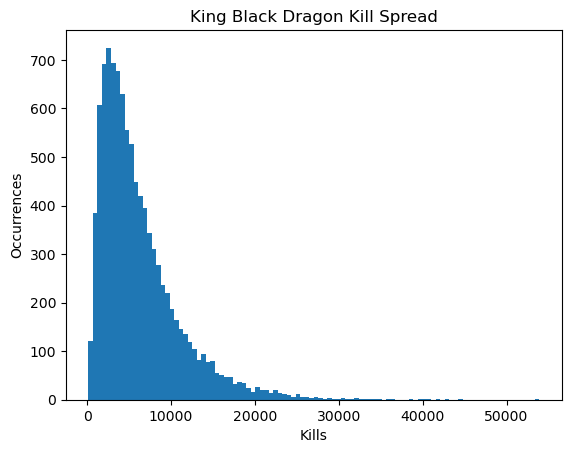

In [11]:
plt.figure()
plt.hist(kbd_kill_df, bins=bin_num)
plt.xlabel("Kills")
plt.ylabel("Occurrences")
plt.title("King Black Dragon Kill Spread")
plt.savefig("images\\King Black Dragon Kill Spread.png")
plt.show()

In [12]:
# now we can take the empty dataframe we made earlier, and append the kbd stats to it
greenlog_df = pd.concat([greenlog_df, kbd_df], ignore_index = True)

In [13]:
# did it work?
greenlog_df

Boss Name  Average Kills Lowest Kills Highest Kills
0  King Black Dragon      6216.7389          149         53910

In [14]:
# now that we've done a raid with a more refined loot mechanic, let's take a look at the first raid released in
# OSRS - The Chambers of Xeric (CoX)

# as some of these drops are only available in the Challenge Mode (CM) of the raid, we will be running our sims in CMs

# let's identify the unique items that are needed for log completion
cox_uniques = ["Olmlet", 'Metamorphic Dust', 'Twisted bow', 'Elder maul', "Kodai insignia",
              "Dragon claws", "Ancestral hat", "Ancestral robe top", "Ancestral robe bottom", "Dinh's bulwark",
               "Dexterous prayer scroll", "Arcane prayer scroll", "Dragon hunter crossbow", "Twisted buckler",
               "Torn prayer scroll", "Dark relic", "Onyx", "Twisted ancestral colour kit", 
               "Xeric's guard", "Xeric's warrior", "Xeric's sentinel", "Xeric's general", "Xeric's champion"]

# now we'll push the items into a dataframe
cox_log_df = pd.DataFrame(cox_uniques, columns=['Items'])

# now we need a counter of sorts. Let's add a column and start it at 0
cox_log_df['Amount Dropped'] = 0

# did it work?
cox_log_df

Items  Amount Dropped
0                         Olmlet               0
1               Metamorphic Dust               0
2                    Twisted bow               0
3                     Elder maul               0
4                 Kodai insignia               0
5                   Dragon claws               0
6                  Ancestral hat               0
7             Ancestral robe top               0
8          Ancestral robe bottom               0
9                 Dinh's bulwark               0
10       Dexterous prayer scroll               0
11          Arcane prayer scroll               0
12        Dragon hunter crossbow               0
13               Twisted buckler               0
14            Torn prayer scroll               0
15                    Dark relic               0
16                          Onyx               0
17  Twisted ancestral colour kit               0
18                 Xeric's guard               0
19               Xeric's warrior               0
20              Xeric's sentinel               0
21               Xeric's general               0
22              Xeric's champion               0

In [15]:
# let's set an object that will grab 2 drops per kill
# CoX drops 2 items per kill, however there is a roll that can overwrite one of the drops
# wwe will account for this later
cox_loot_table = RDSTable(count=2)

# purple is the color that chests will turn when a unique item has been dropped
# this will be the table used for the rare items
cox_purple_table = RDSTable(count=1)

cox_purple_table.add_entry(RDSItem("Twisted bow", probability=2.9))
cox_purple_table.add_entry(RDSItem("Elder maul", probability=2.9))
cox_purple_table.add_entry(RDSItem("Kodai insignia", probability=2.9))
cox_purple_table.add_entry(RDSItem("Dragon claws", probability=4.35))
cox_purple_table.add_entry(RDSItem("Ancestral hat", probability=4.35))
cox_purple_table.add_entry(RDSItem("Ancestral robe top", probability=4.35))
cox_purple_table.add_entry(RDSItem("Ancestral robe bottom", probability=4.35))
cox_purple_table.add_entry(RDSItem("Dinh's bulwark", probability=4.35))
cox_purple_table.add_entry(RDSItem("Dexterous prayer scroll", probability=29))
cox_purple_table.add_entry(RDSItem("Arcane prayer scroll", probability=29))
cox_purple_table.add_entry(RDSItem("Dragon hunter crossbow", probability=5.8))
cox_purple_table.add_entry(RDSItem("Twisted buckler", probability=5.8))


# let's add loot and assign probability to each one
# probabilities are relative to each other. Every non-unique drop shares the same probability, so setting them all
# to the same probability will ensure this remains equal
cox_loot_table.add_entry(RDSItem("Death Rune", probability=1))
cox_loot_table.add_entry(RDSItem("Blood rune", probability=1))
cox_loot_table.add_entry(RDSItem("Soul Rune", probability=1))
cox_loot_table.add_entry(RDSItem("Rune arrow", probability=1))
cox_loot_table.add_entry(RDSItem("Dragon arrow", probability=1))
cox_loot_table.add_entry(RDSItem("Grimy ranarr weed", probability=1))
cox_loot_table.add_entry(RDSItem("Grimy toadflax", probability=1))
cox_loot_table.add_entry(RDSItem("Grimy irit leaf", probability=1))
cox_loot_table.add_entry(RDSItem("Grimy avantoe", probability=1))
cox_loot_table.add_entry(RDSItem("Grimy kwuarm", probability=1))
cox_loot_table.add_entry(RDSItem("Grimy snapdragon", probability=1))
cox_loot_table.add_entry(RDSItem("Grimy cadantine", probability=1))
cox_loot_table.add_entry(RDSItem("Grimy lantadyme", probability=1))
cox_loot_table.add_entry(RDSItem("Grimy dwarf weed", probability=1))
cox_loot_table.add_entry(RDSItem("Grimy torstol", probability=1))
cox_loot_table.add_entry(RDSItem("Silver", probability=1))
cox_loot_table.add_entry(RDSItem("Coal", probability=1))
cox_loot_table.add_entry(RDSItem("Gold ore", probability=1))
cox_loot_table.add_entry(RDSItem("Mithril ore", probability=1))
cox_loot_table.add_entry(RDSItem("Adamantite ore", probability=1))
cox_loot_table.add_entry(RDSItem("Runite ore", probability=1))
cox_loot_table.add_entry(RDSItem("Uncut sapphire", probability=1))
cox_loot_table.add_entry(RDSItem("Uncut emerald", probability=1))
cox_loot_table.add_entry(RDSItem("Uncut ruby", probability=1))
cox_loot_table.add_entry(RDSItem("Uncut diamond", probability=1))
cox_loot_table.add_entry(RDSItem("Lizardman fang", probability=1))
cox_loot_table.add_entry(RDSItem("Pure essence", probability=1))
cox_loot_table.add_entry(RDSItem("Saltpetre", probability=1))
cox_loot_table.add_entry(RDSItem("Teak plank", probability=1))
cox_loot_table.add_entry(RDSItem("Mahogany plank", probability=1))
cox_loot_table.add_entry(RDSItem("Dynamite", probability=1))
cox_loot_table.add_entry(RDSItem("Torn prayer scroll", probability=1))
cox_loot_table.add_entry(RDSItem("Dark relic", probability=1))

In [16]:
# CoX points are based off a point system, where every 8676 points is equal to 1% chance at a purple
# let's get the purple chance

# average points in a CoX: CM is about 56,960 points
cox_points = 56960
cox_purple_chance = (cox_points/8676)/100
cox_purple_chance  # 6.56% chance at a purple

0.06565237436606731

In [17]:
# declare a few lists to store the number of kills per iteration
cox_kills = []
    
## here we will create a table to determine chest color
# white = basic loot
# purple = unique
cox_chest_type = RDSTable(count=1)

cox_chest_type.add_entry(RDSItem("white", probability=1-cox_purple_chance))
cox_chest_type.add_entry(RDSItem("purple", probability=cox_purple_chance))

# let's run the sim 10,000 times
for i in range(iters):
    # restart the kill number to 0 for each iteration over log completion
    kill = 0

    # set a few declarations for items that only drop once (unless destroyed)
    tablet_drop = False

    # we want the loop to run until the log is completed
    while True:
        # increase kill by 1
        kill += 1

        # run a check for purple chance        
        chest_color = cox_chest_type.rds_result
        for color in chest_color:
            if str(color) == "white":
                # grab the common loot
                results = cox_loot_table.rds_result
                # run a check to see if the tablet has been obtained
                if tablet_drop is False:
                    # if it hasn't, let's ddo the 1/10 check
                    tablet_roll = random.randint(1, 10)
                    # when it drops, we will assign it to the first slot and overwrite that drop from the table
                    if tablet_roll == 10:
                        results[0] = ("Ancient tablet")
                        # set the tablet to true so this check won't run again
                        tablet_drop = True
            else:
                results = cox_purple_table.rds_result
                # Olmlet only drops if a purple is obtained AND passing a 1/53 roll. Let's run that check.
                pet_roll = random.randint(1, 53)
                if pet_roll == 53:
                    results.append("Olmlet")
                    
        # here are some tertiary drops that roll separately from everything else and can drop alongside
        # the rest of the loot
        
        # Tekton - a miniboss in the raid has a chance to drop an Onyx. The chance increases
        # if you have more people, but we'll assume solos here. Let's run that check.
        onyx_chance = random.randint(1, 450)
        if onyx_chance == 450:
            results.append("Onyx")
            
        # in solo CMs you have 1 hour and 10 minutes to to complete the raid. If you complete the raid, you get
        # to roll for both the Metamorphic dust and the Twisted Ancestral Colour Kit
        
        # dust is 1/400. let's run that check.
        dust_chance = random.randint(1, 400)
        if dust_chance == 400:
            results.append("Metamorphic Dust")
                
        # twisted kit is 1/75. let's run that check
        kit_chance = random.randint(1, 75)
        if kit_chance == 75:
            results.append("Twisted ancestral colour kit")
                

        # shrouds are killcount based, so let's do some checks on what kill number it is to see if it drops
        if kill == 100:
            results.append("Xeric's guard")
        if kill == 500:
            results.append("Xeric's warrior")
        if kill == 1000:
            results.append("Xeric's sentinel")
        if kill == 1500:
            results.append("Xeric's general")
        if kill == 2000:
            results.append("Xeric's champion")
            

        for result in results:

            # convert each item in the drop list to a string. rds library stores them
            # as a list of objects, not strings
            result_conv = str(result)

            # check to see if the drop is in the collection log
            if result_conv in cox_log_df['Items'].values:
                # if it is, grab the row index of that item
                location = cox_log_df[cox_log_df['Items']==result_conv].index.values
                # convert that index to an integer
                location = int(location)
                # pass the integer in so that we can increase the respective counter by 1 for
                # each time the item drops
                cox_log_df.at[location, 'Amount Dropped'] += 1
        # here we run a check to see if the log is completed (everything has been dropped atleast once)
        if cox_log_df['Amount Dropped'].min() > 0:
            # append the kill number that the last unique was dropped. IE - Kill 900.
                cox_kills.append(kill)
            # break out of the while loop when log is complete.
                break

    # when the log is complete, this will print a statement to let us know when the log was 
    # completed for that simulation
    print(f"Log {i+1} was completed in {kill} kills!")

    # reset the values to 0, and rerun the sim
    cox_log_df['Amount Dropped'] = 0

Log 1 was completed in 2000 kills!
Log 2 was completed in 2000 kills!
Log 3 was completed in 3845 kills!
Log 4 was completed in 2000 kills!
Log 5 was completed in 2243 kills!
Log 6 was completed in 2000 kills!
Log 7 was completed in 2000 kills!
Log 8 was completed in 2000 kills!
Log 9 was completed in 2000 kills!
Log 10 was completed in 2000 kills!
Log 11 was completed in 2000 kills!
Log 12 was completed in 2271 kills!
Log 13 was completed in 2687 kills!
Log 14 was completed in 2000 kills!
Log 15 was completed in 2000 kills!
Log 16 was completed in 2000 kills!
Log 17 was completed in 2000 kills!
Log 18 was completed in 2054 kills!
Log 19 was completed in 2000 kills!
Log 20 was completed in 2438 kills!
Log 21 was completed in 2000 kills!
Log 22 was completed in 2000 kills!
Log 23 was completed in 2000 kills!
Log 24 was completed in 2000 kills!
Log 25 was completed in 2000 kills!
Log 26 was completed in 2000 kills!
Log 27 was completed in 2000 kills!
Log 28 was completed in 3531 kills!
L

Log 226 was completed in 2381 kills!
Log 227 was completed in 2000 kills!
Log 228 was completed in 2000 kills!
Log 229 was completed in 2000 kills!
Log 230 was completed in 2000 kills!
Log 231 was completed in 2000 kills!
Log 232 was completed in 2000 kills!
Log 233 was completed in 2000 kills!
Log 234 was completed in 2000 kills!
Log 235 was completed in 2000 kills!
Log 236 was completed in 2000 kills!
Log 237 was completed in 3000 kills!
Log 238 was completed in 2000 kills!
Log 239 was completed in 2106 kills!
Log 240 was completed in 2000 kills!
Log 241 was completed in 2000 kills!
Log 242 was completed in 2000 kills!
Log 243 was completed in 2000 kills!
Log 244 was completed in 2000 kills!
Log 245 was completed in 2364 kills!
Log 246 was completed in 2000 kills!
Log 247 was completed in 2000 kills!
Log 248 was completed in 2000 kills!
Log 249 was completed in 2000 kills!
Log 250 was completed in 2000 kills!
Log 251 was completed in 2000 kills!
Log 252 was completed in 2000 kills!
L

Log 463 was completed in 2509 kills!
Log 464 was completed in 2341 kills!
Log 465 was completed in 2000 kills!
Log 466 was completed in 2000 kills!
Log 467 was completed in 2000 kills!
Log 468 was completed in 2000 kills!
Log 469 was completed in 2000 kills!
Log 470 was completed in 2000 kills!
Log 471 was completed in 2000 kills!
Log 472 was completed in 2000 kills!
Log 473 was completed in 2000 kills!
Log 474 was completed in 2000 kills!
Log 475 was completed in 2000 kills!
Log 476 was completed in 2000 kills!
Log 477 was completed in 2000 kills!
Log 478 was completed in 2000 kills!
Log 479 was completed in 2000 kills!
Log 480 was completed in 2000 kills!
Log 481 was completed in 2099 kills!
Log 482 was completed in 2791 kills!
Log 483 was completed in 2416 kills!
Log 484 was completed in 2033 kills!
Log 485 was completed in 2000 kills!
Log 486 was completed in 2011 kills!
Log 487 was completed in 2000 kills!
Log 488 was completed in 2000 kills!
Log 489 was completed in 2000 kills!
L

Log 708 was completed in 2000 kills!
Log 709 was completed in 2000 kills!
Log 710 was completed in 2000 kills!
Log 711 was completed in 2000 kills!
Log 712 was completed in 2000 kills!
Log 713 was completed in 2000 kills!
Log 714 was completed in 2914 kills!
Log 715 was completed in 2000 kills!
Log 716 was completed in 2000 kills!
Log 717 was completed in 2000 kills!
Log 718 was completed in 2000 kills!
Log 719 was completed in 2000 kills!
Log 720 was completed in 2000 kills!
Log 721 was completed in 2000 kills!
Log 722 was completed in 2000 kills!
Log 723 was completed in 2000 kills!
Log 724 was completed in 2849 kills!
Log 725 was completed in 2000 kills!
Log 726 was completed in 3995 kills!
Log 727 was completed in 2000 kills!
Log 728 was completed in 2000 kills!
Log 729 was completed in 2000 kills!
Log 730 was completed in 2000 kills!
Log 731 was completed in 2000 kills!
Log 732 was completed in 2000 kills!
Log 733 was completed in 2000 kills!
Log 734 was completed in 2000 kills!
L

Log 983 was completed in 2000 kills!
Log 984 was completed in 2395 kills!
Log 985 was completed in 2000 kills!
Log 986 was completed in 2000 kills!
Log 987 was completed in 2000 kills!
Log 988 was completed in 2808 kills!
Log 989 was completed in 2000 kills!
Log 990 was completed in 2000 kills!
Log 991 was completed in 2000 kills!
Log 992 was completed in 2000 kills!
Log 993 was completed in 2000 kills!
Log 994 was completed in 2000 kills!
Log 995 was completed in 2219 kills!
Log 996 was completed in 2000 kills!
Log 997 was completed in 2000 kills!
Log 998 was completed in 2000 kills!
Log 999 was completed in 2000 kills!
Log 1000 was completed in 2000 kills!
Log 1001 was completed in 2000 kills!
Log 1002 was completed in 2000 kills!
Log 1003 was completed in 2000 kills!
Log 1004 was completed in 2000 kills!
Log 1005 was completed in 2000 kills!
Log 1006 was completed in 2000 kills!
Log 1007 was completed in 2000 kills!
Log 1008 was completed in 2000 kills!
Log 1009 was completed in 200

Log 1201 was completed in 2074 kills!
Log 1202 was completed in 2000 kills!
Log 1203 was completed in 2000 kills!
Log 1204 was completed in 2450 kills!
Log 1205 was completed in 2000 kills!
Log 1206 was completed in 2000 kills!
Log 1207 was completed in 2000 kills!
Log 1208 was completed in 2000 kills!
Log 1209 was completed in 2000 kills!
Log 1210 was completed in 2000 kills!
Log 1211 was completed in 2000 kills!
Log 1212 was completed in 2000 kills!
Log 1213 was completed in 2000 kills!
Log 1214 was completed in 2336 kills!
Log 1215 was completed in 3523 kills!
Log 1216 was completed in 2000 kills!
Log 1217 was completed in 2000 kills!
Log 1218 was completed in 2000 kills!
Log 1219 was completed in 2685 kills!
Log 1220 was completed in 2000 kills!
Log 1221 was completed in 3015 kills!
Log 1222 was completed in 2000 kills!
Log 1223 was completed in 2000 kills!
Log 1224 was completed in 2000 kills!
Log 1225 was completed in 2000 kills!
Log 1226 was completed in 2000 kills!
Log 1227 was

Log 1436 was completed in 2000 kills!
Log 1437 was completed in 2000 kills!
Log 1438 was completed in 2000 kills!
Log 1439 was completed in 2000 kills!
Log 1440 was completed in 2000 kills!
Log 1441 was completed in 2000 kills!
Log 1442 was completed in 2000 kills!
Log 1443 was completed in 2000 kills!
Log 1444 was completed in 2000 kills!
Log 1445 was completed in 2000 kills!
Log 1446 was completed in 2000 kills!
Log 1447 was completed in 2000 kills!
Log 1448 was completed in 2000 kills!
Log 1449 was completed in 2000 kills!
Log 1450 was completed in 2000 kills!
Log 1451 was completed in 2000 kills!
Log 1452 was completed in 2000 kills!
Log 1453 was completed in 2000 kills!
Log 1454 was completed in 2280 kills!
Log 1455 was completed in 2000 kills!
Log 1456 was completed in 2018 kills!
Log 1457 was completed in 2000 kills!
Log 1458 was completed in 2000 kills!
Log 1459 was completed in 2340 kills!
Log 1460 was completed in 2000 kills!
Log 1461 was completed in 2000 kills!
Log 1462 was

Log 1692 was completed in 2000 kills!
Log 1693 was completed in 2000 kills!
Log 1694 was completed in 2000 kills!
Log 1695 was completed in 2000 kills!
Log 1696 was completed in 6654 kills!
Log 1697 was completed in 2000 kills!
Log 1698 was completed in 2000 kills!
Log 1699 was completed in 2000 kills!
Log 1700 was completed in 2000 kills!
Log 1701 was completed in 2000 kills!
Log 1702 was completed in 2000 kills!
Log 1703 was completed in 2000 kills!
Log 1704 was completed in 2000 kills!
Log 1705 was completed in 2000 kills!
Log 1706 was completed in 2000 kills!
Log 1707 was completed in 3243 kills!
Log 1708 was completed in 2000 kills!
Log 1709 was completed in 2000 kills!
Log 1710 was completed in 2000 kills!
Log 1711 was completed in 2000 kills!
Log 1712 was completed in 2000 kills!
Log 1713 was completed in 2000 kills!
Log 1714 was completed in 2000 kills!
Log 1715 was completed in 2000 kills!
Log 1716 was completed in 2000 kills!
Log 1717 was completed in 2000 kills!
Log 1718 was

Log 1921 was completed in 2000 kills!
Log 1922 was completed in 2000 kills!
Log 1923 was completed in 2000 kills!
Log 1924 was completed in 2000 kills!
Log 1925 was completed in 2000 kills!
Log 1926 was completed in 2000 kills!
Log 1927 was completed in 2906 kills!
Log 1928 was completed in 2413 kills!
Log 1929 was completed in 2000 kills!
Log 1930 was completed in 2382 kills!
Log 1931 was completed in 2000 kills!
Log 1932 was completed in 2633 kills!
Log 1933 was completed in 2661 kills!
Log 1934 was completed in 2000 kills!
Log 1935 was completed in 2000 kills!
Log 1936 was completed in 2000 kills!
Log 1937 was completed in 2679 kills!
Log 1938 was completed in 2000 kills!
Log 1939 was completed in 2000 kills!
Log 1940 was completed in 2000 kills!
Log 1941 was completed in 2000 kills!
Log 1942 was completed in 2130 kills!
Log 1943 was completed in 2000 kills!
Log 1944 was completed in 2000 kills!
Log 1945 was completed in 2000 kills!
Log 1946 was completed in 2802 kills!
Log 1947 was

Log 2155 was completed in 2000 kills!
Log 2156 was completed in 2000 kills!
Log 2157 was completed in 2000 kills!
Log 2158 was completed in 2045 kills!
Log 2159 was completed in 2000 kills!
Log 2160 was completed in 2000 kills!
Log 2161 was completed in 2000 kills!
Log 2162 was completed in 2000 kills!
Log 2163 was completed in 2188 kills!
Log 2164 was completed in 2000 kills!
Log 2165 was completed in 2000 kills!
Log 2166 was completed in 2000 kills!
Log 2167 was completed in 2000 kills!
Log 2168 was completed in 2000 kills!
Log 2169 was completed in 2000 kills!
Log 2170 was completed in 2000 kills!
Log 2171 was completed in 2000 kills!
Log 2172 was completed in 2704 kills!
Log 2173 was completed in 2000 kills!
Log 2174 was completed in 2000 kills!
Log 2175 was completed in 2000 kills!
Log 2176 was completed in 2000 kills!
Log 2177 was completed in 2559 kills!
Log 2178 was completed in 2000 kills!
Log 2179 was completed in 2000 kills!
Log 2180 was completed in 2000 kills!
Log 2181 was

Log 2387 was completed in 2000 kills!
Log 2388 was completed in 2000 kills!
Log 2389 was completed in 2000 kills!
Log 2390 was completed in 2248 kills!
Log 2391 was completed in 2000 kills!
Log 2392 was completed in 2000 kills!
Log 2393 was completed in 2000 kills!
Log 2394 was completed in 2000 kills!
Log 2395 was completed in 2000 kills!
Log 2396 was completed in 2000 kills!
Log 2397 was completed in 2000 kills!
Log 2398 was completed in 2000 kills!
Log 2399 was completed in 2000 kills!
Log 2400 was completed in 2000 kills!
Log 2401 was completed in 2000 kills!
Log 2402 was completed in 2000 kills!
Log 2403 was completed in 2000 kills!
Log 2404 was completed in 2000 kills!
Log 2405 was completed in 2628 kills!
Log 2406 was completed in 2000 kills!
Log 2407 was completed in 2000 kills!
Log 2408 was completed in 2000 kills!
Log 2409 was completed in 2000 kills!
Log 2410 was completed in 2000 kills!
Log 2411 was completed in 2000 kills!
Log 2412 was completed in 2000 kills!
Log 2413 was

Log 2621 was completed in 2000 kills!
Log 2622 was completed in 2000 kills!
Log 2623 was completed in 2000 kills!
Log 2624 was completed in 2244 kills!
Log 2625 was completed in 2000 kills!
Log 2626 was completed in 2000 kills!
Log 2627 was completed in 3411 kills!
Log 2628 was completed in 2000 kills!
Log 2629 was completed in 2000 kills!
Log 2630 was completed in 2000 kills!
Log 2631 was completed in 2000 kills!
Log 2632 was completed in 2000 kills!
Log 2633 was completed in 2000 kills!
Log 2634 was completed in 2000 kills!
Log 2635 was completed in 2000 kills!
Log 2636 was completed in 2000 kills!
Log 2637 was completed in 2000 kills!
Log 2638 was completed in 2111 kills!
Log 2639 was completed in 2000 kills!
Log 2640 was completed in 2000 kills!
Log 2641 was completed in 2000 kills!
Log 2642 was completed in 2000 kills!
Log 2643 was completed in 2000 kills!
Log 2644 was completed in 2000 kills!
Log 2645 was completed in 2000 kills!
Log 2646 was completed in 2000 kills!
Log 2647 was

Log 2844 was completed in 2000 kills!
Log 2845 was completed in 2000 kills!
Log 2846 was completed in 2000 kills!
Log 2847 was completed in 2000 kills!
Log 2848 was completed in 2000 kills!
Log 2849 was completed in 2000 kills!
Log 2850 was completed in 2000 kills!
Log 2851 was completed in 2000 kills!
Log 2852 was completed in 2000 kills!
Log 2853 was completed in 2000 kills!
Log 2854 was completed in 2576 kills!
Log 2855 was completed in 2000 kills!
Log 2856 was completed in 2000 kills!
Log 2857 was completed in 2000 kills!
Log 2858 was completed in 2000 kills!
Log 2859 was completed in 2000 kills!
Log 2860 was completed in 2000 kills!
Log 2861 was completed in 2000 kills!
Log 2862 was completed in 2000 kills!
Log 2863 was completed in 2000 kills!
Log 2864 was completed in 2000 kills!
Log 2865 was completed in 2000 kills!
Log 2866 was completed in 2000 kills!
Log 2867 was completed in 2000 kills!
Log 2868 was completed in 2000 kills!
Log 2869 was completed in 2000 kills!
Log 2870 was

Log 3073 was completed in 2000 kills!
Log 3074 was completed in 2000 kills!
Log 3075 was completed in 2000 kills!
Log 3076 was completed in 2000 kills!
Log 3077 was completed in 2000 kills!
Log 3078 was completed in 2000 kills!
Log 3079 was completed in 2000 kills!
Log 3080 was completed in 2127 kills!
Log 3081 was completed in 2252 kills!
Log 3082 was completed in 2000 kills!
Log 3083 was completed in 2000 kills!
Log 3084 was completed in 2000 kills!
Log 3085 was completed in 2000 kills!
Log 3086 was completed in 2000 kills!
Log 3087 was completed in 2000 kills!
Log 3088 was completed in 2000 kills!
Log 3089 was completed in 2000 kills!
Log 3090 was completed in 2000 kills!
Log 3091 was completed in 2000 kills!
Log 3092 was completed in 3287 kills!
Log 3093 was completed in 2000 kills!
Log 3094 was completed in 2000 kills!
Log 3095 was completed in 2000 kills!
Log 3096 was completed in 2000 kills!
Log 3097 was completed in 2000 kills!
Log 3098 was completed in 2000 kills!
Log 3099 was

Log 3293 was completed in 2000 kills!
Log 3294 was completed in 2255 kills!
Log 3295 was completed in 2000 kills!
Log 3296 was completed in 2000 kills!
Log 3297 was completed in 2000 kills!
Log 3298 was completed in 2000 kills!
Log 3299 was completed in 2540 kills!
Log 3300 was completed in 2000 kills!
Log 3301 was completed in 2000 kills!
Log 3302 was completed in 2000 kills!
Log 3303 was completed in 2000 kills!
Log 3304 was completed in 2104 kills!
Log 3305 was completed in 2000 kills!
Log 3306 was completed in 2000 kills!
Log 3307 was completed in 2000 kills!
Log 3308 was completed in 9229 kills!
Log 3309 was completed in 2000 kills!
Log 3310 was completed in 2000 kills!
Log 3311 was completed in 2387 kills!
Log 3312 was completed in 2000 kills!
Log 3313 was completed in 3505 kills!
Log 3314 was completed in 2000 kills!
Log 3315 was completed in 2858 kills!
Log 3316 was completed in 2000 kills!
Log 3317 was completed in 2000 kills!
Log 3318 was completed in 2000 kills!
Log 3319 was

Log 3509 was completed in 2000 kills!
Log 3510 was completed in 2000 kills!
Log 3511 was completed in 2000 kills!
Log 3512 was completed in 2000 kills!
Log 3513 was completed in 2560 kills!
Log 3514 was completed in 2000 kills!
Log 3515 was completed in 2000 kills!
Log 3516 was completed in 2000 kills!
Log 3517 was completed in 2000 kills!
Log 3518 was completed in 2000 kills!
Log 3519 was completed in 2000 kills!
Log 3520 was completed in 2000 kills!
Log 3521 was completed in 2000 kills!
Log 3522 was completed in 4463 kills!
Log 3523 was completed in 2000 kills!
Log 3524 was completed in 2000 kills!
Log 3525 was completed in 2000 kills!
Log 3526 was completed in 2000 kills!
Log 3527 was completed in 2000 kills!
Log 3528 was completed in 2000 kills!
Log 3529 was completed in 2000 kills!
Log 3530 was completed in 2000 kills!
Log 3531 was completed in 2000 kills!
Log 3532 was completed in 2094 kills!
Log 3533 was completed in 2000 kills!
Log 3534 was completed in 2000 kills!
Log 3535 was

Log 3745 was completed in 2000 kills!
Log 3746 was completed in 2260 kills!
Log 3747 was completed in 2000 kills!
Log 3748 was completed in 2000 kills!
Log 3749 was completed in 2073 kills!
Log 3750 was completed in 2000 kills!
Log 3751 was completed in 2000 kills!
Log 3752 was completed in 2000 kills!
Log 3753 was completed in 2267 kills!
Log 3754 was completed in 3198 kills!
Log 3755 was completed in 2000 kills!
Log 3756 was completed in 2000 kills!
Log 3757 was completed in 2042 kills!
Log 3758 was completed in 2000 kills!
Log 3759 was completed in 3106 kills!
Log 3760 was completed in 2000 kills!
Log 3761 was completed in 2000 kills!
Log 3762 was completed in 2000 kills!
Log 3763 was completed in 2000 kills!
Log 3764 was completed in 2000 kills!
Log 3765 was completed in 2353 kills!
Log 3766 was completed in 3082 kills!
Log 3767 was completed in 2000 kills!
Log 3768 was completed in 2000 kills!
Log 3769 was completed in 2000 kills!
Log 3770 was completed in 2000 kills!
Log 3771 was

Log 3976 was completed in 3969 kills!
Log 3977 was completed in 2000 kills!
Log 3978 was completed in 2000 kills!
Log 3979 was completed in 2122 kills!
Log 3980 was completed in 3611 kills!
Log 3981 was completed in 2000 kills!
Log 3982 was completed in 2000 kills!
Log 3983 was completed in 2000 kills!
Log 3984 was completed in 2000 kills!
Log 3985 was completed in 2000 kills!
Log 3986 was completed in 2000 kills!
Log 3987 was completed in 2000 kills!
Log 3988 was completed in 2000 kills!
Log 3989 was completed in 2000 kills!
Log 3990 was completed in 2747 kills!
Log 3991 was completed in 2000 kills!
Log 3992 was completed in 2000 kills!
Log 3993 was completed in 2000 kills!
Log 3994 was completed in 2000 kills!
Log 3995 was completed in 2000 kills!
Log 3996 was completed in 2000 kills!
Log 3997 was completed in 2000 kills!
Log 3998 was completed in 2000 kills!
Log 3999 was completed in 2000 kills!
Log 4000 was completed in 3579 kills!
Log 4001 was completed in 2000 kills!
Log 4002 was

Log 4196 was completed in 2000 kills!
Log 4197 was completed in 2000 kills!
Log 4198 was completed in 2000 kills!
Log 4199 was completed in 2000 kills!
Log 4200 was completed in 2000 kills!
Log 4201 was completed in 2000 kills!
Log 4202 was completed in 2000 kills!
Log 4203 was completed in 2000 kills!
Log 4204 was completed in 2214 kills!
Log 4205 was completed in 2000 kills!
Log 4206 was completed in 2000 kills!
Log 4207 was completed in 2000 kills!
Log 4208 was completed in 2000 kills!
Log 4209 was completed in 2000 kills!
Log 4210 was completed in 2000 kills!
Log 4211 was completed in 2000 kills!
Log 4212 was completed in 2000 kills!
Log 4213 was completed in 2840 kills!
Log 4214 was completed in 2000 kills!
Log 4215 was completed in 2200 kills!
Log 4216 was completed in 2793 kills!
Log 4217 was completed in 2000 kills!
Log 4218 was completed in 2258 kills!
Log 4219 was completed in 2000 kills!
Log 4220 was completed in 2000 kills!
Log 4221 was completed in 2000 kills!
Log 4222 was

Log 4433 was completed in 2000 kills!
Log 4434 was completed in 2000 kills!
Log 4435 was completed in 2000 kills!
Log 4436 was completed in 2000 kills!
Log 4437 was completed in 2000 kills!
Log 4438 was completed in 2993 kills!
Log 4439 was completed in 2000 kills!
Log 4440 was completed in 2000 kills!
Log 4441 was completed in 2000 kills!
Log 4442 was completed in 2000 kills!
Log 4443 was completed in 2000 kills!
Log 4444 was completed in 2000 kills!
Log 4445 was completed in 2000 kills!
Log 4446 was completed in 2000 kills!
Log 4447 was completed in 2000 kills!
Log 4448 was completed in 2025 kills!
Log 4449 was completed in 2000 kills!
Log 4450 was completed in 2000 kills!
Log 4451 was completed in 2539 kills!
Log 4452 was completed in 2000 kills!
Log 4453 was completed in 2000 kills!
Log 4454 was completed in 2000 kills!
Log 4455 was completed in 2000 kills!
Log 4456 was completed in 2000 kills!
Log 4457 was completed in 2000 kills!
Log 4458 was completed in 2000 kills!
Log 4459 was

Log 4658 was completed in 2000 kills!
Log 4659 was completed in 2000 kills!
Log 4660 was completed in 3546 kills!
Log 4661 was completed in 2000 kills!
Log 4662 was completed in 2000 kills!
Log 4663 was completed in 3108 kills!
Log 4664 was completed in 2000 kills!
Log 4665 was completed in 2000 kills!
Log 4666 was completed in 2000 kills!
Log 4667 was completed in 2614 kills!
Log 4668 was completed in 2000 kills!
Log 4669 was completed in 2000 kills!
Log 4670 was completed in 2000 kills!
Log 4671 was completed in 2000 kills!
Log 4672 was completed in 2000 kills!
Log 4673 was completed in 2000 kills!
Log 4674 was completed in 2000 kills!
Log 4675 was completed in 2000 kills!
Log 4676 was completed in 2322 kills!
Log 4677 was completed in 5028 kills!
Log 4678 was completed in 2000 kills!
Log 4679 was completed in 3859 kills!
Log 4680 was completed in 2000 kills!
Log 4681 was completed in 2000 kills!
Log 4682 was completed in 2000 kills!
Log 4683 was completed in 2000 kills!
Log 4684 was

Log 4891 was completed in 2090 kills!
Log 4892 was completed in 2000 kills!
Log 4893 was completed in 2000 kills!
Log 4894 was completed in 2000 kills!
Log 4895 was completed in 2000 kills!
Log 4896 was completed in 2000 kills!
Log 4897 was completed in 2000 kills!
Log 4898 was completed in 2000 kills!
Log 4899 was completed in 2000 kills!
Log 4900 was completed in 2000 kills!
Log 4901 was completed in 2000 kills!
Log 4902 was completed in 2000 kills!
Log 4903 was completed in 2000 kills!
Log 4904 was completed in 2000 kills!
Log 4905 was completed in 2000 kills!
Log 4906 was completed in 2000 kills!
Log 4907 was completed in 2000 kills!
Log 4908 was completed in 2000 kills!
Log 4909 was completed in 2000 kills!
Log 4910 was completed in 2000 kills!
Log 4911 was completed in 2000 kills!
Log 4912 was completed in 2000 kills!
Log 4913 was completed in 2000 kills!
Log 4914 was completed in 2000 kills!
Log 4915 was completed in 2636 kills!
Log 4916 was completed in 2000 kills!
Log 4917 was

Log 5108 was completed in 2000 kills!
Log 5109 was completed in 2000 kills!
Log 5110 was completed in 2301 kills!
Log 5111 was completed in 2000 kills!
Log 5112 was completed in 2000 kills!
Log 5113 was completed in 2000 kills!
Log 5114 was completed in 2000 kills!
Log 5115 was completed in 2000 kills!
Log 5116 was completed in 2000 kills!
Log 5117 was completed in 2031 kills!
Log 5118 was completed in 2000 kills!
Log 5119 was completed in 2000 kills!
Log 5120 was completed in 2000 kills!
Log 5121 was completed in 2000 kills!
Log 5122 was completed in 2000 kills!
Log 5123 was completed in 2000 kills!
Log 5124 was completed in 2495 kills!
Log 5125 was completed in 2000 kills!
Log 5126 was completed in 2000 kills!
Log 5127 was completed in 2000 kills!
Log 5128 was completed in 2000 kills!
Log 5129 was completed in 2000 kills!
Log 5130 was completed in 2273 kills!
Log 5131 was completed in 2000 kills!
Log 5132 was completed in 2000 kills!
Log 5133 was completed in 2000 kills!
Log 5134 was

Log 5325 was completed in 2000 kills!
Log 5326 was completed in 2000 kills!
Log 5327 was completed in 2000 kills!
Log 5328 was completed in 2000 kills!
Log 5329 was completed in 2000 kills!
Log 5330 was completed in 2000 kills!
Log 5331 was completed in 2000 kills!
Log 5332 was completed in 2000 kills!
Log 5333 was completed in 2000 kills!
Log 5334 was completed in 2000 kills!
Log 5335 was completed in 2000 kills!
Log 5336 was completed in 2000 kills!
Log 5337 was completed in 2000 kills!
Log 5338 was completed in 2000 kills!
Log 5339 was completed in 3222 kills!
Log 5340 was completed in 2000 kills!
Log 5341 was completed in 2000 kills!
Log 5342 was completed in 2000 kills!
Log 5343 was completed in 2000 kills!
Log 5344 was completed in 2000 kills!
Log 5345 was completed in 2000 kills!
Log 5346 was completed in 2000 kills!
Log 5347 was completed in 2874 kills!
Log 5348 was completed in 2000 kills!
Log 5349 was completed in 2496 kills!
Log 5350 was completed in 2000 kills!
Log 5351 was

Log 5613 was completed in 2159 kills!
Log 5614 was completed in 2000 kills!
Log 5615 was completed in 2000 kills!
Log 5616 was completed in 2000 kills!
Log 5617 was completed in 2000 kills!
Log 5618 was completed in 2000 kills!
Log 5619 was completed in 2000 kills!
Log 5620 was completed in 2000 kills!
Log 5621 was completed in 2000 kills!
Log 5622 was completed in 2537 kills!
Log 5623 was completed in 2000 kills!
Log 5624 was completed in 2000 kills!
Log 5625 was completed in 4317 kills!
Log 5626 was completed in 2000 kills!
Log 5627 was completed in 2000 kills!
Log 5628 was completed in 2000 kills!
Log 5629 was completed in 2746 kills!
Log 5630 was completed in 2104 kills!
Log 5631 was completed in 2000 kills!
Log 5632 was completed in 2125 kills!
Log 5633 was completed in 2000 kills!
Log 5634 was completed in 2000 kills!
Log 5635 was completed in 2000 kills!
Log 5636 was completed in 2000 kills!
Log 5637 was completed in 2000 kills!
Log 5638 was completed in 3410 kills!
Log 5639 was

Log 5846 was completed in 2000 kills!
Log 5847 was completed in 4989 kills!
Log 5848 was completed in 2000 kills!
Log 5849 was completed in 2000 kills!
Log 5850 was completed in 2000 kills!
Log 5851 was completed in 2000 kills!
Log 5852 was completed in 2000 kills!
Log 5853 was completed in 2000 kills!
Log 5854 was completed in 2493 kills!
Log 5855 was completed in 2000 kills!
Log 5856 was completed in 2000 kills!
Log 5857 was completed in 2000 kills!
Log 5858 was completed in 2000 kills!
Log 5859 was completed in 2000 kills!
Log 5860 was completed in 2000 kills!
Log 5861 was completed in 2000 kills!
Log 5862 was completed in 2000 kills!
Log 5863 was completed in 2000 kills!
Log 5864 was completed in 2392 kills!
Log 5865 was completed in 2000 kills!
Log 5866 was completed in 2000 kills!
Log 5867 was completed in 2000 kills!
Log 5868 was completed in 2000 kills!
Log 5869 was completed in 3051 kills!
Log 5870 was completed in 2000 kills!
Log 5871 was completed in 2000 kills!
Log 5872 was

Log 6062 was completed in 2037 kills!
Log 6063 was completed in 2000 kills!
Log 6064 was completed in 2000 kills!
Log 6065 was completed in 2063 kills!
Log 6066 was completed in 2000 kills!
Log 6067 was completed in 2000 kills!
Log 6068 was completed in 2000 kills!
Log 6069 was completed in 2000 kills!
Log 6070 was completed in 2000 kills!
Log 6071 was completed in 2000 kills!
Log 6072 was completed in 2000 kills!
Log 6073 was completed in 2000 kills!
Log 6074 was completed in 2000 kills!
Log 6075 was completed in 2000 kills!
Log 6076 was completed in 2000 kills!
Log 6077 was completed in 2000 kills!
Log 6078 was completed in 2000 kills!
Log 6079 was completed in 2795 kills!
Log 6080 was completed in 2000 kills!
Log 6081 was completed in 2000 kills!
Log 6082 was completed in 2000 kills!
Log 6083 was completed in 2000 kills!
Log 6084 was completed in 2000 kills!
Log 6085 was completed in 2000 kills!
Log 6086 was completed in 2000 kills!
Log 6087 was completed in 2000 kills!
Log 6088 was

Log 6291 was completed in 2000 kills!
Log 6292 was completed in 2000 kills!
Log 6293 was completed in 2000 kills!
Log 6294 was completed in 2000 kills!
Log 6295 was completed in 2000 kills!
Log 6296 was completed in 2000 kills!
Log 6297 was completed in 2000 kills!
Log 6298 was completed in 2329 kills!
Log 6299 was completed in 4179 kills!
Log 6300 was completed in 2000 kills!
Log 6301 was completed in 2000 kills!
Log 6302 was completed in 2000 kills!
Log 6303 was completed in 2512 kills!
Log 6304 was completed in 2390 kills!
Log 6305 was completed in 2000 kills!
Log 6306 was completed in 2000 kills!
Log 6307 was completed in 2193 kills!
Log 6308 was completed in 2000 kills!
Log 6309 was completed in 2000 kills!
Log 6310 was completed in 2000 kills!
Log 6311 was completed in 2000 kills!
Log 6312 was completed in 2000 kills!
Log 6313 was completed in 2458 kills!
Log 6314 was completed in 2000 kills!
Log 6315 was completed in 2000 kills!
Log 6316 was completed in 3230 kills!
Log 6317 was

Log 6510 was completed in 2000 kills!
Log 6511 was completed in 2000 kills!
Log 6512 was completed in 2000 kills!
Log 6513 was completed in 2000 kills!
Log 6514 was completed in 2000 kills!
Log 6515 was completed in 2000 kills!
Log 6516 was completed in 2000 kills!
Log 6517 was completed in 2000 kills!
Log 6518 was completed in 2000 kills!
Log 6519 was completed in 2000 kills!
Log 6520 was completed in 2000 kills!
Log 6521 was completed in 2000 kills!
Log 6522 was completed in 2000 kills!
Log 6523 was completed in 2000 kills!
Log 6524 was completed in 2000 kills!
Log 6525 was completed in 2449 kills!
Log 6526 was completed in 2000 kills!
Log 6527 was completed in 2000 kills!
Log 6528 was completed in 2000 kills!
Log 6529 was completed in 2967 kills!
Log 6530 was completed in 2000 kills!
Log 6531 was completed in 2000 kills!
Log 6532 was completed in 2000 kills!
Log 6533 was completed in 2000 kills!
Log 6534 was completed in 2000 kills!
Log 6535 was completed in 2000 kills!
Log 6536 was

Log 6728 was completed in 2479 kills!
Log 6729 was completed in 3441 kills!
Log 6730 was completed in 2000 kills!
Log 6731 was completed in 2234 kills!
Log 6732 was completed in 2000 kills!
Log 6733 was completed in 2000 kills!
Log 6734 was completed in 2000 kills!
Log 6735 was completed in 2220 kills!
Log 6736 was completed in 2000 kills!
Log 6737 was completed in 2202 kills!
Log 6738 was completed in 2000 kills!
Log 6739 was completed in 2000 kills!
Log 6740 was completed in 2000 kills!
Log 6741 was completed in 2000 kills!
Log 6742 was completed in 2000 kills!
Log 6743 was completed in 2000 kills!
Log 6744 was completed in 2000 kills!
Log 6745 was completed in 2000 kills!
Log 6746 was completed in 2000 kills!
Log 6747 was completed in 2004 kills!
Log 6748 was completed in 2000 kills!
Log 6749 was completed in 2000 kills!
Log 6750 was completed in 2000 kills!
Log 6751 was completed in 2000 kills!
Log 6752 was completed in 2000 kills!
Log 6753 was completed in 2000 kills!
Log 6754 was

Log 6980 was completed in 2000 kills!
Log 6981 was completed in 2649 kills!
Log 6982 was completed in 2000 kills!
Log 6983 was completed in 2000 kills!
Log 6984 was completed in 2000 kills!
Log 6985 was completed in 2000 kills!
Log 6986 was completed in 2266 kills!
Log 6987 was completed in 2000 kills!
Log 6988 was completed in 2000 kills!
Log 6989 was completed in 2000 kills!
Log 6990 was completed in 2000 kills!
Log 6991 was completed in 2000 kills!
Log 6992 was completed in 2000 kills!
Log 6993 was completed in 2000 kills!
Log 6994 was completed in 2000 kills!
Log 6995 was completed in 2000 kills!
Log 6996 was completed in 2000 kills!
Log 6997 was completed in 2000 kills!
Log 6998 was completed in 2000 kills!
Log 6999 was completed in 2000 kills!
Log 7000 was completed in 2584 kills!
Log 7001 was completed in 2000 kills!
Log 7002 was completed in 2079 kills!
Log 7003 was completed in 2000 kills!
Log 7004 was completed in 2000 kills!
Log 7005 was completed in 2000 kills!
Log 7006 was

Log 7199 was completed in 2000 kills!
Log 7200 was completed in 2000 kills!
Log 7201 was completed in 2419 kills!
Log 7202 was completed in 2000 kills!
Log 7203 was completed in 2000 kills!
Log 7204 was completed in 2000 kills!
Log 7205 was completed in 2000 kills!
Log 7206 was completed in 2000 kills!
Log 7207 was completed in 2000 kills!
Log 7208 was completed in 2000 kills!
Log 7209 was completed in 2000 kills!
Log 7210 was completed in 2000 kills!
Log 7211 was completed in 2000 kills!
Log 7212 was completed in 2000 kills!
Log 7213 was completed in 2000 kills!
Log 7214 was completed in 2000 kills!
Log 7215 was completed in 2000 kills!
Log 7216 was completed in 2000 kills!
Log 7217 was completed in 2000 kills!
Log 7218 was completed in 2000 kills!
Log 7219 was completed in 2952 kills!
Log 7220 was completed in 2136 kills!
Log 7221 was completed in 2000 kills!
Log 7222 was completed in 2000 kills!
Log 7223 was completed in 2000 kills!
Log 7224 was completed in 2000 kills!
Log 7225 was

Log 7428 was completed in 2000 kills!
Log 7429 was completed in 2000 kills!
Log 7430 was completed in 2000 kills!
Log 7431 was completed in 2000 kills!
Log 7432 was completed in 2000 kills!
Log 7433 was completed in 2000 kills!
Log 7434 was completed in 2000 kills!
Log 7435 was completed in 2326 kills!
Log 7436 was completed in 2000 kills!
Log 7437 was completed in 2000 kills!
Log 7438 was completed in 3456 kills!
Log 7439 was completed in 2000 kills!
Log 7440 was completed in 2000 kills!
Log 7441 was completed in 2000 kills!
Log 7442 was completed in 2000 kills!
Log 7443 was completed in 2000 kills!
Log 7444 was completed in 2000 kills!
Log 7445 was completed in 3238 kills!
Log 7446 was completed in 2000 kills!
Log 7447 was completed in 2000 kills!
Log 7448 was completed in 2000 kills!
Log 7449 was completed in 2000 kills!
Log 7450 was completed in 2000 kills!
Log 7451 was completed in 2000 kills!
Log 7452 was completed in 2000 kills!
Log 7453 was completed in 2795 kills!
Log 7454 was

Log 7663 was completed in 2000 kills!
Log 7664 was completed in 2392 kills!
Log 7665 was completed in 2000 kills!
Log 7666 was completed in 2000 kills!
Log 7667 was completed in 2000 kills!
Log 7668 was completed in 2034 kills!
Log 7669 was completed in 2000 kills!
Log 7670 was completed in 2000 kills!
Log 7671 was completed in 2000 kills!
Log 7672 was completed in 2000 kills!
Log 7673 was completed in 2000 kills!
Log 7674 was completed in 2000 kills!
Log 7675 was completed in 2000 kills!
Log 7676 was completed in 2000 kills!
Log 7677 was completed in 2000 kills!
Log 7678 was completed in 2135 kills!
Log 7679 was completed in 2000 kills!
Log 7680 was completed in 2000 kills!
Log 7681 was completed in 2000 kills!
Log 7682 was completed in 2169 kills!
Log 7683 was completed in 2000 kills!
Log 7684 was completed in 2288 kills!
Log 7685 was completed in 2000 kills!
Log 7686 was completed in 2000 kills!
Log 7687 was completed in 2000 kills!
Log 7688 was completed in 2000 kills!
Log 7689 was

Log 7893 was completed in 2000 kills!
Log 7894 was completed in 2000 kills!
Log 7895 was completed in 2000 kills!
Log 7896 was completed in 2000 kills!
Log 7897 was completed in 2000 kills!
Log 7898 was completed in 2000 kills!
Log 7899 was completed in 2000 kills!
Log 7900 was completed in 2464 kills!
Log 7901 was completed in 2000 kills!
Log 7902 was completed in 2000 kills!
Log 7903 was completed in 2000 kills!
Log 7904 was completed in 2000 kills!
Log 7905 was completed in 2000 kills!
Log 7906 was completed in 2034 kills!
Log 7907 was completed in 2000 kills!
Log 7908 was completed in 2000 kills!
Log 7909 was completed in 2015 kills!
Log 7910 was completed in 2000 kills!
Log 7911 was completed in 2946 kills!
Log 7912 was completed in 2000 kills!
Log 7913 was completed in 2000 kills!
Log 7914 was completed in 2000 kills!
Log 7915 was completed in 2000 kills!
Log 7916 was completed in 2000 kills!
Log 7917 was completed in 2036 kills!
Log 7918 was completed in 2000 kills!
Log 7919 was

Log 8109 was completed in 2000 kills!
Log 8110 was completed in 2000 kills!
Log 8111 was completed in 2000 kills!
Log 8112 was completed in 4697 kills!
Log 8113 was completed in 2000 kills!
Log 8114 was completed in 2000 kills!
Log 8115 was completed in 2000 kills!
Log 8116 was completed in 2000 kills!
Log 8117 was completed in 2000 kills!
Log 8118 was completed in 3123 kills!
Log 8119 was completed in 2839 kills!
Log 8120 was completed in 2000 kills!
Log 8121 was completed in 2000 kills!
Log 8122 was completed in 2000 kills!
Log 8123 was completed in 2000 kills!
Log 8124 was completed in 2000 kills!
Log 8125 was completed in 2000 kills!
Log 8126 was completed in 2000 kills!
Log 8127 was completed in 2000 kills!
Log 8128 was completed in 2000 kills!
Log 8129 was completed in 2045 kills!
Log 8130 was completed in 2000 kills!
Log 8131 was completed in 2256 kills!
Log 8132 was completed in 2000 kills!
Log 8133 was completed in 2000 kills!
Log 8134 was completed in 2000 kills!
Log 8135 was

Log 8332 was completed in 2000 kills!
Log 8333 was completed in 2000 kills!
Log 8334 was completed in 2118 kills!
Log 8335 was completed in 2294 kills!
Log 8336 was completed in 2488 kills!
Log 8337 was completed in 3019 kills!
Log 8338 was completed in 2000 kills!
Log 8339 was completed in 2000 kills!
Log 8340 was completed in 2000 kills!
Log 8341 was completed in 2000 kills!
Log 8342 was completed in 2000 kills!
Log 8343 was completed in 2000 kills!
Log 8344 was completed in 2000 kills!
Log 8345 was completed in 2000 kills!
Log 8346 was completed in 2000 kills!
Log 8347 was completed in 2000 kills!
Log 8348 was completed in 2000 kills!
Log 8349 was completed in 2000 kills!
Log 8350 was completed in 2000 kills!
Log 8351 was completed in 2042 kills!
Log 8352 was completed in 2000 kills!
Log 8353 was completed in 2000 kills!
Log 8354 was completed in 2000 kills!
Log 8355 was completed in 2000 kills!
Log 8356 was completed in 2188 kills!
Log 8357 was completed in 2000 kills!
Log 8358 was

Log 8562 was completed in 2000 kills!
Log 8563 was completed in 2000 kills!
Log 8564 was completed in 2000 kills!
Log 8565 was completed in 2955 kills!
Log 8566 was completed in 2079 kills!
Log 8567 was completed in 2000 kills!
Log 8568 was completed in 2000 kills!
Log 8569 was completed in 2845 kills!
Log 8570 was completed in 2000 kills!
Log 8571 was completed in 2000 kills!
Log 8572 was completed in 2000 kills!
Log 8573 was completed in 2068 kills!
Log 8574 was completed in 2000 kills!
Log 8575 was completed in 2000 kills!
Log 8576 was completed in 2000 kills!
Log 8577 was completed in 2000 kills!
Log 8578 was completed in 2000 kills!
Log 8579 was completed in 2000 kills!
Log 8580 was completed in 2000 kills!
Log 8581 was completed in 2000 kills!
Log 8582 was completed in 2000 kills!
Log 8583 was completed in 2000 kills!
Log 8584 was completed in 2102 kills!
Log 8585 was completed in 2000 kills!
Log 8586 was completed in 2000 kills!
Log 8587 was completed in 2000 kills!
Log 8588 was

Log 8783 was completed in 2000 kills!
Log 8784 was completed in 2000 kills!
Log 8785 was completed in 2000 kills!
Log 8786 was completed in 2000 kills!
Log 8787 was completed in 2000 kills!
Log 8788 was completed in 2000 kills!
Log 8789 was completed in 2000 kills!
Log 8790 was completed in 2000 kills!
Log 8791 was completed in 2416 kills!
Log 8792 was completed in 2000 kills!
Log 8793 was completed in 2000 kills!
Log 8794 was completed in 2000 kills!
Log 8795 was completed in 2000 kills!
Log 8796 was completed in 2000 kills!
Log 8797 was completed in 2000 kills!
Log 8798 was completed in 2000 kills!
Log 8799 was completed in 2000 kills!
Log 8800 was completed in 2000 kills!
Log 8801 was completed in 2000 kills!
Log 8802 was completed in 2000 kills!
Log 8803 was completed in 2000 kills!
Log 8804 was completed in 2000 kills!
Log 8805 was completed in 2000 kills!
Log 8806 was completed in 2000 kills!
Log 8807 was completed in 2000 kills!
Log 8808 was completed in 2356 kills!
Log 8809 was

Log 9007 was completed in 2000 kills!
Log 9008 was completed in 5630 kills!
Log 9009 was completed in 2000 kills!
Log 9010 was completed in 2000 kills!
Log 9011 was completed in 2000 kills!
Log 9012 was completed in 2000 kills!
Log 9013 was completed in 2000 kills!
Log 9014 was completed in 2000 kills!
Log 9015 was completed in 2000 kills!
Log 9016 was completed in 2788 kills!
Log 9017 was completed in 2000 kills!
Log 9018 was completed in 2000 kills!
Log 9019 was completed in 2000 kills!
Log 9020 was completed in 2000 kills!
Log 9021 was completed in 2000 kills!
Log 9022 was completed in 2000 kills!
Log 9023 was completed in 2000 kills!
Log 9024 was completed in 2000 kills!
Log 9025 was completed in 2000 kills!
Log 9026 was completed in 2000 kills!
Log 9027 was completed in 2000 kills!
Log 9028 was completed in 2529 kills!
Log 9029 was completed in 2000 kills!
Log 9030 was completed in 2000 kills!
Log 9031 was completed in 2000 kills!
Log 9032 was completed in 2000 kills!
Log 9033 was

Log 9227 was completed in 2584 kills!
Log 9228 was completed in 2000 kills!
Log 9229 was completed in 2000 kills!
Log 9230 was completed in 2000 kills!
Log 9231 was completed in 2000 kills!
Log 9232 was completed in 2000 kills!
Log 9233 was completed in 2000 kills!
Log 9234 was completed in 2000 kills!
Log 9235 was completed in 2000 kills!
Log 9236 was completed in 2000 kills!
Log 9237 was completed in 2000 kills!
Log 9238 was completed in 2000 kills!
Log 9239 was completed in 3378 kills!
Log 9240 was completed in 2000 kills!
Log 9241 was completed in 2000 kills!
Log 9242 was completed in 2000 kills!
Log 9243 was completed in 4035 kills!
Log 9244 was completed in 2000 kills!
Log 9245 was completed in 2000 kills!
Log 9246 was completed in 2000 kills!
Log 9247 was completed in 2000 kills!
Log 9248 was completed in 2000 kills!
Log 9249 was completed in 2000 kills!
Log 9250 was completed in 3227 kills!
Log 9251 was completed in 2000 kills!
Log 9252 was completed in 2000 kills!
Log 9253 was

Log 9468 was completed in 2000 kills!
Log 9469 was completed in 2000 kills!
Log 9470 was completed in 2000 kills!
Log 9471 was completed in 2000 kills!
Log 9472 was completed in 2000 kills!
Log 9473 was completed in 2000 kills!
Log 9474 was completed in 2000 kills!
Log 9475 was completed in 2496 kills!
Log 9476 was completed in 2000 kills!
Log 9477 was completed in 2710 kills!
Log 9478 was completed in 2000 kills!
Log 9479 was completed in 2000 kills!
Log 9480 was completed in 2000 kills!
Log 9481 was completed in 2091 kills!
Log 9482 was completed in 2000 kills!
Log 9483 was completed in 2000 kills!
Log 9484 was completed in 2000 kills!
Log 9485 was completed in 2000 kills!
Log 9486 was completed in 2000 kills!
Log 9487 was completed in 2619 kills!
Log 9488 was completed in 2000 kills!
Log 9489 was completed in 2000 kills!
Log 9490 was completed in 2000 kills!
Log 9491 was completed in 2299 kills!
Log 9492 was completed in 2000 kills!
Log 9493 was completed in 2000 kills!
Log 9494 was

Log 9692 was completed in 2000 kills!
Log 9693 was completed in 2000 kills!
Log 9694 was completed in 2270 kills!
Log 9695 was completed in 2000 kills!
Log 9696 was completed in 2000 kills!
Log 9697 was completed in 2000 kills!
Log 9698 was completed in 2000 kills!
Log 9699 was completed in 2000 kills!
Log 9700 was completed in 2000 kills!
Log 9701 was completed in 2000 kills!
Log 9702 was completed in 2000 kills!
Log 9703 was completed in 2000 kills!
Log 9704 was completed in 2000 kills!
Log 9705 was completed in 2000 kills!
Log 9706 was completed in 2000 kills!
Log 9707 was completed in 2000 kills!
Log 9708 was completed in 2425 kills!
Log 9709 was completed in 2209 kills!
Log 9710 was completed in 2000 kills!
Log 9711 was completed in 2000 kills!
Log 9712 was completed in 2636 kills!
Log 9713 was completed in 2000 kills!
Log 9714 was completed in 2000 kills!
Log 9715 was completed in 2000 kills!
Log 9716 was completed in 2000 kills!
Log 9717 was completed in 2000 kills!
Log 9718 was

Log 9922 was completed in 2000 kills!
Log 9923 was completed in 2000 kills!
Log 9924 was completed in 2431 kills!
Log 9925 was completed in 3706 kills!
Log 9926 was completed in 2000 kills!
Log 9927 was completed in 2000 kills!
Log 9928 was completed in 2000 kills!
Log 9929 was completed in 2000 kills!
Log 9930 was completed in 2000 kills!
Log 9931 was completed in 2000 kills!
Log 9932 was completed in 2000 kills!
Log 9933 was completed in 4009 kills!
Log 9934 was completed in 2000 kills!
Log 9935 was completed in 2000 kills!
Log 9936 was completed in 2000 kills!
Log 9937 was completed in 2000 kills!
Log 9938 was completed in 2349 kills!
Log 9939 was completed in 2000 kills!
Log 9940 was completed in 2000 kills!
Log 9941 was completed in 2000 kills!
Log 9942 was completed in 2471 kills!
Log 9943 was completed in 2000 kills!
Log 9944 was completed in 2000 kills!
Log 9945 was completed in 2000 kills!
Log 9946 was completed in 2011 kills!
Log 9947 was completed in 2000 kills!
Log 9948 was

In [18]:
# sort the kills list
cox_kills.sort()

# let's find the average kills it takes to green log the boss from our simulations
cox_avg = (sum(cox_kills) / len(cox_kills))

# here's the lowest killcount for log completion from our simulations
cox_min = cox_kills[0]

# here's the highest killcount for log completion from our simulations
cox_max = cox_kills[-1]

# some stat printouts
print("CoX:CM Loot Stats")
print(f"\tFastest Completion - {cox_min}")
print(f"\tSlowest Completion - {cox_max}")
print(f"\tAverage Completion - {cox_avg}")

CoX:CM Loot Stats
	Fastest Completion - 2000
	Slowest Completion - 9229
	Average Completion - 2120.8676


In [19]:
cox_kill_df = pd.DataFrame(cox_kills)
cox_kill_df.describe()

0
count  10000.000000
mean    2120.867600
std      399.965688
min     2000.000000
25%     2000.000000
50%     2000.000000
75%     2000.000000
max     9229.000000

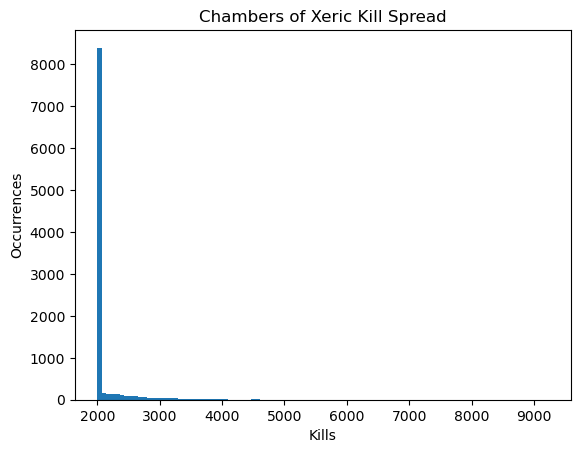

In [20]:
plt.figure()
plt.hist(cox_kill_df, bins=bin_num)
plt.xlabel("Kills")
plt.ylabel("Occurrences")
plt.title("Chambers of Xeric Kill Spread")
plt.savefig("images\\Chambers of Xeric Kill Spread.png")
plt.show()

In [21]:
# let's create a dictionary to hold all the stats we created from above
cox_stats = {"Boss Name" : ["Chambers of Xeric: Challenge Mode"], 
             "Average Kills" : [cox_avg], 
             "Lowest Kills": [cox_min], 
             "Highest Kills": [cox_max]}

# now let's turn it into a dataframe
cox_df = pd.DataFrame(cox_stats)

# did it work?
cox_df

Boss Name  Average Kills  Lowest Kills  \
0  Chambers of Xeric: Challenge Mode      2120.8676          2000   

   Highest Kills  
0           9229

In [22]:
greenlog_df = pd.concat([greenlog_df, cox_df], ignore_index = True)
greenlog_df

Boss Name  Average Kills Lowest Kills Highest Kills
0                  King Black Dragon      6216.7389          149         53910
1  Chambers of Xeric: Challenge Mode      2120.8676         2000          9229

In [23]:
# now that we've done the first raid, let's take a look at the second - The Theatre of Blood

# let's identify the unique items that are needed for log completion
tob_uniques = ["Lil' zik", 'Scythe of vitur (uncharged)', 'Ghrazi rapier', 'Sanguinesti staff (uncharged)', 
               "Justiciar faceguard", "Justiciar chestguard", "Justiciar legguards", "Avernic defender hilt",
               "Vial of blood", "Sinhaza shroud tier 1", "Sinhaza shroud tier 2", "Sinhaza shroud tier 3",
               "Sinhaza shroud tier 4", "Sinhaza shroud tier 5", "Sanguine dust", "Holy ornament kit",
               "Sanguine ornament kit"]

# now we'll push the items into a dataframe
tob_log_df = pd.DataFrame(tob_uniques, columns=['Items'])

# now we need a counter of sorts. Let's add a column and start it at 0
tob_log_df['Amount Dropped'] = 0

# did it work?
tob_log_df

Items  Amount Dropped
0                        Lil' zik               0
1     Scythe of vitur (uncharged)               0
2                   Ghrazi rapier               0
3   Sanguinesti staff (uncharged)               0
4             Justiciar faceguard               0
5            Justiciar chestguard               0
6             Justiciar legguards               0
7           Avernic defender hilt               0
8                   Vial of blood               0
9           Sinhaza shroud tier 1               0
10          Sinhaza shroud tier 2               0
11          Sinhaza shroud tier 3               0
12          Sinhaza shroud tier 4               0
13          Sinhaza shroud tier 5               0
14                  Sanguine dust               0
15              Holy ornament kit               0
16          Sanguine ornament kit               0

In [24]:
# let's set an object that will grab 3 drops per kill
tob_loot_table = RDSTable(count=3)

# purple is the color that chests will turn when a unique item has been dropped
# this will be the table used for the rare items
tob_purple_table = RDSTable(count=1)

tob_purple_table.add_entry(RDSItem("Avernic defender hilt", probability=5.05))
tob_purple_table.add_entry(RDSItem("Ghrazi rapier", probability=1.44))
tob_purple_table.add_entry(RDSItem("Sanguinesti staff (uncharged)", probability=1.44))
tob_purple_table.add_entry(RDSItem("Justiciar faceguard", probability=1.44))
tob_purple_table.add_entry(RDSItem("Justiciar chestguard", probability=1.44))
tob_purple_table.add_entry(RDSItem("Justiciar legguards", probability=1.44))
tob_purple_table.add_entry(RDSItem("Scythe of vitur (uncharged)", probability=.722))

# let's add loot and assign probability to each one
# probabilities are relative to each other. Every non-unique drop shares the same probability, 
# so setting them all
# to the same probability will ensure this remains equal
tob_loot_table.add_entry(RDSItem("Vial of blood", probability=2))
tob_loot_table.add_entry(RDSItem("Death Rune", probability=1))
tob_loot_table.add_entry(RDSItem("Blood Rune", probability=1))
tob_loot_table.add_entry(RDSItem("Swamp tar", probability=1))
tob_loot_table.add_entry(RDSItem("Coal", probability=1))
tob_loot_table.add_entry(RDSItem("Gold ore", probability=1))
tob_loot_table.add_entry(RDSItem("Molten glass", probability=1))
tob_loot_table.add_entry(RDSItem("Adamantite ore", probability=1))
tob_loot_table.add_entry(RDSItem("Runite ore", probability=1))
tob_loot_table.add_entry(RDSItem("Wine of zamorak", probability=1))
tob_loot_table.add_entry(RDSItem("Potato cactus", probability=1))
tob_loot_table.add_entry(RDSItem("Grimy cadantine", probability=1))
tob_loot_table.add_entry(RDSItem("Grimy avantoe", probability=1))
tob_loot_table.add_entry(RDSItem("Grimy toadflax", probability=1))
tob_loot_table.add_entry(RDSItem("Grimy kwuarm", probability=1))
tob_loot_table.add_entry(RDSItem("Grimy irit leaf", probability=1))
tob_loot_table.add_entry(RDSItem("Grimy ranarr weed", probability=1))
tob_loot_table.add_entry(RDSItem("Grimy snapdragon", probability=1))
tob_loot_table.add_entry(RDSItem("Grimy lantadyme", probability=1))
tob_loot_table.add_entry(RDSItem("Grimy dwarf weed", probability=1))
tob_loot_table.add_entry(RDSItem("Grimy torstol", probability=1))
tob_loot_table.add_entry(RDSItem("Battlestaff", probability=1))
tob_loot_table.add_entry(RDSItem("Rune battleaxe", probability=1))
tob_loot_table.add_entry(RDSItem("Rune platebody", probability=1))
tob_loot_table.add_entry(RDSItem("Rune chainbody", probability=1))
tob_loot_table.add_entry(RDSItem("Palm tree seed", probability=1))
tob_loot_table.add_entry(RDSItem("Yew seed", probability=1))
tob_loot_table.add_entry(RDSItem("Magic seed", probability=1))
tob_loot_table.add_entry(RDSItem("Mahogany seed", probability=1))

In [25]:
# declare a list to store the number of kills per iteration
tob_kills = []
 
# in a deathless Hardmode ToB, the purple chance is 1/7.7 across the whole team
base_tob_purple_chance = 1/7.7

# in this sim, let's assume we are doing them all as a 4 man team. so our person purple chance will 1/4th of the base
tob_purple_chance = base_tob_purple_chance/4
    
## here we will create a table to determine chest color
# white = basic loot
# purple = unique
tob_chest_type = RDSTable(count=1)

tob_chest_type.add_entry(RDSItem("white", probability=1-tob_purple_chance))
tob_chest_type.add_entry(RDSItem("purple", probability=tob_purple_chance))

# let's run the sim 10,000 times
for i in range(iters):
    # restart the kill number to 0 for each iteration over log completion
    kill = 0

    # we want the loop to run until the log is completed
    while True:
        # increase kill by 1
        kill += 1

        # run a check for purple chance        
        chest_color = tob_chest_type.rds_result
        for color in chest_color:
            if str(color) == "white":
                results = tob_loot_table.rds_result
            else:
                results = tob_purple_table.rds_result

        # shrouds are killcount based, so let's do some checks on what kill number it is to see if it drops
        if kill == 100:
            results.append("Sinhaza shroud tier 1")
        if kill == 500:
            results.append("Sinhaza shroud tier 2")
        if kill == 1000:
            results.append("Sinhaza shroud tier 3")
        if kill == 1500:
            results.append("Sinhaza shroud tier 4")
        if kill == 2000:
            results.append("Sinhaza shroud tier 5")


        # here are some tertiary drops that roll separately from everything else and can drop alongside
        # the rest of the loot

        # Lil' zik drops at a 1/500 rate in Hard Mode ToB. Let's assign that number on every kill
        pet_roll = random.randint(1, 500)
        if pet_roll == 500:
            results.append("Lil' zik")

        # Holy kit is the a 1/10 tertiary drop Let's assign that number
        holy_kit = random.randint(1, 100)
        if holy_kit == 100:
            # if successful, let's append it
            results.append("Holy ornament kit")
            
        sang_kit = random.randint(1, 150)
        if sang_kit == 150:
            # if successful, let's append it
            results.append("Sanguine ornament kit")
            
        sang_dust = random.randint(1, 275)
        if sang_dust == 275:
            # if successful, let's append it
            results.append("Sanguine dust")

        for result in results:

            # convert each item in the drop list to a string. rds library stores them
            # as a list of objects, not strings
            result_conv = str(result)

            # check to see if the drop is in the collection log
            if result_conv in tob_log_df['Items'].values:
                # if it is, grab the row index of that item
                location = tob_log_df[tob_log_df['Items']==result_conv].index.values
                # convert that index to an integer
                location = int(location)
                # pass the integer in so that we can increase the respective counter by 1 for
                # each time the item drops
                tob_log_df.at[location, 'Amount Dropped'] += 1
        # here we run a check to see if the log is completed (everything has been dropped atleast once)
        if tob_log_df['Amount Dropped'].min() > 0:
            # append the kill number that the last unique was dropped. IE - Kill 900.
            tob_kills.append(kill)
            # break out of the while loop when log is complete.
            break

    # when the log is complete, this will print a statement to let us know when the log was 
    # completed for that simulation
    print(f"Log {i+1} was completed in {kill} kills!")

    # reset the values to 0, and rerun the sim
    tob_log_df['Amount Dropped'] = 0

Log 1 was completed in 2000 kills!
Log 2 was completed in 2000 kills!
Log 3 was completed in 2000 kills!
Log 4 was completed in 2000 kills!
Log 5 was completed in 2000 kills!
Log 6 was completed in 2000 kills!
Log 7 was completed in 2000 kills!
Log 8 was completed in 2761 kills!
Log 9 was completed in 2000 kills!
Log 10 was completed in 2000 kills!
Log 11 was completed in 2000 kills!
Log 12 was completed in 2000 kills!
Log 13 was completed in 2000 kills!
Log 14 was completed in 2000 kills!
Log 15 was completed in 2000 kills!
Log 16 was completed in 2000 kills!
Log 17 was completed in 2000 kills!
Log 18 was completed in 2000 kills!
Log 19 was completed in 2000 kills!
Log 20 was completed in 2000 kills!
Log 21 was completed in 2000 kills!
Log 22 was completed in 2264 kills!
Log 23 was completed in 2000 kills!
Log 24 was completed in 2000 kills!
Log 25 was completed in 2000 kills!
Log 26 was completed in 2000 kills!
Log 27 was completed in 2000 kills!
Log 28 was completed in 2000 kills!
L

Log 235 was completed in 2000 kills!
Log 236 was completed in 2000 kills!
Log 237 was completed in 2000 kills!
Log 238 was completed in 2000 kills!
Log 239 was completed in 2000 kills!
Log 240 was completed in 2000 kills!
Log 241 was completed in 2000 kills!
Log 242 was completed in 2000 kills!
Log 243 was completed in 2000 kills!
Log 244 was completed in 2000 kills!
Log 245 was completed in 2000 kills!
Log 246 was completed in 2000 kills!
Log 247 was completed in 2000 kills!
Log 248 was completed in 2000 kills!
Log 249 was completed in 2000 kills!
Log 250 was completed in 2000 kills!
Log 251 was completed in 2000 kills!
Log 252 was completed in 2000 kills!
Log 253 was completed in 2000 kills!
Log 254 was completed in 2000 kills!
Log 255 was completed in 2000 kills!
Log 256 was completed in 2000 kills!
Log 257 was completed in 2000 kills!
Log 258 was completed in 2000 kills!
Log 259 was completed in 2000 kills!
Log 260 was completed in 2000 kills!
Log 261 was completed in 2000 kills!
L

Log 470 was completed in 2000 kills!
Log 471 was completed in 2000 kills!
Log 472 was completed in 2000 kills!
Log 473 was completed in 2000 kills!
Log 474 was completed in 2000 kills!
Log 475 was completed in 2000 kills!
Log 476 was completed in 2000 kills!
Log 477 was completed in 2000 kills!
Log 478 was completed in 2000 kills!
Log 479 was completed in 2000 kills!
Log 480 was completed in 2000 kills!
Log 481 was completed in 2000 kills!
Log 482 was completed in 2000 kills!
Log 483 was completed in 2000 kills!
Log 484 was completed in 2000 kills!
Log 485 was completed in 2000 kills!
Log 486 was completed in 2000 kills!
Log 487 was completed in 2000 kills!
Log 488 was completed in 2000 kills!
Log 489 was completed in 2000 kills!
Log 490 was completed in 2000 kills!
Log 491 was completed in 2000 kills!
Log 492 was completed in 2000 kills!
Log 493 was completed in 2000 kills!
Log 494 was completed in 2000 kills!
Log 495 was completed in 2000 kills!
Log 496 was completed in 2000 kills!
L

Log 696 was completed in 2000 kills!
Log 697 was completed in 2000 kills!
Log 698 was completed in 2000 kills!
Log 699 was completed in 2000 kills!
Log 700 was completed in 2000 kills!
Log 701 was completed in 2000 kills!
Log 702 was completed in 2000 kills!
Log 703 was completed in 2000 kills!
Log 704 was completed in 2000 kills!
Log 705 was completed in 2000 kills!
Log 706 was completed in 2000 kills!
Log 707 was completed in 2000 kills!
Log 708 was completed in 2000 kills!
Log 709 was completed in 2000 kills!
Log 710 was completed in 2406 kills!
Log 711 was completed in 2000 kills!
Log 712 was completed in 2000 kills!
Log 713 was completed in 2000 kills!
Log 714 was completed in 2000 kills!
Log 715 was completed in 2000 kills!
Log 716 was completed in 2000 kills!
Log 717 was completed in 2000 kills!
Log 718 was completed in 2000 kills!
Log 719 was completed in 2000 kills!
Log 720 was completed in 2000 kills!
Log 721 was completed in 2000 kills!
Log 722 was completed in 2000 kills!
L

Log 922 was completed in 2000 kills!
Log 923 was completed in 2170 kills!
Log 924 was completed in 2000 kills!
Log 925 was completed in 2000 kills!
Log 926 was completed in 2000 kills!
Log 927 was completed in 2000 kills!
Log 928 was completed in 2000 kills!
Log 929 was completed in 2000 kills!
Log 930 was completed in 2000 kills!
Log 931 was completed in 2000 kills!
Log 932 was completed in 2000 kills!
Log 933 was completed in 2000 kills!
Log 934 was completed in 2000 kills!
Log 935 was completed in 2000 kills!
Log 936 was completed in 2000 kills!
Log 937 was completed in 2000 kills!
Log 938 was completed in 2000 kills!
Log 939 was completed in 2000 kills!
Log 940 was completed in 2000 kills!
Log 941 was completed in 2000 kills!
Log 942 was completed in 2000 kills!
Log 943 was completed in 2000 kills!
Log 944 was completed in 2000 kills!
Log 945 was completed in 2000 kills!
Log 946 was completed in 2000 kills!
Log 947 was completed in 2000 kills!
Log 948 was completed in 2000 kills!
L

Log 1144 was completed in 2000 kills!
Log 1145 was completed in 2000 kills!
Log 1146 was completed in 2000 kills!
Log 1147 was completed in 2000 kills!
Log 1148 was completed in 2000 kills!
Log 1149 was completed in 2000 kills!
Log 1150 was completed in 2000 kills!
Log 1151 was completed in 2000 kills!
Log 1152 was completed in 2000 kills!
Log 1153 was completed in 2000 kills!
Log 1154 was completed in 2000 kills!
Log 1155 was completed in 2000 kills!
Log 1156 was completed in 2000 kills!
Log 1157 was completed in 2000 kills!
Log 1158 was completed in 2000 kills!
Log 1159 was completed in 2000 kills!
Log 1160 was completed in 2000 kills!
Log 1161 was completed in 2000 kills!
Log 1162 was completed in 2000 kills!
Log 1163 was completed in 2000 kills!
Log 1164 was completed in 2000 kills!
Log 1165 was completed in 2000 kills!
Log 1166 was completed in 2000 kills!
Log 1167 was completed in 2000 kills!
Log 1168 was completed in 2000 kills!
Log 1169 was completed in 2000 kills!
Log 1170 was

Log 1388 was completed in 2000 kills!
Log 1389 was completed in 2000 kills!
Log 1390 was completed in 2000 kills!
Log 1391 was completed in 2000 kills!
Log 1392 was completed in 2000 kills!
Log 1393 was completed in 2000 kills!
Log 1394 was completed in 2000 kills!
Log 1395 was completed in 2000 kills!
Log 1396 was completed in 2000 kills!
Log 1397 was completed in 2000 kills!
Log 1398 was completed in 2000 kills!
Log 1399 was completed in 2000 kills!
Log 1400 was completed in 2486 kills!
Log 1401 was completed in 2000 kills!
Log 1402 was completed in 2000 kills!
Log 1403 was completed in 2000 kills!
Log 1404 was completed in 2000 kills!
Log 1405 was completed in 2000 kills!
Log 1406 was completed in 2000 kills!
Log 1407 was completed in 2000 kills!
Log 1408 was completed in 2000 kills!
Log 1409 was completed in 2000 kills!
Log 1410 was completed in 2000 kills!
Log 1411 was completed in 2000 kills!
Log 1412 was completed in 2000 kills!
Log 1413 was completed in 2000 kills!
Log 1414 was

Log 1607 was completed in 2000 kills!
Log 1608 was completed in 2000 kills!
Log 1609 was completed in 2000 kills!
Log 1610 was completed in 2000 kills!
Log 1611 was completed in 2000 kills!
Log 1612 was completed in 2000 kills!
Log 1613 was completed in 2000 kills!
Log 1614 was completed in 2000 kills!
Log 1615 was completed in 2000 kills!
Log 1616 was completed in 2000 kills!
Log 1617 was completed in 2000 kills!
Log 1618 was completed in 2000 kills!
Log 1619 was completed in 2000 kills!
Log 1620 was completed in 2000 kills!
Log 1621 was completed in 2038 kills!
Log 1622 was completed in 2000 kills!
Log 1623 was completed in 2000 kills!
Log 1624 was completed in 2000 kills!
Log 1625 was completed in 2000 kills!
Log 1626 was completed in 2000 kills!
Log 1627 was completed in 2000 kills!
Log 1628 was completed in 2000 kills!
Log 1629 was completed in 2000 kills!
Log 1630 was completed in 2147 kills!
Log 1631 was completed in 2000 kills!
Log 1632 was completed in 2000 kills!
Log 1633 was

Log 1852 was completed in 2000 kills!
Log 1853 was completed in 2000 kills!
Log 1854 was completed in 2000 kills!
Log 1855 was completed in 2000 kills!
Log 1856 was completed in 2000 kills!
Log 1857 was completed in 2000 kills!
Log 1858 was completed in 4343 kills!
Log 1859 was completed in 2000 kills!
Log 1860 was completed in 2000 kills!
Log 1861 was completed in 3328 kills!
Log 1862 was completed in 2383 kills!
Log 1863 was completed in 2000 kills!
Log 1864 was completed in 2000 kills!
Log 1865 was completed in 2000 kills!
Log 1866 was completed in 2000 kills!
Log 1867 was completed in 2000 kills!
Log 1868 was completed in 2000 kills!
Log 1869 was completed in 2000 kills!
Log 1870 was completed in 2000 kills!
Log 1871 was completed in 2000 kills!
Log 1872 was completed in 2000 kills!
Log 1873 was completed in 2000 kills!
Log 1874 was completed in 2000 kills!
Log 1875 was completed in 2000 kills!
Log 1876 was completed in 2000 kills!
Log 1877 was completed in 2000 kills!
Log 1878 was

Log 2079 was completed in 2000 kills!
Log 2080 was completed in 2000 kills!
Log 2081 was completed in 2000 kills!
Log 2082 was completed in 2000 kills!
Log 2083 was completed in 2000 kills!
Log 2084 was completed in 2000 kills!
Log 2085 was completed in 2000 kills!
Log 2086 was completed in 2000 kills!
Log 2087 was completed in 2000 kills!
Log 2088 was completed in 2573 kills!
Log 2089 was completed in 2000 kills!
Log 2090 was completed in 2000 kills!
Log 2091 was completed in 2000 kills!
Log 2092 was completed in 2000 kills!
Log 2093 was completed in 2000 kills!
Log 2094 was completed in 2000 kills!
Log 2095 was completed in 2000 kills!
Log 2096 was completed in 2000 kills!
Log 2097 was completed in 2000 kills!
Log 2098 was completed in 2000 kills!
Log 2099 was completed in 2000 kills!
Log 2100 was completed in 2000 kills!
Log 2101 was completed in 2000 kills!
Log 2102 was completed in 2000 kills!
Log 2103 was completed in 2000 kills!
Log 2104 was completed in 2000 kills!
Log 2105 was

Log 2309 was completed in 2000 kills!
Log 2310 was completed in 3092 kills!
Log 2311 was completed in 2000 kills!
Log 2312 was completed in 2000 kills!
Log 2313 was completed in 2000 kills!
Log 2314 was completed in 2000 kills!
Log 2315 was completed in 2000 kills!
Log 2316 was completed in 2000 kills!
Log 2317 was completed in 2000 kills!
Log 2318 was completed in 2000 kills!
Log 2319 was completed in 2000 kills!
Log 2320 was completed in 2000 kills!
Log 2321 was completed in 2000 kills!
Log 2322 was completed in 2000 kills!
Log 2323 was completed in 2000 kills!
Log 2324 was completed in 2000 kills!
Log 2325 was completed in 2000 kills!
Log 2326 was completed in 2000 kills!
Log 2327 was completed in 2000 kills!
Log 2328 was completed in 2000 kills!
Log 2329 was completed in 2000 kills!
Log 2330 was completed in 2000 kills!
Log 2331 was completed in 2151 kills!
Log 2332 was completed in 2000 kills!
Log 2333 was completed in 2000 kills!
Log 2334 was completed in 2000 kills!
Log 2335 was

Log 2538 was completed in 2000 kills!
Log 2539 was completed in 2000 kills!
Log 2540 was completed in 2000 kills!
Log 2541 was completed in 2000 kills!
Log 2542 was completed in 2000 kills!
Log 2543 was completed in 2000 kills!
Log 2544 was completed in 2000 kills!
Log 2545 was completed in 2000 kills!
Log 2546 was completed in 2000 kills!
Log 2547 was completed in 2000 kills!
Log 2548 was completed in 2000 kills!
Log 2549 was completed in 2000 kills!
Log 2550 was completed in 2000 kills!
Log 2551 was completed in 2000 kills!
Log 2552 was completed in 2000 kills!
Log 2553 was completed in 2000 kills!
Log 2554 was completed in 2421 kills!
Log 2555 was completed in 2000 kills!
Log 2556 was completed in 2000 kills!
Log 2557 was completed in 2000 kills!
Log 2558 was completed in 2000 kills!
Log 2559 was completed in 2104 kills!
Log 2560 was completed in 2000 kills!
Log 2561 was completed in 2000 kills!
Log 2562 was completed in 2000 kills!
Log 2563 was completed in 2000 kills!
Log 2564 was

Log 2785 was completed in 2000 kills!
Log 2786 was completed in 2000 kills!
Log 2787 was completed in 2000 kills!
Log 2788 was completed in 2000 kills!
Log 2789 was completed in 2000 kills!
Log 2790 was completed in 2000 kills!
Log 2791 was completed in 2000 kills!
Log 2792 was completed in 2000 kills!
Log 2793 was completed in 2000 kills!
Log 2794 was completed in 2000 kills!
Log 2795 was completed in 2221 kills!
Log 2796 was completed in 2000 kills!
Log 2797 was completed in 2238 kills!
Log 2798 was completed in 2000 kills!
Log 2799 was completed in 2000 kills!
Log 2800 was completed in 2000 kills!
Log 2801 was completed in 2000 kills!
Log 2802 was completed in 2188 kills!
Log 2803 was completed in 2000 kills!
Log 2804 was completed in 2000 kills!
Log 2805 was completed in 2000 kills!
Log 2806 was completed in 2000 kills!
Log 2807 was completed in 2000 kills!
Log 2808 was completed in 2000 kills!
Log 2809 was completed in 2000 kills!
Log 2810 was completed in 2000 kills!
Log 2811 was

Log 3010 was completed in 2000 kills!
Log 3011 was completed in 2689 kills!
Log 3012 was completed in 2000 kills!
Log 3013 was completed in 2000 kills!
Log 3014 was completed in 2000 kills!
Log 3015 was completed in 2728 kills!
Log 3016 was completed in 2000 kills!
Log 3017 was completed in 2000 kills!
Log 3018 was completed in 2000 kills!
Log 3019 was completed in 2000 kills!
Log 3020 was completed in 2000 kills!
Log 3021 was completed in 2000 kills!
Log 3022 was completed in 2000 kills!
Log 3023 was completed in 2000 kills!
Log 3024 was completed in 2000 kills!
Log 3025 was completed in 2000 kills!
Log 3026 was completed in 2000 kills!
Log 3027 was completed in 2000 kills!
Log 3028 was completed in 2000 kills!
Log 3029 was completed in 2000 kills!
Log 3030 was completed in 2000 kills!
Log 3031 was completed in 2000 kills!
Log 3032 was completed in 2000 kills!
Log 3033 was completed in 2000 kills!
Log 3034 was completed in 2000 kills!
Log 3035 was completed in 2000 kills!
Log 3036 was

Log 3276 was completed in 2000 kills!
Log 3277 was completed in 2000 kills!
Log 3278 was completed in 2000 kills!
Log 3279 was completed in 2000 kills!
Log 3280 was completed in 2000 kills!
Log 3281 was completed in 2000 kills!
Log 3282 was completed in 2162 kills!
Log 3283 was completed in 2000 kills!
Log 3284 was completed in 2000 kills!
Log 3285 was completed in 2106 kills!
Log 3286 was completed in 2000 kills!
Log 3287 was completed in 2167 kills!
Log 3288 was completed in 2000 kills!
Log 3289 was completed in 2000 kills!
Log 3290 was completed in 2000 kills!
Log 3291 was completed in 2000 kills!
Log 3292 was completed in 2000 kills!
Log 3293 was completed in 2000 kills!
Log 3294 was completed in 2000 kills!
Log 3295 was completed in 2000 kills!
Log 3296 was completed in 2000 kills!
Log 3297 was completed in 2000 kills!
Log 3298 was completed in 2152 kills!
Log 3299 was completed in 2000 kills!
Log 3300 was completed in 2000 kills!
Log 3301 was completed in 2000 kills!
Log 3302 was

Log 3497 was completed in 2000 kills!
Log 3498 was completed in 3207 kills!
Log 3499 was completed in 2000 kills!
Log 3500 was completed in 2000 kills!
Log 3501 was completed in 2000 kills!
Log 3502 was completed in 2000 kills!
Log 3503 was completed in 2000 kills!
Log 3504 was completed in 2000 kills!
Log 3505 was completed in 2000 kills!
Log 3506 was completed in 3116 kills!
Log 3507 was completed in 2000 kills!
Log 3508 was completed in 2000 kills!
Log 3509 was completed in 2000 kills!
Log 3510 was completed in 2000 kills!
Log 3511 was completed in 2000 kills!
Log 3512 was completed in 2000 kills!
Log 3513 was completed in 2000 kills!
Log 3514 was completed in 2000 kills!
Log 3515 was completed in 2000 kills!
Log 3516 was completed in 2000 kills!
Log 3517 was completed in 2000 kills!
Log 3518 was completed in 2000 kills!
Log 3519 was completed in 2000 kills!
Log 3520 was completed in 2000 kills!
Log 3521 was completed in 2000 kills!
Log 3522 was completed in 2000 kills!
Log 3523 was

Log 3720 was completed in 2000 kills!
Log 3721 was completed in 2000 kills!
Log 3722 was completed in 2000 kills!
Log 3723 was completed in 2000 kills!
Log 3724 was completed in 2000 kills!
Log 3725 was completed in 2000 kills!
Log 3726 was completed in 2000 kills!
Log 3727 was completed in 2000 kills!
Log 3728 was completed in 2000 kills!
Log 3729 was completed in 2000 kills!
Log 3730 was completed in 2000 kills!
Log 3731 was completed in 2000 kills!
Log 3732 was completed in 2000 kills!
Log 3733 was completed in 2000 kills!
Log 3734 was completed in 2000 kills!
Log 3735 was completed in 2000 kills!
Log 3736 was completed in 2000 kills!
Log 3737 was completed in 2000 kills!
Log 3738 was completed in 2000 kills!
Log 3739 was completed in 2000 kills!
Log 3740 was completed in 2062 kills!
Log 3741 was completed in 2870 kills!
Log 3742 was completed in 2000 kills!
Log 3743 was completed in 2000 kills!
Log 3744 was completed in 2000 kills!
Log 3745 was completed in 2000 kills!
Log 3746 was

Log 3955 was completed in 2000 kills!
Log 3956 was completed in 2000 kills!
Log 3957 was completed in 2000 kills!
Log 3958 was completed in 2000 kills!
Log 3959 was completed in 2000 kills!
Log 3960 was completed in 2000 kills!
Log 3961 was completed in 2000 kills!
Log 3962 was completed in 2000 kills!
Log 3963 was completed in 2000 kills!
Log 3964 was completed in 2399 kills!
Log 3965 was completed in 2000 kills!
Log 3966 was completed in 2000 kills!
Log 3967 was completed in 2000 kills!
Log 3968 was completed in 2000 kills!
Log 3969 was completed in 2000 kills!
Log 3970 was completed in 2000 kills!
Log 3971 was completed in 2000 kills!
Log 3972 was completed in 2000 kills!
Log 3973 was completed in 2000 kills!
Log 3974 was completed in 2000 kills!
Log 3975 was completed in 2368 kills!
Log 3976 was completed in 2000 kills!
Log 3977 was completed in 2000 kills!
Log 3978 was completed in 2000 kills!
Log 3979 was completed in 2000 kills!
Log 3980 was completed in 2000 kills!
Log 3981 was

Log 4171 was completed in 2000 kills!
Log 4172 was completed in 2000 kills!
Log 4173 was completed in 2000 kills!
Log 4174 was completed in 2349 kills!
Log 4175 was completed in 2000 kills!
Log 4176 was completed in 2000 kills!
Log 4177 was completed in 2000 kills!
Log 4178 was completed in 2000 kills!
Log 4179 was completed in 2000 kills!
Log 4180 was completed in 2000 kills!
Log 4181 was completed in 2000 kills!
Log 4182 was completed in 2000 kills!
Log 4183 was completed in 2000 kills!
Log 4184 was completed in 2000 kills!
Log 4185 was completed in 2000 kills!
Log 4186 was completed in 2000 kills!
Log 4187 was completed in 2000 kills!
Log 4188 was completed in 2000 kills!
Log 4189 was completed in 2000 kills!
Log 4190 was completed in 2000 kills!
Log 4191 was completed in 2000 kills!
Log 4192 was completed in 2000 kills!
Log 4193 was completed in 2000 kills!
Log 4194 was completed in 2000 kills!
Log 4195 was completed in 2000 kills!
Log 4196 was completed in 2000 kills!
Log 4197 was

Log 4387 was completed in 2000 kills!
Log 4388 was completed in 2000 kills!
Log 4389 was completed in 2000 kills!
Log 4390 was completed in 2000 kills!
Log 4391 was completed in 2000 kills!
Log 4392 was completed in 2000 kills!
Log 4393 was completed in 2000 kills!
Log 4394 was completed in 2106 kills!
Log 4395 was completed in 2000 kills!
Log 4396 was completed in 2000 kills!
Log 4397 was completed in 2000 kills!
Log 4398 was completed in 2000 kills!
Log 4399 was completed in 2000 kills!
Log 4400 was completed in 2000 kills!
Log 4401 was completed in 2000 kills!
Log 4402 was completed in 2000 kills!
Log 4403 was completed in 2000 kills!
Log 4404 was completed in 2000 kills!
Log 4405 was completed in 2000 kills!
Log 4406 was completed in 2000 kills!
Log 4407 was completed in 2000 kills!
Log 4408 was completed in 2000 kills!
Log 4409 was completed in 2000 kills!
Log 4410 was completed in 2000 kills!
Log 4411 was completed in 2000 kills!
Log 4412 was completed in 2000 kills!
Log 4413 was

Log 4616 was completed in 2000 kills!
Log 4617 was completed in 2000 kills!
Log 4618 was completed in 2000 kills!
Log 4619 was completed in 2000 kills!
Log 4620 was completed in 2000 kills!
Log 4621 was completed in 2000 kills!
Log 4622 was completed in 2000 kills!
Log 4623 was completed in 2000 kills!
Log 4624 was completed in 2000 kills!
Log 4625 was completed in 2000 kills!
Log 4626 was completed in 2000 kills!
Log 4627 was completed in 2000 kills!
Log 4628 was completed in 2000 kills!
Log 4629 was completed in 2000 kills!
Log 4630 was completed in 2000 kills!
Log 4631 was completed in 2000 kills!
Log 4632 was completed in 2000 kills!
Log 4633 was completed in 2000 kills!
Log 4634 was completed in 2000 kills!
Log 4635 was completed in 2000 kills!
Log 4636 was completed in 2000 kills!
Log 4637 was completed in 2000 kills!
Log 4638 was completed in 2000 kills!
Log 4639 was completed in 2000 kills!
Log 4640 was completed in 2000 kills!
Log 4641 was completed in 2000 kills!
Log 4642 was

Log 4836 was completed in 2000 kills!
Log 4837 was completed in 2000 kills!
Log 4838 was completed in 2000 kills!
Log 4839 was completed in 2000 kills!
Log 4840 was completed in 2000 kills!
Log 4841 was completed in 2000 kills!
Log 4842 was completed in 2000 kills!
Log 4843 was completed in 2000 kills!
Log 4844 was completed in 2000 kills!
Log 4845 was completed in 2000 kills!
Log 4846 was completed in 2000 kills!
Log 4847 was completed in 2000 kills!
Log 4848 was completed in 2000 kills!
Log 4849 was completed in 2000 kills!
Log 4850 was completed in 2000 kills!
Log 4851 was completed in 2000 kills!
Log 4852 was completed in 2000 kills!
Log 4853 was completed in 2223 kills!
Log 4854 was completed in 2000 kills!
Log 4855 was completed in 2000 kills!
Log 4856 was completed in 2000 kills!
Log 4857 was completed in 2000 kills!
Log 4858 was completed in 2000 kills!
Log 4859 was completed in 2610 kills!
Log 4860 was completed in 2000 kills!
Log 4861 was completed in 2000 kills!
Log 4862 was

Log 5084 was completed in 2347 kills!
Log 5085 was completed in 2000 kills!
Log 5086 was completed in 2000 kills!
Log 5087 was completed in 2000 kills!
Log 5088 was completed in 2000 kills!
Log 5089 was completed in 2000 kills!
Log 5090 was completed in 2000 kills!
Log 5091 was completed in 2000 kills!
Log 5092 was completed in 2000 kills!
Log 5093 was completed in 2000 kills!
Log 5094 was completed in 2000 kills!
Log 5095 was completed in 2000 kills!
Log 5096 was completed in 2000 kills!
Log 5097 was completed in 2000 kills!
Log 5098 was completed in 2000 kills!
Log 5099 was completed in 2000 kills!
Log 5100 was completed in 2000 kills!
Log 5101 was completed in 2000 kills!
Log 5102 was completed in 2000 kills!
Log 5103 was completed in 2000 kills!
Log 5104 was completed in 2000 kills!
Log 5105 was completed in 2000 kills!
Log 5106 was completed in 2000 kills!
Log 5107 was completed in 2000 kills!
Log 5108 was completed in 2000 kills!
Log 5109 was completed in 2000 kills!
Log 5110 was

Log 5313 was completed in 2000 kills!
Log 5314 was completed in 2000 kills!
Log 5315 was completed in 2000 kills!
Log 5316 was completed in 2000 kills!
Log 5317 was completed in 2000 kills!
Log 5318 was completed in 2000 kills!
Log 5319 was completed in 2000 kills!
Log 5320 was completed in 2000 kills!
Log 5321 was completed in 2000 kills!
Log 5322 was completed in 2000 kills!
Log 5323 was completed in 2000 kills!
Log 5324 was completed in 2000 kills!
Log 5325 was completed in 2000 kills!
Log 5326 was completed in 2000 kills!
Log 5327 was completed in 2000 kills!
Log 5328 was completed in 2000 kills!
Log 5329 was completed in 2000 kills!
Log 5330 was completed in 2000 kills!
Log 5331 was completed in 2000 kills!
Log 5332 was completed in 2000 kills!
Log 5333 was completed in 2000 kills!
Log 5334 was completed in 2000 kills!
Log 5335 was completed in 2636 kills!
Log 5336 was completed in 2000 kills!
Log 5337 was completed in 2000 kills!
Log 5338 was completed in 2000 kills!
Log 5339 was

Log 5533 was completed in 2000 kills!
Log 5534 was completed in 2000 kills!
Log 5535 was completed in 2000 kills!
Log 5536 was completed in 2000 kills!
Log 5537 was completed in 2000 kills!
Log 5538 was completed in 2000 kills!
Log 5539 was completed in 2000 kills!
Log 5540 was completed in 2022 kills!
Log 5541 was completed in 2328 kills!
Log 5542 was completed in 2000 kills!
Log 5543 was completed in 2000 kills!
Log 5544 was completed in 2000 kills!
Log 5545 was completed in 2000 kills!
Log 5546 was completed in 2621 kills!
Log 5547 was completed in 2000 kills!
Log 5548 was completed in 2000 kills!
Log 5549 was completed in 2000 kills!
Log 5550 was completed in 2000 kills!
Log 5551 was completed in 2000 kills!
Log 5552 was completed in 2000 kills!
Log 5553 was completed in 2000 kills!
Log 5554 was completed in 2000 kills!
Log 5555 was completed in 2000 kills!
Log 5556 was completed in 2966 kills!
Log 5557 was completed in 2000 kills!
Log 5558 was completed in 2000 kills!
Log 5559 was

Log 5753 was completed in 2000 kills!
Log 5754 was completed in 2000 kills!
Log 5755 was completed in 2000 kills!
Log 5756 was completed in 2000 kills!
Log 5757 was completed in 2000 kills!
Log 5758 was completed in 2090 kills!
Log 5759 was completed in 2000 kills!
Log 5760 was completed in 2000 kills!
Log 5761 was completed in 2000 kills!
Log 5762 was completed in 2000 kills!
Log 5763 was completed in 2216 kills!
Log 5764 was completed in 2000 kills!
Log 5765 was completed in 2000 kills!
Log 5766 was completed in 2000 kills!
Log 5767 was completed in 2000 kills!
Log 5768 was completed in 2000 kills!
Log 5769 was completed in 2000 kills!
Log 5770 was completed in 2000 kills!
Log 5771 was completed in 2000 kills!
Log 5772 was completed in 2000 kills!
Log 5773 was completed in 2000 kills!
Log 5774 was completed in 2000 kills!
Log 5775 was completed in 2750 kills!
Log 5776 was completed in 2000 kills!
Log 5777 was completed in 2000 kills!
Log 5778 was completed in 2000 kills!
Log 5779 was

Log 5995 was completed in 2000 kills!
Log 5996 was completed in 2000 kills!
Log 5997 was completed in 2000 kills!
Log 5998 was completed in 2000 kills!
Log 5999 was completed in 2000 kills!
Log 6000 was completed in 2000 kills!
Log 6001 was completed in 2000 kills!
Log 6002 was completed in 2000 kills!
Log 6003 was completed in 2000 kills!
Log 6004 was completed in 2000 kills!
Log 6005 was completed in 2000 kills!
Log 6006 was completed in 2000 kills!
Log 6007 was completed in 2000 kills!
Log 6008 was completed in 2000 kills!
Log 6009 was completed in 2000 kills!
Log 6010 was completed in 2000 kills!
Log 6011 was completed in 2000 kills!
Log 6012 was completed in 2000 kills!
Log 6013 was completed in 2000 kills!
Log 6014 was completed in 2000 kills!
Log 6015 was completed in 2000 kills!
Log 6016 was completed in 2000 kills!
Log 6017 was completed in 2000 kills!
Log 6018 was completed in 2000 kills!
Log 6019 was completed in 2000 kills!
Log 6020 was completed in 2000 kills!
Log 6021 was

Log 6226 was completed in 2000 kills!
Log 6227 was completed in 2000 kills!
Log 6228 was completed in 2000 kills!
Log 6229 was completed in 2000 kills!
Log 6230 was completed in 2000 kills!
Log 6231 was completed in 2000 kills!
Log 6232 was completed in 2263 kills!
Log 6233 was completed in 2000 kills!
Log 6234 was completed in 2000 kills!
Log 6235 was completed in 2000 kills!
Log 6236 was completed in 2000 kills!
Log 6237 was completed in 2000 kills!
Log 6238 was completed in 2000 kills!
Log 6239 was completed in 2000 kills!
Log 6240 was completed in 2000 kills!
Log 6241 was completed in 2000 kills!
Log 6242 was completed in 2000 kills!
Log 6243 was completed in 2000 kills!
Log 6244 was completed in 2000 kills!
Log 6245 was completed in 2000 kills!
Log 6246 was completed in 2000 kills!
Log 6247 was completed in 2000 kills!
Log 6248 was completed in 2000 kills!
Log 6249 was completed in 2764 kills!
Log 6250 was completed in 2000 kills!
Log 6251 was completed in 2000 kills!
Log 6252 was

Log 6443 was completed in 2000 kills!
Log 6444 was completed in 2195 kills!
Log 6445 was completed in 2000 kills!
Log 6446 was completed in 2000 kills!
Log 6447 was completed in 2000 kills!
Log 6448 was completed in 2000 kills!
Log 6449 was completed in 2000 kills!
Log 6450 was completed in 2000 kills!
Log 6451 was completed in 2000 kills!
Log 6452 was completed in 2000 kills!
Log 6453 was completed in 2000 kills!
Log 6454 was completed in 2000 kills!
Log 6455 was completed in 2000 kills!
Log 6456 was completed in 2000 kills!
Log 6457 was completed in 2000 kills!
Log 6458 was completed in 2000 kills!
Log 6459 was completed in 2000 kills!
Log 6460 was completed in 2000 kills!
Log 6461 was completed in 2000 kills!
Log 6462 was completed in 2000 kills!
Log 6463 was completed in 2000 kills!
Log 6464 was completed in 2000 kills!
Log 6465 was completed in 2000 kills!
Log 6466 was completed in 2000 kills!
Log 6467 was completed in 2000 kills!
Log 6468 was completed in 2000 kills!
Log 6469 was

Log 6672 was completed in 2000 kills!
Log 6673 was completed in 2000 kills!
Log 6674 was completed in 2000 kills!
Log 6675 was completed in 2000 kills!
Log 6676 was completed in 2000 kills!
Log 6677 was completed in 2000 kills!
Log 6678 was completed in 2000 kills!
Log 6679 was completed in 2000 kills!
Log 6680 was completed in 2000 kills!
Log 6681 was completed in 2000 kills!
Log 6682 was completed in 2000 kills!
Log 6683 was completed in 2000 kills!
Log 6684 was completed in 2000 kills!
Log 6685 was completed in 2000 kills!
Log 6686 was completed in 2000 kills!
Log 6687 was completed in 2000 kills!
Log 6688 was completed in 2000 kills!
Log 6689 was completed in 2000 kills!
Log 6690 was completed in 2000 kills!
Log 6691 was completed in 2000 kills!
Log 6692 was completed in 2000 kills!
Log 6693 was completed in 2000 kills!
Log 6694 was completed in 2000 kills!
Log 6695 was completed in 2000 kills!
Log 6696 was completed in 2000 kills!
Log 6697 was completed in 2000 kills!
Log 6698 was

Log 6905 was completed in 2000 kills!
Log 6906 was completed in 2000 kills!
Log 6907 was completed in 2000 kills!
Log 6908 was completed in 2000 kills!
Log 6909 was completed in 2000 kills!
Log 6910 was completed in 2000 kills!
Log 6911 was completed in 2216 kills!
Log 6912 was completed in 2000 kills!
Log 6913 was completed in 2386 kills!
Log 6914 was completed in 2000 kills!
Log 6915 was completed in 2000 kills!
Log 6916 was completed in 2000 kills!
Log 6917 was completed in 2000 kills!
Log 6918 was completed in 2000 kills!
Log 6919 was completed in 2000 kills!
Log 6920 was completed in 2000 kills!
Log 6921 was completed in 2000 kills!
Log 6922 was completed in 2000 kills!
Log 6923 was completed in 2000 kills!
Log 6924 was completed in 2065 kills!
Log 6925 was completed in 2000 kills!
Log 6926 was completed in 2000 kills!
Log 6927 was completed in 2000 kills!
Log 6928 was completed in 2000 kills!
Log 6929 was completed in 2000 kills!
Log 6930 was completed in 2000 kills!
Log 6931 was

Log 7142 was completed in 2000 kills!
Log 7143 was completed in 2000 kills!
Log 7144 was completed in 2000 kills!
Log 7145 was completed in 2431 kills!
Log 7146 was completed in 2000 kills!
Log 7147 was completed in 2000 kills!
Log 7148 was completed in 2000 kills!
Log 7149 was completed in 2000 kills!
Log 7150 was completed in 2000 kills!
Log 7151 was completed in 2000 kills!
Log 7152 was completed in 2000 kills!
Log 7153 was completed in 2000 kills!
Log 7154 was completed in 2000 kills!
Log 7155 was completed in 2092 kills!
Log 7156 was completed in 2000 kills!
Log 7157 was completed in 2000 kills!
Log 7158 was completed in 2000 kills!
Log 7159 was completed in 2000 kills!
Log 7160 was completed in 2000 kills!
Log 7161 was completed in 2000 kills!
Log 7162 was completed in 2710 kills!
Log 7163 was completed in 2000 kills!
Log 7164 was completed in 2000 kills!
Log 7165 was completed in 2000 kills!
Log 7166 was completed in 2000 kills!
Log 7167 was completed in 2000 kills!
Log 7168 was

Log 7361 was completed in 2000 kills!
Log 7362 was completed in 2000 kills!
Log 7363 was completed in 2000 kills!
Log 7364 was completed in 2000 kills!
Log 7365 was completed in 2000 kills!
Log 7366 was completed in 2000 kills!
Log 7367 was completed in 2000 kills!
Log 7368 was completed in 2000 kills!
Log 7369 was completed in 2000 kills!
Log 7370 was completed in 2000 kills!
Log 7371 was completed in 2000 kills!
Log 7372 was completed in 2000 kills!
Log 7373 was completed in 2000 kills!
Log 7374 was completed in 2000 kills!
Log 7375 was completed in 2000 kills!
Log 7376 was completed in 2000 kills!
Log 7377 was completed in 2000 kills!
Log 7378 was completed in 2531 kills!
Log 7379 was completed in 2000 kills!
Log 7380 was completed in 2000 kills!
Log 7381 was completed in 2000 kills!
Log 7382 was completed in 2000 kills!
Log 7383 was completed in 2000 kills!
Log 7384 was completed in 2000 kills!
Log 7385 was completed in 2000 kills!
Log 7386 was completed in 2000 kills!
Log 7387 was

Log 7581 was completed in 2000 kills!
Log 7582 was completed in 2000 kills!
Log 7583 was completed in 2943 kills!
Log 7584 was completed in 2000 kills!
Log 7585 was completed in 2000 kills!
Log 7586 was completed in 2000 kills!
Log 7587 was completed in 2000 kills!
Log 7588 was completed in 2000 kills!
Log 7589 was completed in 2000 kills!
Log 7590 was completed in 2000 kills!
Log 7591 was completed in 2000 kills!
Log 7592 was completed in 2000 kills!
Log 7593 was completed in 2000 kills!
Log 7594 was completed in 2000 kills!
Log 7595 was completed in 2000 kills!
Log 7596 was completed in 2000 kills!
Log 7597 was completed in 2000 kills!
Log 7598 was completed in 2000 kills!
Log 7599 was completed in 2000 kills!
Log 7600 was completed in 2000 kills!
Log 7601 was completed in 2000 kills!
Log 7602 was completed in 2000 kills!
Log 7603 was completed in 2000 kills!
Log 7604 was completed in 2000 kills!
Log 7605 was completed in 2163 kills!
Log 7606 was completed in 2176 kills!
Log 7607 was

Log 7806 was completed in 2000 kills!
Log 7807 was completed in 2026 kills!
Log 7808 was completed in 2198 kills!
Log 7809 was completed in 2000 kills!
Log 7810 was completed in 2000 kills!
Log 7811 was completed in 2000 kills!
Log 7812 was completed in 2000 kills!
Log 7813 was completed in 2000 kills!
Log 7814 was completed in 2000 kills!
Log 7815 was completed in 2000 kills!
Log 7816 was completed in 2000 kills!
Log 7817 was completed in 2000 kills!
Log 7818 was completed in 2984 kills!
Log 7819 was completed in 2000 kills!
Log 7820 was completed in 2000 kills!
Log 7821 was completed in 2000 kills!
Log 7822 was completed in 2000 kills!
Log 7823 was completed in 2000 kills!
Log 7824 was completed in 2000 kills!
Log 7825 was completed in 2000 kills!
Log 7826 was completed in 2139 kills!
Log 7827 was completed in 2000 kills!
Log 7828 was completed in 2000 kills!
Log 7829 was completed in 2000 kills!
Log 7830 was completed in 2000 kills!
Log 7831 was completed in 2000 kills!
Log 7832 was

Log 8045 was completed in 2000 kills!
Log 8046 was completed in 2000 kills!
Log 8047 was completed in 2000 kills!
Log 8048 was completed in 2000 kills!
Log 8049 was completed in 2000 kills!
Log 8050 was completed in 2000 kills!
Log 8051 was completed in 2000 kills!
Log 8052 was completed in 2000 kills!
Log 8053 was completed in 2000 kills!
Log 8054 was completed in 2000 kills!
Log 8055 was completed in 2000 kills!
Log 8056 was completed in 2000 kills!
Log 8057 was completed in 2000 kills!
Log 8058 was completed in 2000 kills!
Log 8059 was completed in 2000 kills!
Log 8060 was completed in 2000 kills!
Log 8061 was completed in 2000 kills!
Log 8062 was completed in 2000 kills!
Log 8063 was completed in 2000 kills!
Log 8064 was completed in 2000 kills!
Log 8065 was completed in 2000 kills!
Log 8066 was completed in 2000 kills!
Log 8067 was completed in 2000 kills!
Log 8068 was completed in 2000 kills!
Log 8069 was completed in 2000 kills!
Log 8070 was completed in 2000 kills!
Log 8071 was

Log 8270 was completed in 2000 kills!
Log 8271 was completed in 2000 kills!
Log 8272 was completed in 3018 kills!
Log 8273 was completed in 2000 kills!
Log 8274 was completed in 2040 kills!
Log 8275 was completed in 2000 kills!
Log 8276 was completed in 2000 kills!
Log 8277 was completed in 2000 kills!
Log 8278 was completed in 2000 kills!
Log 8279 was completed in 2000 kills!
Log 8280 was completed in 2000 kills!
Log 8281 was completed in 2000 kills!
Log 8282 was completed in 2000 kills!
Log 8283 was completed in 2000 kills!
Log 8284 was completed in 2000 kills!
Log 8285 was completed in 2000 kills!
Log 8286 was completed in 2000 kills!
Log 8287 was completed in 2000 kills!
Log 8288 was completed in 2000 kills!
Log 8289 was completed in 2000 kills!
Log 8290 was completed in 2000 kills!
Log 8291 was completed in 2000 kills!
Log 8292 was completed in 2000 kills!
Log 8293 was completed in 2000 kills!
Log 8294 was completed in 2000 kills!
Log 8295 was completed in 2000 kills!
Log 8296 was

Log 8493 was completed in 2000 kills!
Log 8494 was completed in 2000 kills!
Log 8495 was completed in 2118 kills!
Log 8496 was completed in 2000 kills!
Log 8497 was completed in 2000 kills!
Log 8498 was completed in 2000 kills!
Log 8499 was completed in 2000 kills!
Log 8500 was completed in 2000 kills!
Log 8501 was completed in 2809 kills!
Log 8502 was completed in 2000 kills!
Log 8503 was completed in 2000 kills!
Log 8504 was completed in 2000 kills!
Log 8505 was completed in 2000 kills!
Log 8506 was completed in 2000 kills!
Log 8507 was completed in 2000 kills!
Log 8508 was completed in 2000 kills!
Log 8509 was completed in 2000 kills!
Log 8510 was completed in 2000 kills!
Log 8511 was completed in 2000 kills!
Log 8512 was completed in 2000 kills!
Log 8513 was completed in 2000 kills!
Log 8514 was completed in 2000 kills!
Log 8515 was completed in 2000 kills!
Log 8516 was completed in 2000 kills!
Log 8517 was completed in 2000 kills!
Log 8518 was completed in 2000 kills!
Log 8519 was

Log 8712 was completed in 2000 kills!
Log 8713 was completed in 2000 kills!
Log 8714 was completed in 2000 kills!
Log 8715 was completed in 2000 kills!
Log 8716 was completed in 2000 kills!
Log 8717 was completed in 2000 kills!
Log 8718 was completed in 2000 kills!
Log 8719 was completed in 2000 kills!
Log 8720 was completed in 2000 kills!
Log 8721 was completed in 2000 kills!
Log 8722 was completed in 2000 kills!
Log 8723 was completed in 2000 kills!
Log 8724 was completed in 2000 kills!
Log 8725 was completed in 2000 kills!
Log 8726 was completed in 2000 kills!
Log 8727 was completed in 2000 kills!
Log 8728 was completed in 2000 kills!
Log 8729 was completed in 2000 kills!
Log 8730 was completed in 2000 kills!
Log 8731 was completed in 2000 kills!
Log 8732 was completed in 2000 kills!
Log 8733 was completed in 2000 kills!
Log 8734 was completed in 2000 kills!
Log 8735 was completed in 2000 kills!
Log 8736 was completed in 2000 kills!
Log 8737 was completed in 2000 kills!
Log 8738 was

Log 8935 was completed in 2000 kills!
Log 8936 was completed in 2000 kills!
Log 8937 was completed in 2000 kills!
Log 8938 was completed in 2000 kills!
Log 8939 was completed in 2000 kills!
Log 8940 was completed in 2000 kills!
Log 8941 was completed in 2400 kills!
Log 8942 was completed in 2000 kills!
Log 8943 was completed in 2000 kills!
Log 8944 was completed in 2000 kills!
Log 8945 was completed in 2000 kills!
Log 8946 was completed in 2000 kills!
Log 8947 was completed in 2000 kills!
Log 8948 was completed in 2000 kills!
Log 8949 was completed in 2000 kills!
Log 8950 was completed in 2000 kills!
Log 8951 was completed in 2000 kills!
Log 8952 was completed in 2000 kills!
Log 8953 was completed in 2000 kills!
Log 8954 was completed in 2000 kills!
Log 8955 was completed in 2140 kills!
Log 8956 was completed in 2000 kills!
Log 8957 was completed in 2000 kills!
Log 8958 was completed in 2000 kills!
Log 8959 was completed in 2000 kills!
Log 8960 was completed in 2000 kills!
Log 8961 was

Log 9161 was completed in 2000 kills!
Log 9162 was completed in 2000 kills!
Log 9163 was completed in 2000 kills!
Log 9164 was completed in 2175 kills!
Log 9165 was completed in 2000 kills!
Log 9166 was completed in 2000 kills!
Log 9167 was completed in 2000 kills!
Log 9168 was completed in 2000 kills!
Log 9169 was completed in 2000 kills!
Log 9170 was completed in 2000 kills!
Log 9171 was completed in 2000 kills!
Log 9172 was completed in 2113 kills!
Log 9173 was completed in 2000 kills!
Log 9174 was completed in 2000 kills!
Log 9175 was completed in 2000 kills!
Log 9176 was completed in 2000 kills!
Log 9177 was completed in 2000 kills!
Log 9178 was completed in 2000 kills!
Log 9179 was completed in 2000 kills!
Log 9180 was completed in 2000 kills!
Log 9181 was completed in 2000 kills!
Log 9182 was completed in 2000 kills!
Log 9183 was completed in 2000 kills!
Log 9184 was completed in 2000 kills!
Log 9185 was completed in 2000 kills!
Log 9186 was completed in 2000 kills!
Log 9187 was

Log 9401 was completed in 2000 kills!
Log 9402 was completed in 2000 kills!
Log 9403 was completed in 2000 kills!
Log 9404 was completed in 2000 kills!
Log 9405 was completed in 2000 kills!
Log 9406 was completed in 2000 kills!
Log 9407 was completed in 2000 kills!
Log 9408 was completed in 2000 kills!
Log 9409 was completed in 2000 kills!
Log 9410 was completed in 2000 kills!
Log 9411 was completed in 2000 kills!
Log 9412 was completed in 2000 kills!
Log 9413 was completed in 2000 kills!
Log 9414 was completed in 2000 kills!
Log 9415 was completed in 2128 kills!
Log 9416 was completed in 2034 kills!
Log 9417 was completed in 2000 kills!
Log 9418 was completed in 2000 kills!
Log 9419 was completed in 2000 kills!
Log 9420 was completed in 2000 kills!
Log 9421 was completed in 2000 kills!
Log 9422 was completed in 2000 kills!
Log 9423 was completed in 2000 kills!
Log 9424 was completed in 2000 kills!
Log 9425 was completed in 2000 kills!
Log 9426 was completed in 2000 kills!
Log 9427 was

Log 9631 was completed in 2000 kills!
Log 9632 was completed in 2000 kills!
Log 9633 was completed in 2000 kills!
Log 9634 was completed in 2000 kills!
Log 9635 was completed in 2000 kills!
Log 9636 was completed in 2000 kills!
Log 9637 was completed in 2000 kills!
Log 9638 was completed in 2000 kills!
Log 9639 was completed in 2000 kills!
Log 9640 was completed in 2000 kills!
Log 9641 was completed in 2000 kills!
Log 9642 was completed in 2000 kills!
Log 9643 was completed in 2000 kills!
Log 9644 was completed in 2000 kills!
Log 9645 was completed in 2000 kills!
Log 9646 was completed in 2000 kills!
Log 9647 was completed in 2000 kills!
Log 9648 was completed in 2000 kills!
Log 9649 was completed in 2000 kills!
Log 9650 was completed in 2000 kills!
Log 9651 was completed in 2000 kills!
Log 9652 was completed in 2000 kills!
Log 9653 was completed in 2000 kills!
Log 9654 was completed in 2000 kills!
Log 9655 was completed in 2000 kills!
Log 9656 was completed in 2000 kills!
Log 9657 was

Log 9850 was completed in 2000 kills!
Log 9851 was completed in 2000 kills!
Log 9852 was completed in 2000 kills!
Log 9853 was completed in 2000 kills!
Log 9854 was completed in 2000 kills!
Log 9855 was completed in 2000 kills!
Log 9856 was completed in 2000 kills!
Log 9857 was completed in 2000 kills!
Log 9858 was completed in 2000 kills!
Log 9859 was completed in 2000 kills!
Log 9860 was completed in 2000 kills!
Log 9861 was completed in 2000 kills!
Log 9862 was completed in 2000 kills!
Log 9863 was completed in 2000 kills!
Log 9864 was completed in 2000 kills!
Log 9865 was completed in 2000 kills!
Log 9866 was completed in 2000 kills!
Log 9867 was completed in 2000 kills!
Log 9868 was completed in 2000 kills!
Log 9869 was completed in 2000 kills!
Log 9870 was completed in 2000 kills!
Log 9871 was completed in 2000 kills!
Log 9872 was completed in 2000 kills!
Log 9873 was completed in 2000 kills!
Log 9874 was completed in 2000 kills!
Log 9875 was completed in 2348 kills!
Log 9876 was

In [26]:
# sort the kills list
tob_kills.sort()

# let's find the average kills it takes to green log the boss from our simulations
tob_avg = (sum(tob_kills) / len(tob_kills))

# here's the lowest killcount for log completion from our simulations
tob_min = tob_kills[0]

# here's the highest killcount for log completion from our simulations
tob_max = tob_kills[-1]

# some stat printouts
print("Hard Mode ToB Loot Stats")
print(f"\tFastest Completion - {tob_min}")
print(f"\tSlowest Completion - {tob_max}")
print(f"\tAverage Completion - {tob_avg}")

Hard Mode ToB Loot Stats
	Fastest Completion - 2000
	Slowest Completion - 4355
	Average Completion - 2023.7817


In [27]:
tob_kill_df = pd.DataFrame(tob_kills)
tob_kill_df.describe()

0
count  10000.00000
mean    2023.78170
std      145.89919
min     2000.00000
25%     2000.00000
50%     2000.00000
75%     2000.00000
max     4355.00000

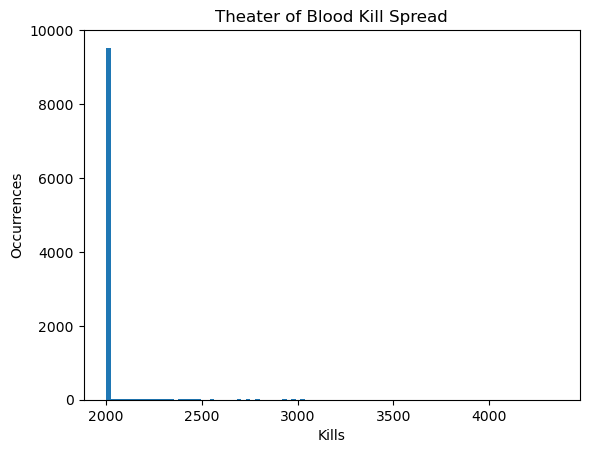

In [28]:
plt.figure()
plt.hist(tob_kill_df, bins=bin_num)
plt.xlabel("Kills")
plt.ylabel("Occurrences")
plt.title("Theater of Blood Kill Spread")
plt.savefig("images\\Theater of Blood Kill Spread.png")
plt.show()

In [29]:
# let's create a dictionary to hold all the stats we created from above
tob_stats = {"Boss Name" : ["Hard Mode Theatre of Blood"], 
             "Average Kills" : [tob_avg], 
             "Lowest Kills": [tob_min], 
             "Highest Kills": [tob_max]}

# now let's turn it into a dataframe
tob_df = pd.DataFrame(tob_stats)

# did it work?
tob_df

Boss Name  Average Kills  Lowest Kills  Highest Kills
0  Hard Mode Theatre of Blood      2023.7817          2000           4355

In [30]:
greenlog_df = pd.concat([greenlog_df, tob_df], ignore_index = True)
greenlog_df

Boss Name  Average Kills Lowest Kills Highest Kills
0                  King Black Dragon      6216.7389          149         53910
1  Chambers of Xeric: Challenge Mode      2120.8676         2000          9229
2         Hard Mode Theatre of Blood      2023.7817         2000          4355

In [31]:
# now that we've done a relatively easy boss, let's take a look at a raid that increases loot chance
# based on the difficulty you set - The Tombs of Amascut (ToA)

# let's identify the unique items that are needed for log completion
toa_uniques = ["Tumeken's Shadow", 'Masori Mask', 'Masori Body', 'Masori Chaps', "Elidinis' Ward",
              "Osmumten's Fang", "Lightbearer", "Tumeken's Guardian", "Icthlarin's shroud (tier 1)", 
               "Icthlarin's shroud (tier 2)", "Icthlarin's shroud (tier 3)", "Icthlarin's shroud (tier 4)",
              "Icthlarin's shroud (tier 5)", "Thread of Elidinis", "Eye of the Corruptor", "Jewel of the Sun",
              "Breach of the Scarab", "Cache of Runes"]

# now we'll push the items into a dataframe
toa_log_df = pd.DataFrame(toa_uniques, columns=['Items'])

# now we need a counter of sorts. Let's add a column and start it at 0
toa_log_df['Amount Dropped'] = 0

# did it work?
toa_log_df

Items  Amount Dropped
0              Tumeken's Shadow               0
1                   Masori Mask               0
2                   Masori Body               0
3                  Masori Chaps               0
4                Elidinis' Ward               0
5               Osmumten's Fang               0
6                   Lightbearer               0
7            Tumeken's Guardian               0
8   Icthlarin's shroud (tier 1)               0
9   Icthlarin's shroud (tier 2)               0
10  Icthlarin's shroud (tier 3)               0
11  Icthlarin's shroud (tier 4)               0
12  Icthlarin's shroud (tier 5)               0
13           Thread of Elidinis               0
14         Eye of the Corruptor               0
15             Jewel of the Sun               0
16         Breach of the Scarab               0
17               Cache of Runes               0

In [32]:
# let's set an object that will grab 3 drops per kill
toa_loot_table = RDSTable(count=3)

# purple is the color that chests will turn when a unique item has been dropped
# this will be the table used for the rare items
toa_purple_table = RDSTable(count=1)

toa_purple_table.add_entry(RDSItem("Tumeken's Shadow", probability=4.17))
toa_purple_table.add_entry(RDSItem("Masori Chaps", probability=8.33))
toa_purple_table.add_entry(RDSItem("Masori Body", probability=8.33))
toa_purple_table.add_entry(RDSItem("Masori Mask", probability=8.33))
toa_purple_table.add_entry(RDSItem("Elidinis' Ward", probability=12.5))
toa_purple_table.add_entry(RDSItem("Lightbearer", probability=29.2))
toa_purple_table.add_entry(RDSItem("Osmumten's Fang", probability=29.2))

# let's add loot and assign probability to each one
# probabilities are relative to each other. Every non-unique drop shares the same probability, so setting them all
# to the same probability will ensure this remains equal
toa_loot_table.add_entry(RDSItem("Coins", probability=1))
toa_loot_table.add_entry(RDSItem("Death Rune", probability=1))
toa_loot_table.add_entry(RDSItem("Soul Rune", probability=1))
toa_loot_table.add_entry(RDSItem("Gold ore", probability=1))
toa_loot_table.add_entry(RDSItem("Dragon dart tip", probability=1))
toa_loot_table.add_entry(RDSItem("Mahogany logs", probability=1))
toa_loot_table.add_entry(RDSItem("Sapphire", probability=1))
toa_loot_table.add_entry(RDSItem("Emerald", probability=1))
toa_loot_table.add_entry(RDSItem("Gold bar", probability=1))
toa_loot_table.add_entry(RDSItem("Potato cactus", probability=1))
toa_loot_table.add_entry(RDSItem("Raw shark", probability=1))
toa_loot_table.add_entry(RDSItem("Ruby", probability=1))
toa_loot_table.add_entry(RDSItem("Diamond", probability=1))
toa_loot_table.add_entry(RDSItem("Raw manta ray", probability=1))
toa_loot_table.add_entry(RDSItem("Cactus spine", probability=1))
toa_loot_table.add_entry(RDSItem("Dragonstone", probability=1))
toa_loot_table.add_entry(RDSItem("Battlestaff", probability=1))
toa_loot_table.add_entry(RDSItem("Coconut milk", probability=1))
toa_loot_table.add_entry(RDSItem("Lily of the sands", probability=1))
toa_loot_table.add_entry(RDSItem("Toadflax seed", probability=1))
toa_loot_table.add_entry(RDSItem("Ranarr seed", probability=1))
toa_loot_table.add_entry(RDSItem("Torstol seed", probability=1))
toa_loot_table.add_entry(RDSItem("Snapdragon seed", probability=1))
toa_loot_table.add_entry(RDSItem("Dragon med helm", probability=1))
toa_loot_table.add_entry(RDSItem("Magic seed", probability=1))
toa_loot_table.add_entry(RDSItem("Blood essence", probability=1))
toa_loot_table.add_entry(RDSItem("Cache of Runes", probability=1))

In [33]:
# let's set the raid level and the average points at that level
toa_invo_points = {150: 15141, 300: 19481, 500: 25345}

In [34]:
# declare a few lists to store the number of kills per iteration
toa_150_kills = []
toa_300_kills = []
toa_500_kills = []

# grab the raid level and their associated average points
for invoc in toa_invo_points:
    points = toa_invo_points[invoc]

    if invoc > 400:
        toa_x = 400
        toa_y = invoc - 400
    else:
        toa_x = invoc
        toa_y = 0
    
    toa_purple_calc = 10500 - 20*(toa_x + (toa_y/3))
    toa_purple_chance = (points/toa_purple_calc)/100


    # now let's do pet chance since it follows a similar algorithm
    toa_pet_calc = 350000 - 700*(toa_x + (toa_y/3))
    toa_pet_chance = (points/toa_pet_calc)
    
    print(f'This log is for {invoc} raid level.')
    
    ## here we will create a table to determine chest color
    # white = basic loot
    # purple = unique
    toa_chest_type = RDSTable(count=1)

    toa_chest_type.add_entry(RDSItem("white", probability=1-toa_purple_chance))
    toa_chest_type.add_entry(RDSItem("purple", probability=toa_purple_chance))

    # now let's create the pet chance table
    toa_pet_drop = RDSTable(count=1)

    toa_pet_drop.add_entry(RDSItem("Tumeken's Guardian", probability=toa_pet_chance))
    toa_pet_drop.add_entry(RDSItem("Nothing", probability=1-toa_pet_chance))

    # let's run the sim 10,000 times
    for i in range(iters):
        # restart the kill number to 0 for each iteration over log completion
        kill = 0

        # set a few declarations for items that only drop once (unless destroyed)
        thread_drop = False
        sun_drop = False
        corruptor_drop = False
        breach_drop = False

        # we want the loop to run until the log is completed
        while True:
            # increase kill by 1
            kill += 1

            # run a check for purple chance        
            chest_color = toa_chest_type.rds_result
            for color in chest_color:
                if str(color) == "white":
                    results = toa_loot_table.rds_result
                else:
                    results = toa_purple_table.rds_result

            # shrouds are killcount based, so let's do some checks on what kill number it is to see if it drops
            if kill == 100:
                results.append("Icthlarin's shroud (tier 1)")
            if kill == 500:
                results.append("Icthlarin's shroud (tier 2)")
            if kill == 1000:
                results.append("Icthlarin's shroud (tier 3)")
            if kill == 1500:
                results.append("Icthlarin's shroud (tier 4)")
            if kill == 2000:
                results.append("Icthlarin's shroud (tier 5)")


            # here are some tertiary drops that roll separately from everything else and can drop alongside
            # the rest of the loot

            # tumeken's guardian rolls are explained above, let's grab the loot table
            pet_roll = toa_pet_drop.rds_result
            for pet in pet_roll:
                if str(pet) == "Tumeken's Guardian":
                    results.append("Tumeken's Guardian")

            # thread is the a 1/10 tertiary drop Let's assign that number, it'll also only drop once (unless destroyed)
            if thread_drop is False:
                thread_roll = random.randint(1, 10)
                if thread_roll == 10:
                    # if successful, let's append it
                    results.append("Thread of Elidinis")
                    # set the value to true so this check doesn't happen again
                    thread_drop = True

            # run the gem checks
            if sun_drop is False:
                sun_roll = random.randint(1, 60)
                if sun_roll == 60:
                    # if successful, let's append it.
                    results.append('Jewel of the Sun')
                    # set the value to true so this check doesn't happen again
                    sun_drop = True

            if corruptor_drop is False:
                corruptor_roll = random.randint(1, 60)
                if corruptor_roll == 60:
                    # if successful, let's append it.
                    results.append('Eye of the Corruptor')
                    # set the value to true so this check doesn't happen again
                    corruptor_drop = True

            if breach_drop is False:
                breach_roll = random.randint(1, 60)
                if breach_roll == 60:
                    # if successful, let's append it.
                    results.append('Breach of the Scarab')
                    # set the value to true so this check doesn't happen again
                    breach_drop = True

            for result in results:
            
                # convert each item in the drop list to a string. rds library stores them
                # as a list of objects, not strings
                result_conv = str(result)

                # check to see if the drop is in the collection log
                if result_conv in toa_log_df['Items'].values:
                    # if it is, grab the row index of that item
                    location = toa_log_df[toa_log_df['Items']==result_conv].index.values
                    # convert that index to an integer
                    location = int(location)
                    # pass the integer in so that we can increase the respective counter by 1 for
                    # each time the item drops
                    toa_log_df.at[location, 'Amount Dropped'] += 1
            # here we run a check to see if the log is completed (everything has been dropped atleast once)
            if toa_log_df['Amount Dropped'].min() > 0:
                # append the kill number that the last unique was dropped. IE - Kill 900.
                if invoc == 150:
                    toa_150_kills.append(kill)
                if invoc == 300:
                    toa_300_kills.append(kill)
                if invoc == 500:
                    toa_500_kills.append(kill)
                # break out of the while loop when log is complete.
                break

        # when the log is complete, this will print a statement to let us know when the log was 
        # completed for that simulation
        print(f"Log {i+1} was completed in {kill} kills!")

        # reset the values to 0, and rerun the sim
        toa_log_df['Amount Dropped'] = 0
    print('\n')

This log is for 150 raid level.
Log 1 was completed in 2000 kills!
Log 2 was completed in 3200 kills!
Log 3 was completed in 2000 kills!
Log 4 was completed in 2000 kills!
Log 5 was completed in 2682 kills!
Log 6 was completed in 2563 kills!
Log 7 was completed in 2000 kills!
Log 8 was completed in 2034 kills!
Log 9 was completed in 2000 kills!
Log 10 was completed in 2000 kills!
Log 11 was completed in 2000 kills!
Log 12 was completed in 2000 kills!
Log 13 was completed in 2000 kills!
Log 14 was completed in 2000 kills!
Log 15 was completed in 2000 kills!
Log 16 was completed in 2000 kills!
Log 17 was completed in 2000 kills!
Log 18 was completed in 2415 kills!
Log 19 was completed in 2000 kills!
Log 20 was completed in 4255 kills!
Log 21 was completed in 2000 kills!
Log 22 was completed in 2000 kills!
Log 23 was completed in 2000 kills!
Log 24 was completed in 2000 kills!
Log 25 was completed in 2202 kills!
Log 26 was completed in 2000 kills!
Log 27 was completed in 2000 kills!
Log 2

Log 251 was completed in 2000 kills!
Log 252 was completed in 4143 kills!
Log 253 was completed in 2000 kills!
Log 254 was completed in 2000 kills!
Log 255 was completed in 2000 kills!
Log 256 was completed in 3458 kills!
Log 257 was completed in 2000 kills!
Log 258 was completed in 2000 kills!
Log 259 was completed in 2000 kills!
Log 260 was completed in 2000 kills!
Log 261 was completed in 2000 kills!
Log 262 was completed in 2000 kills!
Log 263 was completed in 2000 kills!
Log 264 was completed in 2000 kills!
Log 265 was completed in 2096 kills!
Log 266 was completed in 3081 kills!
Log 267 was completed in 3012 kills!
Log 268 was completed in 3348 kills!
Log 269 was completed in 2000 kills!
Log 270 was completed in 2272 kills!
Log 271 was completed in 2000 kills!
Log 272 was completed in 2000 kills!
Log 273 was completed in 3909 kills!
Log 274 was completed in 3846 kills!
Log 275 was completed in 2000 kills!
Log 276 was completed in 2761 kills!
Log 277 was completed in 2583 kills!
L

Log 479 was completed in 2000 kills!
Log 480 was completed in 2000 kills!
Log 481 was completed in 2000 kills!
Log 482 was completed in 2000 kills!
Log 483 was completed in 2000 kills!
Log 484 was completed in 2000 kills!
Log 485 was completed in 2000 kills!
Log 486 was completed in 2200 kills!
Log 487 was completed in 2000 kills!
Log 488 was completed in 2786 kills!
Log 489 was completed in 2000 kills!
Log 490 was completed in 2000 kills!
Log 491 was completed in 2000 kills!
Log 492 was completed in 2000 kills!
Log 493 was completed in 2000 kills!
Log 494 was completed in 2579 kills!
Log 495 was completed in 2000 kills!
Log 496 was completed in 2000 kills!
Log 497 was completed in 2000 kills!
Log 498 was completed in 2000 kills!
Log 499 was completed in 2000 kills!
Log 500 was completed in 2000 kills!
Log 501 was completed in 2000 kills!
Log 502 was completed in 2376 kills!
Log 503 was completed in 2000 kills!
Log 504 was completed in 2000 kills!
Log 505 was completed in 2000 kills!
L

Log 711 was completed in 2000 kills!
Log 712 was completed in 3693 kills!
Log 713 was completed in 2000 kills!
Log 714 was completed in 2000 kills!
Log 715 was completed in 2000 kills!
Log 716 was completed in 2840 kills!
Log 717 was completed in 2000 kills!
Log 718 was completed in 2000 kills!
Log 719 was completed in 2000 kills!
Log 720 was completed in 2000 kills!
Log 721 was completed in 2000 kills!
Log 722 was completed in 2000 kills!
Log 723 was completed in 2000 kills!
Log 724 was completed in 2000 kills!
Log 725 was completed in 2000 kills!
Log 726 was completed in 2000 kills!
Log 727 was completed in 2000 kills!
Log 728 was completed in 2000 kills!
Log 729 was completed in 3394 kills!
Log 730 was completed in 2000 kills!
Log 731 was completed in 2483 kills!
Log 732 was completed in 2000 kills!
Log 733 was completed in 4596 kills!
Log 734 was completed in 2000 kills!
Log 735 was completed in 2000 kills!
Log 736 was completed in 2000 kills!
Log 737 was completed in 2000 kills!
L

Log 946 was completed in 2000 kills!
Log 947 was completed in 2000 kills!
Log 948 was completed in 3499 kills!
Log 949 was completed in 2000 kills!
Log 950 was completed in 2000 kills!
Log 951 was completed in 2000 kills!
Log 952 was completed in 2000 kills!
Log 953 was completed in 2000 kills!
Log 954 was completed in 2000 kills!
Log 955 was completed in 2000 kills!
Log 956 was completed in 2000 kills!
Log 957 was completed in 2000 kills!
Log 958 was completed in 2000 kills!
Log 959 was completed in 2071 kills!
Log 960 was completed in 2062 kills!
Log 961 was completed in 2661 kills!
Log 962 was completed in 2000 kills!
Log 963 was completed in 2000 kills!
Log 964 was completed in 2000 kills!
Log 965 was completed in 2000 kills!
Log 966 was completed in 2000 kills!
Log 967 was completed in 2000 kills!
Log 968 was completed in 2405 kills!
Log 969 was completed in 2000 kills!
Log 970 was completed in 2000 kills!
Log 971 was completed in 2000 kills!
Log 972 was completed in 2474 kills!
L

Log 1175 was completed in 2000 kills!
Log 1176 was completed in 2000 kills!
Log 1177 was completed in 2000 kills!
Log 1178 was completed in 2106 kills!
Log 1179 was completed in 2000 kills!
Log 1180 was completed in 2335 kills!
Log 1181 was completed in 2443 kills!
Log 1182 was completed in 2000 kills!
Log 1183 was completed in 2000 kills!
Log 1184 was completed in 2000 kills!
Log 1185 was completed in 2000 kills!
Log 1186 was completed in 2000 kills!
Log 1187 was completed in 2000 kills!
Log 1188 was completed in 3422 kills!
Log 1189 was completed in 3685 kills!
Log 1190 was completed in 2000 kills!
Log 1191 was completed in 2000 kills!
Log 1192 was completed in 2000 kills!
Log 1193 was completed in 2003 kills!
Log 1194 was completed in 2000 kills!
Log 1195 was completed in 2000 kills!
Log 1196 was completed in 2000 kills!
Log 1197 was completed in 2000 kills!
Log 1198 was completed in 2000 kills!
Log 1199 was completed in 2000 kills!
Log 1200 was completed in 2000 kills!
Log 1201 was

Log 1396 was completed in 2000 kills!
Log 1397 was completed in 4010 kills!
Log 1398 was completed in 2164 kills!
Log 1399 was completed in 2137 kills!
Log 1400 was completed in 2000 kills!
Log 1401 was completed in 2000 kills!
Log 1402 was completed in 2143 kills!
Log 1403 was completed in 2000 kills!
Log 1404 was completed in 4776 kills!
Log 1405 was completed in 2000 kills!
Log 1406 was completed in 2065 kills!
Log 1407 was completed in 2000 kills!
Log 1408 was completed in 2000 kills!
Log 1409 was completed in 2000 kills!
Log 1410 was completed in 2000 kills!
Log 1411 was completed in 2000 kills!
Log 1412 was completed in 2000 kills!
Log 1413 was completed in 2000 kills!
Log 1414 was completed in 2000 kills!
Log 1415 was completed in 2000 kills!
Log 1416 was completed in 2000 kills!
Log 1417 was completed in 2000 kills!
Log 1418 was completed in 2000 kills!
Log 1419 was completed in 2000 kills!
Log 1420 was completed in 2000 kills!
Log 1421 was completed in 2000 kills!
Log 1422 was

Log 1623 was completed in 3211 kills!
Log 1624 was completed in 2555 kills!
Log 1625 was completed in 2000 kills!
Log 1626 was completed in 2288 kills!
Log 1627 was completed in 2000 kills!
Log 1628 was completed in 2028 kills!
Log 1629 was completed in 3187 kills!
Log 1630 was completed in 3720 kills!
Log 1631 was completed in 2000 kills!
Log 1632 was completed in 2000 kills!
Log 1633 was completed in 2000 kills!
Log 1634 was completed in 2000 kills!
Log 1635 was completed in 2000 kills!
Log 1636 was completed in 2000 kills!
Log 1637 was completed in 2000 kills!
Log 1638 was completed in 2000 kills!
Log 1639 was completed in 2000 kills!
Log 1640 was completed in 2000 kills!
Log 1641 was completed in 2000 kills!
Log 1642 was completed in 2745 kills!
Log 1643 was completed in 2000 kills!
Log 1644 was completed in 2000 kills!
Log 1645 was completed in 2000 kills!
Log 1646 was completed in 2050 kills!
Log 1647 was completed in 2000 kills!
Log 1648 was completed in 2000 kills!
Log 1649 was

Log 1861 was completed in 2000 kills!
Log 1862 was completed in 4763 kills!
Log 1863 was completed in 2000 kills!
Log 1864 was completed in 2000 kills!
Log 1865 was completed in 2000 kills!
Log 1866 was completed in 2604 kills!
Log 1867 was completed in 2000 kills!
Log 1868 was completed in 2000 kills!
Log 1869 was completed in 2373 kills!
Log 1870 was completed in 2000 kills!
Log 1871 was completed in 2000 kills!
Log 1872 was completed in 2000 kills!
Log 1873 was completed in 2361 kills!
Log 1874 was completed in 2000 kills!
Log 1875 was completed in 3344 kills!
Log 1876 was completed in 2000 kills!
Log 1877 was completed in 2314 kills!
Log 1878 was completed in 2000 kills!
Log 1879 was completed in 2000 kills!
Log 1880 was completed in 2000 kills!
Log 1881 was completed in 2000 kills!
Log 1882 was completed in 2000 kills!
Log 1883 was completed in 2000 kills!
Log 1884 was completed in 2272 kills!
Log 1885 was completed in 4182 kills!
Log 1886 was completed in 2000 kills!
Log 1887 was

Log 2080 was completed in 6336 kills!
Log 2081 was completed in 2000 kills!
Log 2082 was completed in 3857 kills!
Log 2083 was completed in 2000 kills!
Log 2084 was completed in 2000 kills!
Log 2085 was completed in 2000 kills!
Log 2086 was completed in 2000 kills!
Log 2087 was completed in 3149 kills!
Log 2088 was completed in 2000 kills!
Log 2089 was completed in 2000 kills!
Log 2090 was completed in 3136 kills!
Log 2091 was completed in 2376 kills!
Log 2092 was completed in 2000 kills!
Log 2093 was completed in 2768 kills!
Log 2094 was completed in 2000 kills!
Log 2095 was completed in 2000 kills!
Log 2096 was completed in 2000 kills!
Log 2097 was completed in 2000 kills!
Log 2098 was completed in 2000 kills!
Log 2099 was completed in 2000 kills!
Log 2100 was completed in 4829 kills!
Log 2101 was completed in 2000 kills!
Log 2102 was completed in 2000 kills!
Log 2103 was completed in 2000 kills!
Log 2104 was completed in 2000 kills!
Log 2105 was completed in 2000 kills!
Log 2106 was

Log 2297 was completed in 3376 kills!
Log 2298 was completed in 2125 kills!
Log 2299 was completed in 2000 kills!
Log 2300 was completed in 2000 kills!
Log 2301 was completed in 2000 kills!
Log 2302 was completed in 2114 kills!
Log 2303 was completed in 2000 kills!
Log 2304 was completed in 2000 kills!
Log 2305 was completed in 2101 kills!
Log 2306 was completed in 2334 kills!
Log 2307 was completed in 4405 kills!
Log 2308 was completed in 2000 kills!
Log 2309 was completed in 2000 kills!
Log 2310 was completed in 2035 kills!
Log 2311 was completed in 2000 kills!
Log 2312 was completed in 2000 kills!
Log 2313 was completed in 2000 kills!
Log 2314 was completed in 2000 kills!
Log 2315 was completed in 2000 kills!
Log 2316 was completed in 2000 kills!
Log 2317 was completed in 2619 kills!
Log 2318 was completed in 2000 kills!
Log 2319 was completed in 2000 kills!
Log 2320 was completed in 2000 kills!
Log 2321 was completed in 2646 kills!
Log 2322 was completed in 2000 kills!
Log 2323 was

Log 2515 was completed in 2246 kills!
Log 2516 was completed in 2000 kills!
Log 2517 was completed in 2069 kills!
Log 2518 was completed in 3374 kills!
Log 2519 was completed in 2000 kills!
Log 2520 was completed in 2660 kills!
Log 2521 was completed in 2000 kills!
Log 2522 was completed in 2000 kills!
Log 2523 was completed in 2000 kills!
Log 2524 was completed in 2000 kills!
Log 2525 was completed in 2000 kills!
Log 2526 was completed in 2000 kills!
Log 2527 was completed in 2000 kills!
Log 2528 was completed in 2000 kills!
Log 2529 was completed in 7037 kills!
Log 2530 was completed in 2000 kills!
Log 2531 was completed in 2000 kills!
Log 2532 was completed in 2000 kills!
Log 2533 was completed in 2000 kills!
Log 2534 was completed in 2000 kills!
Log 2535 was completed in 2000 kills!
Log 2536 was completed in 2000 kills!
Log 2537 was completed in 2000 kills!
Log 2538 was completed in 2444 kills!
Log 2539 was completed in 2000 kills!
Log 2540 was completed in 2657 kills!
Log 2541 was

Log 2739 was completed in 2000 kills!
Log 2740 was completed in 2000 kills!
Log 2741 was completed in 2000 kills!
Log 2742 was completed in 2000 kills!
Log 2743 was completed in 2000 kills!
Log 2744 was completed in 2000 kills!
Log 2745 was completed in 2000 kills!
Log 2746 was completed in 2000 kills!
Log 2747 was completed in 4024 kills!
Log 2748 was completed in 2000 kills!
Log 2749 was completed in 2000 kills!
Log 2750 was completed in 2504 kills!
Log 2751 was completed in 2000 kills!
Log 2752 was completed in 2000 kills!
Log 2753 was completed in 3982 kills!
Log 2754 was completed in 6441 kills!
Log 2755 was completed in 2000 kills!
Log 2756 was completed in 2000 kills!
Log 2757 was completed in 2000 kills!
Log 2758 was completed in 2000 kills!
Log 2759 was completed in 2000 kills!
Log 2760 was completed in 2000 kills!
Log 2761 was completed in 2000 kills!
Log 2762 was completed in 3354 kills!
Log 2763 was completed in 2000 kills!
Log 2764 was completed in 2000 kills!
Log 2765 was

Log 2963 was completed in 2454 kills!
Log 2964 was completed in 2000 kills!
Log 2965 was completed in 2000 kills!
Log 2966 was completed in 2000 kills!
Log 2967 was completed in 3066 kills!
Log 2968 was completed in 2074 kills!
Log 2969 was completed in 2000 kills!
Log 2970 was completed in 2522 kills!
Log 2971 was completed in 2859 kills!
Log 2972 was completed in 3454 kills!
Log 2973 was completed in 3374 kills!
Log 2974 was completed in 2000 kills!
Log 2975 was completed in 2000 kills!
Log 2976 was completed in 2000 kills!
Log 2977 was completed in 2414 kills!
Log 2978 was completed in 2000 kills!
Log 2979 was completed in 2000 kills!
Log 2980 was completed in 2000 kills!
Log 2981 was completed in 2000 kills!
Log 2982 was completed in 2000 kills!
Log 2983 was completed in 2000 kills!
Log 2984 was completed in 2000 kills!
Log 2985 was completed in 3412 kills!
Log 2986 was completed in 2000 kills!
Log 2987 was completed in 2641 kills!
Log 2988 was completed in 2000 kills!
Log 2989 was

Log 3190 was completed in 2000 kills!
Log 3191 was completed in 2343 kills!
Log 3192 was completed in 2000 kills!
Log 3193 was completed in 6593 kills!
Log 3194 was completed in 2000 kills!
Log 3195 was completed in 2000 kills!
Log 3196 was completed in 2000 kills!
Log 3197 was completed in 2182 kills!
Log 3198 was completed in 2000 kills!
Log 3199 was completed in 2000 kills!
Log 3200 was completed in 2000 kills!
Log 3201 was completed in 2219 kills!
Log 3202 was completed in 2000 kills!
Log 3203 was completed in 2000 kills!
Log 3204 was completed in 2000 kills!
Log 3205 was completed in 2000 kills!
Log 3206 was completed in 2136 kills!
Log 3207 was completed in 2108 kills!
Log 3208 was completed in 3248 kills!
Log 3209 was completed in 2100 kills!
Log 3210 was completed in 3389 kills!
Log 3211 was completed in 2031 kills!
Log 3212 was completed in 2000 kills!
Log 3213 was completed in 2000 kills!
Log 3214 was completed in 2904 kills!
Log 3215 was completed in 4996 kills!
Log 3216 was

Log 3409 was completed in 3782 kills!
Log 3410 was completed in 2000 kills!
Log 3411 was completed in 2000 kills!
Log 3412 was completed in 2000 kills!
Log 3413 was completed in 2586 kills!
Log 3414 was completed in 2000 kills!
Log 3415 was completed in 2426 kills!
Log 3416 was completed in 2000 kills!
Log 3417 was completed in 2000 kills!
Log 3418 was completed in 2000 kills!
Log 3419 was completed in 2000 kills!
Log 3420 was completed in 2000 kills!
Log 3421 was completed in 2000 kills!
Log 3422 was completed in 2266 kills!
Log 3423 was completed in 2000 kills!
Log 3424 was completed in 2986 kills!
Log 3425 was completed in 2000 kills!
Log 3426 was completed in 2000 kills!
Log 3427 was completed in 4892 kills!
Log 3428 was completed in 2000 kills!
Log 3429 was completed in 2000 kills!
Log 3430 was completed in 2378 kills!
Log 3431 was completed in 2000 kills!
Log 3432 was completed in 2000 kills!
Log 3433 was completed in 2000 kills!
Log 3434 was completed in 2000 kills!
Log 3435 was

Log 3627 was completed in 2943 kills!
Log 3628 was completed in 2694 kills!
Log 3629 was completed in 2000 kills!
Log 3630 was completed in 2000 kills!
Log 3631 was completed in 2000 kills!
Log 3632 was completed in 2276 kills!
Log 3633 was completed in 3870 kills!
Log 3634 was completed in 2000 kills!
Log 3635 was completed in 2000 kills!
Log 3636 was completed in 2117 kills!
Log 3637 was completed in 2000 kills!
Log 3638 was completed in 2000 kills!
Log 3639 was completed in 2000 kills!
Log 3640 was completed in 3055 kills!
Log 3641 was completed in 2000 kills!
Log 3642 was completed in 2000 kills!
Log 3643 was completed in 2099 kills!
Log 3644 was completed in 2000 kills!
Log 3645 was completed in 2851 kills!
Log 3646 was completed in 3397 kills!
Log 3647 was completed in 2000 kills!
Log 3648 was completed in 2173 kills!
Log 3649 was completed in 2000 kills!
Log 3650 was completed in 2000 kills!
Log 3651 was completed in 2000 kills!
Log 3652 was completed in 2000 kills!
Log 3653 was

Log 3845 was completed in 2000 kills!
Log 3846 was completed in 2000 kills!
Log 3847 was completed in 2000 kills!
Log 3848 was completed in 2000 kills!
Log 3849 was completed in 2000 kills!
Log 3850 was completed in 2000 kills!
Log 3851 was completed in 2000 kills!
Log 3852 was completed in 2000 kills!
Log 3853 was completed in 2000 kills!
Log 3854 was completed in 2168 kills!
Log 3855 was completed in 2000 kills!
Log 3856 was completed in 2402 kills!
Log 3857 was completed in 2000 kills!
Log 3858 was completed in 2000 kills!
Log 3859 was completed in 2000 kills!
Log 3860 was completed in 2000 kills!
Log 3861 was completed in 2585 kills!
Log 3862 was completed in 2000 kills!
Log 3863 was completed in 2000 kills!
Log 3864 was completed in 2000 kills!
Log 3865 was completed in 2172 kills!
Log 3866 was completed in 2000 kills!
Log 3867 was completed in 2000 kills!
Log 3868 was completed in 2000 kills!
Log 3869 was completed in 2000 kills!
Log 3870 was completed in 2000 kills!
Log 3871 was

Log 4065 was completed in 2781 kills!
Log 4066 was completed in 3389 kills!
Log 4067 was completed in 2000 kills!
Log 4068 was completed in 2000 kills!
Log 4069 was completed in 2712 kills!
Log 4070 was completed in 3164 kills!
Log 4071 was completed in 3802 kills!
Log 4072 was completed in 2000 kills!
Log 4073 was completed in 2000 kills!
Log 4074 was completed in 2000 kills!
Log 4075 was completed in 2293 kills!
Log 4076 was completed in 2000 kills!
Log 4077 was completed in 2000 kills!
Log 4078 was completed in 2000 kills!
Log 4079 was completed in 2834 kills!
Log 4080 was completed in 2000 kills!
Log 4081 was completed in 2188 kills!
Log 4082 was completed in 2000 kills!
Log 4083 was completed in 2000 kills!
Log 4084 was completed in 2000 kills!
Log 4085 was completed in 2000 kills!
Log 4086 was completed in 2000 kills!
Log 4087 was completed in 2000 kills!
Log 4088 was completed in 2000 kills!
Log 4089 was completed in 2000 kills!
Log 4090 was completed in 2000 kills!
Log 4091 was

Log 4296 was completed in 2000 kills!
Log 4297 was completed in 2794 kills!
Log 4298 was completed in 2000 kills!
Log 4299 was completed in 2000 kills!
Log 4300 was completed in 2000 kills!
Log 4301 was completed in 2463 kills!
Log 4302 was completed in 2000 kills!
Log 4303 was completed in 2000 kills!
Log 4304 was completed in 2000 kills!
Log 4305 was completed in 2000 kills!
Log 4306 was completed in 2000 kills!
Log 4307 was completed in 2000 kills!
Log 4308 was completed in 2000 kills!
Log 4309 was completed in 2000 kills!
Log 4310 was completed in 2385 kills!
Log 4311 was completed in 2000 kills!
Log 4312 was completed in 2000 kills!
Log 4313 was completed in 2000 kills!
Log 4314 was completed in 2271 kills!
Log 4315 was completed in 4243 kills!
Log 4316 was completed in 6863 kills!
Log 4317 was completed in 2000 kills!
Log 4318 was completed in 2000 kills!
Log 4319 was completed in 2140 kills!
Log 4320 was completed in 2000 kills!
Log 4321 was completed in 2000 kills!
Log 4322 was

Log 4519 was completed in 2000 kills!
Log 4520 was completed in 2000 kills!
Log 4521 was completed in 4863 kills!
Log 4522 was completed in 5463 kills!
Log 4523 was completed in 2000 kills!
Log 4524 was completed in 2000 kills!
Log 4525 was completed in 2000 kills!
Log 4526 was completed in 2000 kills!
Log 4527 was completed in 2000 kills!
Log 4528 was completed in 2000 kills!
Log 4529 was completed in 2000 kills!
Log 4530 was completed in 2000 kills!
Log 4531 was completed in 2000 kills!
Log 4532 was completed in 2000 kills!
Log 4533 was completed in 2000 kills!
Log 4534 was completed in 2000 kills!
Log 4535 was completed in 2000 kills!
Log 4536 was completed in 2000 kills!
Log 4537 was completed in 2261 kills!
Log 4538 was completed in 2085 kills!
Log 4539 was completed in 2000 kills!
Log 4540 was completed in 2000 kills!
Log 4541 was completed in 2695 kills!
Log 4542 was completed in 2000 kills!
Log 4543 was completed in 2000 kills!
Log 4544 was completed in 2000 kills!
Log 4545 was

Log 4736 was completed in 2000 kills!
Log 4737 was completed in 2000 kills!
Log 4738 was completed in 2000 kills!
Log 4739 was completed in 2000 kills!
Log 4740 was completed in 2582 kills!
Log 4741 was completed in 2000 kills!
Log 4742 was completed in 2000 kills!
Log 4743 was completed in 2000 kills!
Log 4744 was completed in 2000 kills!
Log 4745 was completed in 2000 kills!
Log 4746 was completed in 2628 kills!
Log 4747 was completed in 2000 kills!
Log 4748 was completed in 2000 kills!
Log 4749 was completed in 2000 kills!
Log 4750 was completed in 5056 kills!
Log 4751 was completed in 2693 kills!
Log 4752 was completed in 2000 kills!
Log 4753 was completed in 2046 kills!
Log 4754 was completed in 2000 kills!
Log 4755 was completed in 6238 kills!
Log 4756 was completed in 2000 kills!
Log 4757 was completed in 2000 kills!
Log 4758 was completed in 2000 kills!
Log 4759 was completed in 2000 kills!
Log 4760 was completed in 3709 kills!
Log 4761 was completed in 2000 kills!
Log 4762 was

Log 4961 was completed in 2353 kills!
Log 4962 was completed in 2000 kills!
Log 4963 was completed in 2000 kills!
Log 4964 was completed in 2000 kills!
Log 4965 was completed in 2000 kills!
Log 4966 was completed in 2879 kills!
Log 4967 was completed in 2000 kills!
Log 4968 was completed in 3905 kills!
Log 4969 was completed in 2000 kills!
Log 4970 was completed in 2000 kills!
Log 4971 was completed in 3298 kills!
Log 4972 was completed in 2000 kills!
Log 4973 was completed in 2000 kills!
Log 4974 was completed in 2000 kills!
Log 4975 was completed in 2000 kills!
Log 4976 was completed in 3086 kills!
Log 4977 was completed in 2000 kills!
Log 4978 was completed in 2000 kills!
Log 4979 was completed in 2000 kills!
Log 4980 was completed in 2000 kills!
Log 4981 was completed in 4001 kills!
Log 4982 was completed in 2000 kills!
Log 4983 was completed in 2000 kills!
Log 4984 was completed in 2000 kills!
Log 4985 was completed in 2000 kills!
Log 4986 was completed in 2000 kills!
Log 4987 was

Log 5187 was completed in 2000 kills!
Log 5188 was completed in 2000 kills!
Log 5189 was completed in 2000 kills!
Log 5190 was completed in 2000 kills!
Log 5191 was completed in 2000 kills!
Log 5192 was completed in 2000 kills!
Log 5193 was completed in 2316 kills!
Log 5194 was completed in 3617 kills!
Log 5195 was completed in 5568 kills!
Log 5196 was completed in 2000 kills!
Log 5197 was completed in 2000 kills!
Log 5198 was completed in 2000 kills!
Log 5199 was completed in 2000 kills!
Log 5200 was completed in 2000 kills!
Log 5201 was completed in 4182 kills!
Log 5202 was completed in 2000 kills!
Log 5203 was completed in 2000 kills!
Log 5204 was completed in 2000 kills!
Log 5205 was completed in 2000 kills!
Log 5206 was completed in 2000 kills!
Log 5207 was completed in 2000 kills!
Log 5208 was completed in 2000 kills!
Log 5209 was completed in 2000 kills!
Log 5210 was completed in 2000 kills!
Log 5211 was completed in 2000 kills!
Log 5212 was completed in 2760 kills!
Log 5213 was

Log 5409 was completed in 2007 kills!
Log 5410 was completed in 2000 kills!
Log 5411 was completed in 2000 kills!
Log 5412 was completed in 2000 kills!
Log 5413 was completed in 2000 kills!
Log 5414 was completed in 2000 kills!
Log 5415 was completed in 2000 kills!
Log 5416 was completed in 2000 kills!
Log 5417 was completed in 2698 kills!
Log 5418 was completed in 2840 kills!
Log 5419 was completed in 2590 kills!
Log 5420 was completed in 2080 kills!
Log 5421 was completed in 2000 kills!
Log 5422 was completed in 4298 kills!
Log 5423 was completed in 3618 kills!
Log 5424 was completed in 2000 kills!
Log 5425 was completed in 2192 kills!
Log 5426 was completed in 2000 kills!
Log 5427 was completed in 2000 kills!
Log 5428 was completed in 2000 kills!
Log 5429 was completed in 2745 kills!
Log 5430 was completed in 2000 kills!
Log 5431 was completed in 2000 kills!
Log 5432 was completed in 2000 kills!
Log 5433 was completed in 2000 kills!
Log 5434 was completed in 2000 kills!
Log 5435 was

Log 5640 was completed in 2000 kills!
Log 5641 was completed in 2101 kills!
Log 5642 was completed in 2000 kills!
Log 5643 was completed in 2000 kills!
Log 5644 was completed in 2000 kills!
Log 5645 was completed in 2000 kills!
Log 5646 was completed in 2061 kills!
Log 5647 was completed in 2198 kills!
Log 5648 was completed in 2214 kills!
Log 5649 was completed in 2000 kills!
Log 5650 was completed in 2000 kills!
Log 5651 was completed in 2000 kills!
Log 5652 was completed in 2000 kills!
Log 5653 was completed in 2000 kills!
Log 5654 was completed in 4200 kills!
Log 5655 was completed in 2000 kills!
Log 5656 was completed in 2000 kills!
Log 5657 was completed in 2061 kills!
Log 5658 was completed in 2000 kills!
Log 5659 was completed in 2000 kills!
Log 5660 was completed in 2000 kills!
Log 5661 was completed in 3329 kills!
Log 5662 was completed in 2000 kills!
Log 5663 was completed in 2486 kills!
Log 5664 was completed in 2834 kills!
Log 5665 was completed in 2000 kills!
Log 5666 was

Log 5867 was completed in 2000 kills!
Log 5868 was completed in 3671 kills!
Log 5869 was completed in 2000 kills!
Log 5870 was completed in 2000 kills!
Log 5871 was completed in 5253 kills!
Log 5872 was completed in 2510 kills!
Log 5873 was completed in 2000 kills!
Log 5874 was completed in 2000 kills!
Log 5875 was completed in 2000 kills!
Log 5876 was completed in 2000 kills!
Log 5877 was completed in 2000 kills!
Log 5878 was completed in 3134 kills!
Log 5879 was completed in 2130 kills!
Log 5880 was completed in 2000 kills!
Log 5881 was completed in 2000 kills!
Log 5882 was completed in 3217 kills!
Log 5883 was completed in 2732 kills!
Log 5884 was completed in 2652 kills!
Log 5885 was completed in 2000 kills!
Log 5886 was completed in 2000 kills!
Log 5887 was completed in 2000 kills!
Log 5888 was completed in 2000 kills!
Log 5889 was completed in 2000 kills!
Log 5890 was completed in 2000 kills!
Log 5891 was completed in 2000 kills!
Log 5892 was completed in 2000 kills!
Log 5893 was

Log 6104 was completed in 3558 kills!
Log 6105 was completed in 2000 kills!
Log 6106 was completed in 2000 kills!
Log 6107 was completed in 2000 kills!
Log 6108 was completed in 2000 kills!
Log 6109 was completed in 2000 kills!
Log 6110 was completed in 2000 kills!
Log 6111 was completed in 3164 kills!
Log 6112 was completed in 2000 kills!
Log 6113 was completed in 2238 kills!
Log 6114 was completed in 2306 kills!
Log 6115 was completed in 2000 kills!
Log 6116 was completed in 2000 kills!
Log 6117 was completed in 2000 kills!
Log 6118 was completed in 2000 kills!
Log 6119 was completed in 2000 kills!
Log 6120 was completed in 2000 kills!
Log 6121 was completed in 2000 kills!
Log 6122 was completed in 2205 kills!
Log 6123 was completed in 2000 kills!
Log 6124 was completed in 2000 kills!
Log 6125 was completed in 2000 kills!
Log 6126 was completed in 2000 kills!
Log 6127 was completed in 2000 kills!
Log 6128 was completed in 3658 kills!
Log 6129 was completed in 2000 kills!
Log 6130 was

Log 6330 was completed in 2000 kills!
Log 6331 was completed in 2000 kills!
Log 6332 was completed in 2494 kills!
Log 6333 was completed in 2000 kills!
Log 6334 was completed in 2232 kills!
Log 6335 was completed in 2000 kills!
Log 6336 was completed in 2135 kills!
Log 6337 was completed in 2283 kills!
Log 6338 was completed in 2000 kills!
Log 6339 was completed in 2000 kills!
Log 6340 was completed in 2000 kills!
Log 6341 was completed in 2000 kills!
Log 6342 was completed in 2136 kills!
Log 6343 was completed in 2000 kills!
Log 6344 was completed in 3273 kills!
Log 6345 was completed in 2000 kills!
Log 6346 was completed in 2000 kills!
Log 6347 was completed in 2000 kills!
Log 6348 was completed in 3025 kills!
Log 6349 was completed in 2000 kills!
Log 6350 was completed in 2000 kills!
Log 6351 was completed in 5770 kills!
Log 6352 was completed in 2000 kills!
Log 6353 was completed in 2000 kills!
Log 6354 was completed in 2000 kills!
Log 6355 was completed in 2000 kills!
Log 6356 was

Log 6547 was completed in 2000 kills!
Log 6548 was completed in 2000 kills!
Log 6549 was completed in 2000 kills!
Log 6550 was completed in 2000 kills!
Log 6551 was completed in 2000 kills!
Log 6552 was completed in 2000 kills!
Log 6553 was completed in 2000 kills!
Log 6554 was completed in 2000 kills!
Log 6555 was completed in 2000 kills!
Log 6556 was completed in 2000 kills!
Log 6557 was completed in 2000 kills!
Log 6558 was completed in 2000 kills!
Log 6559 was completed in 2000 kills!
Log 6560 was completed in 2000 kills!
Log 6561 was completed in 2000 kills!
Log 6562 was completed in 2072 kills!
Log 6563 was completed in 2000 kills!
Log 6564 was completed in 3083 kills!
Log 6565 was completed in 3066 kills!
Log 6566 was completed in 2458 kills!
Log 6567 was completed in 2000 kills!
Log 6568 was completed in 2000 kills!
Log 6569 was completed in 2774 kills!
Log 6570 was completed in 2000 kills!
Log 6571 was completed in 2000 kills!
Log 6572 was completed in 3406 kills!
Log 6573 was

Log 6770 was completed in 2773 kills!
Log 6771 was completed in 2000 kills!
Log 6772 was completed in 2000 kills!
Log 6773 was completed in 2000 kills!
Log 6774 was completed in 2236 kills!
Log 6775 was completed in 2000 kills!
Log 6776 was completed in 3185 kills!
Log 6777 was completed in 2000 kills!
Log 6778 was completed in 2000 kills!
Log 6779 was completed in 2677 kills!
Log 6780 was completed in 2000 kills!
Log 6781 was completed in 3037 kills!
Log 6782 was completed in 2000 kills!
Log 6783 was completed in 3316 kills!
Log 6784 was completed in 2000 kills!
Log 6785 was completed in 2362 kills!
Log 6786 was completed in 2000 kills!
Log 6787 was completed in 2000 kills!
Log 6788 was completed in 2000 kills!
Log 6789 was completed in 2000 kills!
Log 6790 was completed in 3501 kills!
Log 6791 was completed in 2866 kills!
Log 6792 was completed in 2000 kills!
Log 6793 was completed in 2000 kills!
Log 6794 was completed in 2574 kills!
Log 6795 was completed in 2000 kills!
Log 6796 was

Log 6997 was completed in 2175 kills!
Log 6998 was completed in 2000 kills!
Log 6999 was completed in 2000 kills!
Log 7000 was completed in 2000 kills!
Log 7001 was completed in 2000 kills!
Log 7002 was completed in 2000 kills!
Log 7003 was completed in 2000 kills!
Log 7004 was completed in 2000 kills!
Log 7005 was completed in 2681 kills!
Log 7006 was completed in 2000 kills!
Log 7007 was completed in 2000 kills!
Log 7008 was completed in 2000 kills!
Log 7009 was completed in 2000 kills!
Log 7010 was completed in 2000 kills!
Log 7011 was completed in 2745 kills!
Log 7012 was completed in 2000 kills!
Log 7013 was completed in 2000 kills!
Log 7014 was completed in 2000 kills!
Log 7015 was completed in 2000 kills!
Log 7016 was completed in 2000 kills!
Log 7017 was completed in 4206 kills!
Log 7018 was completed in 2000 kills!
Log 7019 was completed in 2000 kills!
Log 7020 was completed in 2000 kills!
Log 7021 was completed in 2398 kills!
Log 7022 was completed in 2898 kills!
Log 7023 was

Log 7220 was completed in 4780 kills!
Log 7221 was completed in 2082 kills!
Log 7222 was completed in 2000 kills!
Log 7223 was completed in 2000 kills!
Log 7224 was completed in 2000 kills!
Log 7225 was completed in 3911 kills!
Log 7226 was completed in 2000 kills!
Log 7227 was completed in 2000 kills!
Log 7228 was completed in 2000 kills!
Log 7229 was completed in 4156 kills!
Log 7230 was completed in 2000 kills!
Log 7231 was completed in 2000 kills!
Log 7232 was completed in 3212 kills!
Log 7233 was completed in 2532 kills!
Log 7234 was completed in 2000 kills!
Log 7235 was completed in 3825 kills!
Log 7236 was completed in 2000 kills!
Log 7237 was completed in 5151 kills!
Log 7238 was completed in 2446 kills!
Log 7239 was completed in 2000 kills!
Log 7240 was completed in 2000 kills!
Log 7241 was completed in 2639 kills!
Log 7242 was completed in 2000 kills!
Log 7243 was completed in 2000 kills!
Log 7244 was completed in 2000 kills!
Log 7245 was completed in 2000 kills!
Log 7246 was

Log 7453 was completed in 2000 kills!
Log 7454 was completed in 2000 kills!
Log 7455 was completed in 2000 kills!
Log 7456 was completed in 2069 kills!
Log 7457 was completed in 2000 kills!
Log 7458 was completed in 2000 kills!
Log 7459 was completed in 2000 kills!
Log 7460 was completed in 2260 kills!
Log 7461 was completed in 2000 kills!
Log 7462 was completed in 2000 kills!
Log 7463 was completed in 2000 kills!
Log 7464 was completed in 2000 kills!
Log 7465 was completed in 2000 kills!
Log 7466 was completed in 2000 kills!
Log 7467 was completed in 2000 kills!
Log 7468 was completed in 2000 kills!
Log 7469 was completed in 2120 kills!
Log 7470 was completed in 4321 kills!
Log 7471 was completed in 2586 kills!
Log 7472 was completed in 2033 kills!
Log 7473 was completed in 2000 kills!
Log 7474 was completed in 5796 kills!
Log 7475 was completed in 2000 kills!
Log 7476 was completed in 2000 kills!
Log 7477 was completed in 2000 kills!
Log 7478 was completed in 2000 kills!
Log 7479 was

Log 7672 was completed in 6210 kills!
Log 7673 was completed in 2000 kills!
Log 7674 was completed in 2000 kills!
Log 7675 was completed in 3368 kills!
Log 7676 was completed in 2000 kills!
Log 7677 was completed in 2000 kills!
Log 7678 was completed in 2000 kills!
Log 7679 was completed in 2000 kills!
Log 7680 was completed in 2000 kills!
Log 7681 was completed in 2000 kills!
Log 7682 was completed in 3250 kills!
Log 7683 was completed in 3939 kills!
Log 7684 was completed in 2320 kills!
Log 7685 was completed in 2000 kills!
Log 7686 was completed in 2000 kills!
Log 7687 was completed in 2771 kills!
Log 7688 was completed in 2000 kills!
Log 7689 was completed in 3568 kills!
Log 7690 was completed in 2000 kills!
Log 7691 was completed in 2000 kills!
Log 7692 was completed in 2000 kills!
Log 7693 was completed in 2000 kills!
Log 7694 was completed in 2000 kills!
Log 7695 was completed in 2333 kills!
Log 7696 was completed in 2000 kills!
Log 7697 was completed in 2583 kills!
Log 7698 was

Log 7888 was completed in 2000 kills!
Log 7889 was completed in 2000 kills!
Log 7890 was completed in 2000 kills!
Log 7891 was completed in 2000 kills!
Log 7892 was completed in 2000 kills!
Log 7893 was completed in 2000 kills!
Log 7894 was completed in 2000 kills!
Log 7895 was completed in 5676 kills!
Log 7896 was completed in 2000 kills!
Log 7897 was completed in 2000 kills!
Log 7898 was completed in 2000 kills!
Log 7899 was completed in 2039 kills!
Log 7900 was completed in 2000 kills!
Log 7901 was completed in 2000 kills!
Log 7902 was completed in 2000 kills!
Log 7903 was completed in 2000 kills!
Log 7904 was completed in 2000 kills!
Log 7905 was completed in 2000 kills!
Log 7906 was completed in 2000 kills!
Log 7907 was completed in 2000 kills!
Log 7908 was completed in 2000 kills!
Log 7909 was completed in 2000 kills!
Log 7910 was completed in 2000 kills!
Log 7911 was completed in 2384 kills!
Log 7912 was completed in 2000 kills!
Log 7913 was completed in 2000 kills!
Log 7914 was

Log 8107 was completed in 2293 kills!
Log 8108 was completed in 2000 kills!
Log 8109 was completed in 2812 kills!
Log 8110 was completed in 2000 kills!
Log 8111 was completed in 2000 kills!
Log 8112 was completed in 2149 kills!
Log 8113 was completed in 2000 kills!
Log 8114 was completed in 2000 kills!
Log 8115 was completed in 3934 kills!
Log 8116 was completed in 2174 kills!
Log 8117 was completed in 2000 kills!
Log 8118 was completed in 2000 kills!
Log 8119 was completed in 2000 kills!
Log 8120 was completed in 2210 kills!
Log 8121 was completed in 2000 kills!
Log 8122 was completed in 2000 kills!
Log 8123 was completed in 2701 kills!
Log 8124 was completed in 2000 kills!
Log 8125 was completed in 2000 kills!
Log 8126 was completed in 2243 kills!
Log 8127 was completed in 4457 kills!
Log 8128 was completed in 2000 kills!
Log 8129 was completed in 2000 kills!
Log 8130 was completed in 2000 kills!
Log 8131 was completed in 2000 kills!
Log 8132 was completed in 2000 kills!
Log 8133 was

Log 8328 was completed in 2550 kills!
Log 8329 was completed in 2000 kills!
Log 8330 was completed in 2000 kills!
Log 8331 was completed in 2000 kills!
Log 8332 was completed in 2000 kills!
Log 8333 was completed in 2000 kills!
Log 8334 was completed in 2000 kills!
Log 8335 was completed in 3305 kills!
Log 8336 was completed in 2000 kills!
Log 8337 was completed in 2000 kills!
Log 8338 was completed in 3176 kills!
Log 8339 was completed in 2000 kills!
Log 8340 was completed in 2000 kills!
Log 8341 was completed in 2073 kills!
Log 8342 was completed in 2000 kills!
Log 8343 was completed in 2000 kills!
Log 8344 was completed in 2000 kills!
Log 8345 was completed in 4633 kills!
Log 8346 was completed in 2000 kills!
Log 8347 was completed in 2000 kills!
Log 8348 was completed in 2592 kills!
Log 8349 was completed in 2000 kills!
Log 8350 was completed in 2000 kills!
Log 8351 was completed in 2000 kills!
Log 8352 was completed in 2000 kills!
Log 8353 was completed in 2012 kills!
Log 8354 was

Log 8544 was completed in 2000 kills!
Log 8545 was completed in 2000 kills!
Log 8546 was completed in 2000 kills!
Log 8547 was completed in 2434 kills!
Log 8548 was completed in 2000 kills!
Log 8549 was completed in 2000 kills!
Log 8550 was completed in 2278 kills!
Log 8551 was completed in 2000 kills!
Log 8552 was completed in 2000 kills!
Log 8553 was completed in 2000 kills!
Log 8554 was completed in 2000 kills!
Log 8555 was completed in 2000 kills!
Log 8556 was completed in 2000 kills!
Log 8557 was completed in 2000 kills!
Log 8558 was completed in 2000 kills!
Log 8559 was completed in 2000 kills!
Log 8560 was completed in 2000 kills!
Log 8561 was completed in 4034 kills!
Log 8562 was completed in 2000 kills!
Log 8563 was completed in 2000 kills!
Log 8564 was completed in 2000 kills!
Log 8565 was completed in 2000 kills!
Log 8566 was completed in 2276 kills!
Log 8567 was completed in 2624 kills!
Log 8568 was completed in 3727 kills!
Log 8569 was completed in 2000 kills!
Log 8570 was

Log 8773 was completed in 2000 kills!
Log 8774 was completed in 2000 kills!
Log 8775 was completed in 2204 kills!
Log 8776 was completed in 3205 kills!
Log 8777 was completed in 2000 kills!
Log 8778 was completed in 2000 kills!
Log 8779 was completed in 2296 kills!
Log 8780 was completed in 2000 kills!
Log 8781 was completed in 2000 kills!
Log 8782 was completed in 2000 kills!
Log 8783 was completed in 2000 kills!
Log 8784 was completed in 2000 kills!
Log 8785 was completed in 2000 kills!
Log 8786 was completed in 2254 kills!
Log 8787 was completed in 2000 kills!
Log 8788 was completed in 2000 kills!
Log 8789 was completed in 2000 kills!
Log 8790 was completed in 2000 kills!
Log 8791 was completed in 2000 kills!
Log 8792 was completed in 2000 kills!
Log 8793 was completed in 2000 kills!
Log 8794 was completed in 2000 kills!
Log 8795 was completed in 5183 kills!
Log 8796 was completed in 3589 kills!
Log 8797 was completed in 2000 kills!
Log 8798 was completed in 2000 kills!
Log 8799 was

Log 8989 was completed in 2028 kills!
Log 8990 was completed in 2000 kills!
Log 8991 was completed in 2000 kills!
Log 8992 was completed in 2000 kills!
Log 8993 was completed in 2050 kills!
Log 8994 was completed in 2000 kills!
Log 8995 was completed in 2000 kills!
Log 8996 was completed in 2472 kills!
Log 8997 was completed in 2000 kills!
Log 8998 was completed in 2000 kills!
Log 8999 was completed in 2000 kills!
Log 9000 was completed in 2000 kills!
Log 9001 was completed in 2000 kills!
Log 9002 was completed in 2082 kills!
Log 9003 was completed in 2000 kills!
Log 9004 was completed in 2000 kills!
Log 9005 was completed in 3239 kills!
Log 9006 was completed in 2000 kills!
Log 9007 was completed in 2000 kills!
Log 9008 was completed in 2000 kills!
Log 9009 was completed in 2000 kills!
Log 9010 was completed in 2000 kills!
Log 9011 was completed in 2000 kills!
Log 9012 was completed in 2666 kills!
Log 9013 was completed in 2000 kills!
Log 9014 was completed in 2235 kills!
Log 9015 was

Log 9210 was completed in 2945 kills!
Log 9211 was completed in 2000 kills!
Log 9212 was completed in 2000 kills!
Log 9213 was completed in 2000 kills!
Log 9214 was completed in 2000 kills!
Log 9215 was completed in 2000 kills!
Log 9216 was completed in 2000 kills!
Log 9217 was completed in 2000 kills!
Log 9218 was completed in 2000 kills!
Log 9219 was completed in 3239 kills!
Log 9220 was completed in 2365 kills!
Log 9221 was completed in 2000 kills!
Log 9222 was completed in 2000 kills!
Log 9223 was completed in 5217 kills!
Log 9224 was completed in 2000 kills!
Log 9225 was completed in 2000 kills!
Log 9226 was completed in 2000 kills!
Log 9227 was completed in 2000 kills!
Log 9228 was completed in 2000 kills!
Log 9229 was completed in 4451 kills!
Log 9230 was completed in 2000 kills!
Log 9231 was completed in 2000 kills!
Log 9232 was completed in 2000 kills!
Log 9233 was completed in 2000 kills!
Log 9234 was completed in 2000 kills!
Log 9235 was completed in 2614 kills!
Log 9236 was

Log 9427 was completed in 2940 kills!
Log 9428 was completed in 2000 kills!
Log 9429 was completed in 2000 kills!
Log 9430 was completed in 2000 kills!
Log 9431 was completed in 2000 kills!
Log 9432 was completed in 5673 kills!
Log 9433 was completed in 5127 kills!
Log 9434 was completed in 2000 kills!
Log 9435 was completed in 2606 kills!
Log 9436 was completed in 2000 kills!
Log 9437 was completed in 2000 kills!
Log 9438 was completed in 2000 kills!
Log 9439 was completed in 2000 kills!
Log 9440 was completed in 2000 kills!
Log 9441 was completed in 2000 kills!
Log 9442 was completed in 2000 kills!
Log 9443 was completed in 2000 kills!
Log 9444 was completed in 2000 kills!
Log 9445 was completed in 2759 kills!
Log 9446 was completed in 2322 kills!
Log 9447 was completed in 2000 kills!
Log 9448 was completed in 2014 kills!
Log 9449 was completed in 2693 kills!
Log 9450 was completed in 2000 kills!
Log 9451 was completed in 2400 kills!
Log 9452 was completed in 2000 kills!
Log 9453 was

Log 9653 was completed in 2000 kills!
Log 9654 was completed in 2967 kills!
Log 9655 was completed in 2000 kills!
Log 9656 was completed in 2704 kills!
Log 9657 was completed in 2000 kills!
Log 9658 was completed in 2000 kills!
Log 9659 was completed in 2000 kills!
Log 9660 was completed in 2225 kills!
Log 9661 was completed in 2000 kills!
Log 9662 was completed in 2830 kills!
Log 9663 was completed in 2000 kills!
Log 9664 was completed in 2000 kills!
Log 9665 was completed in 2508 kills!
Log 9666 was completed in 2000 kills!
Log 9667 was completed in 2887 kills!
Log 9668 was completed in 2931 kills!
Log 9669 was completed in 2000 kills!
Log 9670 was completed in 2000 kills!
Log 9671 was completed in 2000 kills!
Log 9672 was completed in 2000 kills!
Log 9673 was completed in 2549 kills!
Log 9674 was completed in 2000 kills!
Log 9675 was completed in 2000 kills!
Log 9676 was completed in 2195 kills!
Log 9677 was completed in 2000 kills!
Log 9678 was completed in 2000 kills!
Log 9679 was

Log 9873 was completed in 2050 kills!
Log 9874 was completed in 2000 kills!
Log 9875 was completed in 2000 kills!
Log 9876 was completed in 2000 kills!
Log 9877 was completed in 2000 kills!
Log 9878 was completed in 2476 kills!
Log 9879 was completed in 2000 kills!
Log 9880 was completed in 2000 kills!
Log 9881 was completed in 2000 kills!
Log 9882 was completed in 2000 kills!
Log 9883 was completed in 2000 kills!
Log 9884 was completed in 2000 kills!
Log 9885 was completed in 2000 kills!
Log 9886 was completed in 2160 kills!
Log 9887 was completed in 4242 kills!
Log 9888 was completed in 2000 kills!
Log 9889 was completed in 2115 kills!
Log 9890 was completed in 3282 kills!
Log 9891 was completed in 2000 kills!
Log 9892 was completed in 2640 kills!
Log 9893 was completed in 2000 kills!
Log 9894 was completed in 2000 kills!
Log 9895 was completed in 2000 kills!
Log 9896 was completed in 2774 kills!
Log 9897 was completed in 4259 kills!
Log 9898 was completed in 2000 kills!
Log 9899 was

Log 93 was completed in 2000 kills!
Log 94 was completed in 2000 kills!
Log 95 was completed in 2000 kills!
Log 96 was completed in 2000 kills!
Log 97 was completed in 2000 kills!
Log 98 was completed in 2000 kills!
Log 99 was completed in 2000 kills!
Log 100 was completed in 2000 kills!
Log 101 was completed in 2000 kills!
Log 102 was completed in 2000 kills!
Log 103 was completed in 2000 kills!
Log 104 was completed in 2000 kills!
Log 105 was completed in 2000 kills!
Log 106 was completed in 2000 kills!
Log 107 was completed in 2000 kills!
Log 108 was completed in 2000 kills!
Log 109 was completed in 2000 kills!
Log 110 was completed in 2000 kills!
Log 111 was completed in 2000 kills!
Log 112 was completed in 2000 kills!
Log 113 was completed in 2000 kills!
Log 114 was completed in 2000 kills!
Log 115 was completed in 2000 kills!
Log 116 was completed in 2000 kills!
Log 117 was completed in 2000 kills!
Log 118 was completed in 2000 kills!
Log 119 was completed in 2000 kills!
Log 120 

Log 334 was completed in 2000 kills!
Log 335 was completed in 2000 kills!
Log 336 was completed in 2000 kills!
Log 337 was completed in 2000 kills!
Log 338 was completed in 2000 kills!
Log 339 was completed in 2000 kills!
Log 340 was completed in 2000 kills!
Log 341 was completed in 2000 kills!
Log 342 was completed in 2000 kills!
Log 343 was completed in 2000 kills!
Log 344 was completed in 2000 kills!
Log 345 was completed in 2000 kills!
Log 346 was completed in 2000 kills!
Log 347 was completed in 2000 kills!
Log 348 was completed in 2000 kills!
Log 349 was completed in 2000 kills!
Log 350 was completed in 2000 kills!
Log 351 was completed in 2000 kills!
Log 352 was completed in 2000 kills!
Log 353 was completed in 2000 kills!
Log 354 was completed in 2000 kills!
Log 355 was completed in 2000 kills!
Log 356 was completed in 2000 kills!
Log 357 was completed in 2000 kills!
Log 358 was completed in 2000 kills!
Log 359 was completed in 2000 kills!
Log 360 was completed in 2000 kills!
L

Log 558 was completed in 2000 kills!
Log 559 was completed in 2000 kills!
Log 560 was completed in 2000 kills!
Log 561 was completed in 2000 kills!
Log 562 was completed in 2000 kills!
Log 563 was completed in 2000 kills!
Log 564 was completed in 2000 kills!
Log 565 was completed in 2000 kills!
Log 566 was completed in 2000 kills!
Log 567 was completed in 2000 kills!
Log 568 was completed in 2000 kills!
Log 569 was completed in 2000 kills!
Log 570 was completed in 2000 kills!
Log 571 was completed in 2000 kills!
Log 572 was completed in 2000 kills!
Log 573 was completed in 2000 kills!
Log 574 was completed in 2000 kills!
Log 575 was completed in 2000 kills!
Log 576 was completed in 2000 kills!
Log 577 was completed in 2687 kills!
Log 578 was completed in 2000 kills!
Log 579 was completed in 2000 kills!
Log 580 was completed in 2797 kills!
Log 581 was completed in 2000 kills!
Log 582 was completed in 2000 kills!
Log 583 was completed in 2000 kills!
Log 584 was completed in 2000 kills!
L

Log 785 was completed in 2000 kills!
Log 786 was completed in 2000 kills!
Log 787 was completed in 2000 kills!
Log 788 was completed in 2000 kills!
Log 789 was completed in 2000 kills!
Log 790 was completed in 2000 kills!
Log 791 was completed in 2000 kills!
Log 792 was completed in 2000 kills!
Log 793 was completed in 2000 kills!
Log 794 was completed in 2000 kills!
Log 795 was completed in 2000 kills!
Log 796 was completed in 2000 kills!
Log 797 was completed in 2000 kills!
Log 798 was completed in 2000 kills!
Log 799 was completed in 2000 kills!
Log 800 was completed in 2000 kills!
Log 801 was completed in 2000 kills!
Log 802 was completed in 2000 kills!
Log 803 was completed in 2000 kills!
Log 804 was completed in 2062 kills!
Log 805 was completed in 2000 kills!
Log 806 was completed in 2000 kills!
Log 807 was completed in 2000 kills!
Log 808 was completed in 2000 kills!
Log 809 was completed in 2000 kills!
Log 810 was completed in 2000 kills!
Log 811 was completed in 2000 kills!
L

Log 1011 was completed in 2000 kills!
Log 1012 was completed in 2000 kills!
Log 1013 was completed in 2000 kills!
Log 1014 was completed in 2000 kills!
Log 1015 was completed in 2000 kills!
Log 1016 was completed in 2000 kills!
Log 1017 was completed in 2000 kills!
Log 1018 was completed in 2000 kills!
Log 1019 was completed in 2000 kills!
Log 1020 was completed in 2000 kills!
Log 1021 was completed in 2000 kills!
Log 1022 was completed in 2000 kills!
Log 1023 was completed in 2000 kills!
Log 1024 was completed in 2000 kills!
Log 1025 was completed in 2000 kills!
Log 1026 was completed in 2000 kills!
Log 1027 was completed in 2000 kills!
Log 1028 was completed in 2000 kills!
Log 1029 was completed in 2000 kills!
Log 1030 was completed in 2000 kills!
Log 1031 was completed in 2000 kills!
Log 1032 was completed in 2000 kills!
Log 1033 was completed in 2000 kills!
Log 1034 was completed in 2000 kills!
Log 1035 was completed in 2000 kills!
Log 1036 was completed in 2000 kills!
Log 1037 was

Log 1229 was completed in 2000 kills!
Log 1230 was completed in 2000 kills!
Log 1231 was completed in 2000 kills!
Log 1232 was completed in 2000 kills!
Log 1233 was completed in 2000 kills!
Log 1234 was completed in 2000 kills!
Log 1235 was completed in 2000 kills!
Log 1236 was completed in 2000 kills!
Log 1237 was completed in 2000 kills!
Log 1238 was completed in 2000 kills!
Log 1239 was completed in 2000 kills!
Log 1240 was completed in 2000 kills!
Log 1241 was completed in 2000 kills!
Log 1242 was completed in 2000 kills!
Log 1243 was completed in 2000 kills!
Log 1244 was completed in 2000 kills!
Log 1245 was completed in 2438 kills!
Log 1246 was completed in 2000 kills!
Log 1247 was completed in 2000 kills!
Log 1248 was completed in 2000 kills!
Log 1249 was completed in 2000 kills!
Log 1250 was completed in 2000 kills!
Log 1251 was completed in 2000 kills!
Log 1252 was completed in 2000 kills!
Log 1253 was completed in 2000 kills!
Log 1254 was completed in 2000 kills!
Log 1255 was

Log 1451 was completed in 2000 kills!
Log 1452 was completed in 2116 kills!
Log 1453 was completed in 2000 kills!
Log 1454 was completed in 2000 kills!
Log 1455 was completed in 2000 kills!
Log 1456 was completed in 2000 kills!
Log 1457 was completed in 2000 kills!
Log 1458 was completed in 2000 kills!
Log 1459 was completed in 2000 kills!
Log 1460 was completed in 2000 kills!
Log 1461 was completed in 2000 kills!
Log 1462 was completed in 2000 kills!
Log 1463 was completed in 2000 kills!
Log 1464 was completed in 2000 kills!
Log 1465 was completed in 2000 kills!
Log 1466 was completed in 2000 kills!
Log 1467 was completed in 2000 kills!
Log 1468 was completed in 2000 kills!
Log 1469 was completed in 2000 kills!
Log 1470 was completed in 2000 kills!
Log 1471 was completed in 2000 kills!
Log 1472 was completed in 2000 kills!
Log 1473 was completed in 2000 kills!
Log 1474 was completed in 2000 kills!
Log 1475 was completed in 2000 kills!
Log 1476 was completed in 2000 kills!
Log 1477 was

Log 1683 was completed in 2000 kills!
Log 1684 was completed in 2000 kills!
Log 1685 was completed in 2000 kills!
Log 1686 was completed in 2000 kills!
Log 1687 was completed in 2000 kills!
Log 1688 was completed in 2175 kills!
Log 1689 was completed in 2000 kills!
Log 1690 was completed in 2000 kills!
Log 1691 was completed in 2000 kills!
Log 1692 was completed in 2000 kills!
Log 1693 was completed in 2000 kills!
Log 1694 was completed in 2000 kills!
Log 1695 was completed in 2000 kills!
Log 1696 was completed in 2000 kills!
Log 1697 was completed in 2000 kills!
Log 1698 was completed in 2000 kills!
Log 1699 was completed in 2000 kills!
Log 1700 was completed in 2000 kills!
Log 1701 was completed in 2000 kills!
Log 1702 was completed in 2000 kills!
Log 1703 was completed in 2000 kills!
Log 1704 was completed in 2000 kills!
Log 1705 was completed in 2000 kills!
Log 1706 was completed in 2000 kills!
Log 1707 was completed in 2000 kills!
Log 1708 was completed in 2000 kills!
Log 1709 was

Log 1907 was completed in 2000 kills!
Log 1908 was completed in 2000 kills!
Log 1909 was completed in 2000 kills!
Log 1910 was completed in 2000 kills!
Log 1911 was completed in 2000 kills!
Log 1912 was completed in 2000 kills!
Log 1913 was completed in 2000 kills!
Log 1914 was completed in 2000 kills!
Log 1915 was completed in 2000 kills!
Log 1916 was completed in 2000 kills!
Log 1917 was completed in 2000 kills!
Log 1918 was completed in 2000 kills!
Log 1919 was completed in 2000 kills!
Log 1920 was completed in 2000 kills!
Log 1921 was completed in 2000 kills!
Log 1922 was completed in 2000 kills!
Log 1923 was completed in 2000 kills!
Log 1924 was completed in 2000 kills!
Log 1925 was completed in 2000 kills!
Log 1926 was completed in 2000 kills!
Log 1927 was completed in 2000 kills!
Log 1928 was completed in 2000 kills!
Log 1929 was completed in 2152 kills!
Log 1930 was completed in 2000 kills!
Log 1931 was completed in 2000 kills!
Log 1932 was completed in 2000 kills!
Log 1933 was

Log 2131 was completed in 2000 kills!
Log 2132 was completed in 2000 kills!
Log 2133 was completed in 2000 kills!
Log 2134 was completed in 2000 kills!
Log 2135 was completed in 2000 kills!
Log 2136 was completed in 2000 kills!
Log 2137 was completed in 2000 kills!
Log 2138 was completed in 2000 kills!
Log 2139 was completed in 2000 kills!
Log 2140 was completed in 2000 kills!
Log 2141 was completed in 2000 kills!
Log 2142 was completed in 2000 kills!
Log 2143 was completed in 2000 kills!
Log 2144 was completed in 2025 kills!
Log 2145 was completed in 2000 kills!
Log 2146 was completed in 2000 kills!
Log 2147 was completed in 2000 kills!
Log 2148 was completed in 2000 kills!
Log 2149 was completed in 2000 kills!
Log 2150 was completed in 2000 kills!
Log 2151 was completed in 2000 kills!
Log 2152 was completed in 2000 kills!
Log 2153 was completed in 2000 kills!
Log 2154 was completed in 2000 kills!
Log 2155 was completed in 2000 kills!
Log 2156 was completed in 2000 kills!
Log 2157 was

Log 2352 was completed in 2000 kills!
Log 2353 was completed in 2000 kills!
Log 2354 was completed in 2000 kills!
Log 2355 was completed in 2000 kills!
Log 2356 was completed in 2000 kills!
Log 2357 was completed in 2000 kills!
Log 2358 was completed in 2000 kills!
Log 2359 was completed in 2000 kills!
Log 2360 was completed in 2000 kills!
Log 2361 was completed in 2000 kills!
Log 2362 was completed in 2000 kills!
Log 2363 was completed in 2000 kills!
Log 2364 was completed in 2000 kills!
Log 2365 was completed in 2000 kills!
Log 2366 was completed in 2000 kills!
Log 2367 was completed in 2000 kills!
Log 2368 was completed in 2000 kills!
Log 2369 was completed in 2232 kills!
Log 2370 was completed in 2000 kills!
Log 2371 was completed in 2000 kills!
Log 2372 was completed in 2000 kills!
Log 2373 was completed in 2000 kills!
Log 2374 was completed in 2000 kills!
Log 2375 was completed in 2000 kills!
Log 2376 was completed in 2000 kills!
Log 2377 was completed in 2000 kills!
Log 2378 was

Log 2569 was completed in 2000 kills!
Log 2570 was completed in 2000 kills!
Log 2571 was completed in 2000 kills!
Log 2572 was completed in 2000 kills!
Log 2573 was completed in 2000 kills!
Log 2574 was completed in 2000 kills!
Log 2575 was completed in 2000 kills!
Log 2576 was completed in 2000 kills!
Log 2577 was completed in 2000 kills!
Log 2578 was completed in 2000 kills!
Log 2579 was completed in 2000 kills!
Log 2580 was completed in 2000 kills!
Log 2581 was completed in 2000 kills!
Log 2582 was completed in 2000 kills!
Log 2583 was completed in 2000 kills!
Log 2584 was completed in 2000 kills!
Log 2585 was completed in 2000 kills!
Log 2586 was completed in 2000 kills!
Log 2587 was completed in 2000 kills!
Log 2588 was completed in 2000 kills!
Log 2589 was completed in 2000 kills!
Log 2590 was completed in 2000 kills!
Log 2591 was completed in 2000 kills!
Log 2592 was completed in 2000 kills!
Log 2593 was completed in 2000 kills!
Log 2594 was completed in 2000 kills!
Log 2595 was

Log 2787 was completed in 2000 kills!
Log 2788 was completed in 2000 kills!
Log 2789 was completed in 2000 kills!
Log 2790 was completed in 2000 kills!
Log 2791 was completed in 2000 kills!
Log 2792 was completed in 2000 kills!
Log 2793 was completed in 2000 kills!
Log 2794 was completed in 2000 kills!
Log 2795 was completed in 2000 kills!
Log 2796 was completed in 2000 kills!
Log 2797 was completed in 2000 kills!
Log 2798 was completed in 2000 kills!
Log 2799 was completed in 2000 kills!
Log 2800 was completed in 2000 kills!
Log 2801 was completed in 2000 kills!
Log 2802 was completed in 2000 kills!
Log 2803 was completed in 2000 kills!
Log 2804 was completed in 2000 kills!
Log 2805 was completed in 2000 kills!
Log 2806 was completed in 2000 kills!
Log 2807 was completed in 2000 kills!
Log 2808 was completed in 2000 kills!
Log 2809 was completed in 2000 kills!
Log 2810 was completed in 2000 kills!
Log 2811 was completed in 2186 kills!
Log 2812 was completed in 2000 kills!
Log 2813 was

Log 3016 was completed in 2000 kills!
Log 3017 was completed in 2000 kills!
Log 3018 was completed in 2000 kills!
Log 3019 was completed in 2000 kills!
Log 3020 was completed in 2000 kills!
Log 3021 was completed in 2636 kills!
Log 3022 was completed in 2000 kills!
Log 3023 was completed in 2000 kills!
Log 3024 was completed in 2000 kills!
Log 3025 was completed in 2000 kills!
Log 3026 was completed in 2000 kills!
Log 3027 was completed in 2000 kills!
Log 3028 was completed in 2000 kills!
Log 3029 was completed in 2000 kills!
Log 3030 was completed in 2000 kills!
Log 3031 was completed in 2000 kills!
Log 3032 was completed in 2000 kills!
Log 3033 was completed in 2000 kills!
Log 3034 was completed in 2000 kills!
Log 3035 was completed in 2000 kills!
Log 3036 was completed in 2000 kills!
Log 3037 was completed in 2000 kills!
Log 3038 was completed in 2000 kills!
Log 3039 was completed in 2000 kills!
Log 3040 was completed in 2000 kills!
Log 3041 was completed in 2000 kills!
Log 3042 was

Log 3235 was completed in 2000 kills!
Log 3236 was completed in 2000 kills!
Log 3237 was completed in 2000 kills!
Log 3238 was completed in 2000 kills!
Log 3239 was completed in 2105 kills!
Log 3240 was completed in 2000 kills!
Log 3241 was completed in 2000 kills!
Log 3242 was completed in 2000 kills!
Log 3243 was completed in 2000 kills!
Log 3244 was completed in 2000 kills!
Log 3245 was completed in 2000 kills!
Log 3246 was completed in 2000 kills!
Log 3247 was completed in 2000 kills!
Log 3248 was completed in 2000 kills!
Log 3249 was completed in 2000 kills!
Log 3250 was completed in 2000 kills!
Log 3251 was completed in 2000 kills!
Log 3252 was completed in 2000 kills!
Log 3253 was completed in 2000 kills!
Log 3254 was completed in 2000 kills!
Log 3255 was completed in 2000 kills!
Log 3256 was completed in 2000 kills!
Log 3257 was completed in 2000 kills!
Log 3258 was completed in 2000 kills!
Log 3259 was completed in 2000 kills!
Log 3260 was completed in 2000 kills!
Log 3261 was

Log 3454 was completed in 2000 kills!
Log 3455 was completed in 2000 kills!
Log 3456 was completed in 2000 kills!
Log 3457 was completed in 2000 kills!
Log 3458 was completed in 2000 kills!
Log 3459 was completed in 2000 kills!
Log 3460 was completed in 2000 kills!
Log 3461 was completed in 2000 kills!
Log 3462 was completed in 2000 kills!
Log 3463 was completed in 2000 kills!
Log 3464 was completed in 2000 kills!
Log 3465 was completed in 2000 kills!
Log 3466 was completed in 2000 kills!
Log 3467 was completed in 2000 kills!
Log 3468 was completed in 2000 kills!
Log 3469 was completed in 2000 kills!
Log 3470 was completed in 2000 kills!
Log 3471 was completed in 2000 kills!
Log 3472 was completed in 2000 kills!
Log 3473 was completed in 2000 kills!
Log 3474 was completed in 2000 kills!
Log 3475 was completed in 2000 kills!
Log 3476 was completed in 2000 kills!
Log 3477 was completed in 2000 kills!
Log 3478 was completed in 2000 kills!
Log 3479 was completed in 2000 kills!
Log 3480 was

Log 3680 was completed in 2000 kills!
Log 3681 was completed in 2000 kills!
Log 3682 was completed in 2000 kills!
Log 3683 was completed in 2000 kills!
Log 3684 was completed in 2000 kills!
Log 3685 was completed in 2000 kills!
Log 3686 was completed in 2000 kills!
Log 3687 was completed in 2000 kills!
Log 3688 was completed in 2000 kills!
Log 3689 was completed in 2000 kills!
Log 3690 was completed in 2000 kills!
Log 3691 was completed in 2000 kills!
Log 3692 was completed in 2000 kills!
Log 3693 was completed in 2000 kills!
Log 3694 was completed in 2000 kills!
Log 3695 was completed in 2000 kills!
Log 3696 was completed in 2000 kills!
Log 3697 was completed in 2000 kills!
Log 3698 was completed in 2000 kills!
Log 3699 was completed in 2000 kills!
Log 3700 was completed in 2000 kills!
Log 3701 was completed in 2000 kills!
Log 3702 was completed in 2328 kills!
Log 3703 was completed in 2000 kills!
Log 3704 was completed in 2000 kills!
Log 3705 was completed in 2000 kills!
Log 3706 was

Log 3900 was completed in 2000 kills!
Log 3901 was completed in 2000 kills!
Log 3902 was completed in 2000 kills!
Log 3903 was completed in 2000 kills!
Log 3904 was completed in 2000 kills!
Log 3905 was completed in 2000 kills!
Log 3906 was completed in 2000 kills!
Log 3907 was completed in 2000 kills!
Log 3908 was completed in 2000 kills!
Log 3909 was completed in 2000 kills!
Log 3910 was completed in 2000 kills!
Log 3911 was completed in 2000 kills!
Log 3912 was completed in 2000 kills!
Log 3913 was completed in 2000 kills!
Log 3914 was completed in 2000 kills!
Log 3915 was completed in 2000 kills!
Log 3916 was completed in 2000 kills!
Log 3917 was completed in 2000 kills!
Log 3918 was completed in 2000 kills!
Log 3919 was completed in 2000 kills!
Log 3920 was completed in 2000 kills!
Log 3921 was completed in 2000 kills!
Log 3922 was completed in 2000 kills!
Log 3923 was completed in 2000 kills!
Log 3924 was completed in 2000 kills!
Log 3925 was completed in 2000 kills!
Log 3926 was

Log 4125 was completed in 2000 kills!
Log 4126 was completed in 2000 kills!
Log 4127 was completed in 2000 kills!
Log 4128 was completed in 2000 kills!
Log 4129 was completed in 2000 kills!
Log 4130 was completed in 2000 kills!
Log 4131 was completed in 2000 kills!
Log 4132 was completed in 2000 kills!
Log 4133 was completed in 2000 kills!
Log 4134 was completed in 2000 kills!
Log 4135 was completed in 2000 kills!
Log 4136 was completed in 2000 kills!
Log 4137 was completed in 2000 kills!
Log 4138 was completed in 2000 kills!
Log 4139 was completed in 2000 kills!
Log 4140 was completed in 2000 kills!
Log 4141 was completed in 2000 kills!
Log 4142 was completed in 2000 kills!
Log 4143 was completed in 2000 kills!
Log 4144 was completed in 2000 kills!
Log 4145 was completed in 2000 kills!
Log 4146 was completed in 2000 kills!
Log 4147 was completed in 2000 kills!
Log 4148 was completed in 2000 kills!
Log 4149 was completed in 2000 kills!
Log 4150 was completed in 2000 kills!
Log 4151 was

Log 4344 was completed in 2000 kills!
Log 4345 was completed in 2000 kills!
Log 4346 was completed in 2000 kills!
Log 4347 was completed in 2000 kills!
Log 4348 was completed in 2000 kills!
Log 4349 was completed in 2000 kills!
Log 4350 was completed in 2000 kills!
Log 4351 was completed in 2000 kills!
Log 4352 was completed in 2000 kills!
Log 4353 was completed in 2000 kills!
Log 4354 was completed in 2000 kills!
Log 4355 was completed in 2000 kills!
Log 4356 was completed in 2000 kills!
Log 4357 was completed in 2000 kills!
Log 4358 was completed in 2000 kills!
Log 4359 was completed in 2000 kills!
Log 4360 was completed in 2000 kills!
Log 4361 was completed in 2000 kills!
Log 4362 was completed in 2000 kills!
Log 4363 was completed in 2000 kills!
Log 4364 was completed in 2000 kills!
Log 4365 was completed in 2000 kills!
Log 4366 was completed in 3272 kills!
Log 4367 was completed in 2000 kills!
Log 4368 was completed in 2000 kills!
Log 4369 was completed in 2000 kills!
Log 4370 was

Log 4573 was completed in 2000 kills!
Log 4574 was completed in 2000 kills!
Log 4575 was completed in 2000 kills!
Log 4576 was completed in 2000 kills!
Log 4577 was completed in 2000 kills!
Log 4578 was completed in 2000 kills!
Log 4579 was completed in 2000 kills!
Log 4580 was completed in 2000 kills!
Log 4581 was completed in 2000 kills!
Log 4582 was completed in 2000 kills!
Log 4583 was completed in 2000 kills!
Log 4584 was completed in 2000 kills!
Log 4585 was completed in 2000 kills!
Log 4586 was completed in 2000 kills!
Log 4587 was completed in 2000 kills!
Log 4588 was completed in 2000 kills!
Log 4589 was completed in 2000 kills!
Log 4590 was completed in 2000 kills!
Log 4591 was completed in 2000 kills!
Log 4592 was completed in 2000 kills!
Log 4593 was completed in 2000 kills!
Log 4594 was completed in 2000 kills!
Log 4595 was completed in 2000 kills!
Log 4596 was completed in 2000 kills!
Log 4597 was completed in 2000 kills!
Log 4598 was completed in 2000 kills!
Log 4599 was

Log 4793 was completed in 2000 kills!
Log 4794 was completed in 2000 kills!
Log 4795 was completed in 2000 kills!
Log 4796 was completed in 2000 kills!
Log 4797 was completed in 2000 kills!
Log 4798 was completed in 2000 kills!
Log 4799 was completed in 2000 kills!
Log 4800 was completed in 2000 kills!
Log 4801 was completed in 2000 kills!
Log 4802 was completed in 2000 kills!
Log 4803 was completed in 2000 kills!
Log 4804 was completed in 2000 kills!
Log 4805 was completed in 2000 kills!
Log 4806 was completed in 2000 kills!
Log 4807 was completed in 2000 kills!
Log 4808 was completed in 2000 kills!
Log 4809 was completed in 2000 kills!
Log 4810 was completed in 2000 kills!
Log 4811 was completed in 2000 kills!
Log 4812 was completed in 2000 kills!
Log 4813 was completed in 2000 kills!
Log 4814 was completed in 2000 kills!
Log 4815 was completed in 2000 kills!
Log 4816 was completed in 2119 kills!
Log 4817 was completed in 2000 kills!
Log 4818 was completed in 2000 kills!
Log 4819 was

Log 5012 was completed in 2000 kills!
Log 5013 was completed in 2000 kills!
Log 5014 was completed in 2000 kills!
Log 5015 was completed in 2000 kills!
Log 5016 was completed in 2000 kills!
Log 5017 was completed in 2000 kills!
Log 5018 was completed in 2000 kills!
Log 5019 was completed in 2000 kills!
Log 5020 was completed in 2000 kills!
Log 5021 was completed in 2000 kills!
Log 5022 was completed in 2410 kills!
Log 5023 was completed in 2000 kills!
Log 5024 was completed in 2000 kills!
Log 5025 was completed in 2000 kills!
Log 5026 was completed in 2000 kills!
Log 5027 was completed in 2000 kills!
Log 5028 was completed in 2000 kills!
Log 5029 was completed in 2000 kills!
Log 5030 was completed in 2000 kills!
Log 5031 was completed in 2000 kills!
Log 5032 was completed in 2000 kills!
Log 5033 was completed in 2000 kills!
Log 5034 was completed in 2000 kills!
Log 5035 was completed in 2000 kills!
Log 5036 was completed in 2000 kills!
Log 5037 was completed in 2000 kills!
Log 5038 was

Log 5239 was completed in 2000 kills!
Log 5240 was completed in 2000 kills!
Log 5241 was completed in 2000 kills!
Log 5242 was completed in 2230 kills!
Log 5243 was completed in 2000 kills!
Log 5244 was completed in 2000 kills!
Log 5245 was completed in 2000 kills!
Log 5246 was completed in 2000 kills!
Log 5247 was completed in 2000 kills!
Log 5248 was completed in 2000 kills!
Log 5249 was completed in 2000 kills!
Log 5250 was completed in 2000 kills!
Log 5251 was completed in 2000 kills!
Log 5252 was completed in 2000 kills!
Log 5253 was completed in 2000 kills!
Log 5254 was completed in 2000 kills!
Log 5255 was completed in 2000 kills!
Log 5256 was completed in 2000 kills!
Log 5257 was completed in 2000 kills!
Log 5258 was completed in 2000 kills!
Log 5259 was completed in 2000 kills!
Log 5260 was completed in 2000 kills!
Log 5261 was completed in 2000 kills!
Log 5262 was completed in 2000 kills!
Log 5263 was completed in 2000 kills!
Log 5264 was completed in 2000 kills!
Log 5265 was

Log 5461 was completed in 2000 kills!
Log 5462 was completed in 2000 kills!
Log 5463 was completed in 2000 kills!
Log 5464 was completed in 2000 kills!
Log 5465 was completed in 2000 kills!
Log 5466 was completed in 2000 kills!
Log 5467 was completed in 2000 kills!
Log 5468 was completed in 2000 kills!
Log 5469 was completed in 2000 kills!
Log 5470 was completed in 2000 kills!
Log 5471 was completed in 2000 kills!
Log 5472 was completed in 2000 kills!
Log 5473 was completed in 2000 kills!
Log 5474 was completed in 2000 kills!
Log 5475 was completed in 2000 kills!
Log 5476 was completed in 2000 kills!
Log 5477 was completed in 2000 kills!
Log 5478 was completed in 2000 kills!
Log 5479 was completed in 2000 kills!
Log 5480 was completed in 2000 kills!
Log 5481 was completed in 2000 kills!
Log 5482 was completed in 2000 kills!
Log 5483 was completed in 2000 kills!
Log 5484 was completed in 2000 kills!
Log 5485 was completed in 2000 kills!
Log 5486 was completed in 2000 kills!
Log 5487 was

Log 5680 was completed in 2000 kills!
Log 5681 was completed in 2000 kills!
Log 5682 was completed in 2000 kills!
Log 5683 was completed in 2000 kills!
Log 5684 was completed in 2000 kills!
Log 5685 was completed in 2000 kills!
Log 5686 was completed in 2000 kills!
Log 5687 was completed in 2000 kills!
Log 5688 was completed in 2000 kills!
Log 5689 was completed in 2000 kills!
Log 5690 was completed in 2000 kills!
Log 5691 was completed in 2000 kills!
Log 5692 was completed in 2000 kills!
Log 5693 was completed in 2000 kills!
Log 5694 was completed in 2000 kills!
Log 5695 was completed in 2000 kills!
Log 5696 was completed in 2000 kills!
Log 5697 was completed in 2000 kills!
Log 5698 was completed in 2000 kills!
Log 5699 was completed in 2000 kills!
Log 5700 was completed in 2000 kills!
Log 5701 was completed in 2000 kills!
Log 5702 was completed in 2000 kills!
Log 5703 was completed in 2000 kills!
Log 5704 was completed in 2000 kills!
Log 5705 was completed in 2000 kills!
Log 5706 was

Log 5908 was completed in 2000 kills!
Log 5909 was completed in 2000 kills!
Log 5910 was completed in 2000 kills!
Log 5911 was completed in 2000 kills!
Log 5912 was completed in 2000 kills!
Log 5913 was completed in 2000 kills!
Log 5914 was completed in 2000 kills!
Log 5915 was completed in 2000 kills!
Log 5916 was completed in 2000 kills!
Log 5917 was completed in 2000 kills!
Log 5918 was completed in 2000 kills!
Log 5919 was completed in 2000 kills!
Log 5920 was completed in 2000 kills!
Log 5921 was completed in 2000 kills!
Log 5922 was completed in 2000 kills!
Log 5923 was completed in 2000 kills!
Log 5924 was completed in 2000 kills!
Log 5925 was completed in 2000 kills!
Log 5926 was completed in 2000 kills!
Log 5927 was completed in 2000 kills!
Log 5928 was completed in 2000 kills!
Log 5929 was completed in 2000 kills!
Log 5930 was completed in 2000 kills!
Log 5931 was completed in 2000 kills!
Log 5932 was completed in 2000 kills!
Log 5933 was completed in 2000 kills!
Log 5934 was

Log 6129 was completed in 2000 kills!
Log 6130 was completed in 2000 kills!
Log 6131 was completed in 2000 kills!
Log 6132 was completed in 2353 kills!
Log 6133 was completed in 2000 kills!
Log 6134 was completed in 2000 kills!
Log 6135 was completed in 2000 kills!
Log 6136 was completed in 2000 kills!
Log 6137 was completed in 2000 kills!
Log 6138 was completed in 2000 kills!
Log 6139 was completed in 2000 kills!
Log 6140 was completed in 2000 kills!
Log 6141 was completed in 2000 kills!
Log 6142 was completed in 3023 kills!
Log 6143 was completed in 2000 kills!
Log 6144 was completed in 2000 kills!
Log 6145 was completed in 2000 kills!
Log 6146 was completed in 2000 kills!
Log 6147 was completed in 2000 kills!
Log 6148 was completed in 2000 kills!
Log 6149 was completed in 2000 kills!
Log 6150 was completed in 2000 kills!
Log 6151 was completed in 2000 kills!
Log 6152 was completed in 2000 kills!
Log 6153 was completed in 2000 kills!
Log 6154 was completed in 2000 kills!
Log 6155 was

Log 6351 was completed in 2000 kills!
Log 6352 was completed in 2000 kills!
Log 6353 was completed in 2000 kills!
Log 6354 was completed in 2000 kills!
Log 6355 was completed in 2000 kills!
Log 6356 was completed in 2000 kills!
Log 6357 was completed in 2000 kills!
Log 6358 was completed in 2000 kills!
Log 6359 was completed in 2000 kills!
Log 6360 was completed in 2000 kills!
Log 6361 was completed in 2000 kills!
Log 6362 was completed in 2000 kills!
Log 6363 was completed in 2000 kills!
Log 6364 was completed in 2000 kills!
Log 6365 was completed in 2000 kills!
Log 6366 was completed in 2000 kills!
Log 6367 was completed in 2000 kills!
Log 6368 was completed in 2000 kills!
Log 6369 was completed in 2000 kills!
Log 6370 was completed in 2000 kills!
Log 6371 was completed in 2000 kills!
Log 6372 was completed in 2000 kills!
Log 6373 was completed in 2000 kills!
Log 6374 was completed in 2000 kills!
Log 6375 was completed in 2000 kills!
Log 6376 was completed in 2000 kills!
Log 6377 was

Log 6586 was completed in 2000 kills!
Log 6587 was completed in 2000 kills!
Log 6588 was completed in 2000 kills!
Log 6589 was completed in 2000 kills!
Log 6590 was completed in 2000 kills!
Log 6591 was completed in 2000 kills!
Log 6592 was completed in 2000 kills!
Log 6593 was completed in 2000 kills!
Log 6594 was completed in 2000 kills!
Log 6595 was completed in 2000 kills!
Log 6596 was completed in 2000 kills!
Log 6597 was completed in 2000 kills!
Log 6598 was completed in 2000 kills!
Log 6599 was completed in 2000 kills!
Log 6600 was completed in 2000 kills!
Log 6601 was completed in 2000 kills!
Log 6602 was completed in 2000 kills!
Log 6603 was completed in 2000 kills!
Log 6604 was completed in 2000 kills!
Log 6605 was completed in 2000 kills!
Log 6606 was completed in 2000 kills!
Log 6607 was completed in 2000 kills!
Log 6608 was completed in 2000 kills!
Log 6609 was completed in 2190 kills!
Log 6610 was completed in 2000 kills!
Log 6611 was completed in 2000 kills!
Log 6612 was

Log 6804 was completed in 2000 kills!
Log 6805 was completed in 2000 kills!
Log 6806 was completed in 2000 kills!
Log 6807 was completed in 2000 kills!
Log 6808 was completed in 2000 kills!
Log 6809 was completed in 2000 kills!
Log 6810 was completed in 2000 kills!
Log 6811 was completed in 2000 kills!
Log 6812 was completed in 2000 kills!
Log 6813 was completed in 2000 kills!
Log 6814 was completed in 2000 kills!
Log 6815 was completed in 2000 kills!
Log 6816 was completed in 2000 kills!
Log 6817 was completed in 2000 kills!
Log 6818 was completed in 2000 kills!
Log 6819 was completed in 2000 kills!
Log 6820 was completed in 2000 kills!
Log 6821 was completed in 2000 kills!
Log 6822 was completed in 2000 kills!
Log 6823 was completed in 2000 kills!
Log 6824 was completed in 2000 kills!
Log 6825 was completed in 2000 kills!
Log 6826 was completed in 2000 kills!
Log 6827 was completed in 2000 kills!
Log 6828 was completed in 2000 kills!
Log 6829 was completed in 2000 kills!
Log 6830 was

Log 7025 was completed in 2000 kills!
Log 7026 was completed in 2000 kills!
Log 7027 was completed in 2000 kills!
Log 7028 was completed in 2000 kills!
Log 7029 was completed in 2000 kills!
Log 7030 was completed in 2000 kills!
Log 7031 was completed in 2000 kills!
Log 7032 was completed in 2000 kills!
Log 7033 was completed in 2000 kills!
Log 7034 was completed in 2000 kills!
Log 7035 was completed in 2000 kills!
Log 7036 was completed in 2000 kills!
Log 7037 was completed in 2000 kills!
Log 7038 was completed in 2000 kills!
Log 7039 was completed in 2000 kills!
Log 7040 was completed in 2000 kills!
Log 7041 was completed in 2000 kills!
Log 7042 was completed in 2000 kills!
Log 7043 was completed in 2000 kills!
Log 7044 was completed in 2000 kills!
Log 7045 was completed in 2000 kills!
Log 7046 was completed in 2000 kills!
Log 7047 was completed in 2000 kills!
Log 7048 was completed in 2000 kills!
Log 7049 was completed in 2000 kills!
Log 7050 was completed in 2000 kills!
Log 7051 was

Log 7242 was completed in 2997 kills!
Log 7243 was completed in 2000 kills!
Log 7244 was completed in 2000 kills!
Log 7245 was completed in 2000 kills!
Log 7246 was completed in 2000 kills!
Log 7247 was completed in 2000 kills!
Log 7248 was completed in 2000 kills!
Log 7249 was completed in 2000 kills!
Log 7250 was completed in 2000 kills!
Log 7251 was completed in 2000 kills!
Log 7252 was completed in 2000 kills!
Log 7253 was completed in 2000 kills!
Log 7254 was completed in 2000 kills!
Log 7255 was completed in 2000 kills!
Log 7256 was completed in 2000 kills!
Log 7257 was completed in 2000 kills!
Log 7258 was completed in 2000 kills!
Log 7259 was completed in 2000 kills!
Log 7260 was completed in 2000 kills!
Log 7261 was completed in 2000 kills!
Log 7262 was completed in 2000 kills!
Log 7263 was completed in 2000 kills!
Log 7264 was completed in 2000 kills!
Log 7265 was completed in 2000 kills!
Log 7266 was completed in 2000 kills!
Log 7267 was completed in 2000 kills!
Log 7268 was

Log 7462 was completed in 2226 kills!
Log 7463 was completed in 2000 kills!
Log 7464 was completed in 2000 kills!
Log 7465 was completed in 2000 kills!
Log 7466 was completed in 2000 kills!
Log 7467 was completed in 2000 kills!
Log 7468 was completed in 2000 kills!
Log 7469 was completed in 2000 kills!
Log 7470 was completed in 2000 kills!
Log 7471 was completed in 2000 kills!
Log 7472 was completed in 2000 kills!
Log 7473 was completed in 2000 kills!
Log 7474 was completed in 2000 kills!
Log 7475 was completed in 2000 kills!
Log 7476 was completed in 2000 kills!
Log 7477 was completed in 2000 kills!
Log 7478 was completed in 2000 kills!
Log 7479 was completed in 2000 kills!
Log 7480 was completed in 2000 kills!
Log 7481 was completed in 2000 kills!
Log 7482 was completed in 2000 kills!
Log 7483 was completed in 2000 kills!
Log 7484 was completed in 2000 kills!
Log 7485 was completed in 2000 kills!
Log 7486 was completed in 2000 kills!
Log 7487 was completed in 2000 kills!
Log 7488 was

Log 7689 was completed in 2000 kills!
Log 7690 was completed in 2000 kills!
Log 7691 was completed in 2000 kills!
Log 7692 was completed in 2000 kills!
Log 7693 was completed in 2000 kills!
Log 7694 was completed in 2000 kills!
Log 7695 was completed in 2000 kills!
Log 7696 was completed in 2000 kills!
Log 7697 was completed in 2000 kills!
Log 7698 was completed in 2000 kills!
Log 7699 was completed in 2000 kills!
Log 7700 was completed in 2000 kills!
Log 7701 was completed in 2000 kills!
Log 7702 was completed in 3006 kills!
Log 7703 was completed in 2000 kills!
Log 7704 was completed in 2000 kills!
Log 7705 was completed in 2000 kills!
Log 7706 was completed in 2000 kills!
Log 7707 was completed in 2000 kills!
Log 7708 was completed in 2000 kills!
Log 7709 was completed in 2000 kills!
Log 7710 was completed in 2000 kills!
Log 7711 was completed in 2000 kills!
Log 7712 was completed in 2000 kills!
Log 7713 was completed in 2000 kills!
Log 7714 was completed in 2000 kills!
Log 7715 was

Log 7919 was completed in 3037 kills!
Log 7920 was completed in 2000 kills!
Log 7921 was completed in 2000 kills!
Log 7922 was completed in 2000 kills!
Log 7923 was completed in 2000 kills!
Log 7924 was completed in 2000 kills!
Log 7925 was completed in 2000 kills!
Log 7926 was completed in 2000 kills!
Log 7927 was completed in 2000 kills!
Log 7928 was completed in 2000 kills!
Log 7929 was completed in 2000 kills!
Log 7930 was completed in 2000 kills!
Log 7931 was completed in 2000 kills!
Log 7932 was completed in 2000 kills!
Log 7933 was completed in 2000 kills!
Log 7934 was completed in 2000 kills!
Log 7935 was completed in 2000 kills!
Log 7936 was completed in 2000 kills!
Log 7937 was completed in 2000 kills!
Log 7938 was completed in 2000 kills!
Log 7939 was completed in 2000 kills!
Log 7940 was completed in 2000 kills!
Log 7941 was completed in 2000 kills!
Log 7942 was completed in 2000 kills!
Log 7943 was completed in 2000 kills!
Log 7944 was completed in 2000 kills!
Log 7945 was

Log 8138 was completed in 2000 kills!
Log 8139 was completed in 2000 kills!
Log 8140 was completed in 2000 kills!
Log 8141 was completed in 2000 kills!
Log 8142 was completed in 2000 kills!
Log 8143 was completed in 2000 kills!
Log 8144 was completed in 2486 kills!
Log 8145 was completed in 2000 kills!
Log 8146 was completed in 2000 kills!
Log 8147 was completed in 2000 kills!
Log 8148 was completed in 2000 kills!
Log 8149 was completed in 2000 kills!
Log 8150 was completed in 2000 kills!
Log 8151 was completed in 2000 kills!
Log 8152 was completed in 2000 kills!
Log 8153 was completed in 2000 kills!
Log 8154 was completed in 2000 kills!
Log 8155 was completed in 2000 kills!
Log 8156 was completed in 2000 kills!
Log 8157 was completed in 2000 kills!
Log 8158 was completed in 2000 kills!
Log 8159 was completed in 2000 kills!
Log 8160 was completed in 2000 kills!
Log 8161 was completed in 2000 kills!
Log 8162 was completed in 2000 kills!
Log 8163 was completed in 2000 kills!
Log 8164 was

Log 8362 was completed in 2000 kills!
Log 8363 was completed in 2000 kills!
Log 8364 was completed in 2000 kills!
Log 8365 was completed in 2000 kills!
Log 8366 was completed in 2000 kills!
Log 8367 was completed in 2000 kills!
Log 8368 was completed in 2000 kills!
Log 8369 was completed in 2000 kills!
Log 8370 was completed in 2000 kills!
Log 8371 was completed in 2000 kills!
Log 8372 was completed in 2000 kills!
Log 8373 was completed in 2000 kills!
Log 8374 was completed in 2000 kills!
Log 8375 was completed in 2000 kills!
Log 8376 was completed in 2000 kills!
Log 8377 was completed in 2000 kills!
Log 8378 was completed in 2000 kills!
Log 8379 was completed in 2000 kills!
Log 8380 was completed in 2000 kills!
Log 8381 was completed in 2000 kills!
Log 8382 was completed in 2000 kills!
Log 8383 was completed in 2228 kills!
Log 8384 was completed in 2000 kills!
Log 8385 was completed in 2000 kills!
Log 8386 was completed in 2000 kills!
Log 8387 was completed in 2000 kills!
Log 8388 was

Log 8578 was completed in 2000 kills!
Log 8579 was completed in 2000 kills!
Log 8580 was completed in 2000 kills!
Log 8581 was completed in 2000 kills!
Log 8582 was completed in 2000 kills!
Log 8583 was completed in 2000 kills!
Log 8584 was completed in 2000 kills!
Log 8585 was completed in 2000 kills!
Log 8586 was completed in 2000 kills!
Log 8587 was completed in 2000 kills!
Log 8588 was completed in 2000 kills!
Log 8589 was completed in 2000 kills!
Log 8590 was completed in 2000 kills!
Log 8591 was completed in 2000 kills!
Log 8592 was completed in 2000 kills!
Log 8593 was completed in 2000 kills!
Log 8594 was completed in 2000 kills!
Log 8595 was completed in 2000 kills!
Log 8596 was completed in 2000 kills!
Log 8597 was completed in 2000 kills!
Log 8598 was completed in 2000 kills!
Log 8599 was completed in 2000 kills!
Log 8600 was completed in 2000 kills!
Log 8601 was completed in 2000 kills!
Log 8602 was completed in 2000 kills!
Log 8603 was completed in 2000 kills!
Log 8604 was

Log 8807 was completed in 2000 kills!
Log 8808 was completed in 2000 kills!
Log 8809 was completed in 2000 kills!
Log 8810 was completed in 2000 kills!
Log 8811 was completed in 2000 kills!
Log 8812 was completed in 2000 kills!
Log 8813 was completed in 2000 kills!
Log 8814 was completed in 2000 kills!
Log 8815 was completed in 2000 kills!
Log 8816 was completed in 2000 kills!
Log 8817 was completed in 2000 kills!
Log 8818 was completed in 2000 kills!
Log 8819 was completed in 2000 kills!
Log 8820 was completed in 2000 kills!
Log 8821 was completed in 2272 kills!
Log 8822 was completed in 2000 kills!
Log 8823 was completed in 2000 kills!
Log 8824 was completed in 3239 kills!
Log 8825 was completed in 2000 kills!
Log 8826 was completed in 2000 kills!
Log 8827 was completed in 2383 kills!
Log 8828 was completed in 2000 kills!
Log 8829 was completed in 2000 kills!
Log 8830 was completed in 2000 kills!
Log 8831 was completed in 2000 kills!
Log 8832 was completed in 2000 kills!
Log 8833 was

Log 9037 was completed in 2000 kills!
Log 9038 was completed in 2000 kills!
Log 9039 was completed in 2000 kills!
Log 9040 was completed in 2000 kills!
Log 9041 was completed in 2000 kills!
Log 9042 was completed in 2000 kills!
Log 9043 was completed in 2000 kills!
Log 9044 was completed in 2000 kills!
Log 9045 was completed in 2000 kills!
Log 9046 was completed in 2000 kills!
Log 9047 was completed in 2000 kills!
Log 9048 was completed in 2000 kills!
Log 9049 was completed in 2000 kills!
Log 9050 was completed in 2000 kills!
Log 9051 was completed in 2000 kills!
Log 9052 was completed in 2000 kills!
Log 9053 was completed in 2000 kills!
Log 9054 was completed in 2000 kills!
Log 9055 was completed in 2000 kills!
Log 9056 was completed in 2000 kills!
Log 9057 was completed in 2000 kills!
Log 9058 was completed in 2000 kills!
Log 9059 was completed in 2000 kills!
Log 9060 was completed in 2000 kills!
Log 9061 was completed in 2000 kills!
Log 9062 was completed in 2000 kills!
Log 9063 was

Log 9254 was completed in 2000 kills!
Log 9255 was completed in 2000 kills!
Log 9256 was completed in 2000 kills!
Log 9257 was completed in 2000 kills!
Log 9258 was completed in 2000 kills!
Log 9259 was completed in 2000 kills!
Log 9260 was completed in 2000 kills!
Log 9261 was completed in 2000 kills!
Log 9262 was completed in 2000 kills!
Log 9263 was completed in 2000 kills!
Log 9264 was completed in 2000 kills!
Log 9265 was completed in 2000 kills!
Log 9266 was completed in 2000 kills!
Log 9267 was completed in 2000 kills!
Log 9268 was completed in 2000 kills!
Log 9269 was completed in 2000 kills!
Log 9270 was completed in 2000 kills!
Log 9271 was completed in 2000 kills!
Log 9272 was completed in 2000 kills!
Log 9273 was completed in 2000 kills!
Log 9274 was completed in 2000 kills!
Log 9275 was completed in 2000 kills!
Log 9276 was completed in 2000 kills!
Log 9277 was completed in 2000 kills!
Log 9278 was completed in 2000 kills!
Log 9279 was completed in 2000 kills!
Log 9280 was

Log 9481 was completed in 2000 kills!
Log 9482 was completed in 2000 kills!
Log 9483 was completed in 2000 kills!
Log 9484 was completed in 2000 kills!
Log 9485 was completed in 2000 kills!
Log 9486 was completed in 2000 kills!
Log 9487 was completed in 2000 kills!
Log 9488 was completed in 2000 kills!
Log 9489 was completed in 2000 kills!
Log 9490 was completed in 2000 kills!
Log 9491 was completed in 2000 kills!
Log 9492 was completed in 2000 kills!
Log 9493 was completed in 2000 kills!
Log 9494 was completed in 2000 kills!
Log 9495 was completed in 2000 kills!
Log 9496 was completed in 2000 kills!
Log 9497 was completed in 2000 kills!
Log 9498 was completed in 2809 kills!
Log 9499 was completed in 2000 kills!
Log 9500 was completed in 2000 kills!
Log 9501 was completed in 2000 kills!
Log 9502 was completed in 2000 kills!
Log 9503 was completed in 2000 kills!
Log 9504 was completed in 2000 kills!
Log 9505 was completed in 2000 kills!
Log 9506 was completed in 2000 kills!
Log 9507 was

Log 9700 was completed in 2000 kills!
Log 9701 was completed in 2000 kills!
Log 9702 was completed in 2000 kills!
Log 9703 was completed in 2000 kills!
Log 9704 was completed in 2000 kills!
Log 9705 was completed in 2000 kills!
Log 9706 was completed in 2000 kills!
Log 9707 was completed in 2000 kills!
Log 9708 was completed in 2000 kills!
Log 9709 was completed in 2000 kills!
Log 9710 was completed in 2000 kills!
Log 9711 was completed in 2000 kills!
Log 9712 was completed in 2000 kills!
Log 9713 was completed in 2000 kills!
Log 9714 was completed in 2000 kills!
Log 9715 was completed in 2000 kills!
Log 9716 was completed in 2000 kills!
Log 9717 was completed in 2000 kills!
Log 9718 was completed in 2000 kills!
Log 9719 was completed in 2000 kills!
Log 9720 was completed in 2000 kills!
Log 9721 was completed in 2000 kills!
Log 9722 was completed in 2000 kills!
Log 9723 was completed in 2000 kills!
Log 9724 was completed in 2000 kills!
Log 9725 was completed in 2000 kills!
Log 9726 was

Log 9917 was completed in 2000 kills!
Log 9918 was completed in 2000 kills!
Log 9919 was completed in 2000 kills!
Log 9920 was completed in 2107 kills!
Log 9921 was completed in 2000 kills!
Log 9922 was completed in 2000 kills!
Log 9923 was completed in 2000 kills!
Log 9924 was completed in 2000 kills!
Log 9925 was completed in 2000 kills!
Log 9926 was completed in 2000 kills!
Log 9927 was completed in 2000 kills!
Log 9928 was completed in 2000 kills!
Log 9929 was completed in 2000 kills!
Log 9930 was completed in 2000 kills!
Log 9931 was completed in 2000 kills!
Log 9932 was completed in 2000 kills!
Log 9933 was completed in 2000 kills!
Log 9934 was completed in 2000 kills!
Log 9935 was completed in 2000 kills!
Log 9936 was completed in 2000 kills!
Log 9937 was completed in 2000 kills!
Log 9938 was completed in 2000 kills!
Log 9939 was completed in 2000 kills!
Log 9940 was completed in 2000 kills!
Log 9941 was completed in 2000 kills!
Log 9942 was completed in 2000 kills!
Log 9943 was

Log 142 was completed in 2000 kills!
Log 143 was completed in 2000 kills!
Log 144 was completed in 2000 kills!
Log 145 was completed in 2000 kills!
Log 146 was completed in 2000 kills!
Log 147 was completed in 2000 kills!
Log 148 was completed in 2000 kills!
Log 149 was completed in 2000 kills!
Log 150 was completed in 2000 kills!
Log 151 was completed in 2000 kills!
Log 152 was completed in 2000 kills!
Log 153 was completed in 2000 kills!
Log 154 was completed in 2000 kills!
Log 155 was completed in 2000 kills!
Log 156 was completed in 2000 kills!
Log 157 was completed in 2000 kills!
Log 158 was completed in 2000 kills!
Log 159 was completed in 2000 kills!
Log 160 was completed in 2000 kills!
Log 161 was completed in 2000 kills!
Log 162 was completed in 2000 kills!
Log 163 was completed in 2000 kills!
Log 164 was completed in 2000 kills!
Log 165 was completed in 2000 kills!
Log 166 was completed in 2000 kills!
Log 167 was completed in 2000 kills!
Log 168 was completed in 2000 kills!
L

Log 369 was completed in 2000 kills!
Log 370 was completed in 2000 kills!
Log 371 was completed in 2000 kills!
Log 372 was completed in 2000 kills!
Log 373 was completed in 2000 kills!
Log 374 was completed in 2000 kills!
Log 375 was completed in 2000 kills!
Log 376 was completed in 2000 kills!
Log 377 was completed in 2000 kills!
Log 378 was completed in 2000 kills!
Log 379 was completed in 2000 kills!
Log 380 was completed in 2000 kills!
Log 381 was completed in 2000 kills!
Log 382 was completed in 2000 kills!
Log 383 was completed in 2000 kills!
Log 384 was completed in 2000 kills!
Log 385 was completed in 2000 kills!
Log 386 was completed in 2000 kills!
Log 387 was completed in 2000 kills!
Log 388 was completed in 2000 kills!
Log 389 was completed in 2000 kills!
Log 390 was completed in 2000 kills!
Log 391 was completed in 2000 kills!
Log 392 was completed in 2000 kills!
Log 393 was completed in 2000 kills!
Log 394 was completed in 2000 kills!
Log 395 was completed in 2000 kills!
L

Log 601 was completed in 2000 kills!
Log 602 was completed in 2000 kills!
Log 603 was completed in 2000 kills!
Log 604 was completed in 2000 kills!
Log 605 was completed in 2000 kills!
Log 606 was completed in 2000 kills!
Log 607 was completed in 2000 kills!
Log 608 was completed in 2000 kills!
Log 609 was completed in 2000 kills!
Log 610 was completed in 2000 kills!
Log 611 was completed in 2000 kills!
Log 612 was completed in 2000 kills!
Log 613 was completed in 2000 kills!
Log 614 was completed in 2000 kills!
Log 615 was completed in 2000 kills!
Log 616 was completed in 2000 kills!
Log 617 was completed in 2000 kills!
Log 618 was completed in 2000 kills!
Log 619 was completed in 2000 kills!
Log 620 was completed in 2000 kills!
Log 621 was completed in 2000 kills!
Log 622 was completed in 2000 kills!
Log 623 was completed in 2000 kills!
Log 624 was completed in 2000 kills!
Log 625 was completed in 2000 kills!
Log 626 was completed in 2000 kills!
Log 627 was completed in 2000 kills!
L

Log 829 was completed in 2000 kills!
Log 830 was completed in 2000 kills!
Log 831 was completed in 2000 kills!
Log 832 was completed in 2000 kills!
Log 833 was completed in 2000 kills!
Log 834 was completed in 2000 kills!
Log 835 was completed in 2000 kills!
Log 836 was completed in 2000 kills!
Log 837 was completed in 2000 kills!
Log 838 was completed in 2000 kills!
Log 839 was completed in 2000 kills!
Log 840 was completed in 2000 kills!
Log 841 was completed in 2000 kills!
Log 842 was completed in 2000 kills!
Log 843 was completed in 2000 kills!
Log 844 was completed in 2000 kills!
Log 845 was completed in 2000 kills!
Log 846 was completed in 2000 kills!
Log 847 was completed in 2000 kills!
Log 848 was completed in 2000 kills!
Log 849 was completed in 2000 kills!
Log 850 was completed in 2000 kills!
Log 851 was completed in 2000 kills!
Log 852 was completed in 2000 kills!
Log 853 was completed in 2000 kills!
Log 854 was completed in 2000 kills!
Log 855 was completed in 2000 kills!
L

Log 1052 was completed in 2000 kills!
Log 1053 was completed in 2000 kills!
Log 1054 was completed in 2000 kills!
Log 1055 was completed in 2000 kills!
Log 1056 was completed in 2000 kills!
Log 1057 was completed in 2000 kills!
Log 1058 was completed in 2000 kills!
Log 1059 was completed in 2000 kills!
Log 1060 was completed in 2000 kills!
Log 1061 was completed in 2000 kills!
Log 1062 was completed in 2000 kills!
Log 1063 was completed in 2000 kills!
Log 1064 was completed in 2000 kills!
Log 1065 was completed in 2000 kills!
Log 1066 was completed in 2000 kills!
Log 1067 was completed in 2000 kills!
Log 1068 was completed in 2000 kills!
Log 1069 was completed in 2000 kills!
Log 1070 was completed in 2000 kills!
Log 1071 was completed in 2000 kills!
Log 1072 was completed in 2000 kills!
Log 1073 was completed in 2000 kills!
Log 1074 was completed in 2000 kills!
Log 1075 was completed in 2000 kills!
Log 1076 was completed in 2000 kills!
Log 1077 was completed in 2000 kills!
Log 1078 was

Log 1273 was completed in 2000 kills!
Log 1274 was completed in 2000 kills!
Log 1275 was completed in 2000 kills!
Log 1276 was completed in 2000 kills!
Log 1277 was completed in 2000 kills!
Log 1278 was completed in 2000 kills!
Log 1279 was completed in 2000 kills!
Log 1280 was completed in 2000 kills!
Log 1281 was completed in 2000 kills!
Log 1282 was completed in 2000 kills!
Log 1283 was completed in 2000 kills!
Log 1284 was completed in 2000 kills!
Log 1285 was completed in 2000 kills!
Log 1286 was completed in 2000 kills!
Log 1287 was completed in 2000 kills!
Log 1288 was completed in 2000 kills!
Log 1289 was completed in 2000 kills!
Log 1290 was completed in 2000 kills!
Log 1291 was completed in 2000 kills!
Log 1292 was completed in 2000 kills!
Log 1293 was completed in 2000 kills!
Log 1294 was completed in 2000 kills!
Log 1295 was completed in 2000 kills!
Log 1296 was completed in 2000 kills!
Log 1297 was completed in 2000 kills!
Log 1298 was completed in 2000 kills!
Log 1299 was

Log 1494 was completed in 2000 kills!
Log 1495 was completed in 2000 kills!
Log 1496 was completed in 2000 kills!
Log 1497 was completed in 2000 kills!
Log 1498 was completed in 2000 kills!
Log 1499 was completed in 2000 kills!
Log 1500 was completed in 2000 kills!
Log 1501 was completed in 2000 kills!
Log 1502 was completed in 2000 kills!
Log 1503 was completed in 2000 kills!
Log 1504 was completed in 2000 kills!
Log 1505 was completed in 2000 kills!
Log 1506 was completed in 2000 kills!
Log 1507 was completed in 2000 kills!
Log 1508 was completed in 2000 kills!
Log 1509 was completed in 2000 kills!
Log 1510 was completed in 2000 kills!
Log 1511 was completed in 2000 kills!
Log 1512 was completed in 2000 kills!
Log 1513 was completed in 2000 kills!
Log 1514 was completed in 2000 kills!
Log 1515 was completed in 2000 kills!
Log 1516 was completed in 2000 kills!
Log 1517 was completed in 2000 kills!
Log 1518 was completed in 2000 kills!
Log 1519 was completed in 2000 kills!
Log 1520 was

Log 1714 was completed in 2000 kills!
Log 1715 was completed in 2000 kills!
Log 1716 was completed in 2000 kills!
Log 1717 was completed in 2000 kills!
Log 1718 was completed in 2000 kills!
Log 1719 was completed in 2000 kills!
Log 1720 was completed in 2000 kills!
Log 1721 was completed in 2000 kills!
Log 1722 was completed in 2000 kills!
Log 1723 was completed in 2000 kills!
Log 1724 was completed in 2000 kills!
Log 1725 was completed in 2000 kills!
Log 1726 was completed in 2000 kills!
Log 1727 was completed in 2000 kills!
Log 1728 was completed in 2000 kills!
Log 1729 was completed in 2000 kills!
Log 1730 was completed in 2000 kills!
Log 1731 was completed in 2000 kills!
Log 1732 was completed in 2000 kills!
Log 1733 was completed in 2000 kills!
Log 1734 was completed in 2000 kills!
Log 1735 was completed in 2000 kills!
Log 1736 was completed in 2000 kills!
Log 1737 was completed in 2000 kills!
Log 1738 was completed in 2000 kills!
Log 1739 was completed in 2000 kills!
Log 1740 was

Log 1931 was completed in 2000 kills!
Log 1932 was completed in 2000 kills!
Log 1933 was completed in 2000 kills!
Log 1934 was completed in 2000 kills!
Log 1935 was completed in 2000 kills!
Log 1936 was completed in 2000 kills!
Log 1937 was completed in 2000 kills!
Log 1938 was completed in 2000 kills!
Log 1939 was completed in 2000 kills!
Log 1940 was completed in 2000 kills!
Log 1941 was completed in 2000 kills!
Log 1942 was completed in 2000 kills!
Log 1943 was completed in 2000 kills!
Log 1944 was completed in 2000 kills!
Log 1945 was completed in 2000 kills!
Log 1946 was completed in 2000 kills!
Log 1947 was completed in 2000 kills!
Log 1948 was completed in 2000 kills!
Log 1949 was completed in 2000 kills!
Log 1950 was completed in 2000 kills!
Log 1951 was completed in 2000 kills!
Log 1952 was completed in 2000 kills!
Log 1953 was completed in 2000 kills!
Log 1954 was completed in 2000 kills!
Log 1955 was completed in 2000 kills!
Log 1956 was completed in 2000 kills!
Log 1957 was

Log 2153 was completed in 2000 kills!
Log 2154 was completed in 2000 kills!
Log 2155 was completed in 2000 kills!
Log 2156 was completed in 2000 kills!
Log 2157 was completed in 2000 kills!
Log 2158 was completed in 2000 kills!
Log 2159 was completed in 2000 kills!
Log 2160 was completed in 2000 kills!
Log 2161 was completed in 2000 kills!
Log 2162 was completed in 2000 kills!
Log 2163 was completed in 2000 kills!
Log 2164 was completed in 2000 kills!
Log 2165 was completed in 2000 kills!
Log 2166 was completed in 2000 kills!
Log 2167 was completed in 2000 kills!
Log 2168 was completed in 2000 kills!
Log 2169 was completed in 2000 kills!
Log 2170 was completed in 2000 kills!
Log 2171 was completed in 2000 kills!
Log 2172 was completed in 2000 kills!
Log 2173 was completed in 2000 kills!
Log 2174 was completed in 2000 kills!
Log 2175 was completed in 2000 kills!
Log 2176 was completed in 2000 kills!
Log 2177 was completed in 2000 kills!
Log 2178 was completed in 2000 kills!
Log 2179 was

Log 2388 was completed in 2000 kills!
Log 2389 was completed in 2000 kills!
Log 2390 was completed in 2000 kills!
Log 2391 was completed in 2000 kills!
Log 2392 was completed in 2000 kills!
Log 2393 was completed in 2000 kills!
Log 2394 was completed in 2000 kills!
Log 2395 was completed in 2000 kills!
Log 2396 was completed in 2000 kills!
Log 2397 was completed in 2000 kills!
Log 2398 was completed in 2000 kills!
Log 2399 was completed in 2000 kills!
Log 2400 was completed in 2000 kills!
Log 2401 was completed in 2000 kills!
Log 2402 was completed in 2000 kills!
Log 2403 was completed in 2000 kills!
Log 2404 was completed in 2000 kills!
Log 2405 was completed in 2000 kills!
Log 2406 was completed in 2000 kills!
Log 2407 was completed in 2000 kills!
Log 2408 was completed in 2000 kills!
Log 2409 was completed in 2000 kills!
Log 2410 was completed in 2000 kills!
Log 2411 was completed in 2000 kills!
Log 2412 was completed in 2000 kills!
Log 2413 was completed in 2000 kills!
Log 2414 was

Log 2611 was completed in 2000 kills!
Log 2612 was completed in 2000 kills!
Log 2613 was completed in 2000 kills!
Log 2614 was completed in 2000 kills!
Log 2615 was completed in 2000 kills!
Log 2616 was completed in 2000 kills!
Log 2617 was completed in 2000 kills!
Log 2618 was completed in 2000 kills!
Log 2619 was completed in 2000 kills!
Log 2620 was completed in 2000 kills!
Log 2621 was completed in 2000 kills!
Log 2622 was completed in 2000 kills!
Log 2623 was completed in 2000 kills!
Log 2624 was completed in 2000 kills!
Log 2625 was completed in 2000 kills!
Log 2626 was completed in 2000 kills!
Log 2627 was completed in 2000 kills!
Log 2628 was completed in 2000 kills!
Log 2629 was completed in 2000 kills!
Log 2630 was completed in 2000 kills!
Log 2631 was completed in 2000 kills!
Log 2632 was completed in 2000 kills!
Log 2633 was completed in 2000 kills!
Log 2634 was completed in 2000 kills!
Log 2635 was completed in 2000 kills!
Log 2636 was completed in 2000 kills!
Log 2637 was

Log 2830 was completed in 2000 kills!
Log 2831 was completed in 2000 kills!
Log 2832 was completed in 2000 kills!
Log 2833 was completed in 2000 kills!
Log 2834 was completed in 2000 kills!
Log 2835 was completed in 2000 kills!
Log 2836 was completed in 2000 kills!
Log 2837 was completed in 2000 kills!
Log 2838 was completed in 2000 kills!
Log 2839 was completed in 2000 kills!
Log 2840 was completed in 2000 kills!
Log 2841 was completed in 2000 kills!
Log 2842 was completed in 2000 kills!
Log 2843 was completed in 2000 kills!
Log 2844 was completed in 2000 kills!
Log 2845 was completed in 2000 kills!
Log 2846 was completed in 2000 kills!
Log 2847 was completed in 2000 kills!
Log 2848 was completed in 2000 kills!
Log 2849 was completed in 2000 kills!
Log 2850 was completed in 2000 kills!
Log 2851 was completed in 2000 kills!
Log 2852 was completed in 2000 kills!
Log 2853 was completed in 2000 kills!
Log 2854 was completed in 2000 kills!
Log 2855 was completed in 2000 kills!
Log 2856 was

Log 3046 was completed in 2000 kills!
Log 3047 was completed in 2000 kills!
Log 3048 was completed in 2000 kills!
Log 3049 was completed in 2000 kills!
Log 3050 was completed in 2000 kills!
Log 3051 was completed in 2000 kills!
Log 3052 was completed in 2000 kills!
Log 3053 was completed in 2000 kills!
Log 3054 was completed in 2000 kills!
Log 3055 was completed in 2000 kills!
Log 3056 was completed in 2000 kills!
Log 3057 was completed in 2000 kills!
Log 3058 was completed in 2000 kills!
Log 3059 was completed in 2000 kills!
Log 3060 was completed in 2000 kills!
Log 3061 was completed in 2000 kills!
Log 3062 was completed in 2000 kills!
Log 3063 was completed in 2000 kills!
Log 3064 was completed in 2000 kills!
Log 3065 was completed in 2000 kills!
Log 3066 was completed in 2000 kills!
Log 3067 was completed in 2000 kills!
Log 3068 was completed in 2000 kills!
Log 3069 was completed in 2000 kills!
Log 3070 was completed in 2000 kills!
Log 3071 was completed in 2000 kills!
Log 3072 was

Log 3267 was completed in 2000 kills!
Log 3268 was completed in 2000 kills!
Log 3269 was completed in 2000 kills!
Log 3270 was completed in 2000 kills!
Log 3271 was completed in 2000 kills!
Log 3272 was completed in 2000 kills!
Log 3273 was completed in 2000 kills!
Log 3274 was completed in 2000 kills!
Log 3275 was completed in 2000 kills!
Log 3276 was completed in 2000 kills!
Log 3277 was completed in 2000 kills!
Log 3278 was completed in 2000 kills!
Log 3279 was completed in 2000 kills!
Log 3280 was completed in 2000 kills!
Log 3281 was completed in 2000 kills!
Log 3282 was completed in 2000 kills!
Log 3283 was completed in 2000 kills!
Log 3284 was completed in 2000 kills!
Log 3285 was completed in 2000 kills!
Log 3286 was completed in 2000 kills!
Log 3287 was completed in 2000 kills!
Log 3288 was completed in 2000 kills!
Log 3289 was completed in 2000 kills!
Log 3290 was completed in 2000 kills!
Log 3291 was completed in 2000 kills!
Log 3292 was completed in 2000 kills!
Log 3293 was

Log 3484 was completed in 2000 kills!
Log 3485 was completed in 2000 kills!
Log 3486 was completed in 2000 kills!
Log 3487 was completed in 2000 kills!
Log 3488 was completed in 2000 kills!
Log 3489 was completed in 2000 kills!
Log 3490 was completed in 2000 kills!
Log 3491 was completed in 2000 kills!
Log 3492 was completed in 2000 kills!
Log 3493 was completed in 2000 kills!
Log 3494 was completed in 2000 kills!
Log 3495 was completed in 2000 kills!
Log 3496 was completed in 2000 kills!
Log 3497 was completed in 2000 kills!
Log 3498 was completed in 2000 kills!
Log 3499 was completed in 2000 kills!
Log 3500 was completed in 2000 kills!
Log 3501 was completed in 2000 kills!
Log 3502 was completed in 2000 kills!
Log 3503 was completed in 2000 kills!
Log 3504 was completed in 2000 kills!
Log 3505 was completed in 2000 kills!
Log 3506 was completed in 2000 kills!
Log 3507 was completed in 2000 kills!
Log 3508 was completed in 2000 kills!
Log 3509 was completed in 2000 kills!
Log 3510 was

Log 3703 was completed in 2000 kills!
Log 3704 was completed in 2000 kills!
Log 3705 was completed in 2000 kills!
Log 3706 was completed in 2000 kills!
Log 3707 was completed in 2000 kills!
Log 3708 was completed in 2000 kills!
Log 3709 was completed in 2000 kills!
Log 3710 was completed in 2000 kills!
Log 3711 was completed in 2000 kills!
Log 3712 was completed in 2000 kills!
Log 3713 was completed in 2000 kills!
Log 3714 was completed in 2000 kills!
Log 3715 was completed in 2000 kills!
Log 3716 was completed in 2000 kills!
Log 3717 was completed in 2000 kills!
Log 3718 was completed in 2000 kills!
Log 3719 was completed in 2000 kills!
Log 3720 was completed in 2000 kills!
Log 3721 was completed in 2000 kills!
Log 3722 was completed in 2000 kills!
Log 3723 was completed in 2000 kills!
Log 3724 was completed in 2000 kills!
Log 3725 was completed in 2000 kills!
Log 3726 was completed in 2000 kills!
Log 3727 was completed in 2000 kills!
Log 3728 was completed in 2000 kills!
Log 3729 was

Log 3920 was completed in 2000 kills!
Log 3921 was completed in 2000 kills!
Log 3922 was completed in 2000 kills!
Log 3923 was completed in 2000 kills!
Log 3924 was completed in 2000 kills!
Log 3925 was completed in 2000 kills!
Log 3926 was completed in 2000 kills!
Log 3927 was completed in 2000 kills!
Log 3928 was completed in 2000 kills!
Log 3929 was completed in 2000 kills!
Log 3930 was completed in 2000 kills!
Log 3931 was completed in 2000 kills!
Log 3932 was completed in 2000 kills!
Log 3933 was completed in 2000 kills!
Log 3934 was completed in 2000 kills!
Log 3935 was completed in 2000 kills!
Log 3936 was completed in 2000 kills!
Log 3937 was completed in 2000 kills!
Log 3938 was completed in 2000 kills!
Log 3939 was completed in 2000 kills!
Log 3940 was completed in 2000 kills!
Log 3941 was completed in 2000 kills!
Log 3942 was completed in 2000 kills!
Log 3943 was completed in 2000 kills!
Log 3944 was completed in 2000 kills!
Log 3945 was completed in 2000 kills!
Log 3946 was

Log 4143 was completed in 2000 kills!
Log 4144 was completed in 2000 kills!
Log 4145 was completed in 2000 kills!
Log 4146 was completed in 2000 kills!
Log 4147 was completed in 2000 kills!
Log 4148 was completed in 2000 kills!
Log 4149 was completed in 2000 kills!
Log 4150 was completed in 2000 kills!
Log 4151 was completed in 2000 kills!
Log 4152 was completed in 2000 kills!
Log 4153 was completed in 2000 kills!
Log 4154 was completed in 2000 kills!
Log 4155 was completed in 2000 kills!
Log 4156 was completed in 2000 kills!
Log 4157 was completed in 2000 kills!
Log 4158 was completed in 2000 kills!
Log 4159 was completed in 2000 kills!
Log 4160 was completed in 2000 kills!
Log 4161 was completed in 2000 kills!
Log 4162 was completed in 2000 kills!
Log 4163 was completed in 2000 kills!
Log 4164 was completed in 2000 kills!
Log 4165 was completed in 2000 kills!
Log 4166 was completed in 2000 kills!
Log 4167 was completed in 2000 kills!
Log 4168 was completed in 2000 kills!
Log 4169 was

Log 4359 was completed in 2000 kills!
Log 4360 was completed in 2000 kills!
Log 4361 was completed in 2000 kills!
Log 4362 was completed in 2000 kills!
Log 4363 was completed in 2000 kills!
Log 4364 was completed in 2000 kills!
Log 4365 was completed in 2000 kills!
Log 4366 was completed in 2000 kills!
Log 4367 was completed in 2000 kills!
Log 4368 was completed in 2000 kills!
Log 4369 was completed in 2000 kills!
Log 4370 was completed in 2000 kills!
Log 4371 was completed in 2000 kills!
Log 4372 was completed in 2000 kills!
Log 4373 was completed in 2000 kills!
Log 4374 was completed in 2000 kills!
Log 4375 was completed in 2000 kills!
Log 4376 was completed in 2000 kills!
Log 4377 was completed in 2000 kills!
Log 4378 was completed in 2000 kills!
Log 4379 was completed in 2000 kills!
Log 4380 was completed in 2000 kills!
Log 4381 was completed in 2000 kills!
Log 4382 was completed in 2000 kills!
Log 4383 was completed in 2000 kills!
Log 4384 was completed in 2000 kills!
Log 4385 was

Log 4584 was completed in 2000 kills!
Log 4585 was completed in 2000 kills!
Log 4586 was completed in 2000 kills!
Log 4587 was completed in 2000 kills!
Log 4588 was completed in 2000 kills!
Log 4589 was completed in 2000 kills!
Log 4590 was completed in 2000 kills!
Log 4591 was completed in 2000 kills!
Log 4592 was completed in 2000 kills!
Log 4593 was completed in 2000 kills!
Log 4594 was completed in 2000 kills!
Log 4595 was completed in 2000 kills!
Log 4596 was completed in 2000 kills!
Log 4597 was completed in 2000 kills!
Log 4598 was completed in 2000 kills!
Log 4599 was completed in 2000 kills!
Log 4600 was completed in 2000 kills!
Log 4601 was completed in 2000 kills!
Log 4602 was completed in 2000 kills!
Log 4603 was completed in 2000 kills!
Log 4604 was completed in 2000 kills!
Log 4605 was completed in 2000 kills!
Log 4606 was completed in 2000 kills!
Log 4607 was completed in 2000 kills!
Log 4608 was completed in 2000 kills!
Log 4609 was completed in 2000 kills!
Log 4610 was

Log 4806 was completed in 2000 kills!
Log 4807 was completed in 2000 kills!
Log 4808 was completed in 2000 kills!
Log 4809 was completed in 2000 kills!
Log 4810 was completed in 2000 kills!
Log 4811 was completed in 2000 kills!
Log 4812 was completed in 2000 kills!
Log 4813 was completed in 2000 kills!
Log 4814 was completed in 2000 kills!
Log 4815 was completed in 2000 kills!
Log 4816 was completed in 2000 kills!
Log 4817 was completed in 2000 kills!
Log 4818 was completed in 2000 kills!
Log 4819 was completed in 2000 kills!
Log 4820 was completed in 2000 kills!
Log 4821 was completed in 2000 kills!
Log 4822 was completed in 2000 kills!
Log 4823 was completed in 2000 kills!
Log 4824 was completed in 2000 kills!
Log 4825 was completed in 2000 kills!
Log 4826 was completed in 2000 kills!
Log 4827 was completed in 2000 kills!
Log 4828 was completed in 2000 kills!
Log 4829 was completed in 2000 kills!
Log 4830 was completed in 2000 kills!
Log 4831 was completed in 2000 kills!
Log 4832 was

Log 5031 was completed in 2000 kills!
Log 5032 was completed in 2000 kills!
Log 5033 was completed in 2000 kills!
Log 5034 was completed in 2000 kills!
Log 5035 was completed in 2000 kills!
Log 5036 was completed in 2000 kills!
Log 5037 was completed in 2000 kills!
Log 5038 was completed in 2000 kills!
Log 5039 was completed in 2000 kills!
Log 5040 was completed in 2000 kills!
Log 5041 was completed in 2000 kills!
Log 5042 was completed in 2000 kills!
Log 5043 was completed in 2000 kills!
Log 5044 was completed in 2000 kills!
Log 5045 was completed in 2000 kills!
Log 5046 was completed in 2000 kills!
Log 5047 was completed in 2000 kills!
Log 5048 was completed in 2000 kills!
Log 5049 was completed in 2000 kills!
Log 5050 was completed in 2000 kills!
Log 5051 was completed in 2000 kills!
Log 5052 was completed in 2000 kills!
Log 5053 was completed in 2000 kills!
Log 5054 was completed in 2000 kills!
Log 5055 was completed in 2000 kills!
Log 5056 was completed in 2000 kills!
Log 5057 was

Log 5253 was completed in 2000 kills!
Log 5254 was completed in 2000 kills!
Log 5255 was completed in 2000 kills!
Log 5256 was completed in 2000 kills!
Log 5257 was completed in 2000 kills!
Log 5258 was completed in 2000 kills!
Log 5259 was completed in 2000 kills!
Log 5260 was completed in 2000 kills!
Log 5261 was completed in 2000 kills!
Log 5262 was completed in 2000 kills!
Log 5263 was completed in 2000 kills!
Log 5264 was completed in 2000 kills!
Log 5265 was completed in 2000 kills!
Log 5266 was completed in 2000 kills!
Log 5267 was completed in 2000 kills!
Log 5268 was completed in 2000 kills!
Log 5269 was completed in 2000 kills!
Log 5270 was completed in 2000 kills!
Log 5271 was completed in 2000 kills!
Log 5272 was completed in 2000 kills!
Log 5273 was completed in 2000 kills!
Log 5274 was completed in 2000 kills!
Log 5275 was completed in 2000 kills!
Log 5276 was completed in 2000 kills!
Log 5277 was completed in 2000 kills!
Log 5278 was completed in 2000 kills!
Log 5279 was

Log 5475 was completed in 2000 kills!
Log 5476 was completed in 2000 kills!
Log 5477 was completed in 2000 kills!
Log 5478 was completed in 2000 kills!
Log 5479 was completed in 2000 kills!
Log 5480 was completed in 2000 kills!
Log 5481 was completed in 2000 kills!
Log 5482 was completed in 2000 kills!
Log 5483 was completed in 2000 kills!
Log 5484 was completed in 2000 kills!
Log 5485 was completed in 2000 kills!
Log 5486 was completed in 2000 kills!
Log 5487 was completed in 2000 kills!
Log 5488 was completed in 2000 kills!
Log 5489 was completed in 2000 kills!
Log 5490 was completed in 2000 kills!
Log 5491 was completed in 2000 kills!
Log 5492 was completed in 2000 kills!
Log 5493 was completed in 2000 kills!
Log 5494 was completed in 2000 kills!
Log 5495 was completed in 2000 kills!
Log 5496 was completed in 2000 kills!
Log 5497 was completed in 2000 kills!
Log 5498 was completed in 2000 kills!
Log 5499 was completed in 2000 kills!
Log 5500 was completed in 2000 kills!
Log 5501 was

Log 5694 was completed in 2000 kills!
Log 5695 was completed in 2000 kills!
Log 5696 was completed in 2000 kills!
Log 5697 was completed in 2000 kills!
Log 5698 was completed in 2000 kills!
Log 5699 was completed in 2000 kills!
Log 5700 was completed in 2000 kills!
Log 5701 was completed in 2000 kills!
Log 5702 was completed in 2000 kills!
Log 5703 was completed in 2000 kills!
Log 5704 was completed in 2000 kills!
Log 5705 was completed in 2000 kills!
Log 5706 was completed in 2000 kills!
Log 5707 was completed in 2000 kills!
Log 5708 was completed in 2000 kills!
Log 5709 was completed in 2000 kills!
Log 5710 was completed in 2000 kills!
Log 5711 was completed in 2000 kills!
Log 5712 was completed in 2000 kills!
Log 5713 was completed in 2000 kills!
Log 5714 was completed in 2000 kills!
Log 5715 was completed in 2000 kills!
Log 5716 was completed in 2000 kills!
Log 5717 was completed in 2000 kills!
Log 5718 was completed in 2000 kills!
Log 5719 was completed in 2000 kills!
Log 5720 was

Log 5914 was completed in 2000 kills!
Log 5915 was completed in 2000 kills!
Log 5916 was completed in 2000 kills!
Log 5917 was completed in 2000 kills!
Log 5918 was completed in 2000 kills!
Log 5919 was completed in 2000 kills!
Log 5920 was completed in 2000 kills!
Log 5921 was completed in 2000 kills!
Log 5922 was completed in 2000 kills!
Log 5923 was completed in 2000 kills!
Log 5924 was completed in 2000 kills!
Log 5925 was completed in 2000 kills!
Log 5926 was completed in 2000 kills!
Log 5927 was completed in 2000 kills!
Log 5928 was completed in 2000 kills!
Log 5929 was completed in 2000 kills!
Log 5930 was completed in 2000 kills!
Log 5931 was completed in 2000 kills!
Log 5932 was completed in 2000 kills!
Log 5933 was completed in 2000 kills!
Log 5934 was completed in 2000 kills!
Log 5935 was completed in 2000 kills!
Log 5936 was completed in 2000 kills!
Log 5937 was completed in 2000 kills!
Log 5938 was completed in 2000 kills!
Log 5939 was completed in 2000 kills!
Log 5940 was

Log 6132 was completed in 2000 kills!
Log 6133 was completed in 2000 kills!
Log 6134 was completed in 2000 kills!
Log 6135 was completed in 2000 kills!
Log 6136 was completed in 2000 kills!
Log 6137 was completed in 2000 kills!
Log 6138 was completed in 2000 kills!
Log 6139 was completed in 2000 kills!
Log 6140 was completed in 2000 kills!
Log 6141 was completed in 2000 kills!
Log 6142 was completed in 2000 kills!
Log 6143 was completed in 2000 kills!
Log 6144 was completed in 2000 kills!
Log 6145 was completed in 2000 kills!
Log 6146 was completed in 2000 kills!
Log 6147 was completed in 2000 kills!
Log 6148 was completed in 2000 kills!
Log 6149 was completed in 2000 kills!
Log 6150 was completed in 2000 kills!
Log 6151 was completed in 2000 kills!
Log 6152 was completed in 2000 kills!
Log 6153 was completed in 2000 kills!
Log 6154 was completed in 2000 kills!
Log 6155 was completed in 2000 kills!
Log 6156 was completed in 2000 kills!
Log 6157 was completed in 2000 kills!
Log 6158 was

Log 6352 was completed in 2000 kills!
Log 6353 was completed in 2000 kills!
Log 6354 was completed in 2000 kills!
Log 6355 was completed in 2000 kills!
Log 6356 was completed in 2000 kills!
Log 6357 was completed in 2000 kills!
Log 6358 was completed in 2000 kills!
Log 6359 was completed in 2000 kills!
Log 6360 was completed in 2000 kills!
Log 6361 was completed in 2000 kills!
Log 6362 was completed in 2000 kills!
Log 6363 was completed in 2000 kills!
Log 6364 was completed in 2000 kills!
Log 6365 was completed in 2000 kills!
Log 6366 was completed in 2000 kills!
Log 6367 was completed in 2000 kills!
Log 6368 was completed in 2000 kills!
Log 6369 was completed in 2000 kills!
Log 6370 was completed in 2000 kills!
Log 6371 was completed in 2000 kills!
Log 6372 was completed in 2000 kills!
Log 6373 was completed in 2000 kills!
Log 6374 was completed in 2000 kills!
Log 6375 was completed in 2000 kills!
Log 6376 was completed in 2000 kills!
Log 6377 was completed in 2000 kills!
Log 6378 was

Log 6570 was completed in 2000 kills!
Log 6571 was completed in 2000 kills!
Log 6572 was completed in 2000 kills!
Log 6573 was completed in 2000 kills!
Log 6574 was completed in 2000 kills!
Log 6575 was completed in 2000 kills!
Log 6576 was completed in 2000 kills!
Log 6577 was completed in 2000 kills!
Log 6578 was completed in 2000 kills!
Log 6579 was completed in 2000 kills!
Log 6580 was completed in 2000 kills!
Log 6581 was completed in 2000 kills!
Log 6582 was completed in 2000 kills!
Log 6583 was completed in 2000 kills!
Log 6584 was completed in 2000 kills!
Log 6585 was completed in 2000 kills!
Log 6586 was completed in 2000 kills!
Log 6587 was completed in 2000 kills!
Log 6588 was completed in 2000 kills!
Log 6589 was completed in 2000 kills!
Log 6590 was completed in 2000 kills!
Log 6591 was completed in 2000 kills!
Log 6592 was completed in 2000 kills!
Log 6593 was completed in 2000 kills!
Log 6594 was completed in 2000 kills!
Log 6595 was completed in 2000 kills!
Log 6596 was

Log 6791 was completed in 2000 kills!
Log 6792 was completed in 2000 kills!
Log 6793 was completed in 2000 kills!
Log 6794 was completed in 2000 kills!
Log 6795 was completed in 2000 kills!
Log 6796 was completed in 2000 kills!
Log 6797 was completed in 2000 kills!
Log 6798 was completed in 2000 kills!
Log 6799 was completed in 2000 kills!
Log 6800 was completed in 2000 kills!
Log 6801 was completed in 2000 kills!
Log 6802 was completed in 2000 kills!
Log 6803 was completed in 2000 kills!
Log 6804 was completed in 2000 kills!
Log 6805 was completed in 2000 kills!
Log 6806 was completed in 2000 kills!
Log 6807 was completed in 2000 kills!
Log 6808 was completed in 2000 kills!
Log 6809 was completed in 2000 kills!
Log 6810 was completed in 2000 kills!
Log 6811 was completed in 2000 kills!
Log 6812 was completed in 2000 kills!
Log 6813 was completed in 2000 kills!
Log 6814 was completed in 2000 kills!
Log 6815 was completed in 2000 kills!
Log 6816 was completed in 2000 kills!
Log 6817 was

Log 7008 was completed in 2000 kills!
Log 7009 was completed in 2000 kills!
Log 7010 was completed in 2000 kills!
Log 7011 was completed in 2000 kills!
Log 7012 was completed in 2000 kills!
Log 7013 was completed in 2000 kills!
Log 7014 was completed in 2000 kills!
Log 7015 was completed in 2000 kills!
Log 7016 was completed in 2000 kills!
Log 7017 was completed in 2000 kills!
Log 7018 was completed in 2000 kills!
Log 7019 was completed in 2000 kills!
Log 7020 was completed in 2000 kills!
Log 7021 was completed in 2000 kills!
Log 7022 was completed in 2000 kills!
Log 7023 was completed in 2000 kills!
Log 7024 was completed in 2000 kills!
Log 7025 was completed in 2000 kills!
Log 7026 was completed in 2000 kills!
Log 7027 was completed in 2000 kills!
Log 7028 was completed in 2000 kills!
Log 7029 was completed in 2000 kills!
Log 7030 was completed in 2000 kills!
Log 7031 was completed in 2000 kills!
Log 7032 was completed in 2000 kills!
Log 7033 was completed in 2000 kills!
Log 7034 was

Log 7226 was completed in 2000 kills!
Log 7227 was completed in 2000 kills!
Log 7228 was completed in 2000 kills!
Log 7229 was completed in 2000 kills!
Log 7230 was completed in 2000 kills!
Log 7231 was completed in 2000 kills!
Log 7232 was completed in 2000 kills!
Log 7233 was completed in 2000 kills!
Log 7234 was completed in 2000 kills!
Log 7235 was completed in 2000 kills!
Log 7236 was completed in 2000 kills!
Log 7237 was completed in 2000 kills!
Log 7238 was completed in 2000 kills!
Log 7239 was completed in 2000 kills!
Log 7240 was completed in 2000 kills!
Log 7241 was completed in 2000 kills!
Log 7242 was completed in 2000 kills!
Log 7243 was completed in 2000 kills!
Log 7244 was completed in 2000 kills!
Log 7245 was completed in 2000 kills!
Log 7246 was completed in 2000 kills!
Log 7247 was completed in 2000 kills!
Log 7248 was completed in 2000 kills!
Log 7249 was completed in 2000 kills!
Log 7250 was completed in 2000 kills!
Log 7251 was completed in 2000 kills!
Log 7252 was

Log 7445 was completed in 2000 kills!
Log 7446 was completed in 2000 kills!
Log 7447 was completed in 2000 kills!
Log 7448 was completed in 2000 kills!
Log 7449 was completed in 2000 kills!
Log 7450 was completed in 2000 kills!
Log 7451 was completed in 2000 kills!
Log 7452 was completed in 2000 kills!
Log 7453 was completed in 2000 kills!
Log 7454 was completed in 2000 kills!
Log 7455 was completed in 2000 kills!
Log 7456 was completed in 2000 kills!
Log 7457 was completed in 2000 kills!
Log 7458 was completed in 2000 kills!
Log 7459 was completed in 2000 kills!
Log 7460 was completed in 2000 kills!
Log 7461 was completed in 2000 kills!
Log 7462 was completed in 2000 kills!
Log 7463 was completed in 2000 kills!
Log 7464 was completed in 2000 kills!
Log 7465 was completed in 2000 kills!
Log 7466 was completed in 2000 kills!
Log 7467 was completed in 2000 kills!
Log 7468 was completed in 2000 kills!
Log 7469 was completed in 2000 kills!
Log 7470 was completed in 2000 kills!
Log 7471 was

Log 7663 was completed in 2000 kills!
Log 7664 was completed in 2000 kills!
Log 7665 was completed in 2000 kills!
Log 7666 was completed in 2000 kills!
Log 7667 was completed in 2000 kills!
Log 7668 was completed in 2000 kills!
Log 7669 was completed in 2000 kills!
Log 7670 was completed in 2000 kills!
Log 7671 was completed in 2000 kills!
Log 7672 was completed in 2000 kills!
Log 7673 was completed in 2000 kills!
Log 7674 was completed in 2000 kills!
Log 7675 was completed in 2000 kills!
Log 7676 was completed in 2000 kills!
Log 7677 was completed in 2000 kills!
Log 7678 was completed in 2000 kills!
Log 7679 was completed in 2000 kills!
Log 7680 was completed in 2000 kills!
Log 7681 was completed in 2000 kills!
Log 7682 was completed in 2000 kills!
Log 7683 was completed in 2000 kills!
Log 7684 was completed in 2000 kills!
Log 7685 was completed in 2000 kills!
Log 7686 was completed in 2000 kills!
Log 7687 was completed in 2000 kills!
Log 7688 was completed in 2000 kills!
Log 7689 was

Log 7882 was completed in 2000 kills!
Log 7883 was completed in 2000 kills!
Log 7884 was completed in 2000 kills!
Log 7885 was completed in 2000 kills!
Log 7886 was completed in 2000 kills!
Log 7887 was completed in 2000 kills!
Log 7888 was completed in 2000 kills!
Log 7889 was completed in 2000 kills!
Log 7890 was completed in 2000 kills!
Log 7891 was completed in 2000 kills!
Log 7892 was completed in 2000 kills!
Log 7893 was completed in 2000 kills!
Log 7894 was completed in 2000 kills!
Log 7895 was completed in 2000 kills!
Log 7896 was completed in 2000 kills!
Log 7897 was completed in 2000 kills!
Log 7898 was completed in 2000 kills!
Log 7899 was completed in 2000 kills!
Log 7900 was completed in 2000 kills!
Log 7901 was completed in 2000 kills!
Log 7902 was completed in 2000 kills!
Log 7903 was completed in 2000 kills!
Log 7904 was completed in 2000 kills!
Log 7905 was completed in 2000 kills!
Log 7906 was completed in 2000 kills!
Log 7907 was completed in 2000 kills!
Log 7908 was

Log 8099 was completed in 2000 kills!
Log 8100 was completed in 2000 kills!
Log 8101 was completed in 2000 kills!
Log 8102 was completed in 2000 kills!
Log 8103 was completed in 2000 kills!
Log 8104 was completed in 2000 kills!
Log 8105 was completed in 2000 kills!
Log 8106 was completed in 2000 kills!
Log 8107 was completed in 2000 kills!
Log 8108 was completed in 2000 kills!
Log 8109 was completed in 2000 kills!
Log 8110 was completed in 2000 kills!
Log 8111 was completed in 2000 kills!
Log 8112 was completed in 2000 kills!
Log 8113 was completed in 2000 kills!
Log 8114 was completed in 2000 kills!
Log 8115 was completed in 2000 kills!
Log 8116 was completed in 2000 kills!
Log 8117 was completed in 2000 kills!
Log 8118 was completed in 2000 kills!
Log 8119 was completed in 2000 kills!
Log 8120 was completed in 2000 kills!
Log 8121 was completed in 2000 kills!
Log 8122 was completed in 2000 kills!
Log 8123 was completed in 2000 kills!
Log 8124 was completed in 2000 kills!
Log 8125 was

Log 8317 was completed in 2000 kills!
Log 8318 was completed in 2000 kills!
Log 8319 was completed in 2000 kills!
Log 8320 was completed in 2000 kills!
Log 8321 was completed in 2000 kills!
Log 8322 was completed in 2000 kills!
Log 8323 was completed in 2000 kills!
Log 8324 was completed in 2000 kills!
Log 8325 was completed in 2000 kills!
Log 8326 was completed in 2000 kills!
Log 8327 was completed in 2000 kills!
Log 8328 was completed in 2000 kills!
Log 8329 was completed in 2000 kills!
Log 8330 was completed in 2000 kills!
Log 8331 was completed in 2000 kills!
Log 8332 was completed in 2000 kills!
Log 8333 was completed in 2000 kills!
Log 8334 was completed in 2000 kills!
Log 8335 was completed in 2000 kills!
Log 8336 was completed in 2000 kills!
Log 8337 was completed in 2000 kills!
Log 8338 was completed in 2000 kills!
Log 8339 was completed in 2000 kills!
Log 8340 was completed in 2000 kills!
Log 8341 was completed in 2000 kills!
Log 8342 was completed in 2000 kills!
Log 8343 was

Log 8536 was completed in 2000 kills!
Log 8537 was completed in 2000 kills!
Log 8538 was completed in 2000 kills!
Log 8539 was completed in 2000 kills!
Log 8540 was completed in 2000 kills!
Log 8541 was completed in 2000 kills!
Log 8542 was completed in 2000 kills!
Log 8543 was completed in 2000 kills!
Log 8544 was completed in 2000 kills!
Log 8545 was completed in 2000 kills!
Log 8546 was completed in 2000 kills!
Log 8547 was completed in 2000 kills!
Log 8548 was completed in 2000 kills!
Log 8549 was completed in 2000 kills!
Log 8550 was completed in 2000 kills!
Log 8551 was completed in 2000 kills!
Log 8552 was completed in 2000 kills!
Log 8553 was completed in 2000 kills!
Log 8554 was completed in 2000 kills!
Log 8555 was completed in 2000 kills!
Log 8556 was completed in 2000 kills!
Log 8557 was completed in 2000 kills!
Log 8558 was completed in 2000 kills!
Log 8559 was completed in 2000 kills!
Log 8560 was completed in 2000 kills!
Log 8561 was completed in 2000 kills!
Log 8562 was

Log 8757 was completed in 2000 kills!
Log 8758 was completed in 2000 kills!
Log 8759 was completed in 2000 kills!
Log 8760 was completed in 2000 kills!
Log 8761 was completed in 2000 kills!
Log 8762 was completed in 2000 kills!
Log 8763 was completed in 2000 kills!
Log 8764 was completed in 2000 kills!
Log 8765 was completed in 2000 kills!
Log 8766 was completed in 2000 kills!
Log 8767 was completed in 2000 kills!
Log 8768 was completed in 2000 kills!
Log 8769 was completed in 2000 kills!
Log 8770 was completed in 2000 kills!
Log 8771 was completed in 2000 kills!
Log 8772 was completed in 2000 kills!
Log 8773 was completed in 2000 kills!
Log 8774 was completed in 2000 kills!
Log 8775 was completed in 2000 kills!
Log 8776 was completed in 2000 kills!
Log 8777 was completed in 2000 kills!
Log 8778 was completed in 2000 kills!
Log 8779 was completed in 2000 kills!
Log 8780 was completed in 2000 kills!
Log 8781 was completed in 2000 kills!
Log 8782 was completed in 2000 kills!
Log 8783 was

Log 8981 was completed in 2000 kills!
Log 8982 was completed in 2000 kills!
Log 8983 was completed in 2000 kills!
Log 8984 was completed in 2000 kills!
Log 8985 was completed in 2000 kills!
Log 8986 was completed in 2000 kills!
Log 8987 was completed in 2000 kills!
Log 8988 was completed in 2000 kills!
Log 8989 was completed in 2000 kills!
Log 8990 was completed in 2000 kills!
Log 8991 was completed in 2000 kills!
Log 8992 was completed in 2000 kills!
Log 8993 was completed in 2000 kills!
Log 8994 was completed in 2000 kills!
Log 8995 was completed in 2000 kills!
Log 8996 was completed in 2000 kills!
Log 8997 was completed in 2000 kills!
Log 8998 was completed in 2000 kills!
Log 8999 was completed in 2000 kills!
Log 9000 was completed in 2000 kills!
Log 9001 was completed in 2000 kills!
Log 9002 was completed in 2000 kills!
Log 9003 was completed in 2000 kills!
Log 9004 was completed in 2000 kills!
Log 9005 was completed in 2000 kills!
Log 9006 was completed in 2000 kills!
Log 9007 was

Log 9197 was completed in 2000 kills!
Log 9198 was completed in 2000 kills!
Log 9199 was completed in 2000 kills!
Log 9200 was completed in 2000 kills!
Log 9201 was completed in 2000 kills!
Log 9202 was completed in 2000 kills!
Log 9203 was completed in 2000 kills!
Log 9204 was completed in 2000 kills!
Log 9205 was completed in 2000 kills!
Log 9206 was completed in 2000 kills!
Log 9207 was completed in 2000 kills!
Log 9208 was completed in 2000 kills!
Log 9209 was completed in 2000 kills!
Log 9210 was completed in 2000 kills!
Log 9211 was completed in 2000 kills!
Log 9212 was completed in 2000 kills!
Log 9213 was completed in 2000 kills!
Log 9214 was completed in 2000 kills!
Log 9215 was completed in 2000 kills!
Log 9216 was completed in 2000 kills!
Log 9217 was completed in 2000 kills!
Log 9218 was completed in 2000 kills!
Log 9219 was completed in 2000 kills!
Log 9220 was completed in 2000 kills!
Log 9221 was completed in 2000 kills!
Log 9222 was completed in 2000 kills!
Log 9223 was

Log 9420 was completed in 2000 kills!
Log 9421 was completed in 2000 kills!
Log 9422 was completed in 2000 kills!
Log 9423 was completed in 2000 kills!
Log 9424 was completed in 2000 kills!
Log 9425 was completed in 2000 kills!
Log 9426 was completed in 2000 kills!
Log 9427 was completed in 2000 kills!
Log 9428 was completed in 2000 kills!
Log 9429 was completed in 2000 kills!
Log 9430 was completed in 2000 kills!
Log 9431 was completed in 2000 kills!
Log 9432 was completed in 2000 kills!
Log 9433 was completed in 2000 kills!
Log 9434 was completed in 2000 kills!
Log 9435 was completed in 2000 kills!
Log 9436 was completed in 2000 kills!
Log 9437 was completed in 2000 kills!
Log 9438 was completed in 2000 kills!
Log 9439 was completed in 2000 kills!
Log 9440 was completed in 2000 kills!
Log 9441 was completed in 2000 kills!
Log 9442 was completed in 2000 kills!
Log 9443 was completed in 2000 kills!
Log 9444 was completed in 2000 kills!
Log 9445 was completed in 2000 kills!
Log 9446 was

Log 9640 was completed in 2000 kills!
Log 9641 was completed in 2000 kills!
Log 9642 was completed in 2000 kills!
Log 9643 was completed in 2000 kills!
Log 9644 was completed in 2000 kills!
Log 9645 was completed in 2000 kills!
Log 9646 was completed in 2000 kills!
Log 9647 was completed in 2000 kills!
Log 9648 was completed in 2000 kills!
Log 9649 was completed in 2000 kills!
Log 9650 was completed in 2000 kills!
Log 9651 was completed in 2000 kills!
Log 9652 was completed in 2000 kills!
Log 9653 was completed in 2000 kills!
Log 9654 was completed in 2000 kills!
Log 9655 was completed in 2000 kills!
Log 9656 was completed in 2000 kills!
Log 9657 was completed in 2000 kills!
Log 9658 was completed in 2000 kills!
Log 9659 was completed in 2000 kills!
Log 9660 was completed in 2000 kills!
Log 9661 was completed in 2000 kills!
Log 9662 was completed in 2000 kills!
Log 9663 was completed in 2000 kills!
Log 9664 was completed in 2000 kills!
Log 9665 was completed in 2000 kills!
Log 9666 was

Log 9863 was completed in 2000 kills!
Log 9864 was completed in 2000 kills!
Log 9865 was completed in 2000 kills!
Log 9866 was completed in 2000 kills!
Log 9867 was completed in 2000 kills!
Log 9868 was completed in 2000 kills!
Log 9869 was completed in 2000 kills!
Log 9870 was completed in 2000 kills!
Log 9871 was completed in 2000 kills!
Log 9872 was completed in 2000 kills!
Log 9873 was completed in 2000 kills!
Log 9874 was completed in 2000 kills!
Log 9875 was completed in 2000 kills!
Log 9876 was completed in 2000 kills!
Log 9877 was completed in 2000 kills!
Log 9878 was completed in 2000 kills!
Log 9879 was completed in 2000 kills!
Log 9880 was completed in 2000 kills!
Log 9881 was completed in 2000 kills!
Log 9882 was completed in 2000 kills!
Log 9883 was completed in 2000 kills!
Log 9884 was completed in 2000 kills!
Log 9885 was completed in 2000 kills!
Log 9886 was completed in 2000 kills!
Log 9887 was completed in 2000 kills!
Log 9888 was completed in 2000 kills!
Log 9889 was

In [35]:
# sort the kills list
toa_150_kills.sort()
toa_300_kills.sort()
toa_500_kills.sort()

# let's find the average kills it takes to green log the boss from our simulations
toa_150_avg = (sum(toa_150_kills) / len(toa_150_kills))
toa_300_avg = (sum(toa_300_kills) / len(toa_300_kills))
toa_500_avg = (sum(toa_500_kills) / len(toa_500_kills))

# here's the lowest killcount for log completion from our simulations
toa_150_min = toa_150_kills[0]
toa_300_min = toa_300_kills[0]
toa_500_min = toa_500_kills[0]

# here's the highest killcount for log completion from our simulations
toa_150_max = toa_150_kills[-1]
toa_300_max = toa_300_kills[-1]
toa_500_max = toa_500_kills[-1]

# some stat printouts
print("ToA 150 Invoc Loot Stats")
print(f"\tFastest Completion - {toa_150_min}")
print(f"\tSlowest Completion - {toa_150_max}")
print(f"\tAverage Completion - {toa_150_avg}")

print("ToA 300 Invoc Loot Stats")
print(f"\tFastest Completion - {toa_300_min}")
print(f"\tSlowest Completion - {toa_300_max}")
print(f"\tAverage Completion - {toa_300_avg}")

print("ToA 500 Invoc Loot Stats")
print(f"\tFastest Completion - {toa_500_min}")
print(f"\tSlowest Completion - {toa_500_max}")
print(f"\tAverage Completion - {toa_500_avg}")

ToA 150 Invoc Loot Stats
	Fastest Completion - 2000
	Slowest Completion - 13290
	Average Completion - 2271.3666
ToA 300 Invoc Loot Stats
	Fastest Completion - 2000
	Slowest Completion - 6003
	Average Completion - 2017.7115
ToA 500 Invoc Loot Stats
	Fastest Completion - 2000
	Slowest Completion - 2000
	Average Completion - 2000.0


In [36]:
toa_150_kill_df = pd.DataFrame(toa_150_kills)
toa_150_kill_df.describe()

0
count  10000.000000
mean    2271.366600
std      701.068585
min     2000.000000
25%     2000.000000
50%     2000.000000
75%     2079.000000
max    13290.000000

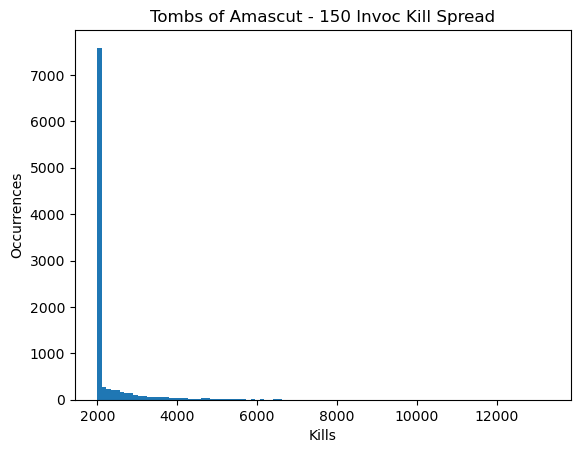

In [37]:
plt.figure()
plt.hist(toa_150_kill_df, bins=bin_num)
plt.xlabel("Kills")
plt.ylabel("Occurrences")
plt.title("Tombs of Amascut - 150 Invoc Kill Spread")
plt.savefig("images\\Tombs of Amascut - 150 Invoc Kill Spread.png")
plt.show()

In [38]:
toa_300_kill_df = pd.DataFrame(toa_300_kills)
toa_300_kill_df.describe()

0
count  10000.000000
mean    2017.711500
std      142.356335
min     2000.000000
25%     2000.000000
50%     2000.000000
75%     2000.000000
max     6003.000000

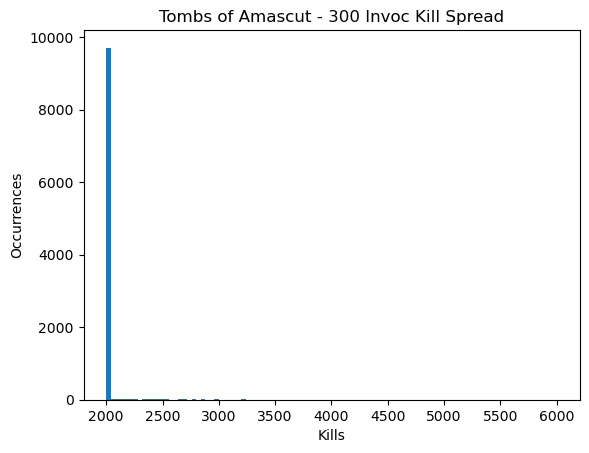

In [39]:
plt.figure()
plt.hist(toa_300_kill_df, bins=bin_num)
plt.xlabel("Kills")
plt.ylabel("Occurrences")
plt.title("Tombs of Amascut - 300 Invoc Kill Spread")
plt.savefig("images\\Tombs of Amascut - 300 Invoc Kill Spread.png")
plt.show()

In [40]:
toa_500_kill_df = pd.DataFrame(toa_500_kills)
toa_500_kill_df.describe()

0
count  10000.0
mean    2000.0
std        0.0
min     2000.0
25%     2000.0
50%     2000.0
75%     2000.0
max     2000.0

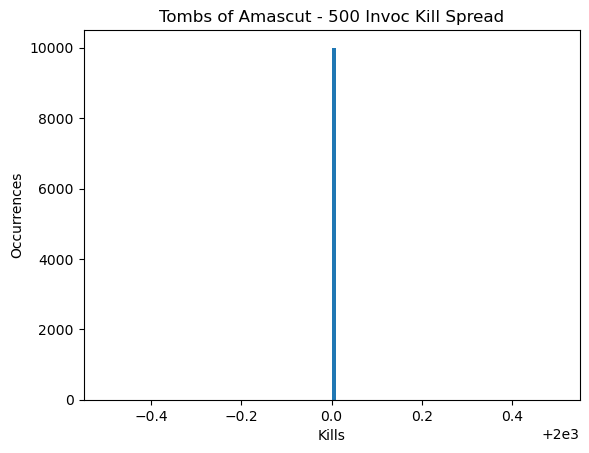

In [41]:
plt.figure()
plt.hist(toa_500_kill_df, bins=bin_num)
plt.xlabel("Kills")
plt.ylabel("Occurrences")
plt.title("Tombs of Amascut - 500 Invoc Kill Spread")
plt.savefig("images\\Tombs of Amascut - 500 Invoc Kill Spread.png")
plt.show()

In [42]:
# let's create a dictionary to hold all the stats we created from above
toa_stats = {"Boss Name" : ["Tombs of Amascut - 150 Invocation", "Tombs of Amascut - 300 Invocation", 
                            "Tombs of Amascut - 500 Invocation"], 
             "Average Kills" : [toa_150_avg, toa_300_avg, toa_500_avg], 
             "Lowest Kills": [toa_150_min, toa_300_min, toa_500_min], 
             "Highest Kills": [toa_150_max, toa_300_max, toa_500_max]}

# now let's turn it into a dataframe
toa_df = pd.DataFrame(toa_stats)

# did it work?
toa_df

Boss Name  Average Kills  Lowest Kills  \
0  Tombs of Amascut - 150 Invocation      2271.3666          2000   
1  Tombs of Amascut - 300 Invocation      2017.7115          2000   
2  Tombs of Amascut - 500 Invocation      2000.0000          2000   

   Highest Kills  
0          13290  
1           6003  
2           2000

In [43]:
greenlog_df = pd.concat([greenlog_df, toa_df], ignore_index = True)
greenlog_df

Boss Name  Average Kills Lowest Kills Highest Kills
0                  King Black Dragon      6216.7389          149         53910
1  Chambers of Xeric: Challenge Mode      2120.8676         2000          9229
2         Hard Mode Theatre of Blood      2023.7817         2000          4355
3  Tombs of Amascut - 150 Invocation      2271.3666         2000         13290
4  Tombs of Amascut - 300 Invocation      2017.7115         2000          6003
5  Tombs of Amascut - 500 Invocation      2000.0000         2000          2000

In [44]:
# let's identify the unique items that are needed for log completion
bandos_uniques = ['Pet general graardor', 'Bandos chestplate', 'Bandos tassets', 'Bandos boots',
                 "Bandos hilt", "Godsword shard 1", "Godsword shard 2", "Godsword shard 3"]

# now we'll push the items into a dataframe
bandos_log_df = pd.DataFrame(bandos_uniques, columns=['Items'])

# now we need a counter of sorts. Let's add a column and start it at 0
bandos_log_df['Amount Dropped'] = 0

# did it work?
bandos_log_df

Items  Amount Dropped
0  Pet general graardor               0
1     Bandos chestplate               0
2        Bandos tassets               0
3          Bandos boots               0
4           Bandos hilt               0
5      Godsword shard 1               0
6      Godsword shard 2               0
7      Godsword shard 3               0

In [45]:
# let's set an object that will grab 1 drop per kill
bandos_loot_table = RDSTable(count=1)

# let's add loot and assign probability to each one
# probabilities are relative to each other.

# uniques
bandos_loot_table.add_entry(RDSItem("Bandos chestplate", probability=.262))
bandos_loot_table.add_entry(RDSItem("Bandos tassets", probability=.262))
bandos_loot_table.add_entry(RDSItem("Bandos boots", probability=.262))
bandos_loot_table.add_entry(RDSItem("Bandos hilt", probability=.197))
bandos_loot_table.add_entry(RDSItem("Godsword shard 1", probability=.131))
bandos_loot_table.add_entry(RDSItem("Godsword shard 2", probability=.131))
bandos_loot_table.add_entry(RDSItem("Godsword shard 3", probability=.131))

# weapons and armour
bandos_loot_table.add_entry(RDSItem("Rune longsword", probability=6.3))
bandos_loot_table.add_entry(RDSItem("Rune 2h sword", probability=6.3))
bandos_loot_table.add_entry(RDSItem("Rune platebody", probability=6.3))
bandos_loot_table.add_entry(RDSItem("Rune pickaxe", probability=4.72))

# other
bandos_loot_table.add_entry(RDSItem("Coins (low range)", probability=25))
bandos_loot_table.add_entry(RDSItem("Grimy snapdragon", probability=6.3))
bandos_loot_table.add_entry(RDSItem("Snapdragon seed", probability=6.3))
bandos_loot_table.add_entry(RDSItem("Super restore(4)", probability=6.3))
bandos_loot_table.add_entry(RDSItem("Adamantite ore", probability=6.3))
bandos_loot_table.add_entry(RDSItem("Coal", probability=6.3))
bandos_loot_table.add_entry(RDSItem("Magic logs", probability=6.3))
bandos_loot_table.add_entry(RDSItem("Nature rune", probability=6.3))
bandos_loot_table.add_entry(RDSItem("Coins (high range)", probability=.984))


# these tables are separate, and have a chance to replace the dropped item
# despite the name, they are typically low value drops and have a chance to drop nothing
bandos_loot_table.add_entry(RDSItem("Rare Drop Table", probability=6.29))
bandos_loot_table.add_entry(RDSItem("Gem Drop Table", probability=1.57))

In [46]:
bandos_minion_loot_table = RDSTable(count=3)

bandos_minion_loot_table.add_entry(RDSItem("Bandos chestplate", probability=.00615))
bandos_minion_loot_table.add_entry(RDSItem("Bandos tassets", probability=.00615))
bandos_minion_loot_table.add_entry(RDSItem("Bandos boots", probability=.00615))
bandos_minion_loot_table.add_entry(RDSItem("Godsword shard 1", probability=.0656))
bandos_minion_loot_table.add_entry(RDSItem("Godsword shard 2", probability=.0656))
bandos_minion_loot_table.add_entry(RDSItem("Godsword shard 3", probability=.0656))

bandos_minion_loot_table.add_entry(RDSItem("Nothing", probability=99.78475))

In [47]:
# declare a list to store the number of kills per iteration
bandos_kills = []

# let's run the sim 10,000 times
for i in range(iters):
    # restart the kill number to 0 for each iteration over log completion
    kill = 0
    # we want the loop to run until the log is completed
    while True:
        # increase kill by 1
        kill += 1
        
        results = bandos_loot_table.rds_result
        
        # here are some tertiary drops that roll separately from everything else and can drop alongside
        # the rest of the loot
        
        # graardor pet drops at a 1/5000 rate. Let's assign that number on every kill
        pet_roll = random.randint(1, 5000)
        
        # run a check to see if this kill gave us the pet
        if pet_roll == 5000:
            # if it passed, append the drop to the results list
            results.append('Pet general graardor')
            
        # Graardor has 3 lieutenants in the room with him, killing them has a (drastically reduced)
        # odds of recieving that drop
        
        minion_results = bandos_minion_loot_table.rds_result
        for result in minion_results:
            if str(result) == "Bandos chestplate":
                results.append("Bandos chestplate")
                
            if str(result) == "Bandos tassets":
                results.append("Bandos tassets")
                
            if str(result) == "Bandos boots":
                results.append("Bandos boots")
                
            if str(result) == "Godsword shard 1":
                results.append("Godsword shard 1")
                
            if str(result) == "Godsword shard 2":
                results.append("Godsword shard 2")
                
            if str(result) == "Godsword shard 3":
                results.append("Godsword shard 3")
                
#         This section was for troubleshooting. Can uncomment if you want a printout of every drop until completion
#         print(f"Test {i+1} Kill {kill} loot:")
        
#         for drop in drops:
#             print(f"\t{drop}")
            
        for result in results:
#             print(f"\t{result}")

            # convert each item in the drop list to a string. rds library stores them as a list of objects, not strings
            result_conv = str(result)
            
            # check to see if the drop is in the collection log
            if result_conv in bandos_log_df['Items'].values:
                # if it is, grab the row index of that item
                location = bandos_log_df[bandos_log_df['Items']==result_conv].index.values
                # convert that index to an integer
                location = int(location)
                # pass the integer in so that we can increase the respective counter by 1 for each time the item drops
                bandos_log_df.at[location, 'Amount Dropped'] += 1
        # here we run a check to see if the log is completed (everything has been dropped atleast once)
        if bandos_log_df['Amount Dropped'].min() > 0:
            # append the kill number that the last unique was dropped. IE - Kill 900.
            bandos_kills.append(kill)
            # break out of the while loop when log is complete.
            break
            
    # when the log is complete, this will print a statement to let us know when the log was completed for that simulation
    print(f"Log {i+1} was completed in {kill} kills!")
    
    # reset the values to 0, and rerun the sim
    bandos_log_df['Amount Dropped'] = 0

Log 1 was completed in 24190 kills!
Log 2 was completed in 2430 kills!
Log 3 was completed in 3387 kills!
Log 4 was completed in 1164 kills!
Log 5 was completed in 4421 kills!
Log 6 was completed in 730 kills!
Log 7 was completed in 1256 kills!
Log 8 was completed in 3223 kills!
Log 9 was completed in 1246 kills!
Log 10 was completed in 1011 kills!
Log 11 was completed in 7845 kills!
Log 12 was completed in 3912 kills!
Log 13 was completed in 1038 kills!
Log 14 was completed in 9883 kills!
Log 15 was completed in 2615 kills!
Log 16 was completed in 10840 kills!
Log 17 was completed in 666 kills!
Log 18 was completed in 1060 kills!
Log 19 was completed in 3090 kills!
Log 20 was completed in 2937 kills!
Log 21 was completed in 12530 kills!
Log 22 was completed in 1057 kills!
Log 23 was completed in 5855 kills!
Log 24 was completed in 6516 kills!
Log 25 was completed in 1000 kills!
Log 26 was completed in 20830 kills!
Log 27 was completed in 917 kills!
Log 28 was completed in 3029 kills!


Log 227 was completed in 14057 kills!
Log 228 was completed in 1575 kills!
Log 229 was completed in 319 kills!
Log 230 was completed in 3263 kills!
Log 231 was completed in 7461 kills!
Log 232 was completed in 2014 kills!
Log 233 was completed in 6544 kills!
Log 234 was completed in 2597 kills!
Log 235 was completed in 2139 kills!
Log 236 was completed in 2885 kills!
Log 237 was completed in 2141 kills!
Log 238 was completed in 1438 kills!
Log 239 was completed in 7009 kills!
Log 240 was completed in 2685 kills!
Log 241 was completed in 13773 kills!
Log 242 was completed in 697 kills!
Log 243 was completed in 2074 kills!
Log 244 was completed in 4407 kills!
Log 245 was completed in 3527 kills!
Log 246 was completed in 4953 kills!
Log 247 was completed in 13562 kills!
Log 248 was completed in 1887 kills!
Log 249 was completed in 3353 kills!
Log 250 was completed in 13953 kills!
Log 251 was completed in 2713 kills!
Log 252 was completed in 1802 kills!
Log 253 was completed in 4154 kills!

Log 460 was completed in 4741 kills!
Log 461 was completed in 796 kills!
Log 462 was completed in 2861 kills!
Log 463 was completed in 3656 kills!
Log 464 was completed in 3621 kills!
Log 465 was completed in 876 kills!
Log 466 was completed in 1045 kills!
Log 467 was completed in 11944 kills!
Log 468 was completed in 1637 kills!
Log 469 was completed in 1225 kills!
Log 470 was completed in 498 kills!
Log 471 was completed in 4165 kills!
Log 472 was completed in 1957 kills!
Log 473 was completed in 5467 kills!
Log 474 was completed in 26187 kills!
Log 475 was completed in 601 kills!
Log 476 was completed in 806 kills!
Log 477 was completed in 5435 kills!
Log 478 was completed in 9938 kills!
Log 479 was completed in 1834 kills!
Log 480 was completed in 2449 kills!
Log 481 was completed in 2007 kills!
Log 482 was completed in 5978 kills!
Log 483 was completed in 8099 kills!
Log 484 was completed in 4282 kills!
Log 485 was completed in 4109 kills!
Log 486 was completed in 1087 kills!
Log 

Log 686 was completed in 19760 kills!
Log 687 was completed in 3781 kills!
Log 688 was completed in 615 kills!
Log 689 was completed in 13847 kills!
Log 690 was completed in 6407 kills!
Log 691 was completed in 2581 kills!
Log 692 was completed in 4564 kills!
Log 693 was completed in 355 kills!
Log 694 was completed in 1219 kills!
Log 695 was completed in 1529 kills!
Log 696 was completed in 8476 kills!
Log 697 was completed in 5073 kills!
Log 698 was completed in 9236 kills!
Log 699 was completed in 908 kills!
Log 700 was completed in 1285 kills!
Log 701 was completed in 1116 kills!
Log 702 was completed in 9739 kills!
Log 703 was completed in 1234 kills!
Log 704 was completed in 1351 kills!
Log 705 was completed in 1471 kills!
Log 706 was completed in 3982 kills!
Log 707 was completed in 15580 kills!
Log 708 was completed in 9067 kills!
Log 709 was completed in 2324 kills!
Log 710 was completed in 744 kills!
Log 711 was completed in 6330 kills!
Log 712 was completed in 19693 kills!
L

Log 927 was completed in 10362 kills!
Log 928 was completed in 3052 kills!
Log 929 was completed in 8685 kills!
Log 930 was completed in 5231 kills!
Log 931 was completed in 1322 kills!
Log 932 was completed in 2719 kills!
Log 933 was completed in 14739 kills!
Log 934 was completed in 16104 kills!
Log 935 was completed in 4283 kills!
Log 936 was completed in 4940 kills!
Log 937 was completed in 664 kills!
Log 938 was completed in 676 kills!
Log 939 was completed in 2189 kills!
Log 940 was completed in 2732 kills!
Log 941 was completed in 4280 kills!
Log 942 was completed in 1372 kills!
Log 943 was completed in 13582 kills!
Log 944 was completed in 1708 kills!
Log 945 was completed in 3510 kills!
Log 946 was completed in 7099 kills!
Log 947 was completed in 762 kills!
Log 948 was completed in 5041 kills!
Log 949 was completed in 1764 kills!
Log 950 was completed in 1926 kills!
Log 951 was completed in 957 kills!
Log 952 was completed in 1269 kills!
Log 953 was completed in 3789 kills!
L

Log 1156 was completed in 2329 kills!
Log 1157 was completed in 1444 kills!
Log 1158 was completed in 699 kills!
Log 1159 was completed in 23556 kills!
Log 1160 was completed in 4740 kills!
Log 1161 was completed in 5620 kills!
Log 1162 was completed in 7454 kills!
Log 1163 was completed in 2355 kills!
Log 1164 was completed in 2646 kills!
Log 1165 was completed in 2318 kills!
Log 1166 was completed in 15223 kills!
Log 1167 was completed in 1346 kills!
Log 1168 was completed in 3495 kills!
Log 1169 was completed in 1876 kills!
Log 1170 was completed in 8205 kills!
Log 1171 was completed in 2047 kills!
Log 1172 was completed in 4486 kills!
Log 1173 was completed in 2093 kills!
Log 1174 was completed in 1103 kills!
Log 1175 was completed in 2672 kills!
Log 1176 was completed in 448 kills!
Log 1177 was completed in 607 kills!
Log 1178 was completed in 747 kills!
Log 1179 was completed in 698 kills!
Log 1180 was completed in 2555 kills!
Log 1181 was completed in 6361 kills!
Log 1182 was co

Log 1395 was completed in 4530 kills!
Log 1396 was completed in 901 kills!
Log 1397 was completed in 9943 kills!
Log 1398 was completed in 9974 kills!
Log 1399 was completed in 1887 kills!
Log 1400 was completed in 1595 kills!
Log 1401 was completed in 15107 kills!
Log 1402 was completed in 8960 kills!
Log 1403 was completed in 5298 kills!
Log 1404 was completed in 2750 kills!
Log 1405 was completed in 29012 kills!
Log 1406 was completed in 3285 kills!
Log 1407 was completed in 9913 kills!
Log 1408 was completed in 4345 kills!
Log 1409 was completed in 11283 kills!
Log 1410 was completed in 5096 kills!
Log 1411 was completed in 2385 kills!
Log 1412 was completed in 9372 kills!
Log 1413 was completed in 6038 kills!
Log 1414 was completed in 2830 kills!
Log 1415 was completed in 4701 kills!
Log 1416 was completed in 2438 kills!
Log 1417 was completed in 8835 kills!
Log 1418 was completed in 6973 kills!
Log 1419 was completed in 5703 kills!
Log 1420 was completed in 4570 kills!
Log 1421 w

Log 1668 was completed in 2884 kills!
Log 1669 was completed in 27500 kills!
Log 1670 was completed in 1074 kills!
Log 1671 was completed in 7563 kills!
Log 1672 was completed in 689 kills!
Log 1673 was completed in 1579 kills!
Log 1674 was completed in 2478 kills!
Log 1675 was completed in 4566 kills!
Log 1676 was completed in 1990 kills!
Log 1677 was completed in 696 kills!
Log 1678 was completed in 6852 kills!
Log 1679 was completed in 3934 kills!
Log 1680 was completed in 5962 kills!
Log 1681 was completed in 638 kills!
Log 1682 was completed in 12419 kills!
Log 1683 was completed in 1405 kills!
Log 1684 was completed in 14083 kills!
Log 1685 was completed in 17595 kills!
Log 1686 was completed in 915 kills!
Log 1687 was completed in 1219 kills!
Log 1688 was completed in 1601 kills!
Log 1689 was completed in 3146 kills!
Log 1690 was completed in 1345 kills!
Log 1691 was completed in 23217 kills!
Log 1692 was completed in 3644 kills!
Log 1693 was completed in 667 kills!
Log 1694 was

Log 1884 was completed in 3689 kills!
Log 1885 was completed in 8617 kills!
Log 1886 was completed in 13100 kills!
Log 1887 was completed in 4342 kills!
Log 1888 was completed in 636 kills!
Log 1889 was completed in 3197 kills!
Log 1890 was completed in 1183 kills!
Log 1891 was completed in 6597 kills!
Log 1892 was completed in 8730 kills!
Log 1893 was completed in 7121 kills!
Log 1894 was completed in 1044 kills!
Log 1895 was completed in 1335 kills!
Log 1896 was completed in 8467 kills!
Log 1897 was completed in 8512 kills!
Log 1898 was completed in 19506 kills!
Log 1899 was completed in 11266 kills!
Log 1900 was completed in 355 kills!
Log 1901 was completed in 2133 kills!
Log 1902 was completed in 5557 kills!
Log 1903 was completed in 2256 kills!
Log 1904 was completed in 1040 kills!
Log 1905 was completed in 614 kills!
Log 1906 was completed in 7844 kills!
Log 1907 was completed in 2854 kills!
Log 1908 was completed in 2537 kills!
Log 1909 was completed in 6116 kills!
Log 1910 was

Log 2102 was completed in 1869 kills!
Log 2103 was completed in 3702 kills!
Log 2104 was completed in 6598 kills!
Log 2105 was completed in 3628 kills!
Log 2106 was completed in 1944 kills!
Log 2107 was completed in 11968 kills!
Log 2108 was completed in 1360 kills!
Log 2109 was completed in 1500 kills!
Log 2110 was completed in 761 kills!
Log 2111 was completed in 3829 kills!
Log 2112 was completed in 1269 kills!
Log 2113 was completed in 8208 kills!
Log 2114 was completed in 4813 kills!
Log 2115 was completed in 946 kills!
Log 2116 was completed in 10144 kills!
Log 2117 was completed in 3648 kills!
Log 2118 was completed in 5052 kills!
Log 2119 was completed in 848 kills!
Log 2120 was completed in 2927 kills!
Log 2121 was completed in 13041 kills!
Log 2122 was completed in 3425 kills!
Log 2123 was completed in 4474 kills!
Log 2124 was completed in 2926 kills!
Log 2125 was completed in 1677 kills!
Log 2126 was completed in 625 kills!
Log 2127 was completed in 1352 kills!
Log 2128 was 

Log 2326 was completed in 20292 kills!
Log 2327 was completed in 9978 kills!
Log 2328 was completed in 8653 kills!
Log 2329 was completed in 709 kills!
Log 2330 was completed in 1875 kills!
Log 2331 was completed in 6249 kills!
Log 2332 was completed in 1984 kills!
Log 2333 was completed in 4793 kills!
Log 2334 was completed in 21346 kills!
Log 2335 was completed in 7334 kills!
Log 2336 was completed in 765 kills!
Log 2337 was completed in 7590 kills!
Log 2338 was completed in 5845 kills!
Log 2339 was completed in 660 kills!
Log 2340 was completed in 15005 kills!
Log 2341 was completed in 4158 kills!
Log 2342 was completed in 2054 kills!
Log 2343 was completed in 9191 kills!
Log 2344 was completed in 5461 kills!
Log 2345 was completed in 1191 kills!
Log 2346 was completed in 5083 kills!
Log 2347 was completed in 603 kills!
Log 2348 was completed in 1005 kills!
Log 2349 was completed in 13413 kills!
Log 2350 was completed in 1267 kills!
Log 2351 was completed in 597 kills!
Log 2352 was 

Log 2544 was completed in 5864 kills!
Log 2545 was completed in 1831 kills!
Log 2546 was completed in 8087 kills!
Log 2547 was completed in 951 kills!
Log 2548 was completed in 8902 kills!
Log 2549 was completed in 2330 kills!
Log 2550 was completed in 14937 kills!
Log 2551 was completed in 7347 kills!
Log 2552 was completed in 7247 kills!
Log 2553 was completed in 13729 kills!
Log 2554 was completed in 575 kills!
Log 2555 was completed in 21172 kills!
Log 2556 was completed in 618 kills!
Log 2557 was completed in 4367 kills!
Log 2558 was completed in 591 kills!
Log 2559 was completed in 12405 kills!
Log 2560 was completed in 664 kills!
Log 2561 was completed in 6994 kills!
Log 2562 was completed in 6205 kills!
Log 2563 was completed in 1457 kills!
Log 2564 was completed in 857 kills!
Log 2565 was completed in 1220 kills!
Log 2566 was completed in 3567 kills!
Log 2567 was completed in 14325 kills!
Log 2568 was completed in 1427 kills!
Log 2569 was completed in 1478 kills!
Log 2570 was 

Log 2766 was completed in 18857 kills!
Log 2767 was completed in 9215 kills!
Log 2768 was completed in 1359 kills!
Log 2769 was completed in 3721 kills!
Log 2770 was completed in 3359 kills!
Log 2771 was completed in 5472 kills!
Log 2772 was completed in 1849 kills!
Log 2773 was completed in 8670 kills!
Log 2774 was completed in 5464 kills!
Log 2775 was completed in 15331 kills!
Log 2776 was completed in 971 kills!
Log 2777 was completed in 2234 kills!
Log 2778 was completed in 10352 kills!
Log 2779 was completed in 1441 kills!
Log 2780 was completed in 3505 kills!
Log 2781 was completed in 1825 kills!
Log 2782 was completed in 2446 kills!
Log 2783 was completed in 3361 kills!
Log 2784 was completed in 2268 kills!
Log 2785 was completed in 8514 kills!
Log 2786 was completed in 5160 kills!
Log 2787 was completed in 2188 kills!
Log 2788 was completed in 4217 kills!
Log 2789 was completed in 3321 kills!
Log 2790 was completed in 665 kills!
Log 2791 was completed in 1772 kills!
Log 2792 wa

Log 3002 was completed in 4769 kills!
Log 3003 was completed in 585 kills!
Log 3004 was completed in 1265 kills!
Log 3005 was completed in 3683 kills!
Log 3006 was completed in 1132 kills!
Log 3007 was completed in 800 kills!
Log 3008 was completed in 7387 kills!
Log 3009 was completed in 4587 kills!
Log 3010 was completed in 1211 kills!
Log 3011 was completed in 970 kills!
Log 3012 was completed in 2587 kills!
Log 3013 was completed in 2401 kills!
Log 3014 was completed in 9602 kills!
Log 3015 was completed in 6264 kills!
Log 3016 was completed in 3928 kills!
Log 3017 was completed in 822 kills!
Log 3018 was completed in 5666 kills!
Log 3019 was completed in 4447 kills!
Log 3020 was completed in 3864 kills!
Log 3021 was completed in 10690 kills!
Log 3022 was completed in 1922 kills!
Log 3023 was completed in 27872 kills!
Log 3024 was completed in 4103 kills!
Log 3025 was completed in 798 kills!
Log 3026 was completed in 6161 kills!
Log 3027 was completed in 4243 kills!
Log 3028 was co

Log 3236 was completed in 8001 kills!
Log 3237 was completed in 4700 kills!
Log 3238 was completed in 1059 kills!
Log 3239 was completed in 35064 kills!
Log 3240 was completed in 11418 kills!
Log 3241 was completed in 15142 kills!
Log 3242 was completed in 2066 kills!
Log 3243 was completed in 3895 kills!
Log 3244 was completed in 424 kills!
Log 3245 was completed in 1076 kills!
Log 3246 was completed in 2965 kills!
Log 3247 was completed in 5457 kills!
Log 3248 was completed in 2282 kills!
Log 3249 was completed in 2039 kills!
Log 3250 was completed in 2293 kills!
Log 3251 was completed in 1239 kills!
Log 3252 was completed in 3301 kills!
Log 3253 was completed in 2101 kills!
Log 3254 was completed in 1516 kills!
Log 3255 was completed in 3750 kills!
Log 3256 was completed in 15932 kills!
Log 3257 was completed in 2236 kills!
Log 3258 was completed in 1395 kills!
Log 3259 was completed in 11616 kills!
Log 3260 was completed in 23789 kills!
Log 3261 was completed in 4356 kills!
Log 326

Log 3453 was completed in 8464 kills!
Log 3454 was completed in 1328 kills!
Log 3455 was completed in 19707 kills!
Log 3456 was completed in 3358 kills!
Log 3457 was completed in 1082 kills!
Log 3458 was completed in 720 kills!
Log 3459 was completed in 2823 kills!
Log 3460 was completed in 3317 kills!
Log 3461 was completed in 5713 kills!
Log 3462 was completed in 5172 kills!
Log 3463 was completed in 8543 kills!
Log 3464 was completed in 11750 kills!
Log 3465 was completed in 5013 kills!
Log 3466 was completed in 3729 kills!
Log 3467 was completed in 1488 kills!
Log 3468 was completed in 1101 kills!
Log 3469 was completed in 539 kills!
Log 3470 was completed in 10173 kills!
Log 3471 was completed in 9315 kills!
Log 3472 was completed in 5606 kills!
Log 3473 was completed in 2411 kills!
Log 3474 was completed in 1502 kills!
Log 3475 was completed in 1470 kills!
Log 3476 was completed in 2164 kills!
Log 3477 was completed in 15131 kills!
Log 3478 was completed in 966 kills!
Log 3479 wa

Log 3681 was completed in 2245 kills!
Log 3682 was completed in 550 kills!
Log 3683 was completed in 10144 kills!
Log 3684 was completed in 4408 kills!
Log 3685 was completed in 3007 kills!
Log 3686 was completed in 18558 kills!
Log 3687 was completed in 2631 kills!
Log 3688 was completed in 10718 kills!
Log 3689 was completed in 485 kills!
Log 3690 was completed in 1026 kills!
Log 3691 was completed in 9309 kills!
Log 3692 was completed in 8654 kills!
Log 3693 was completed in 1001 kills!
Log 3694 was completed in 7252 kills!
Log 3695 was completed in 3723 kills!
Log 3696 was completed in 1554 kills!
Log 3697 was completed in 7453 kills!
Log 3698 was completed in 987 kills!
Log 3699 was completed in 28827 kills!
Log 3700 was completed in 783 kills!
Log 3701 was completed in 8064 kills!
Log 3702 was completed in 18830 kills!
Log 3703 was completed in 6004 kills!
Log 3704 was completed in 7363 kills!
Log 3705 was completed in 1196 kills!
Log 3706 was completed in 5772 kills!
Log 3707 wa

Log 3899 was completed in 2267 kills!
Log 3900 was completed in 2039 kills!
Log 3901 was completed in 2332 kills!
Log 3902 was completed in 773 kills!
Log 3903 was completed in 4258 kills!
Log 3904 was completed in 2050 kills!
Log 3905 was completed in 1190 kills!
Log 3906 was completed in 16431 kills!
Log 3907 was completed in 12352 kills!
Log 3908 was completed in 3299 kills!
Log 3909 was completed in 5165 kills!
Log 3910 was completed in 4255 kills!
Log 3911 was completed in 4815 kills!
Log 3912 was completed in 2052 kills!
Log 3913 was completed in 1149 kills!
Log 3914 was completed in 1617 kills!
Log 3915 was completed in 1249 kills!
Log 3916 was completed in 1141 kills!
Log 3917 was completed in 2456 kills!
Log 3918 was completed in 797 kills!
Log 3919 was completed in 7145 kills!
Log 3920 was completed in 4115 kills!
Log 3921 was completed in 1223 kills!
Log 3922 was completed in 1532 kills!
Log 3923 was completed in 495 kills!
Log 3924 was completed in 5804 kills!
Log 3925 was 

Log 4147 was completed in 6624 kills!
Log 4148 was completed in 8175 kills!
Log 4149 was completed in 3488 kills!
Log 4150 was completed in 1645 kills!
Log 4151 was completed in 7709 kills!
Log 4152 was completed in 5052 kills!
Log 4153 was completed in 5440 kills!
Log 4154 was completed in 943 kills!
Log 4155 was completed in 8850 kills!
Log 4156 was completed in 5637 kills!
Log 4157 was completed in 7947 kills!
Log 4158 was completed in 884 kills!
Log 4159 was completed in 5192 kills!
Log 4160 was completed in 3456 kills!
Log 4161 was completed in 2195 kills!
Log 4162 was completed in 1590 kills!
Log 4163 was completed in 6154 kills!
Log 4164 was completed in 730 kills!
Log 4165 was completed in 4046 kills!
Log 4166 was completed in 1393 kills!
Log 4167 was completed in 8069 kills!
Log 4168 was completed in 12053 kills!
Log 4169 was completed in 1860 kills!
Log 4170 was completed in 6584 kills!
Log 4171 was completed in 4407 kills!
Log 4172 was completed in 10549 kills!
Log 4173 was 

Log 4391 was completed in 12932 kills!
Log 4392 was completed in 1982 kills!
Log 4393 was completed in 1670 kills!
Log 4394 was completed in 906 kills!
Log 4395 was completed in 1403 kills!
Log 4396 was completed in 1284 kills!
Log 4397 was completed in 9119 kills!
Log 4398 was completed in 14617 kills!
Log 4399 was completed in 778 kills!
Log 4400 was completed in 1145 kills!
Log 4401 was completed in 6830 kills!
Log 4402 was completed in 2905 kills!
Log 4403 was completed in 14050 kills!
Log 4404 was completed in 4414 kills!
Log 4405 was completed in 9309 kills!
Log 4406 was completed in 1300 kills!
Log 4407 was completed in 817 kills!
Log 4408 was completed in 4557 kills!
Log 4409 was completed in 2347 kills!
Log 4410 was completed in 1279 kills!
Log 4411 was completed in 13050 kills!
Log 4412 was completed in 2727 kills!
Log 4413 was completed in 11009 kills!
Log 4414 was completed in 2347 kills!
Log 4415 was completed in 1058 kills!
Log 4416 was completed in 2561 kills!
Log 4417 w

Log 4635 was completed in 10624 kills!
Log 4636 was completed in 5555 kills!
Log 4637 was completed in 728 kills!
Log 4638 was completed in 3268 kills!
Log 4639 was completed in 3336 kills!
Log 4640 was completed in 4656 kills!
Log 4641 was completed in 10129 kills!
Log 4642 was completed in 5727 kills!
Log 4643 was completed in 1263 kills!
Log 4644 was completed in 5796 kills!
Log 4645 was completed in 822 kills!
Log 4646 was completed in 2065 kills!
Log 4647 was completed in 1158 kills!
Log 4648 was completed in 7548 kills!
Log 4649 was completed in 15404 kills!
Log 4650 was completed in 6252 kills!
Log 4651 was completed in 11336 kills!
Log 4652 was completed in 3541 kills!
Log 4653 was completed in 3939 kills!
Log 4654 was completed in 593 kills!
Log 4655 was completed in 4888 kills!
Log 4656 was completed in 645 kills!
Log 4657 was completed in 2000 kills!
Log 4658 was completed in 3025 kills!
Log 4659 was completed in 810 kills!
Log 4660 was completed in 1916 kills!
Log 4661 was 

Log 4891 was completed in 10859 kills!
Log 4892 was completed in 6577 kills!
Log 4893 was completed in 4012 kills!
Log 4894 was completed in 1432 kills!
Log 4895 was completed in 3105 kills!
Log 4896 was completed in 3641 kills!
Log 4897 was completed in 35401 kills!
Log 4898 was completed in 3112 kills!
Log 4899 was completed in 7629 kills!
Log 4900 was completed in 3524 kills!
Log 4901 was completed in 519 kills!
Log 4902 was completed in 5442 kills!
Log 4903 was completed in 1556 kills!
Log 4904 was completed in 3555 kills!
Log 4905 was completed in 7542 kills!
Log 4906 was completed in 4909 kills!
Log 4907 was completed in 2023 kills!
Log 4908 was completed in 3022 kills!
Log 4909 was completed in 1725 kills!
Log 4910 was completed in 1503 kills!
Log 4911 was completed in 5110 kills!
Log 4912 was completed in 17399 kills!
Log 4913 was completed in 1071 kills!
Log 4914 was completed in 17964 kills!
Log 4915 was completed in 2688 kills!
Log 4916 was completed in 9024 kills!
Log 4917 

Log 5107 was completed in 13989 kills!
Log 5108 was completed in 3171 kills!
Log 5109 was completed in 1434 kills!
Log 5110 was completed in 5648 kills!
Log 5111 was completed in 8008 kills!
Log 5112 was completed in 3043 kills!
Log 5113 was completed in 7526 kills!
Log 5114 was completed in 606 kills!
Log 5115 was completed in 6668 kills!
Log 5116 was completed in 290 kills!
Log 5117 was completed in 1226 kills!
Log 5118 was completed in 692 kills!
Log 5119 was completed in 7279 kills!
Log 5120 was completed in 12861 kills!
Log 5121 was completed in 14727 kills!
Log 5122 was completed in 865 kills!
Log 5123 was completed in 957 kills!
Log 5124 was completed in 15603 kills!
Log 5125 was completed in 7670 kills!
Log 5126 was completed in 12287 kills!
Log 5127 was completed in 2017 kills!
Log 5128 was completed in 11418 kills!
Log 5129 was completed in 3705 kills!
Log 5130 was completed in 1145 kills!
Log 5131 was completed in 1882 kills!
Log 5132 was completed in 1268 kills!
Log 5133 wa

Log 5337 was completed in 2412 kills!
Log 5338 was completed in 1148 kills!
Log 5339 was completed in 1954 kills!
Log 5340 was completed in 19526 kills!
Log 5341 was completed in 8763 kills!
Log 5342 was completed in 751 kills!
Log 5343 was completed in 13144 kills!
Log 5344 was completed in 8266 kills!
Log 5345 was completed in 2627 kills!
Log 5346 was completed in 16546 kills!
Log 5347 was completed in 4382 kills!
Log 5348 was completed in 6542 kills!
Log 5349 was completed in 6993 kills!
Log 5350 was completed in 28234 kills!
Log 5351 was completed in 5921 kills!
Log 5352 was completed in 1194 kills!
Log 5353 was completed in 1930 kills!
Log 5354 was completed in 10888 kills!
Log 5355 was completed in 3503 kills!
Log 5356 was completed in 4276 kills!
Log 5357 was completed in 2619 kills!
Log 5358 was completed in 917 kills!
Log 5359 was completed in 1246 kills!
Log 5360 was completed in 6344 kills!
Log 5361 was completed in 15403 kills!
Log 5362 was completed in 3683 kills!
Log 5363

Log 5569 was completed in 10662 kills!
Log 5570 was completed in 362 kills!
Log 5571 was completed in 7725 kills!
Log 5572 was completed in 624 kills!
Log 5573 was completed in 4863 kills!
Log 5574 was completed in 11411 kills!
Log 5575 was completed in 6841 kills!
Log 5576 was completed in 1442 kills!
Log 5577 was completed in 2874 kills!
Log 5578 was completed in 15210 kills!
Log 5579 was completed in 9927 kills!
Log 5580 was completed in 8191 kills!
Log 5581 was completed in 5061 kills!
Log 5582 was completed in 5745 kills!
Log 5583 was completed in 7288 kills!
Log 5584 was completed in 2530 kills!
Log 5585 was completed in 1742 kills!
Log 5586 was completed in 2125 kills!
Log 5587 was completed in 5424 kills!
Log 5588 was completed in 1442 kills!
Log 5589 was completed in 2768 kills!
Log 5590 was completed in 19390 kills!
Log 5591 was completed in 24059 kills!
Log 5592 was completed in 13015 kills!
Log 5593 was completed in 2931 kills!
Log 5594 was completed in 1747 kills!
Log 5595

Log 5786 was completed in 4044 kills!
Log 5787 was completed in 11662 kills!
Log 5788 was completed in 2829 kills!
Log 5789 was completed in 2230 kills!
Log 5790 was completed in 13043 kills!
Log 5791 was completed in 2379 kills!
Log 5792 was completed in 3170 kills!
Log 5793 was completed in 5389 kills!
Log 5794 was completed in 6262 kills!
Log 5795 was completed in 1156 kills!
Log 5796 was completed in 3626 kills!
Log 5797 was completed in 5636 kills!
Log 5798 was completed in 6490 kills!
Log 5799 was completed in 14267 kills!
Log 5800 was completed in 1555 kills!
Log 5801 was completed in 1663 kills!
Log 5802 was completed in 6810 kills!
Log 5803 was completed in 728 kills!
Log 5804 was completed in 1014 kills!
Log 5805 was completed in 1255 kills!
Log 5806 was completed in 3737 kills!
Log 5807 was completed in 3670 kills!
Log 5808 was completed in 17699 kills!
Log 5809 was completed in 2573 kills!
Log 5810 was completed in 1708 kills!
Log 5811 was completed in 10047 kills!
Log 5812

Log 6035 was completed in 3015 kills!
Log 6036 was completed in 14156 kills!
Log 6037 was completed in 3661 kills!
Log 6038 was completed in 2898 kills!
Log 6039 was completed in 2823 kills!
Log 6040 was completed in 1439 kills!
Log 6041 was completed in 11995 kills!
Log 6042 was completed in 7999 kills!
Log 6043 was completed in 4156 kills!
Log 6044 was completed in 10603 kills!
Log 6045 was completed in 8544 kills!
Log 6046 was completed in 2413 kills!
Log 6047 was completed in 5351 kills!
Log 6048 was completed in 5305 kills!
Log 6049 was completed in 2000 kills!
Log 6050 was completed in 1301 kills!
Log 6051 was completed in 10478 kills!
Log 6052 was completed in 1933 kills!
Log 6053 was completed in 2943 kills!
Log 6054 was completed in 1373 kills!
Log 6055 was completed in 548 kills!
Log 6056 was completed in 2350 kills!
Log 6057 was completed in 573 kills!
Log 6058 was completed in 4354 kills!
Log 6059 was completed in 6699 kills!
Log 6060 was completed in 999 kills!
Log 6061 wa

Log 6254 was completed in 11243 kills!
Log 6255 was completed in 17492 kills!
Log 6256 was completed in 2499 kills!
Log 6257 was completed in 1445 kills!
Log 6258 was completed in 706 kills!
Log 6259 was completed in 3650 kills!
Log 6260 was completed in 7250 kills!
Log 6261 was completed in 7623 kills!
Log 6262 was completed in 1630 kills!
Log 6263 was completed in 4681 kills!
Log 6264 was completed in 3668 kills!
Log 6265 was completed in 3039 kills!
Log 6266 was completed in 12003 kills!
Log 6267 was completed in 3604 kills!
Log 6268 was completed in 6287 kills!
Log 6269 was completed in 1511 kills!
Log 6270 was completed in 1614 kills!
Log 6271 was completed in 9219 kills!
Log 6272 was completed in 10274 kills!
Log 6273 was completed in 10133 kills!
Log 6274 was completed in 14813 kills!
Log 6275 was completed in 2177 kills!
Log 6276 was completed in 5914 kills!
Log 6277 was completed in 1895 kills!
Log 6278 was completed in 3832 kills!
Log 6279 was completed in 3490 kills!
Log 628

Log 6525 was completed in 14047 kills!
Log 6526 was completed in 2477 kills!
Log 6527 was completed in 4815 kills!
Log 6528 was completed in 12595 kills!
Log 6529 was completed in 1180 kills!
Log 6530 was completed in 2095 kills!
Log 6531 was completed in 6491 kills!
Log 6532 was completed in 1091 kills!
Log 6533 was completed in 4533 kills!
Log 6534 was completed in 10488 kills!
Log 6535 was completed in 14997 kills!
Log 6536 was completed in 2777 kills!
Log 6537 was completed in 5258 kills!
Log 6538 was completed in 903 kills!
Log 6539 was completed in 3244 kills!
Log 6540 was completed in 520 kills!
Log 6541 was completed in 3101 kills!
Log 6542 was completed in 2966 kills!
Log 6543 was completed in 5419 kills!
Log 6544 was completed in 7290 kills!
Log 6545 was completed in 5527 kills!
Log 6546 was completed in 1604 kills!
Log 6547 was completed in 856 kills!
Log 6548 was completed in 3391 kills!
Log 6549 was completed in 2601 kills!
Log 6550 was completed in 3002 kills!
Log 6551 wa

Log 6759 was completed in 8317 kills!
Log 6760 was completed in 913 kills!
Log 6761 was completed in 7518 kills!
Log 6762 was completed in 758 kills!
Log 6763 was completed in 3274 kills!
Log 6764 was completed in 5070 kills!
Log 6765 was completed in 11210 kills!
Log 6766 was completed in 3665 kills!
Log 6767 was completed in 1218 kills!
Log 6768 was completed in 2383 kills!
Log 6769 was completed in 6850 kills!
Log 6770 was completed in 10503 kills!
Log 6771 was completed in 483 kills!
Log 6772 was completed in 5925 kills!
Log 6773 was completed in 6630 kills!
Log 6774 was completed in 12169 kills!
Log 6775 was completed in 2672 kills!
Log 6776 was completed in 9041 kills!
Log 6777 was completed in 2012 kills!
Log 6778 was completed in 4460 kills!
Log 6779 was completed in 4751 kills!
Log 6780 was completed in 13546 kills!
Log 6781 was completed in 1834 kills!
Log 6782 was completed in 7721 kills!
Log 6783 was completed in 2882 kills!
Log 6784 was completed in 7523 kills!
Log 6785 wa

Log 7015 was completed in 6211 kills!
Log 7016 was completed in 1616 kills!
Log 7017 was completed in 8686 kills!
Log 7018 was completed in 9540 kills!
Log 7019 was completed in 6725 kills!
Log 7020 was completed in 4996 kills!
Log 7021 was completed in 2626 kills!
Log 7022 was completed in 1147 kills!
Log 7023 was completed in 15562 kills!
Log 7024 was completed in 1658 kills!
Log 7025 was completed in 1309 kills!
Log 7026 was completed in 12327 kills!
Log 7027 was completed in 3488 kills!
Log 7028 was completed in 9928 kills!
Log 7029 was completed in 3254 kills!
Log 7030 was completed in 1688 kills!
Log 7031 was completed in 1199 kills!
Log 7032 was completed in 8190 kills!
Log 7033 was completed in 2717 kills!
Log 7034 was completed in 734 kills!
Log 7035 was completed in 10649 kills!
Log 7036 was completed in 2440 kills!
Log 7037 was completed in 3301 kills!
Log 7038 was completed in 4989 kills!
Log 7039 was completed in 4660 kills!
Log 7040 was completed in 671 kills!
Log 7041 wa

Log 7235 was completed in 7096 kills!
Log 7236 was completed in 9224 kills!
Log 7237 was completed in 762 kills!
Log 7238 was completed in 8227 kills!
Log 7239 was completed in 6915 kills!
Log 7240 was completed in 4161 kills!
Log 7241 was completed in 17778 kills!
Log 7242 was completed in 3987 kills!
Log 7243 was completed in 5274 kills!
Log 7244 was completed in 1336 kills!
Log 7245 was completed in 1884 kills!
Log 7246 was completed in 4468 kills!
Log 7247 was completed in 1011 kills!
Log 7248 was completed in 5676 kills!
Log 7249 was completed in 11983 kills!
Log 7250 was completed in 2720 kills!
Log 7251 was completed in 2782 kills!
Log 7252 was completed in 4207 kills!
Log 7253 was completed in 4282 kills!
Log 7254 was completed in 1781 kills!
Log 7255 was completed in 10075 kills!
Log 7256 was completed in 3013 kills!
Log 7257 was completed in 5372 kills!
Log 7258 was completed in 1648 kills!
Log 7259 was completed in 7229 kills!
Log 7260 was completed in 8882 kills!
Log 7261 w

Log 7451 was completed in 7309 kills!
Log 7452 was completed in 11021 kills!
Log 7453 was completed in 3299 kills!
Log 7454 was completed in 40410 kills!
Log 7455 was completed in 918 kills!
Log 7456 was completed in 13468 kills!
Log 7457 was completed in 2242 kills!
Log 7458 was completed in 2449 kills!
Log 7459 was completed in 2618 kills!
Log 7460 was completed in 9846 kills!
Log 7461 was completed in 8327 kills!
Log 7462 was completed in 2698 kills!
Log 7463 was completed in 4967 kills!
Log 7464 was completed in 1484 kills!
Log 7465 was completed in 14508 kills!
Log 7466 was completed in 1502 kills!
Log 7467 was completed in 1331 kills!
Log 7468 was completed in 8916 kills!
Log 7469 was completed in 1713 kills!
Log 7470 was completed in 11091 kills!
Log 7471 was completed in 10163 kills!
Log 7472 was completed in 2223 kills!
Log 7473 was completed in 4645 kills!
Log 7474 was completed in 2501 kills!
Log 7475 was completed in 4189 kills!
Log 7476 was completed in 6484 kills!
Log 747

Log 7668 was completed in 13862 kills!
Log 7669 was completed in 1516 kills!
Log 7670 was completed in 707 kills!
Log 7671 was completed in 4387 kills!
Log 7672 was completed in 18783 kills!
Log 7673 was completed in 1232 kills!
Log 7674 was completed in 3641 kills!
Log 7675 was completed in 881 kills!
Log 7676 was completed in 14624 kills!
Log 7677 was completed in 5371 kills!
Log 7678 was completed in 3690 kills!
Log 7679 was completed in 2716 kills!
Log 7680 was completed in 2723 kills!
Log 7681 was completed in 6936 kills!
Log 7682 was completed in 918 kills!
Log 7683 was completed in 606 kills!
Log 7684 was completed in 1677 kills!
Log 7685 was completed in 8973 kills!
Log 7686 was completed in 5771 kills!
Log 7687 was completed in 4839 kills!
Log 7688 was completed in 4719 kills!
Log 7689 was completed in 9144 kills!
Log 7690 was completed in 1125 kills!
Log 7691 was completed in 1316 kills!
Log 7692 was completed in 10144 kills!
Log 7693 was completed in 997 kills!
Log 7694 was 

Log 7890 was completed in 2724 kills!
Log 7891 was completed in 954 kills!
Log 7892 was completed in 822 kills!
Log 7893 was completed in 13557 kills!
Log 7894 was completed in 2103 kills!
Log 7895 was completed in 4924 kills!
Log 7896 was completed in 1009 kills!
Log 7897 was completed in 1923 kills!
Log 7898 was completed in 4086 kills!
Log 7899 was completed in 624 kills!
Log 7900 was completed in 11216 kills!
Log 7901 was completed in 10307 kills!
Log 7902 was completed in 1043 kills!
Log 7903 was completed in 1431 kills!
Log 7904 was completed in 10503 kills!
Log 7905 was completed in 7877 kills!
Log 7906 was completed in 5460 kills!
Log 7907 was completed in 8165 kills!
Log 7908 was completed in 4260 kills!
Log 7909 was completed in 1519 kills!
Log 7910 was completed in 1452 kills!
Log 7911 was completed in 3548 kills!
Log 7912 was completed in 5452 kills!
Log 7913 was completed in 7388 kills!
Log 7914 was completed in 2569 kills!
Log 7915 was completed in 4014 kills!
Log 7916 wa

Log 8149 was completed in 3931 kills!
Log 8150 was completed in 6448 kills!
Log 8151 was completed in 3279 kills!
Log 8152 was completed in 1364 kills!
Log 8153 was completed in 13110 kills!
Log 8154 was completed in 5746 kills!
Log 8155 was completed in 10363 kills!
Log 8156 was completed in 17878 kills!
Log 8157 was completed in 12462 kills!
Log 8158 was completed in 3531 kills!
Log 8159 was completed in 6830 kills!
Log 8160 was completed in 18413 kills!
Log 8161 was completed in 738 kills!
Log 8162 was completed in 3377 kills!
Log 8163 was completed in 2387 kills!
Log 8164 was completed in 16648 kills!
Log 8165 was completed in 2116 kills!
Log 8166 was completed in 3836 kills!
Log 8167 was completed in 5595 kills!
Log 8168 was completed in 4507 kills!
Log 8169 was completed in 7570 kills!
Log 8170 was completed in 6159 kills!
Log 8171 was completed in 6093 kills!
Log 8172 was completed in 855 kills!
Log 8173 was completed in 2918 kills!
Log 8174 was completed in 1013 kills!
Log 8175

Log 8395 was completed in 1031 kills!
Log 8396 was completed in 1610 kills!
Log 8397 was completed in 1586 kills!
Log 8398 was completed in 5753 kills!
Log 8399 was completed in 4873 kills!
Log 8400 was completed in 6490 kills!
Log 8401 was completed in 6943 kills!
Log 8402 was completed in 10409 kills!
Log 8403 was completed in 5322 kills!
Log 8404 was completed in 3291 kills!
Log 8405 was completed in 8847 kills!
Log 8406 was completed in 4131 kills!
Log 8407 was completed in 3672 kills!
Log 8408 was completed in 9643 kills!
Log 8409 was completed in 18402 kills!
Log 8410 was completed in 739 kills!
Log 8411 was completed in 2765 kills!
Log 8412 was completed in 9162 kills!
Log 8413 was completed in 8314 kills!
Log 8414 was completed in 1419 kills!
Log 8415 was completed in 3746 kills!
Log 8416 was completed in 987 kills!
Log 8417 was completed in 4033 kills!
Log 8418 was completed in 836 kills!
Log 8419 was completed in 2422 kills!
Log 8420 was completed in 5202 kills!
Log 8421 was 

Log 8639 was completed in 15916 kills!
Log 8640 was completed in 3783 kills!
Log 8641 was completed in 6249 kills!
Log 8642 was completed in 2847 kills!
Log 8643 was completed in 6243 kills!
Log 8644 was completed in 6698 kills!
Log 8645 was completed in 6066 kills!
Log 8646 was completed in 6369 kills!
Log 8647 was completed in 5711 kills!
Log 8648 was completed in 4197 kills!
Log 8649 was completed in 32625 kills!
Log 8650 was completed in 978 kills!
Log 8651 was completed in 2799 kills!
Log 8652 was completed in 2095 kills!
Log 8653 was completed in 1156 kills!
Log 8654 was completed in 2306 kills!
Log 8655 was completed in 4128 kills!
Log 8656 was completed in 4341 kills!
Log 8657 was completed in 849 kills!
Log 8658 was completed in 14620 kills!
Log 8659 was completed in 1179 kills!
Log 8660 was completed in 14426 kills!
Log 8661 was completed in 4872 kills!
Log 8662 was completed in 961 kills!
Log 8663 was completed in 3067 kills!
Log 8664 was completed in 924 kills!
Log 8665 was

Log 8884 was completed in 30408 kills!
Log 8885 was completed in 15667 kills!
Log 8886 was completed in 11150 kills!
Log 8887 was completed in 35111 kills!
Log 8888 was completed in 6287 kills!
Log 8889 was completed in 1116 kills!
Log 8890 was completed in 3251 kills!
Log 8891 was completed in 5340 kills!
Log 8892 was completed in 323 kills!
Log 8893 was completed in 4495 kills!
Log 8894 was completed in 11273 kills!
Log 8895 was completed in 1983 kills!
Log 8896 was completed in 4704 kills!
Log 8897 was completed in 13614 kills!
Log 8898 was completed in 1304 kills!
Log 8899 was completed in 5189 kills!
Log 8900 was completed in 6700 kills!
Log 8901 was completed in 3373 kills!
Log 8902 was completed in 1629 kills!
Log 8903 was completed in 4004 kills!
Log 8904 was completed in 1673 kills!
Log 8905 was completed in 2510 kills!
Log 8906 was completed in 1352 kills!
Log 8907 was completed in 3623 kills!
Log 8908 was completed in 4764 kills!
Log 8909 was completed in 6518 kills!
Log 891

Log 9107 was completed in 2803 kills!
Log 9108 was completed in 488 kills!
Log 9109 was completed in 2444 kills!
Log 9110 was completed in 4146 kills!
Log 9111 was completed in 9315 kills!
Log 9112 was completed in 5200 kills!
Log 9113 was completed in 4810 kills!
Log 9114 was completed in 825 kills!
Log 9115 was completed in 4548 kills!
Log 9116 was completed in 3774 kills!
Log 9117 was completed in 2837 kills!
Log 9118 was completed in 12357 kills!
Log 9119 was completed in 890 kills!
Log 9120 was completed in 4059 kills!
Log 9121 was completed in 14009 kills!
Log 9122 was completed in 15776 kills!
Log 9123 was completed in 6305 kills!
Log 9124 was completed in 4192 kills!
Log 9125 was completed in 1824 kills!
Log 9126 was completed in 15352 kills!
Log 9127 was completed in 1242 kills!
Log 9128 was completed in 3327 kills!
Log 9129 was completed in 2157 kills!
Log 9130 was completed in 1839 kills!
Log 9131 was completed in 9630 kills!
Log 9132 was completed in 24824 kills!
Log 9133 w

Log 9337 was completed in 13474 kills!
Log 9338 was completed in 3063 kills!
Log 9339 was completed in 5133 kills!
Log 9340 was completed in 9357 kills!
Log 9341 was completed in 3561 kills!
Log 9342 was completed in 4414 kills!
Log 9343 was completed in 8533 kills!
Log 9344 was completed in 3043 kills!
Log 9345 was completed in 3303 kills!
Log 9346 was completed in 1047 kills!
Log 9347 was completed in 6421 kills!
Log 9348 was completed in 1611 kills!
Log 9349 was completed in 3569 kills!
Log 9350 was completed in 6307 kills!
Log 9351 was completed in 14780 kills!
Log 9352 was completed in 4412 kills!
Log 9353 was completed in 13878 kills!
Log 9354 was completed in 1264 kills!
Log 9355 was completed in 2806 kills!
Log 9356 was completed in 14821 kills!
Log 9357 was completed in 2788 kills!
Log 9358 was completed in 1470 kills!
Log 9359 was completed in 6009 kills!
Log 9360 was completed in 5121 kills!
Log 9361 was completed in 3620 kills!
Log 9362 was completed in 4840 kills!
Log 9363

Log 9610 was completed in 5211 kills!
Log 9611 was completed in 13148 kills!
Log 9612 was completed in 3370 kills!
Log 9613 was completed in 4300 kills!
Log 9614 was completed in 3805 kills!
Log 9615 was completed in 2450 kills!
Log 9616 was completed in 8682 kills!
Log 9617 was completed in 4513 kills!
Log 9618 was completed in 1796 kills!
Log 9619 was completed in 766 kills!
Log 9620 was completed in 4661 kills!
Log 9621 was completed in 1611 kills!
Log 9622 was completed in 991 kills!
Log 9623 was completed in 6019 kills!
Log 9624 was completed in 3513 kills!
Log 9625 was completed in 3036 kills!
Log 9626 was completed in 13460 kills!
Log 9627 was completed in 3377 kills!
Log 9628 was completed in 4110 kills!
Log 9629 was completed in 581 kills!
Log 9630 was completed in 3328 kills!
Log 9631 was completed in 445 kills!
Log 9632 was completed in 1001 kills!
Log 9633 was completed in 2417 kills!
Log 9634 was completed in 1477 kills!
Log 9635 was completed in 15994 kills!
Log 9636 was 

Log 9826 was completed in 1450 kills!
Log 9827 was completed in 7605 kills!
Log 9828 was completed in 998 kills!
Log 9829 was completed in 8312 kills!
Log 9830 was completed in 11951 kills!
Log 9831 was completed in 1058 kills!
Log 9832 was completed in 15175 kills!
Log 9833 was completed in 1577 kills!
Log 9834 was completed in 1424 kills!
Log 9835 was completed in 844 kills!
Log 9836 was completed in 1031 kills!
Log 9837 was completed in 2899 kills!
Log 9838 was completed in 2334 kills!
Log 9839 was completed in 21224 kills!
Log 9840 was completed in 1441 kills!
Log 9841 was completed in 1681 kills!
Log 9842 was completed in 14849 kills!
Log 9843 was completed in 8857 kills!
Log 9844 was completed in 4106 kills!
Log 9845 was completed in 3540 kills!
Log 9846 was completed in 3650 kills!
Log 9847 was completed in 18239 kills!
Log 9848 was completed in 9144 kills!
Log 9849 was completed in 4412 kills!
Log 9850 was completed in 2532 kills!
Log 9851 was completed in 6960 kills!
Log 9852 

In [48]:
# sort the kills list
bandos_kills.sort()

# let's find the average kills it takes to green log the boss from our simulations
bandos_avg = (sum(bandos_kills) / len(bandos_kills))

# here's the lowest killcount for log completion from our simulations
bandos_min = bandos_kills[0]

# here's the highest killcount for log completion from our simulations
bandos_max = bandos_kills[-1]

# some stat printouts
print("General Graardor Loot Stats")
print(f"\tFastest Completion - {bandos_min}")
print(f"\tSlowest Completion - {bandos_max}")
print(f"\tAverage Completion - {bandos_avg}")

General Graardor Loot Stats
	Fastest Completion - 169
	Slowest Completion - 50361
	Average Completion - 5161.8727


In [49]:
bandos_kill_df = pd.DataFrame(bandos_kills)
bandos_kill_df.describe()

0
count  10000.000000
mean    5161.872700
std     5029.051356
min      169.000000
25%     1613.000000
50%     3501.000000
75%     7003.000000
max    50361.000000

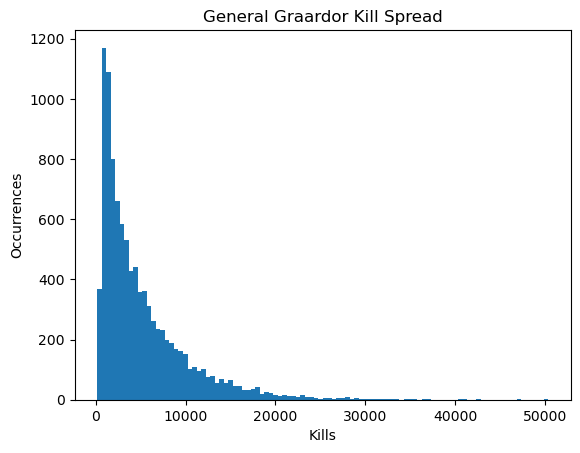

In [50]:
plt.figure()
plt.hist(bandos_kill_df, bins=bin_num)
plt.xlabel("Kills")
plt.ylabel("Occurrences")
plt.title("General Graardor Kill Spread")
plt.savefig("images\\General Graardor Kill Spread.png")
plt.show()

In [51]:
# let's create a dictionary to hold all the stats we created from above
bandos_stats = {"Boss Name" : ["General Graardor"], 
             "Average Kills" : [bandos_avg], 
             "Lowest Kills": [bandos_min], 
             "Highest Kills": [bandos_max]}

# now let's turn it into a dataframe
bandos_df = pd.DataFrame(bandos_stats)

# did it work?
bandos_df

Boss Name  Average Kills  Lowest Kills  Highest Kills
0  General Graardor      5161.8727           169          50361

In [52]:
greenlog_df = pd.concat([greenlog_df, bandos_df], ignore_index = True)
greenlog_df

Boss Name  Average Kills Lowest Kills Highest Kills
0                  King Black Dragon      6216.7389          149         53910
1  Chambers of Xeric: Challenge Mode      2120.8676         2000          9229
2         Hard Mode Theatre of Blood      2023.7817         2000          4355
3  Tombs of Amascut - 150 Invocation      2271.3666         2000         13290
4  Tombs of Amascut - 300 Invocation      2017.7115         2000          6003
5  Tombs of Amascut - 500 Invocation      2000.0000         2000          2000
6                   General Graardor      5161.8727          169         50361

In [53]:
# let's identify the unique items that are needed for log completion
zammy_uniques = ["Pet k'ril tsutsaroth", 'Staff of the dead', 'Zamorakian spear', 'Steam battlestaff',
                 "Zamorak hilt", "Godsword shard 1", "Godsword shard 2", "Godsword shard 3"]

# now we'll push the items into a dataframe
zammy_log_df = pd.DataFrame(zammy_uniques, columns=['Items'])

# now we need a counter of sorts. Let's add a column and start it at 0
zammy_log_df['Amount Dropped'] = 0

# did it work?
zammy_log_df

Items  Amount Dropped
0  Pet k'ril tsutsaroth               0
1     Staff of the dead               0
2      Zamorakian spear               0
3     Steam battlestaff               0
4          Zamorak hilt               0
5      Godsword shard 1               0
6      Godsword shard 2               0
7      Godsword shard 3               0

In [54]:
# let's set an object that will grab 1 drop per kill
zammy_loot_table = RDSTable(count=1)

# let's add loot and assign probability to each one
# probabilities are relative to each other.

# uniques
zammy_loot_table.add_entry(RDSItem("Staff of the dead", probability=.787))
zammy_loot_table.add_entry(RDSItem("Zamorakian spear", probability=.787))
zammy_loot_table.add_entry(RDSItem("Steam battlestaff", probability=.197))
zammy_loot_table.add_entry(RDSItem("Zamorak hilt", probability=.197))
zammy_loot_table.add_entry(RDSItem("Godsword shard 1", probability=.131))
zammy_loot_table.add_entry(RDSItem("Godsword shard 2", probability=.131))
zammy_loot_table.add_entry(RDSItem("Godsword shard 3", probability=.131))

# weapons and armour
zammy_loot_table.add_entry(RDSItem("Adamant arrow(p++)", probability=6.3))
zammy_loot_table.add_entry(RDSItem("Rune scimitar", probability=6.3))
zammy_loot_table.add_entry(RDSItem("Adamant platebody", probability=6.3))
zammy_loot_table.add_entry(RDSItem("Rune platelegs", probability=5.51))
zammy_loot_table.add_entry(RDSItem("Dragon dagger(p++)", probability=1.57))

# potions
zammy_loot_table.add_entry(RDSItem("Super attack(3)", probability=6.3))
zammy_loot_table.add_entry(RDSItem("Super restore(3)", probability=6.3))

# other
zammy_loot_table.add_entry(RDSItem("Coins", probability=28.9))
zammy_loot_table.add_entry(RDSItem("Grimy lantadyme", probability=6.3))
zammy_loot_table.add_entry(RDSItem("Lantadyme seed", probability=6.3))
zammy_loot_table.add_entry(RDSItem("Death rune", probability=6.3))
zammy_loot_table.add_entry(RDSItem("Blood rune", probability=6.3))


# these tables are separate, and have a chance to replace the dropped item
# despite the name, they are typically low value drops and have a chance to drop nothing
zammy_loot_table.add_entry(RDSItem("Rare Drop Table", probability=6.29))
zammy_loot_table.add_entry(RDSItem("Gem Drop Table", probability=1.57))

In [55]:
zammy_minion_loot_table = RDSTable(count=3)

zammy_minion_loot_table.add_entry(RDSItem("Zamorakian spear", probability=.0186))
zammy_minion_loot_table.add_entry(RDSItem("Godsword shard 1", probability=.0656))
zammy_minion_loot_table.add_entry(RDSItem("Godsword shard 2", probability=.0656))
zammy_minion_loot_table.add_entry(RDSItem("Godsword shard 3", probability=.0656))

zammy_minion_loot_table.add_entry(RDSItem("Nothing", probability=99.7846))

In [56]:
# declare a list to store the number of kills per iteration
zammy_kills = []

# let's run the sim 10,000 times
for i in range(iters):
    # restart the kill number to 0 for each iteration over log completion
    kill = 0
    # we want the loop to run until the log is completed
    while True:
        # increase kill by 1
        kill += 1
        
        results = zammy_loot_table.rds_result


        # here are some tertiary drops that roll separately from everything else and can drop alongside
        # the rest of the loot
        
        # k'ril pet drops at a 1/5000 rate. Let's assign that number on every kill
        pet_roll = random.randint(1, 5000)
        
        # run a check to see if this kill gave us the pet
        if pet_roll == 5000:
            # if it passed, append the drop to the results list
            results.append("Pet k'ril tsutsaroth")
            
        # K'ril has 3 lieutenants in the room with him, killing them has a (drastically reduced) 
        # odds of recieving that drop
        
        minion_results = zammy_minion_loot_table.rds_result
        for result in minion_results:
            if str(result) == "Zamorakian spear":
                results.append("Zamorakian spear")
                
            if str(result) == "Godsword shard 1":
                results.append("Godsword shard 1")
                
            if str(result) == "Godsword shard 2":
                results.append("Godsword shard 2")
                
            if str(result) == "Godsword shard 3":
                results.append("Godsword shard 3")
                
#         This section was for troubleshooting. Can uncomment if you want a printout of every drop until completion
#         print(f"Test {i+1} Kill {kill} loot:")
        
#         for drop in drops:
#             print(f"\t{drop}")
            
        for result in results:
#             print(f"\t{result}")

            # super strength and attack potions are dropped together, so here we add that 2nd drop in
            if str(result) == "Super attack(3)":
                results.append("Super strength(3)")
            # zamorak brew and super restore potions are dropped together, so here we add that 2nd drop in
            elif str(result) == "Super restore(3)":
                results.append("Zamorak brew(3)")

            # convert each item in the drop list to a string. rds library stores them as a list of objects, not strings
            result_conv = str(result)
            
            
            # check to see if the drop is in the collection log
            if result_conv in zammy_log_df['Items'].values:
                # if it is, grab the row index of that item
                location = zammy_log_df[zammy_log_df['Items']==result_conv].index.values
                # convert that index to an integer
                location = int(location)
                # pass the integer in so that we can increase the respective counter by 1 for each time the item drops
                zammy_log_df.at[location, 'Amount Dropped'] += 1
        # here we run a check to see if the log is completed (everything has been dropped atleast once)
        if zammy_log_df['Amount Dropped'].min() > 0:
            # append the kill number that the last unique was dropped. IE - Kill 900.
            zammy_kills.append(kill)
            # break out of the while loop when log is complete.
            break
            
    # when the log is complete, this will print a statement to let us know when the log was completed for that simulation
    print(f"Log {i+1} was completed in {kill} kills!")
    
    # reset the values to 0, and rerun the sim
    zammy_log_df['Amount Dropped'] = 0

Log 1 was completed in 898 kills!
Log 2 was completed in 1723 kills!
Log 3 was completed in 7295 kills!
Log 4 was completed in 1630 kills!
Log 5 was completed in 650 kills!
Log 6 was completed in 747 kills!
Log 7 was completed in 16835 kills!
Log 8 was completed in 12916 kills!
Log 9 was completed in 4530 kills!
Log 10 was completed in 12572 kills!
Log 11 was completed in 1774 kills!
Log 12 was completed in 11578 kills!
Log 13 was completed in 5929 kills!
Log 14 was completed in 3545 kills!
Log 15 was completed in 2946 kills!
Log 16 was completed in 2079 kills!
Log 17 was completed in 2250 kills!
Log 18 was completed in 10944 kills!
Log 19 was completed in 14230 kills!
Log 20 was completed in 3816 kills!
Log 21 was completed in 3979 kills!
Log 22 was completed in 2789 kills!
Log 23 was completed in 3290 kills!
Log 24 was completed in 3279 kills!
Log 25 was completed in 2314 kills!
Log 26 was completed in 11240 kills!
Log 27 was completed in 29308 kills!
Log 28 was completed in 1720 kil

Log 244 was completed in 13854 kills!
Log 245 was completed in 6277 kills!
Log 246 was completed in 22119 kills!
Log 247 was completed in 894 kills!
Log 248 was completed in 1371 kills!
Log 249 was completed in 5237 kills!
Log 250 was completed in 5170 kills!
Log 251 was completed in 8231 kills!
Log 252 was completed in 1350 kills!
Log 253 was completed in 2575 kills!
Log 254 was completed in 741 kills!
Log 255 was completed in 2634 kills!
Log 256 was completed in 10706 kills!
Log 257 was completed in 5772 kills!
Log 258 was completed in 895 kills!
Log 259 was completed in 2013 kills!
Log 260 was completed in 2478 kills!
Log 261 was completed in 7840 kills!
Log 262 was completed in 702 kills!
Log 263 was completed in 2177 kills!
Log 264 was completed in 2077 kills!
Log 265 was completed in 5719 kills!
Log 266 was completed in 1188 kills!
Log 267 was completed in 1941 kills!
Log 268 was completed in 18658 kills!
Log 269 was completed in 8311 kills!
Log 270 was completed in 3422 kills!
L

Log 471 was completed in 23761 kills!
Log 472 was completed in 1739 kills!
Log 473 was completed in 8293 kills!
Log 474 was completed in 7118 kills!
Log 475 was completed in 4491 kills!
Log 476 was completed in 1412 kills!
Log 477 was completed in 2319 kills!
Log 478 was completed in 2095 kills!
Log 479 was completed in 12937 kills!
Log 480 was completed in 729 kills!
Log 481 was completed in 2188 kills!
Log 482 was completed in 4867 kills!
Log 483 was completed in 2165 kills!
Log 484 was completed in 813 kills!
Log 485 was completed in 1506 kills!
Log 486 was completed in 1007 kills!
Log 487 was completed in 1416 kills!
Log 488 was completed in 1400 kills!
Log 489 was completed in 667 kills!
Log 490 was completed in 3411 kills!
Log 491 was completed in 5946 kills!
Log 492 was completed in 1499 kills!
Log 493 was completed in 5288 kills!
Log 494 was completed in 4551 kills!
Log 495 was completed in 11968 kills!
Log 496 was completed in 4855 kills!
Log 497 was completed in 11070 kills!


Log 710 was completed in 9456 kills!
Log 711 was completed in 3407 kills!
Log 712 was completed in 9229 kills!
Log 713 was completed in 6941 kills!
Log 714 was completed in 6000 kills!
Log 715 was completed in 1376 kills!
Log 716 was completed in 2455 kills!
Log 717 was completed in 621 kills!
Log 718 was completed in 747 kills!
Log 719 was completed in 460 kills!
Log 720 was completed in 8920 kills!
Log 721 was completed in 2251 kills!
Log 722 was completed in 2644 kills!
Log 723 was completed in 1630 kills!
Log 724 was completed in 1091 kills!
Log 725 was completed in 5799 kills!
Log 726 was completed in 4024 kills!
Log 727 was completed in 879 kills!
Log 728 was completed in 13453 kills!
Log 729 was completed in 4936 kills!
Log 730 was completed in 5086 kills!
Log 731 was completed in 5968 kills!
Log 732 was completed in 7687 kills!
Log 733 was completed in 9030 kills!
Log 734 was completed in 3329 kills!
Log 735 was completed in 2542 kills!
Log 736 was completed in 718 kills!
Log 7

Log 934 was completed in 2320 kills!
Log 935 was completed in 1590 kills!
Log 936 was completed in 10684 kills!
Log 937 was completed in 7772 kills!
Log 938 was completed in 1080 kills!
Log 939 was completed in 3477 kills!
Log 940 was completed in 1320 kills!
Log 941 was completed in 17839 kills!
Log 942 was completed in 10836 kills!
Log 943 was completed in 1341 kills!
Log 944 was completed in 4363 kills!
Log 945 was completed in 8371 kills!
Log 946 was completed in 13501 kills!
Log 947 was completed in 7534 kills!
Log 948 was completed in 613 kills!
Log 949 was completed in 9136 kills!
Log 950 was completed in 1095 kills!
Log 951 was completed in 1027 kills!
Log 952 was completed in 4369 kills!
Log 953 was completed in 3564 kills!
Log 954 was completed in 10625 kills!
Log 955 was completed in 3324 kills!
Log 956 was completed in 11430 kills!
Log 957 was completed in 9121 kills!
Log 958 was completed in 1974 kills!
Log 959 was completed in 1215 kills!
Log 960 was completed in 1516 kil

Log 1165 was completed in 7394 kills!
Log 1166 was completed in 796 kills!
Log 1167 was completed in 1212 kills!
Log 1168 was completed in 6028 kills!
Log 1169 was completed in 4945 kills!
Log 1170 was completed in 1889 kills!
Log 1171 was completed in 3942 kills!
Log 1172 was completed in 1342 kills!
Log 1173 was completed in 5976 kills!
Log 1174 was completed in 499 kills!
Log 1175 was completed in 1450 kills!
Log 1176 was completed in 6880 kills!
Log 1177 was completed in 3421 kills!
Log 1178 was completed in 6404 kills!
Log 1179 was completed in 2506 kills!
Log 1180 was completed in 4056 kills!
Log 1181 was completed in 1349 kills!
Log 1182 was completed in 24177 kills!
Log 1183 was completed in 8873 kills!
Log 1184 was completed in 4524 kills!
Log 1185 was completed in 2790 kills!
Log 1186 was completed in 3010 kills!
Log 1187 was completed in 1413 kills!
Log 1188 was completed in 5747 kills!
Log 1189 was completed in 4598 kills!
Log 1190 was completed in 8138 kills!
Log 1191 was 

Log 1414 was completed in 1358 kills!
Log 1415 was completed in 20194 kills!
Log 1416 was completed in 1944 kills!
Log 1417 was completed in 808 kills!
Log 1418 was completed in 4879 kills!
Log 1419 was completed in 2555 kills!
Log 1420 was completed in 3785 kills!
Log 1421 was completed in 744 kills!
Log 1422 was completed in 7161 kills!
Log 1423 was completed in 11825 kills!
Log 1424 was completed in 1058 kills!
Log 1425 was completed in 28599 kills!
Log 1426 was completed in 6569 kills!
Log 1427 was completed in 4865 kills!
Log 1428 was completed in 3362 kills!
Log 1429 was completed in 1478 kills!
Log 1430 was completed in 2396 kills!
Log 1431 was completed in 3770 kills!
Log 1432 was completed in 3211 kills!
Log 1433 was completed in 4859 kills!
Log 1434 was completed in 918 kills!
Log 1435 was completed in 11750 kills!
Log 1436 was completed in 7053 kills!
Log 1437 was completed in 2587 kills!
Log 1438 was completed in 3069 kills!
Log 1439 was completed in 1102 kills!
Log 1440 wa

Log 1633 was completed in 3495 kills!
Log 1634 was completed in 765 kills!
Log 1635 was completed in 3248 kills!
Log 1636 was completed in 16587 kills!
Log 1637 was completed in 619 kills!
Log 1638 was completed in 4646 kills!
Log 1639 was completed in 7331 kills!
Log 1640 was completed in 2149 kills!
Log 1641 was completed in 5191 kills!
Log 1642 was completed in 1155 kills!
Log 1643 was completed in 2388 kills!
Log 1644 was completed in 977 kills!
Log 1645 was completed in 702 kills!
Log 1646 was completed in 7666 kills!
Log 1647 was completed in 19133 kills!
Log 1648 was completed in 1627 kills!
Log 1649 was completed in 5500 kills!
Log 1650 was completed in 1789 kills!
Log 1651 was completed in 6369 kills!
Log 1652 was completed in 4827 kills!
Log 1653 was completed in 5552 kills!
Log 1654 was completed in 1344 kills!
Log 1655 was completed in 6958 kills!
Log 1656 was completed in 12548 kills!
Log 1657 was completed in 5015 kills!
Log 1658 was completed in 3983 kills!
Log 1659 was 

Log 1857 was completed in 7126 kills!
Log 1858 was completed in 6511 kills!
Log 1859 was completed in 10858 kills!
Log 1860 was completed in 8081 kills!
Log 1861 was completed in 653 kills!
Log 1862 was completed in 1912 kills!
Log 1863 was completed in 5378 kills!
Log 1864 was completed in 7062 kills!
Log 1865 was completed in 843 kills!
Log 1866 was completed in 2639 kills!
Log 1867 was completed in 2918 kills!
Log 1868 was completed in 4802 kills!
Log 1869 was completed in 1614 kills!
Log 1870 was completed in 690 kills!
Log 1871 was completed in 1535 kills!
Log 1872 was completed in 7667 kills!
Log 1873 was completed in 3415 kills!
Log 1874 was completed in 494 kills!
Log 1875 was completed in 7595 kills!
Log 1876 was completed in 644 kills!
Log 1877 was completed in 1123 kills!
Log 1878 was completed in 2009 kills!
Log 1879 was completed in 9402 kills!
Log 1880 was completed in 4854 kills!
Log 1881 was completed in 7645 kills!
Log 1882 was completed in 730 kills!
Log 1883 was comp

Log 2079 was completed in 3276 kills!
Log 2080 was completed in 972 kills!
Log 2081 was completed in 7304 kills!
Log 2082 was completed in 16289 kills!
Log 2083 was completed in 2486 kills!
Log 2084 was completed in 1271 kills!
Log 2085 was completed in 1064 kills!
Log 2086 was completed in 1017 kills!
Log 2087 was completed in 1491 kills!
Log 2088 was completed in 1659 kills!
Log 2089 was completed in 644 kills!
Log 2090 was completed in 3087 kills!
Log 2091 was completed in 14837 kills!
Log 2092 was completed in 1057 kills!
Log 2093 was completed in 11356 kills!
Log 2094 was completed in 636 kills!
Log 2095 was completed in 2545 kills!
Log 2096 was completed in 1156 kills!
Log 2097 was completed in 9476 kills!
Log 2098 was completed in 20451 kills!
Log 2099 was completed in 4771 kills!
Log 2100 was completed in 7993 kills!
Log 2101 was completed in 4078 kills!
Log 2102 was completed in 2177 kills!
Log 2103 was completed in 5233 kills!
Log 2104 was completed in 4489 kills!
Log 2105 wa

Log 2298 was completed in 17018 kills!
Log 2299 was completed in 2903 kills!
Log 2300 was completed in 4365 kills!
Log 2301 was completed in 3909 kills!
Log 2302 was completed in 9192 kills!
Log 2303 was completed in 5928 kills!
Log 2304 was completed in 548 kills!
Log 2305 was completed in 9031 kills!
Log 2306 was completed in 7096 kills!
Log 2307 was completed in 3660 kills!
Log 2308 was completed in 508 kills!
Log 2309 was completed in 3268 kills!
Log 2310 was completed in 818 kills!
Log 2311 was completed in 10220 kills!
Log 2312 was completed in 1116 kills!
Log 2313 was completed in 14067 kills!
Log 2314 was completed in 4215 kills!
Log 2315 was completed in 4763 kills!
Log 2316 was completed in 617 kills!
Log 2317 was completed in 5296 kills!
Log 2318 was completed in 967 kills!
Log 2319 was completed in 8869 kills!
Log 2320 was completed in 13735 kills!
Log 2321 was completed in 1210 kills!
Log 2322 was completed in 3019 kills!
Log 2323 was completed in 4584 kills!
Log 2324 was 

Log 2515 was completed in 21924 kills!
Log 2516 was completed in 1100 kills!
Log 2517 was completed in 541 kills!
Log 2518 was completed in 1861 kills!
Log 2519 was completed in 1199 kills!
Log 2520 was completed in 951 kills!
Log 2521 was completed in 8162 kills!
Log 2522 was completed in 1862 kills!
Log 2523 was completed in 2438 kills!
Log 2524 was completed in 7727 kills!
Log 2525 was completed in 2314 kills!
Log 2526 was completed in 1854 kills!
Log 2527 was completed in 537 kills!
Log 2528 was completed in 1127 kills!
Log 2529 was completed in 1457 kills!
Log 2530 was completed in 8708 kills!
Log 2531 was completed in 1921 kills!
Log 2532 was completed in 9489 kills!
Log 2533 was completed in 3224 kills!
Log 2534 was completed in 1959 kills!
Log 2535 was completed in 12014 kills!
Log 2536 was completed in 1028 kills!
Log 2537 was completed in 4641 kills!
Log 2538 was completed in 2312 kills!
Log 2539 was completed in 1865 kills!
Log 2540 was completed in 6025 kills!
Log 2541 was 

Log 2758 was completed in 8247 kills!
Log 2759 was completed in 732 kills!
Log 2760 was completed in 937 kills!
Log 2761 was completed in 4536 kills!
Log 2762 was completed in 1596 kills!
Log 2763 was completed in 3299 kills!
Log 2764 was completed in 18073 kills!
Log 2765 was completed in 23290 kills!
Log 2766 was completed in 1913 kills!
Log 2767 was completed in 9484 kills!
Log 2768 was completed in 1506 kills!
Log 2769 was completed in 4065 kills!
Log 2770 was completed in 2967 kills!
Log 2771 was completed in 9756 kills!
Log 2772 was completed in 1368 kills!
Log 2773 was completed in 7835 kills!
Log 2774 was completed in 782 kills!
Log 2775 was completed in 2013 kills!
Log 2776 was completed in 13425 kills!
Log 2777 was completed in 7919 kills!
Log 2778 was completed in 12201 kills!
Log 2779 was completed in 6267 kills!
Log 2780 was completed in 10908 kills!
Log 2781 was completed in 3749 kills!
Log 2782 was completed in 773 kills!
Log 2783 was completed in 9098 kills!
Log 2784 wa

Log 2999 was completed in 15414 kills!
Log 3000 was completed in 2332 kills!
Log 3001 was completed in 1691 kills!
Log 3002 was completed in 2763 kills!
Log 3003 was completed in 791 kills!
Log 3004 was completed in 1393 kills!
Log 3005 was completed in 504 kills!
Log 3006 was completed in 1648 kills!
Log 3007 was completed in 2905 kills!
Log 3008 was completed in 1403 kills!
Log 3009 was completed in 7296 kills!
Log 3010 was completed in 4752 kills!
Log 3011 was completed in 3661 kills!
Log 3012 was completed in 5349 kills!
Log 3013 was completed in 1617 kills!
Log 3014 was completed in 6707 kills!
Log 3015 was completed in 1686 kills!
Log 3016 was completed in 6226 kills!
Log 3017 was completed in 908 kills!
Log 3018 was completed in 4971 kills!
Log 3019 was completed in 2353 kills!
Log 3020 was completed in 8367 kills!
Log 3021 was completed in 1837 kills!
Log 3022 was completed in 3263 kills!
Log 3023 was completed in 514 kills!
Log 3024 was completed in 9783 kills!
Log 3025 was co

Log 3275 was completed in 14290 kills!
Log 3276 was completed in 1135 kills!
Log 3277 was completed in 7414 kills!
Log 3278 was completed in 10272 kills!
Log 3279 was completed in 1693 kills!
Log 3280 was completed in 2605 kills!
Log 3281 was completed in 20447 kills!
Log 3282 was completed in 5383 kills!
Log 3283 was completed in 7842 kills!
Log 3284 was completed in 22073 kills!
Log 3285 was completed in 9668 kills!
Log 3286 was completed in 4072 kills!
Log 3287 was completed in 1802 kills!
Log 3288 was completed in 5021 kills!
Log 3289 was completed in 685 kills!
Log 3290 was completed in 1430 kills!
Log 3291 was completed in 4561 kills!
Log 3292 was completed in 16367 kills!
Log 3293 was completed in 813 kills!
Log 3294 was completed in 961 kills!
Log 3295 was completed in 19643 kills!
Log 3296 was completed in 12926 kills!
Log 3297 was completed in 5616 kills!
Log 3298 was completed in 11068 kills!
Log 3299 was completed in 1970 kills!
Log 3300 was completed in 691 kills!
Log 3301

Log 3510 was completed in 13469 kills!
Log 3511 was completed in 5421 kills!
Log 3512 was completed in 15560 kills!
Log 3513 was completed in 3103 kills!
Log 3514 was completed in 949 kills!
Log 3515 was completed in 9268 kills!
Log 3516 was completed in 5308 kills!
Log 3517 was completed in 2375 kills!
Log 3518 was completed in 446 kills!
Log 3519 was completed in 2823 kills!
Log 3520 was completed in 4623 kills!
Log 3521 was completed in 3339 kills!
Log 3522 was completed in 3126 kills!
Log 3523 was completed in 2849 kills!
Log 3524 was completed in 3049 kills!
Log 3525 was completed in 10681 kills!
Log 3526 was completed in 366 kills!
Log 3527 was completed in 7720 kills!
Log 3528 was completed in 3760 kills!
Log 3529 was completed in 12992 kills!
Log 3530 was completed in 2530 kills!
Log 3531 was completed in 5908 kills!
Log 3532 was completed in 1339 kills!
Log 3533 was completed in 764 kills!
Log 3534 was completed in 4262 kills!
Log 3535 was completed in 3966 kills!
Log 3536 was

Log 3730 was completed in 10426 kills!
Log 3731 was completed in 600 kills!
Log 3732 was completed in 5896 kills!
Log 3733 was completed in 532 kills!
Log 3734 was completed in 889 kills!
Log 3735 was completed in 9235 kills!
Log 3736 was completed in 1457 kills!
Log 3737 was completed in 6518 kills!
Log 3738 was completed in 7209 kills!
Log 3739 was completed in 7508 kills!
Log 3740 was completed in 8571 kills!
Log 3741 was completed in 13515 kills!
Log 3742 was completed in 2138 kills!
Log 3743 was completed in 13056 kills!
Log 3744 was completed in 16267 kills!
Log 3745 was completed in 13604 kills!
Log 3746 was completed in 1079 kills!
Log 3747 was completed in 3793 kills!
Log 3748 was completed in 3837 kills!
Log 3749 was completed in 12439 kills!
Log 3750 was completed in 1048 kills!
Log 3751 was completed in 6004 kills!
Log 3752 was completed in 3354 kills!
Log 3753 was completed in 4505 kills!
Log 3754 was completed in 3940 kills!
Log 3755 was completed in 10415 kills!
Log 3756

Log 3949 was completed in 6580 kills!
Log 3950 was completed in 1789 kills!
Log 3951 was completed in 2948 kills!
Log 3952 was completed in 13490 kills!
Log 3953 was completed in 3302 kills!
Log 3954 was completed in 3762 kills!
Log 3955 was completed in 3592 kills!
Log 3956 was completed in 9540 kills!
Log 3957 was completed in 2023 kills!
Log 3958 was completed in 1228 kills!
Log 3959 was completed in 3049 kills!
Log 3960 was completed in 8204 kills!
Log 3961 was completed in 3237 kills!
Log 3962 was completed in 7076 kills!
Log 3963 was completed in 618 kills!
Log 3964 was completed in 14115 kills!
Log 3965 was completed in 2923 kills!
Log 3966 was completed in 1095 kills!
Log 3967 was completed in 5885 kills!
Log 3968 was completed in 3051 kills!
Log 3969 was completed in 54137 kills!
Log 3970 was completed in 3809 kills!
Log 3971 was completed in 472 kills!
Log 3972 was completed in 10530 kills!
Log 3973 was completed in 18579 kills!
Log 3974 was completed in 1959 kills!
Log 3975 

Log 4185 was completed in 7122 kills!
Log 4186 was completed in 1046 kills!
Log 4187 was completed in 768 kills!
Log 4188 was completed in 735 kills!
Log 4189 was completed in 11930 kills!
Log 4190 was completed in 1737 kills!
Log 4191 was completed in 4016 kills!
Log 4192 was completed in 1104 kills!
Log 4193 was completed in 1660 kills!
Log 4194 was completed in 7159 kills!
Log 4195 was completed in 1896 kills!
Log 4196 was completed in 3224 kills!
Log 4197 was completed in 2794 kills!
Log 4198 was completed in 6121 kills!
Log 4199 was completed in 1957 kills!
Log 4200 was completed in 2611 kills!
Log 4201 was completed in 4654 kills!
Log 4202 was completed in 2305 kills!
Log 4203 was completed in 2980 kills!
Log 4204 was completed in 7506 kills!
Log 4205 was completed in 6330 kills!
Log 4206 was completed in 5795 kills!
Log 4207 was completed in 5181 kills!
Log 4208 was completed in 3530 kills!
Log 4209 was completed in 921 kills!
Log 4210 was completed in 1609 kills!
Log 4211 was c

Log 4429 was completed in 4652 kills!
Log 4430 was completed in 7209 kills!
Log 4431 was completed in 10415 kills!
Log 4432 was completed in 1102 kills!
Log 4433 was completed in 2283 kills!
Log 4434 was completed in 5276 kills!
Log 4435 was completed in 1968 kills!
Log 4436 was completed in 8120 kills!
Log 4437 was completed in 22363 kills!
Log 4438 was completed in 5433 kills!
Log 4439 was completed in 904 kills!
Log 4440 was completed in 8867 kills!
Log 4441 was completed in 17065 kills!
Log 4442 was completed in 831 kills!
Log 4443 was completed in 1842 kills!
Log 4444 was completed in 8682 kills!
Log 4445 was completed in 409 kills!
Log 4446 was completed in 5226 kills!
Log 4447 was completed in 9624 kills!
Log 4448 was completed in 3395 kills!
Log 4449 was completed in 406 kills!
Log 4450 was completed in 32484 kills!
Log 4451 was completed in 835 kills!
Log 4452 was completed in 6108 kills!
Log 4453 was completed in 2319 kills!
Log 4454 was completed in 2748 kills!
Log 4455 was 

Log 4651 was completed in 3941 kills!
Log 4652 was completed in 10599 kills!
Log 4653 was completed in 10940 kills!
Log 4654 was completed in 6718 kills!
Log 4655 was completed in 827 kills!
Log 4656 was completed in 6745 kills!
Log 4657 was completed in 510 kills!
Log 4658 was completed in 3016 kills!
Log 4659 was completed in 4674 kills!
Log 4660 was completed in 10924 kills!
Log 4661 was completed in 2076 kills!
Log 4662 was completed in 9784 kills!
Log 4663 was completed in 1652 kills!
Log 4664 was completed in 5769 kills!
Log 4665 was completed in 1167 kills!
Log 4666 was completed in 3045 kills!
Log 4667 was completed in 1335 kills!
Log 4668 was completed in 3629 kills!
Log 4669 was completed in 3256 kills!
Log 4670 was completed in 3647 kills!
Log 4671 was completed in 6185 kills!
Log 4672 was completed in 1327 kills!
Log 4673 was completed in 2738 kills!
Log 4674 was completed in 1046 kills!
Log 4675 was completed in 1717 kills!
Log 4676 was completed in 1466 kills!
Log 4677 wa

Log 4875 was completed in 1125 kills!
Log 4876 was completed in 8096 kills!
Log 4877 was completed in 1059 kills!
Log 4878 was completed in 605 kills!
Log 4879 was completed in 1965 kills!
Log 4880 was completed in 8845 kills!
Log 4881 was completed in 9122 kills!
Log 4882 was completed in 1065 kills!
Log 4883 was completed in 1852 kills!
Log 4884 was completed in 6131 kills!
Log 4885 was completed in 2831 kills!
Log 4886 was completed in 1478 kills!
Log 4887 was completed in 3545 kills!
Log 4888 was completed in 2715 kills!
Log 4889 was completed in 2199 kills!
Log 4890 was completed in 4533 kills!
Log 4891 was completed in 1044 kills!
Log 4892 was completed in 1958 kills!
Log 4893 was completed in 5070 kills!
Log 4894 was completed in 2791 kills!
Log 4895 was completed in 3628 kills!
Log 4896 was completed in 55483 kills!
Log 4897 was completed in 18309 kills!
Log 4898 was completed in 3583 kills!
Log 4899 was completed in 5099 kills!
Log 4900 was completed in 3496 kills!
Log 4901 wa

Log 5101 was completed in 22534 kills!
Log 5102 was completed in 2665 kills!
Log 5103 was completed in 1875 kills!
Log 5104 was completed in 3125 kills!
Log 5105 was completed in 6913 kills!
Log 5106 was completed in 6066 kills!
Log 5107 was completed in 14985 kills!
Log 5108 was completed in 2380 kills!
Log 5109 was completed in 16881 kills!
Log 5110 was completed in 3141 kills!
Log 5111 was completed in 1934 kills!
Log 5112 was completed in 11025 kills!
Log 5113 was completed in 11074 kills!
Log 5114 was completed in 33180 kills!
Log 5115 was completed in 1704 kills!
Log 5116 was completed in 4831 kills!
Log 5117 was completed in 1744 kills!
Log 5118 was completed in 1098 kills!
Log 5119 was completed in 598 kills!
Log 5120 was completed in 1971 kills!
Log 5121 was completed in 3183 kills!
Log 5122 was completed in 5020 kills!
Log 5123 was completed in 7522 kills!
Log 5124 was completed in 5072 kills!
Log 5125 was completed in 1035 kills!
Log 5126 was completed in 7669 kills!
Log 512

Log 5327 was completed in 3085 kills!
Log 5328 was completed in 1404 kills!
Log 5329 was completed in 3443 kills!
Log 5330 was completed in 2128 kills!
Log 5331 was completed in 1272 kills!
Log 5332 was completed in 591 kills!
Log 5333 was completed in 7640 kills!
Log 5334 was completed in 14192 kills!
Log 5335 was completed in 4866 kills!
Log 5336 was completed in 443 kills!
Log 5337 was completed in 790 kills!
Log 5338 was completed in 6109 kills!
Log 5339 was completed in 8284 kills!
Log 5340 was completed in 1303 kills!
Log 5341 was completed in 5748 kills!
Log 5342 was completed in 3531 kills!
Log 5343 was completed in 6174 kills!
Log 5344 was completed in 3234 kills!
Log 5345 was completed in 984 kills!
Log 5346 was completed in 4295 kills!
Log 5347 was completed in 10396 kills!
Log 5348 was completed in 4183 kills!
Log 5349 was completed in 12383 kills!
Log 5350 was completed in 893 kills!
Log 5351 was completed in 1541 kills!
Log 5352 was completed in 7435 kills!
Log 5353 was c

Log 5560 was completed in 22964 kills!
Log 5561 was completed in 3915 kills!
Log 5562 was completed in 5235 kills!
Log 5563 was completed in 4755 kills!
Log 5564 was completed in 2056 kills!
Log 5565 was completed in 3553 kills!
Log 5566 was completed in 588 kills!
Log 5567 was completed in 2755 kills!
Log 5568 was completed in 4224 kills!
Log 5569 was completed in 13044 kills!
Log 5570 was completed in 5822 kills!
Log 5571 was completed in 22154 kills!
Log 5572 was completed in 1433 kills!
Log 5573 was completed in 2338 kills!
Log 5574 was completed in 7127 kills!
Log 5575 was completed in 1587 kills!
Log 5576 was completed in 659 kills!
Log 5577 was completed in 4450 kills!
Log 5578 was completed in 1332 kills!
Log 5579 was completed in 2770 kills!
Log 5580 was completed in 1978 kills!
Log 5581 was completed in 8506 kills!
Log 5582 was completed in 5723 kills!
Log 5583 was completed in 13271 kills!
Log 5584 was completed in 1653 kills!
Log 5585 was completed in 3141 kills!
Log 5586 w

Log 5776 was completed in 9690 kills!
Log 5777 was completed in 6626 kills!
Log 5778 was completed in 2215 kills!
Log 5779 was completed in 1708 kills!
Log 5780 was completed in 6104 kills!
Log 5781 was completed in 1304 kills!
Log 5782 was completed in 581 kills!
Log 5783 was completed in 15440 kills!
Log 5784 was completed in 1813 kills!
Log 5785 was completed in 913 kills!
Log 5786 was completed in 2376 kills!
Log 5787 was completed in 1793 kills!
Log 5788 was completed in 633 kills!
Log 5789 was completed in 1162 kills!
Log 5790 was completed in 726 kills!
Log 5791 was completed in 6843 kills!
Log 5792 was completed in 13014 kills!
Log 5793 was completed in 2908 kills!
Log 5794 was completed in 6294 kills!
Log 5795 was completed in 3332 kills!
Log 5796 was completed in 12775 kills!
Log 5797 was completed in 3924 kills!
Log 5798 was completed in 8262 kills!
Log 5799 was completed in 6044 kills!
Log 5800 was completed in 1285 kills!
Log 5801 was completed in 7012 kills!
Log 5802 was 

Log 5998 was completed in 1963 kills!
Log 5999 was completed in 11305 kills!
Log 6000 was completed in 1361 kills!
Log 6001 was completed in 1641 kills!
Log 6002 was completed in 314 kills!
Log 6003 was completed in 2162 kills!
Log 6004 was completed in 1789 kills!
Log 6005 was completed in 2769 kills!
Log 6006 was completed in 1239 kills!
Log 6007 was completed in 2218 kills!
Log 6008 was completed in 8612 kills!
Log 6009 was completed in 10566 kills!
Log 6010 was completed in 11656 kills!
Log 6011 was completed in 5227 kills!
Log 6012 was completed in 8674 kills!
Log 6013 was completed in 11467 kills!
Log 6014 was completed in 6274 kills!
Log 6015 was completed in 3652 kills!
Log 6016 was completed in 1688 kills!
Log 6017 was completed in 2982 kills!
Log 6018 was completed in 937 kills!
Log 6019 was completed in 3254 kills!
Log 6020 was completed in 3794 kills!
Log 6021 was completed in 2397 kills!
Log 6022 was completed in 2409 kills!
Log 6023 was completed in 1100 kills!
Log 6024 w

Log 6224 was completed in 3716 kills!
Log 6225 was completed in 14677 kills!
Log 6226 was completed in 2176 kills!
Log 6227 was completed in 5924 kills!
Log 6228 was completed in 3326 kills!
Log 6229 was completed in 1041 kills!
Log 6230 was completed in 763 kills!
Log 6231 was completed in 20516 kills!
Log 6232 was completed in 926 kills!
Log 6233 was completed in 20053 kills!
Log 6234 was completed in 7302 kills!
Log 6235 was completed in 869 kills!
Log 6236 was completed in 3124 kills!
Log 6237 was completed in 9466 kills!
Log 6238 was completed in 3968 kills!
Log 6239 was completed in 14776 kills!
Log 6240 was completed in 6919 kills!
Log 6241 was completed in 5873 kills!
Log 6242 was completed in 1533 kills!
Log 6243 was completed in 1054 kills!
Log 6244 was completed in 5282 kills!
Log 6245 was completed in 6460 kills!
Log 6246 was completed in 5903 kills!
Log 6247 was completed in 1220 kills!
Log 6248 was completed in 2610 kills!
Log 6249 was completed in 7012 kills!
Log 6250 wa

Log 6441 was completed in 15156 kills!
Log 6442 was completed in 6385 kills!
Log 6443 was completed in 606 kills!
Log 6444 was completed in 10400 kills!
Log 6445 was completed in 1134 kills!
Log 6446 was completed in 1908 kills!
Log 6447 was completed in 4169 kills!
Log 6448 was completed in 5505 kills!
Log 6449 was completed in 2440 kills!
Log 6450 was completed in 1754 kills!
Log 6451 was completed in 778 kills!
Log 6452 was completed in 4941 kills!
Log 6453 was completed in 1556 kills!
Log 6454 was completed in 753 kills!
Log 6455 was completed in 9124 kills!
Log 6456 was completed in 6481 kills!
Log 6457 was completed in 2138 kills!
Log 6458 was completed in 767 kills!
Log 6459 was completed in 373 kills!
Log 6460 was completed in 5610 kills!
Log 6461 was completed in 1916 kills!
Log 6462 was completed in 863 kills!
Log 6463 was completed in 4189 kills!
Log 6464 was completed in 6539 kills!
Log 6465 was completed in 932 kills!
Log 6466 was completed in 2750 kills!
Log 6467 was comp

Log 6682 was completed in 10281 kills!
Log 6683 was completed in 970 kills!
Log 6684 was completed in 1227 kills!
Log 6685 was completed in 5992 kills!
Log 6686 was completed in 851 kills!
Log 6687 was completed in 5965 kills!
Log 6688 was completed in 4956 kills!
Log 6689 was completed in 2767 kills!
Log 6690 was completed in 8678 kills!
Log 6691 was completed in 4230 kills!
Log 6692 was completed in 9434 kills!
Log 6693 was completed in 9877 kills!
Log 6694 was completed in 1659 kills!
Log 6695 was completed in 5107 kills!
Log 6696 was completed in 8875 kills!
Log 6697 was completed in 3059 kills!
Log 6698 was completed in 6415 kills!
Log 6699 was completed in 4772 kills!
Log 6700 was completed in 5260 kills!
Log 6701 was completed in 7268 kills!
Log 6702 was completed in 5402 kills!
Log 6703 was completed in 1292 kills!
Log 6704 was completed in 10336 kills!
Log 6705 was completed in 11155 kills!
Log 6706 was completed in 614 kills!
Log 6707 was completed in 15772 kills!
Log 6708 wa

Log 6907 was completed in 13298 kills!
Log 6908 was completed in 7386 kills!
Log 6909 was completed in 641 kills!
Log 6910 was completed in 9474 kills!
Log 6911 was completed in 19008 kills!
Log 6912 was completed in 368 kills!
Log 6913 was completed in 2813 kills!
Log 6914 was completed in 19156 kills!
Log 6915 was completed in 15992 kills!
Log 6916 was completed in 5657 kills!
Log 6917 was completed in 4566 kills!
Log 6918 was completed in 8663 kills!
Log 6919 was completed in 9066 kills!
Log 6920 was completed in 4068 kills!
Log 6921 was completed in 1047 kills!
Log 6922 was completed in 5283 kills!
Log 6923 was completed in 1055 kills!
Log 6924 was completed in 878 kills!
Log 6925 was completed in 553 kills!
Log 6926 was completed in 15058 kills!
Log 6927 was completed in 7262 kills!
Log 6928 was completed in 9364 kills!
Log 6929 was completed in 11950 kills!
Log 6930 was completed in 4455 kills!
Log 6931 was completed in 2702 kills!
Log 6932 was completed in 936 kills!
Log 6933 wa

Log 7129 was completed in 10945 kills!
Log 7130 was completed in 11418 kills!
Log 7131 was completed in 4402 kills!
Log 7132 was completed in 13767 kills!
Log 7133 was completed in 2727 kills!
Log 7134 was completed in 1273 kills!
Log 7135 was completed in 13168 kills!
Log 7136 was completed in 9405 kills!
Log 7137 was completed in 3225 kills!
Log 7138 was completed in 13192 kills!
Log 7139 was completed in 1682 kills!
Log 7140 was completed in 1734 kills!
Log 7141 was completed in 3187 kills!
Log 7142 was completed in 2358 kills!
Log 7143 was completed in 7282 kills!
Log 7144 was completed in 707 kills!
Log 7145 was completed in 784 kills!
Log 7146 was completed in 3630 kills!
Log 7147 was completed in 2782 kills!
Log 7148 was completed in 4234 kills!
Log 7149 was completed in 958 kills!
Log 7150 was completed in 1707 kills!
Log 7151 was completed in 2364 kills!
Log 7152 was completed in 501 kills!
Log 7153 was completed in 1428 kills!
Log 7154 was completed in 15199 kills!
Log 7155 w

Log 7351 was completed in 18239 kills!
Log 7352 was completed in 5303 kills!
Log 7353 was completed in 2525 kills!
Log 7354 was completed in 5033 kills!
Log 7355 was completed in 8961 kills!
Log 7356 was completed in 3601 kills!
Log 7357 was completed in 4772 kills!
Log 7358 was completed in 5566 kills!
Log 7359 was completed in 601 kills!
Log 7360 was completed in 3943 kills!
Log 7361 was completed in 754 kills!
Log 7362 was completed in 4012 kills!
Log 7363 was completed in 17915 kills!
Log 7364 was completed in 10933 kills!
Log 7365 was completed in 4152 kills!
Log 7366 was completed in 5900 kills!
Log 7367 was completed in 1227 kills!
Log 7368 was completed in 9005 kills!
Log 7369 was completed in 4564 kills!
Log 7370 was completed in 1306 kills!
Log 7371 was completed in 1268 kills!
Log 7372 was completed in 6129 kills!
Log 7373 was completed in 3628 kills!
Log 7374 was completed in 559 kills!
Log 7375 was completed in 1570 kills!
Log 7376 was completed in 17559 kills!
Log 7377 wa

Log 7567 was completed in 11503 kills!
Log 7568 was completed in 12603 kills!
Log 7569 was completed in 6906 kills!
Log 7570 was completed in 2534 kills!
Log 7571 was completed in 1634 kills!
Log 7572 was completed in 4969 kills!
Log 7573 was completed in 8214 kills!
Log 7574 was completed in 1903 kills!
Log 7575 was completed in 962 kills!
Log 7576 was completed in 2861 kills!
Log 7577 was completed in 16081 kills!
Log 7578 was completed in 2131 kills!
Log 7579 was completed in 8742 kills!
Log 7580 was completed in 4539 kills!
Log 7581 was completed in 2434 kills!
Log 7582 was completed in 7054 kills!
Log 7583 was completed in 3080 kills!
Log 7584 was completed in 3705 kills!
Log 7585 was completed in 20072 kills!
Log 7586 was completed in 4915 kills!
Log 7587 was completed in 1782 kills!
Log 7588 was completed in 5181 kills!
Log 7589 was completed in 3483 kills!
Log 7590 was completed in 4934 kills!
Log 7591 was completed in 2144 kills!
Log 7592 was completed in 3464 kills!
Log 7593 

Log 7792 was completed in 511 kills!
Log 7793 was completed in 1391 kills!
Log 7794 was completed in 9989 kills!
Log 7795 was completed in 5411 kills!
Log 7796 was completed in 2470 kills!
Log 7797 was completed in 4370 kills!
Log 7798 was completed in 2366 kills!
Log 7799 was completed in 4158 kills!
Log 7800 was completed in 1396 kills!
Log 7801 was completed in 10525 kills!
Log 7802 was completed in 3309 kills!
Log 7803 was completed in 5945 kills!
Log 7804 was completed in 1182 kills!
Log 7805 was completed in 5457 kills!
Log 7806 was completed in 2713 kills!
Log 7807 was completed in 4741 kills!
Log 7808 was completed in 608 kills!
Log 7809 was completed in 9532 kills!
Log 7810 was completed in 6125 kills!
Log 7811 was completed in 2202 kills!
Log 7812 was completed in 1431 kills!
Log 7813 was completed in 2652 kills!
Log 7814 was completed in 2943 kills!
Log 7815 was completed in 3936 kills!
Log 7816 was completed in 1017 kills!
Log 7817 was completed in 15388 kills!
Log 7818 was

Log 8015 was completed in 6986 kills!
Log 8016 was completed in 5728 kills!
Log 8017 was completed in 3363 kills!
Log 8018 was completed in 4261 kills!
Log 8019 was completed in 15910 kills!
Log 8020 was completed in 2012 kills!
Log 8021 was completed in 21252 kills!
Log 8022 was completed in 3619 kills!
Log 8023 was completed in 3613 kills!
Log 8024 was completed in 4067 kills!
Log 8025 was completed in 1967 kills!
Log 8026 was completed in 9577 kills!
Log 8027 was completed in 9773 kills!
Log 8028 was completed in 6330 kills!
Log 8029 was completed in 9889 kills!
Log 8030 was completed in 3282 kills!
Log 8031 was completed in 3025 kills!
Log 8032 was completed in 4263 kills!
Log 8033 was completed in 6304 kills!
Log 8034 was completed in 1412 kills!
Log 8035 was completed in 1647 kills!
Log 8036 was completed in 1184 kills!
Log 8037 was completed in 2437 kills!
Log 8038 was completed in 4050 kills!
Log 8039 was completed in 6718 kills!
Log 8040 was completed in 6698 kills!
Log 8041 w

Log 8253 was completed in 6576 kills!
Log 8254 was completed in 12433 kills!
Log 8255 was completed in 3890 kills!
Log 8256 was completed in 1679 kills!
Log 8257 was completed in 5097 kills!
Log 8258 was completed in 2557 kills!
Log 8259 was completed in 4941 kills!
Log 8260 was completed in 4158 kills!
Log 8261 was completed in 8058 kills!
Log 8262 was completed in 1574 kills!
Log 8263 was completed in 9541 kills!
Log 8264 was completed in 748 kills!
Log 8265 was completed in 595 kills!
Log 8266 was completed in 1692 kills!
Log 8267 was completed in 851 kills!
Log 8268 was completed in 7992 kills!
Log 8269 was completed in 1308 kills!
Log 8270 was completed in 1602 kills!
Log 8271 was completed in 608 kills!
Log 8272 was completed in 9281 kills!
Log 8273 was completed in 945 kills!
Log 8274 was completed in 2700 kills!
Log 8275 was completed in 4856 kills!
Log 8276 was completed in 9269 kills!
Log 8277 was completed in 3728 kills!
Log 8278 was completed in 7651 kills!
Log 8279 was com

Log 8472 was completed in 8734 kills!
Log 8473 was completed in 24945 kills!
Log 8474 was completed in 5388 kills!
Log 8475 was completed in 12763 kills!
Log 8476 was completed in 2261 kills!
Log 8477 was completed in 16482 kills!
Log 8478 was completed in 8886 kills!
Log 8479 was completed in 5456 kills!
Log 8480 was completed in 9308 kills!
Log 8481 was completed in 1754 kills!
Log 8482 was completed in 1758 kills!
Log 8483 was completed in 3893 kills!
Log 8484 was completed in 2214 kills!
Log 8485 was completed in 1787 kills!
Log 8486 was completed in 1044 kills!
Log 8487 was completed in 4250 kills!
Log 8488 was completed in 2128 kills!
Log 8489 was completed in 621 kills!
Log 8490 was completed in 5229 kills!
Log 8491 was completed in 4856 kills!
Log 8492 was completed in 4998 kills!
Log 8493 was completed in 9640 kills!
Log 8494 was completed in 2453 kills!
Log 8495 was completed in 10820 kills!
Log 8496 was completed in 1295 kills!
Log 8497 was completed in 7911 kills!
Log 8498 

Log 8692 was completed in 2877 kills!
Log 8693 was completed in 2182 kills!
Log 8694 was completed in 13419 kills!
Log 8695 was completed in 622 kills!
Log 8696 was completed in 8695 kills!
Log 8697 was completed in 6452 kills!
Log 8698 was completed in 2479 kills!
Log 8699 was completed in 8512 kills!
Log 8700 was completed in 4258 kills!
Log 8701 was completed in 8691 kills!
Log 8702 was completed in 4197 kills!
Log 8703 was completed in 971 kills!
Log 8704 was completed in 23846 kills!
Log 8705 was completed in 5556 kills!
Log 8706 was completed in 4238 kills!
Log 8707 was completed in 6039 kills!
Log 8708 was completed in 2541 kills!
Log 8709 was completed in 2311 kills!
Log 8710 was completed in 6137 kills!
Log 8711 was completed in 2733 kills!
Log 8712 was completed in 739 kills!
Log 8713 was completed in 745 kills!
Log 8714 was completed in 6977 kills!
Log 8715 was completed in 1234 kills!
Log 8716 was completed in 1246 kills!
Log 8717 was completed in 311 kills!
Log 8718 was co

Log 8916 was completed in 7501 kills!
Log 8917 was completed in 13961 kills!
Log 8918 was completed in 9762 kills!
Log 8919 was completed in 12177 kills!
Log 8920 was completed in 1915 kills!
Log 8921 was completed in 19428 kills!
Log 8922 was completed in 5689 kills!
Log 8923 was completed in 16960 kills!
Log 8924 was completed in 1994 kills!
Log 8925 was completed in 7529 kills!
Log 8926 was completed in 6266 kills!
Log 8927 was completed in 17178 kills!
Log 8928 was completed in 3476 kills!
Log 8929 was completed in 359 kills!
Log 8930 was completed in 10930 kills!
Log 8931 was completed in 3057 kills!
Log 8932 was completed in 5527 kills!
Log 8933 was completed in 12523 kills!
Log 8934 was completed in 1536 kills!
Log 8935 was completed in 8866 kills!
Log 8936 was completed in 624 kills!
Log 8937 was completed in 4409 kills!
Log 8938 was completed in 1586 kills!
Log 8939 was completed in 2595 kills!
Log 8940 was completed in 5111 kills!
Log 8941 was completed in 4713 kills!
Log 894

Log 9137 was completed in 1064 kills!
Log 9138 was completed in 4995 kills!
Log 9139 was completed in 1164 kills!
Log 9140 was completed in 1978 kills!
Log 9141 was completed in 1071 kills!
Log 9142 was completed in 4186 kills!
Log 9143 was completed in 1025 kills!
Log 9144 was completed in 3631 kills!
Log 9145 was completed in 1709 kills!
Log 9146 was completed in 944 kills!
Log 9147 was completed in 2355 kills!
Log 9148 was completed in 3263 kills!
Log 9149 was completed in 564 kills!
Log 9150 was completed in 1502 kills!
Log 9151 was completed in 802 kills!
Log 9152 was completed in 1428 kills!
Log 9153 was completed in 1714 kills!
Log 9154 was completed in 5089 kills!
Log 9155 was completed in 5293 kills!
Log 9156 was completed in 5071 kills!
Log 9157 was completed in 7641 kills!
Log 9158 was completed in 2902 kills!
Log 9159 was completed in 12929 kills!
Log 9160 was completed in 5942 kills!
Log 9161 was completed in 13527 kills!
Log 9162 was completed in 3989 kills!
Log 9163 was 

Log 9373 was completed in 3034 kills!
Log 9374 was completed in 17706 kills!
Log 9375 was completed in 1469 kills!
Log 9376 was completed in 9223 kills!
Log 9377 was completed in 2327 kills!
Log 9378 was completed in 3386 kills!
Log 9379 was completed in 4159 kills!
Log 9380 was completed in 3450 kills!
Log 9381 was completed in 14099 kills!
Log 9382 was completed in 932 kills!
Log 9383 was completed in 13856 kills!
Log 9384 was completed in 3491 kills!
Log 9385 was completed in 7329 kills!
Log 9386 was completed in 3602 kills!
Log 9387 was completed in 606 kills!
Log 9388 was completed in 5810 kills!
Log 9389 was completed in 1604 kills!
Log 9390 was completed in 2858 kills!
Log 9391 was completed in 4307 kills!
Log 9392 was completed in 1789 kills!
Log 9393 was completed in 2990 kills!
Log 9394 was completed in 10322 kills!
Log 9395 was completed in 9476 kills!
Log 9396 was completed in 4657 kills!
Log 9397 was completed in 14131 kills!
Log 9398 was completed in 4134 kills!
Log 9399 

Log 9610 was completed in 24074 kills!
Log 9611 was completed in 927 kills!
Log 9612 was completed in 2371 kills!
Log 9613 was completed in 6962 kills!
Log 9614 was completed in 10602 kills!
Log 9615 was completed in 8322 kills!
Log 9616 was completed in 8446 kills!
Log 9617 was completed in 2652 kills!
Log 9618 was completed in 6053 kills!
Log 9619 was completed in 11384 kills!
Log 9620 was completed in 4380 kills!
Log 9621 was completed in 2664 kills!
Log 9622 was completed in 5879 kills!
Log 9623 was completed in 8612 kills!
Log 9624 was completed in 1757 kills!
Log 9625 was completed in 1368 kills!
Log 9626 was completed in 1437 kills!
Log 9627 was completed in 1947 kills!
Log 9628 was completed in 1690 kills!
Log 9629 was completed in 16068 kills!
Log 9630 was completed in 7197 kills!
Log 9631 was completed in 2860 kills!
Log 9632 was completed in 9755 kills!
Log 9633 was completed in 1217 kills!
Log 9634 was completed in 7826 kills!
Log 9635 was completed in 13152 kills!
Log 9636

Log 9836 was completed in 3508 kills!
Log 9837 was completed in 1023 kills!
Log 9838 was completed in 8247 kills!
Log 9839 was completed in 4199 kills!
Log 9840 was completed in 2001 kills!
Log 9841 was completed in 3820 kills!
Log 9842 was completed in 5120 kills!
Log 9843 was completed in 910 kills!
Log 9844 was completed in 1426 kills!
Log 9845 was completed in 1185 kills!
Log 9846 was completed in 2853 kills!
Log 9847 was completed in 6434 kills!
Log 9848 was completed in 1582 kills!
Log 9849 was completed in 1306 kills!
Log 9850 was completed in 1434 kills!
Log 9851 was completed in 11124 kills!
Log 9852 was completed in 3904 kills!
Log 9853 was completed in 1507 kills!
Log 9854 was completed in 11269 kills!
Log 9855 was completed in 7989 kills!
Log 9856 was completed in 8070 kills!
Log 9857 was completed in 10143 kills!
Log 9858 was completed in 1420 kills!
Log 9859 was completed in 3544 kills!
Log 9860 was completed in 7728 kills!
Log 9861 was completed in 4503 kills!
Log 9862 w

In [57]:
# sort the kills list
zammy_kills.sort()

# let's find the average kills it takes to green log the boss from our simulations
zammy_avg = (sum(zammy_kills) / len(zammy_kills))

# here's the lowest killcount for log completion from our simulations
zammy_min = zammy_kills[0]

# here's the highest killcount for log completion from our simulations
zammy_max = zammy_kills[-1]

# some stat printouts
print("General Graardor Loot Stats")
print(f"\tFastest Completion - {zammy_min}")
print(f"\tSlowest Completion - {zammy_max}")
print(f"\tAverage Completion - {zammy_avg}")

General Graardor Loot Stats
	Fastest Completion - 184
	Slowest Completion - 55483
	Average Completion - 5057.9821


In [58]:
zammy_kill_df = pd.DataFrame(zammy_kills)
zammy_kill_df.describe()

0
count  10000.000000
mean    5057.982100
std     4880.673822
min      184.000000
25%     1616.000000
50%     3464.000000
75%     6882.250000
max    55483.000000

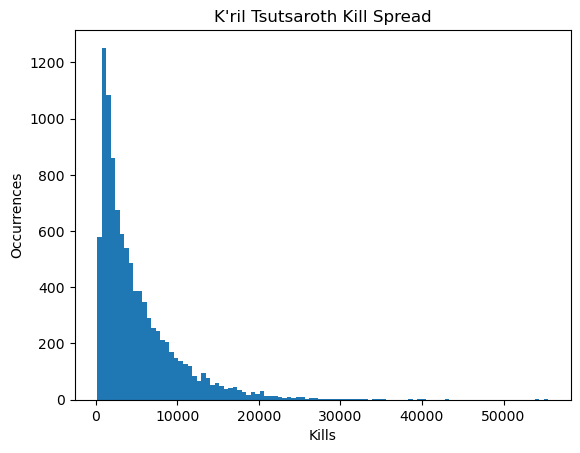

In [59]:
plt.figure()
plt.hist(zammy_kill_df, bins=bin_num)
plt.xlabel("Kills")
plt.ylabel("Occurrences")
plt.title("K'ril Tsutsaroth Kill Spread")
plt.savefig("images\\K'ril Tsutsaroth Kill Spread.png")
plt.show()

In [60]:
# let's create a dictionary to hold all the stats we created from above
zammy_stats = {"Boss Name" : ["K'ril Tsutsaroth"], 
             "Average Kills" : [zammy_avg], 
             "Lowest Kills": [zammy_min], 
             "Highest Kills": [zammy_max]}

# now let's turn it into a dataframe
zammy_df = pd.DataFrame(zammy_stats)

# did it work?
zammy_df

Boss Name  Average Kills  Lowest Kills  Highest Kills
0  K'ril Tsutsaroth      5057.9821           184          55483

In [61]:
greenlog_df = pd.concat([greenlog_df, zammy_df], ignore_index = True)
greenlog_df

Boss Name  Average Kills Lowest Kills Highest Kills
0                  King Black Dragon      6216.7389          149         53910
1  Chambers of Xeric: Challenge Mode      2120.8676         2000          9229
2         Hard Mode Theatre of Blood      2023.7817         2000          4355
3  Tombs of Amascut - 150 Invocation      2271.3666         2000         13290
4  Tombs of Amascut - 300 Invocation      2017.7115         2000          6003
5  Tombs of Amascut - 500 Invocation      2000.0000         2000          2000
6                   General Graardor      5161.8727          169         50361
7                   K'ril Tsutsaroth      5057.9821          184         55483

In [62]:
# let's identify the unique items that are needed for log completion
arma_uniques = ["Pet kree'arra", 'Armadyl helmet', 'Armadyl chestplate', 'Armadyl chainskirt',
                 "Armadyl hilt", "Godsword shard 1", "Godsword shard 2", "Godsword shard 3"]

# now we'll push the items into a dataframe
arma_log_df = pd.DataFrame(arma_uniques, columns=['Items'])

# now we need a counter of sorts. Let's add a column and start it at 0
arma_log_df['Amount Dropped'] = 0

# did it work?
arma_log_df

Items  Amount Dropped
0       Pet kree'arra               0
1      Armadyl helmet               0
2  Armadyl chestplate               0
3  Armadyl chainskirt               0
4        Armadyl hilt               0
5    Godsword shard 1               0
6    Godsword shard 2               0
7    Godsword shard 3               0

In [63]:
# let's set an object that will grab 1 drop per kill
arma_loot_table = RDSTable(count=1)

# let's add loot and assign probability to each one
# probabilities are relative to each other.

# uniques
arma_loot_table.add_entry(RDSItem("Armadyl helmet", probability=.262))
arma_loot_table.add_entry(RDSItem("Armadyl chestplate", probability=.262))
arma_loot_table.add_entry(RDSItem("Armadyl chainskirt", probability=.262))
arma_loot_table.add_entry(RDSItem("Armadyl hilt", probability=.197))
arma_loot_table.add_entry(RDSItem("Godsword shard 1", probability=.131))
arma_loot_table.add_entry(RDSItem("Godsword shard 2", probability=.131))
arma_loot_table.add_entry(RDSItem("Godsword shard 3", probability=.131))

# weapons and armour
arma_loot_table.add_entry(RDSItem("Black d'hide body", probability=6.3))
arma_loot_table.add_entry(RDSItem("Rune crossbow", probability=6.3))

# runes and ammunition
arma_loot_table.add_entry(RDSItem("Mind rune", probability=6.3))
arma_loot_table.add_entry(RDSItem("Rune arrow", probability=6.3))
arma_loot_table.add_entry(RDSItem("Runite bolts", probability=6.3))
arma_loot_table.add_entry(RDSItem("Dragonstone bolts (e)", probability=6.3))

# other
arma_loot_table.add_entry(RDSItem("Ranging potion(3)", probability=6.3))
arma_loot_table.add_entry(RDSItem("Coins (low range)", probability=34.4))
arma_loot_table.add_entry(RDSItem("Grimy dwarf weed", probability=6.3))
arma_loot_table.add_entry(RDSItem("Dwarf weed seed", probability=6.3))
arma_loot_table.add_entry(RDSItem("Coins (high range)", probability=.984))
arma_loot_table.add_entry(RDSItem("Crystal key", probability=.787))
arma_loot_table.add_entry(RDSItem("Yew seed", probability=.787))

# these tables are separate, and have a chance to replace the dropped item
# despite the name, they are typically low value drops and have a chance to drop nothing
arma_loot_table.add_entry(RDSItem("Rare Drop Table", probability=6.29))
arma_loot_table.add_entry(RDSItem("Gem Drop Table", probability=1.57))

In [64]:
arma_minion_loot_table = RDSTable(count=3)

arma_minion_loot_table.add_entry(RDSItem("Armadyl helmet", probability=.0062))
arma_minion_loot_table.add_entry(RDSItem("Armadyl chestplate", probability=.0062))
arma_minion_loot_table.add_entry(RDSItem("Armadyl chainskirt", probability=.0062))
arma_minion_loot_table.add_entry(RDSItem("Godsword shard 1", probability=.0656))
arma_minion_loot_table.add_entry(RDSItem("Godsword shard 2", probability=.0656))
arma_minion_loot_table.add_entry(RDSItem("Godsword shard 3", probability=.0656))

arma_minion_loot_table.add_entry(RDSItem("Nothing", probability=99.7828))

In [65]:
# declare a list to store the number of kills per iteration
arma_kills = []

# let's run the sim 10,000 times
for i in range(iters):
    # restart the kill number to 0 for each iteration over log completion
    kill = 0
    # we want the loop to run until the log is completed
    while True:
        # increase kill by 1
        kill += 1
        
        results = arma_loot_table.rds_result


        # here are some tertiary drops that roll separately from everything else and can drop alongside
        # the rest of the loot
        
        # kree pet drops at a 1/5000 rate. Let's assign that number on every kill
        pet_roll = random.randint(1, 5000)
        
        # run a check to see if this kill gave us the pet
        if pet_roll == 5000:
            # if it passed, append the drop to the results list
            results.append("Pet kree'arra")
            
        # K'ril has 3 lieutenants in the room with him, killing them has a (drastically reduced) 
        # odds of recieving that drop
        
        minion_results = arma_minion_loot_table.rds_result
        for result in minion_results:
            if str(result) == "Armadyl helmet":
                results.append("Armadyl helmet")
                
            if str(result) == "Armadyl chestplate":
                results.append("Armadyl chestplate")
                
            if str(result) == "Armadyl chainskirt":
                results.append("Armadyl chainskirt")
                
            if str(result) == "Godsword shard 1":
                results.append("Godsword shard 1")
                
            if str(result) == "Godsword shard 2":
                results.append("Godsword shard 2")
                
            if str(result) == "Godsword shard 3":
                results.append("Godsword shard 3")
                
#         This section was for troubleshooting. Can uncomment if you want a printout of every drop until completion
#         print(f"Test {i+1} Kill {kill} loot:")
        
#         for drop in drops:
#             print(f"\t{drop}")
            
        for result in results:
#             print(f"\t{result}")

            # super defense and ranging potions are dropped together, so here we add that 2nd drop in
            if str(result) == "Ranging potion(3)":
                results.append("Super defense(3)")


            # convert each item in the drop list to a string. rds library stores them as a list of objects, not strings
            result_conv = str(result)
            
            
            # check to see if the drop is in the collection log
            if result_conv in arma_log_df['Items'].values:
                # if it is, grab the row index of that item
                location = arma_log_df[arma_log_df['Items']==result_conv].index.values
                # convert that index to an integer
                location = int(location)
                # pass the integer in so that we can increase the respective counter by 1 for each time the item drops
                arma_log_df.at[location, 'Amount Dropped'] += 1
        # here we run a check to see if the log is completed (everything has been dropped atleast once)
        if arma_log_df['Amount Dropped'].min() > 0:
            # append the kill number that the last unique was dropped. IE - Kill 900.
            arma_kills.append(kill)
            # break out of the while loop when log is complete.
            break
            
    # when the log is complete, this will print a statement to let us know when the log was completed for that simulation
    print(f"Log {i+1} was completed in {kill} kills!")
    
    # reset the values to 0, and rerun the sim
    arma_log_df['Amount Dropped'] = 0

Log 1 was completed in 3127 kills!
Log 2 was completed in 3246 kills!
Log 3 was completed in 12652 kills!
Log 4 was completed in 7140 kills!
Log 5 was completed in 1541 kills!
Log 6 was completed in 564 kills!
Log 7 was completed in 6837 kills!
Log 8 was completed in 1660 kills!
Log 9 was completed in 15139 kills!
Log 10 was completed in 840 kills!
Log 11 was completed in 638 kills!
Log 12 was completed in 16362 kills!
Log 13 was completed in 903 kills!
Log 14 was completed in 8162 kills!
Log 15 was completed in 8058 kills!
Log 16 was completed in 19516 kills!
Log 17 was completed in 3280 kills!
Log 18 was completed in 752 kills!
Log 19 was completed in 1312 kills!
Log 20 was completed in 3417 kills!
Log 21 was completed in 767 kills!
Log 22 was completed in 10222 kills!
Log 23 was completed in 3787 kills!
Log 24 was completed in 1372 kills!
Log 25 was completed in 33657 kills!
Log 26 was completed in 3736 kills!
Log 27 was completed in 10365 kills!
Log 28 was completed in 4541 kills!


Log 240 was completed in 3535 kills!
Log 241 was completed in 3019 kills!
Log 242 was completed in 7250 kills!
Log 243 was completed in 2125 kills!
Log 244 was completed in 3072 kills!
Log 245 was completed in 21596 kills!
Log 246 was completed in 6613 kills!
Log 247 was completed in 3976 kills!
Log 248 was completed in 6081 kills!
Log 249 was completed in 2767 kills!
Log 250 was completed in 1880 kills!
Log 251 was completed in 2658 kills!
Log 252 was completed in 3405 kills!
Log 253 was completed in 3271 kills!
Log 254 was completed in 20499 kills!
Log 255 was completed in 889 kills!
Log 256 was completed in 17226 kills!
Log 257 was completed in 4848 kills!
Log 258 was completed in 3182 kills!
Log 259 was completed in 703 kills!
Log 260 was completed in 1232 kills!
Log 261 was completed in 14319 kills!
Log 262 was completed in 1909 kills!
Log 263 was completed in 432 kills!
Log 264 was completed in 1450 kills!
Log 265 was completed in 1689 kills!
Log 266 was completed in 5137 kills!


Log 473 was completed in 4042 kills!
Log 474 was completed in 3026 kills!
Log 475 was completed in 7302 kills!
Log 476 was completed in 7479 kills!
Log 477 was completed in 4390 kills!
Log 478 was completed in 4515 kills!
Log 479 was completed in 3808 kills!
Log 480 was completed in 1076 kills!
Log 481 was completed in 2961 kills!
Log 482 was completed in 803 kills!
Log 483 was completed in 1166 kills!
Log 484 was completed in 7045 kills!
Log 485 was completed in 4140 kills!
Log 486 was completed in 1591 kills!
Log 487 was completed in 5958 kills!
Log 488 was completed in 7379 kills!
Log 489 was completed in 3225 kills!
Log 490 was completed in 6947 kills!
Log 491 was completed in 17593 kills!
Log 492 was completed in 32442 kills!
Log 493 was completed in 843 kills!
Log 494 was completed in 5720 kills!
Log 495 was completed in 1068 kills!
Log 496 was completed in 5580 kills!
Log 497 was completed in 3392 kills!
Log 498 was completed in 348 kills!
Log 499 was completed in 6285 kills!
Lo

Log 695 was completed in 13683 kills!
Log 696 was completed in 5561 kills!
Log 697 was completed in 1088 kills!
Log 698 was completed in 288 kills!
Log 699 was completed in 590 kills!
Log 700 was completed in 9354 kills!
Log 701 was completed in 3456 kills!
Log 702 was completed in 4229 kills!
Log 703 was completed in 8404 kills!
Log 704 was completed in 12103 kills!
Log 705 was completed in 1100 kills!
Log 706 was completed in 1941 kills!
Log 707 was completed in 2323 kills!
Log 708 was completed in 802 kills!
Log 709 was completed in 6535 kills!
Log 710 was completed in 442 kills!
Log 711 was completed in 3319 kills!
Log 712 was completed in 1370 kills!
Log 713 was completed in 2083 kills!
Log 714 was completed in 579 kills!
Log 715 was completed in 7508 kills!
Log 716 was completed in 14290 kills!
Log 717 was completed in 1408 kills!
Log 718 was completed in 14661 kills!
Log 719 was completed in 3475 kills!
Log 720 was completed in 3084 kills!
Log 721 was completed in 1006 kills!
Lo

Log 927 was completed in 9568 kills!
Log 928 was completed in 353 kills!
Log 929 was completed in 819 kills!
Log 930 was completed in 3139 kills!
Log 931 was completed in 3364 kills!
Log 932 was completed in 9640 kills!
Log 933 was completed in 3519 kills!
Log 934 was completed in 2489 kills!
Log 935 was completed in 7408 kills!
Log 936 was completed in 2022 kills!
Log 937 was completed in 18524 kills!
Log 938 was completed in 408 kills!
Log 939 was completed in 3477 kills!
Log 940 was completed in 3812 kills!
Log 941 was completed in 4566 kills!
Log 942 was completed in 1897 kills!
Log 943 was completed in 1861 kills!
Log 944 was completed in 6911 kills!
Log 945 was completed in 1024 kills!
Log 946 was completed in 11596 kills!
Log 947 was completed in 3862 kills!
Log 948 was completed in 3887 kills!
Log 949 was completed in 4796 kills!
Log 950 was completed in 4309 kills!
Log 951 was completed in 5194 kills!
Log 952 was completed in 5315 kills!
Log 953 was completed in 3325 kills!
Lo

Log 1144 was completed in 12064 kills!
Log 1145 was completed in 16199 kills!
Log 1146 was completed in 4677 kills!
Log 1147 was completed in 1456 kills!
Log 1148 was completed in 656 kills!
Log 1149 was completed in 2152 kills!
Log 1150 was completed in 8836 kills!
Log 1151 was completed in 6043 kills!
Log 1152 was completed in 11160 kills!
Log 1153 was completed in 1967 kills!
Log 1154 was completed in 7900 kills!
Log 1155 was completed in 7335 kills!
Log 1156 was completed in 4538 kills!
Log 1157 was completed in 2430 kills!
Log 1158 was completed in 4724 kills!
Log 1159 was completed in 1535 kills!
Log 1160 was completed in 2717 kills!
Log 1161 was completed in 1427 kills!
Log 1162 was completed in 7393 kills!
Log 1163 was completed in 8588 kills!
Log 1164 was completed in 608 kills!
Log 1165 was completed in 6660 kills!
Log 1166 was completed in 828 kills!
Log 1167 was completed in 4267 kills!
Log 1168 was completed in 786 kills!
Log 1169 was completed in 3572 kills!
Log 1170 was 

Log 1378 was completed in 6627 kills!
Log 1379 was completed in 9201 kills!
Log 1380 was completed in 1771 kills!
Log 1381 was completed in 1033 kills!
Log 1382 was completed in 6006 kills!
Log 1383 was completed in 11356 kills!
Log 1384 was completed in 410 kills!
Log 1385 was completed in 7730 kills!
Log 1386 was completed in 4352 kills!
Log 1387 was completed in 847 kills!
Log 1388 was completed in 2186 kills!
Log 1389 was completed in 8044 kills!
Log 1390 was completed in 1829 kills!
Log 1391 was completed in 8197 kills!
Log 1392 was completed in 1670 kills!
Log 1393 was completed in 2712 kills!
Log 1394 was completed in 1718 kills!
Log 1395 was completed in 3762 kills!
Log 1396 was completed in 1599 kills!
Log 1397 was completed in 3432 kills!
Log 1398 was completed in 863 kills!
Log 1399 was completed in 7390 kills!
Log 1400 was completed in 3056 kills!
Log 1401 was completed in 10924 kills!
Log 1402 was completed in 2799 kills!
Log 1403 was completed in 4499 kills!
Log 1404 was 

Log 1594 was completed in 1794 kills!
Log 1595 was completed in 4537 kills!
Log 1596 was completed in 7224 kills!
Log 1597 was completed in 5052 kills!
Log 1598 was completed in 2239 kills!
Log 1599 was completed in 4291 kills!
Log 1600 was completed in 1223 kills!
Log 1601 was completed in 2081 kills!
Log 1602 was completed in 18811 kills!
Log 1603 was completed in 3657 kills!
Log 1604 was completed in 14325 kills!
Log 1605 was completed in 3560 kills!
Log 1606 was completed in 870 kills!
Log 1607 was completed in 13926 kills!
Log 1608 was completed in 4254 kills!
Log 1609 was completed in 708 kills!
Log 1610 was completed in 2155 kills!
Log 1611 was completed in 4167 kills!
Log 1612 was completed in 1828 kills!
Log 1613 was completed in 2430 kills!
Log 1614 was completed in 1309 kills!
Log 1615 was completed in 6162 kills!
Log 1616 was completed in 3237 kills!
Log 1617 was completed in 11206 kills!
Log 1618 was completed in 1859 kills!
Log 1619 was completed in 5444 kills!
Log 1620 w

Log 1816 was completed in 4744 kills!
Log 1817 was completed in 4860 kills!
Log 1818 was completed in 1243 kills!
Log 1819 was completed in 6582 kills!
Log 1820 was completed in 3250 kills!
Log 1821 was completed in 10288 kills!
Log 1822 was completed in 2671 kills!
Log 1823 was completed in 578 kills!
Log 1824 was completed in 4678 kills!
Log 1825 was completed in 2935 kills!
Log 1826 was completed in 1711 kills!
Log 1827 was completed in 6979 kills!
Log 1828 was completed in 14778 kills!
Log 1829 was completed in 15369 kills!
Log 1830 was completed in 1797 kills!
Log 1831 was completed in 1413 kills!
Log 1832 was completed in 1370 kills!
Log 1833 was completed in 1065 kills!
Log 1834 was completed in 2219 kills!
Log 1835 was completed in 4087 kills!
Log 1836 was completed in 7744 kills!
Log 1837 was completed in 1804 kills!
Log 1838 was completed in 4261 kills!
Log 1839 was completed in 1479 kills!
Log 1840 was completed in 769 kills!
Log 1841 was completed in 873 kills!
Log 1842 was

Log 2032 was completed in 16328 kills!
Log 2033 was completed in 4871 kills!
Log 2034 was completed in 4064 kills!
Log 2035 was completed in 3316 kills!
Log 2036 was completed in 1404 kills!
Log 2037 was completed in 1889 kills!
Log 2038 was completed in 732 kills!
Log 2039 was completed in 1887 kills!
Log 2040 was completed in 5399 kills!
Log 2041 was completed in 5231 kills!
Log 2042 was completed in 4044 kills!
Log 2043 was completed in 6794 kills!
Log 2044 was completed in 11304 kills!
Log 2045 was completed in 8785 kills!
Log 2046 was completed in 1567 kills!
Log 2047 was completed in 7532 kills!
Log 2048 was completed in 11588 kills!
Log 2049 was completed in 3401 kills!
Log 2050 was completed in 7678 kills!
Log 2051 was completed in 1855 kills!
Log 2052 was completed in 557 kills!
Log 2053 was completed in 805 kills!
Log 2054 was completed in 8126 kills!
Log 2055 was completed in 4033 kills!
Log 2056 was completed in 1418 kills!
Log 2057 was completed in 784 kills!
Log 2058 was 

Log 2269 was completed in 12488 kills!
Log 2270 was completed in 720 kills!
Log 2271 was completed in 1876 kills!
Log 2272 was completed in 8926 kills!
Log 2273 was completed in 3888 kills!
Log 2274 was completed in 1167 kills!
Log 2275 was completed in 10272 kills!
Log 2276 was completed in 1548 kills!
Log 2277 was completed in 998 kills!
Log 2278 was completed in 4885 kills!
Log 2279 was completed in 2842 kills!
Log 2280 was completed in 8681 kills!
Log 2281 was completed in 1455 kills!
Log 2282 was completed in 1376 kills!
Log 2283 was completed in 4715 kills!
Log 2284 was completed in 1572 kills!
Log 2285 was completed in 18687 kills!
Log 2286 was completed in 1330 kills!
Log 2287 was completed in 10763 kills!
Log 2288 was completed in 5833 kills!
Log 2289 was completed in 5383 kills!
Log 2290 was completed in 6823 kills!
Log 2291 was completed in 1365 kills!
Log 2292 was completed in 4139 kills!
Log 2293 was completed in 10236 kills!
Log 2294 was completed in 7045 kills!
Log 2295 

Log 2499 was completed in 1146 kills!
Log 2500 was completed in 10563 kills!
Log 2501 was completed in 8875 kills!
Log 2502 was completed in 13194 kills!
Log 2503 was completed in 5436 kills!
Log 2504 was completed in 2557 kills!
Log 2505 was completed in 3381 kills!
Log 2506 was completed in 9860 kills!
Log 2507 was completed in 1975 kills!
Log 2508 was completed in 1574 kills!
Log 2509 was completed in 1573 kills!
Log 2510 was completed in 3725 kills!
Log 2511 was completed in 11959 kills!
Log 2512 was completed in 6015 kills!
Log 2513 was completed in 8281 kills!
Log 2514 was completed in 1097 kills!
Log 2515 was completed in 4061 kills!
Log 2516 was completed in 2406 kills!
Log 2517 was completed in 5822 kills!
Log 2518 was completed in 8103 kills!
Log 2519 was completed in 9426 kills!
Log 2520 was completed in 1074 kills!
Log 2521 was completed in 14654 kills!
Log 2522 was completed in 978 kills!
Log 2523 was completed in 681 kills!
Log 2524 was completed in 1608 kills!
Log 2525 w

Log 2723 was completed in 6871 kills!
Log 2724 was completed in 1077 kills!
Log 2725 was completed in 3261 kills!
Log 2726 was completed in 4506 kills!
Log 2727 was completed in 5980 kills!
Log 2728 was completed in 27879 kills!
Log 2729 was completed in 6458 kills!
Log 2730 was completed in 7693 kills!
Log 2731 was completed in 758 kills!
Log 2732 was completed in 3253 kills!
Log 2733 was completed in 6652 kills!
Log 2734 was completed in 6372 kills!
Log 2735 was completed in 1368 kills!
Log 2736 was completed in 8320 kills!
Log 2737 was completed in 4761 kills!
Log 2738 was completed in 5520 kills!
Log 2739 was completed in 5351 kills!
Log 2740 was completed in 7887 kills!
Log 2741 was completed in 961 kills!
Log 2742 was completed in 5827 kills!
Log 2743 was completed in 3193 kills!
Log 2744 was completed in 2731 kills!
Log 2745 was completed in 448 kills!
Log 2746 was completed in 27664 kills!
Log 2747 was completed in 3730 kills!
Log 2748 was completed in 2781 kills!
Log 2749 was 

Log 2971 was completed in 13604 kills!
Log 2972 was completed in 1142 kills!
Log 2973 was completed in 6614 kills!
Log 2974 was completed in 1067 kills!
Log 2975 was completed in 4031 kills!
Log 2976 was completed in 1880 kills!
Log 2977 was completed in 4081 kills!
Log 2978 was completed in 2489 kills!
Log 2979 was completed in 887 kills!
Log 2980 was completed in 15287 kills!
Log 2981 was completed in 1658 kills!
Log 2982 was completed in 13363 kills!
Log 2983 was completed in 923 kills!
Log 2984 was completed in 12429 kills!
Log 2985 was completed in 4753 kills!
Log 2986 was completed in 1525 kills!
Log 2987 was completed in 717 kills!
Log 2988 was completed in 9528 kills!
Log 2989 was completed in 1942 kills!
Log 2990 was completed in 3258 kills!
Log 2991 was completed in 2355 kills!
Log 2992 was completed in 2167 kills!
Log 2993 was completed in 9694 kills!
Log 2994 was completed in 3673 kills!
Log 2995 was completed in 1322 kills!
Log 2996 was completed in 9361 kills!
Log 2997 wa

Log 3190 was completed in 23966 kills!
Log 3191 was completed in 930 kills!
Log 3192 was completed in 5734 kills!
Log 3193 was completed in 2838 kills!
Log 3194 was completed in 734 kills!
Log 3195 was completed in 2285 kills!
Log 3196 was completed in 1961 kills!
Log 3197 was completed in 4621 kills!
Log 3198 was completed in 4016 kills!
Log 3199 was completed in 9825 kills!
Log 3200 was completed in 2345 kills!
Log 3201 was completed in 700 kills!
Log 3202 was completed in 10978 kills!
Log 3203 was completed in 1541 kills!
Log 3204 was completed in 14605 kills!
Log 3205 was completed in 15795 kills!
Log 3206 was completed in 2111 kills!
Log 3207 was completed in 4143 kills!
Log 3208 was completed in 6711 kills!
Log 3209 was completed in 8960 kills!
Log 3210 was completed in 883 kills!
Log 3211 was completed in 2350 kills!
Log 3212 was completed in 868 kills!
Log 3213 was completed in 14402 kills!
Log 3214 was completed in 1172 kills!
Log 3215 was completed in 7746 kills!
Log 3216 was

Log 3410 was completed in 9753 kills!
Log 3411 was completed in 1162 kills!
Log 3412 was completed in 5512 kills!
Log 3413 was completed in 9618 kills!
Log 3414 was completed in 3287 kills!
Log 3415 was completed in 1853 kills!
Log 3416 was completed in 677 kills!
Log 3417 was completed in 576 kills!
Log 3418 was completed in 2702 kills!
Log 3419 was completed in 5530 kills!
Log 3420 was completed in 3355 kills!
Log 3421 was completed in 1432 kills!
Log 3422 was completed in 515 kills!
Log 3423 was completed in 836 kills!
Log 3424 was completed in 1167 kills!
Log 3425 was completed in 2604 kills!
Log 3426 was completed in 2121 kills!
Log 3427 was completed in 8272 kills!
Log 3428 was completed in 9090 kills!
Log 3429 was completed in 6873 kills!
Log 3430 was completed in 40858 kills!
Log 3431 was completed in 4056 kills!
Log 3432 was completed in 4143 kills!
Log 3433 was completed in 1791 kills!
Log 3434 was completed in 9952 kills!
Log 3435 was completed in 2731 kills!
Log 3436 was co

Log 3626 was completed in 3404 kills!
Log 3627 was completed in 1212 kills!
Log 3628 was completed in 2352 kills!
Log 3629 was completed in 14932 kills!
Log 3630 was completed in 546 kills!
Log 3631 was completed in 10039 kills!
Log 3632 was completed in 4177 kills!
Log 3633 was completed in 11806 kills!
Log 3634 was completed in 12659 kills!
Log 3635 was completed in 7467 kills!
Log 3636 was completed in 7545 kills!
Log 3637 was completed in 2083 kills!
Log 3638 was completed in 1897 kills!
Log 3639 was completed in 2420 kills!
Log 3640 was completed in 8665 kills!
Log 3641 was completed in 1230 kills!
Log 3642 was completed in 6820 kills!
Log 3643 was completed in 1028 kills!
Log 3644 was completed in 5841 kills!
Log 3645 was completed in 1329 kills!
Log 3646 was completed in 1505 kills!
Log 3647 was completed in 2103 kills!
Log 3648 was completed in 6111 kills!
Log 3649 was completed in 3292 kills!
Log 3650 was completed in 2163 kills!
Log 3651 was completed in 1883 kills!
Log 3652 

Log 3845 was completed in 4166 kills!
Log 3846 was completed in 5559 kills!
Log 3847 was completed in 6186 kills!
Log 3848 was completed in 859 kills!
Log 3849 was completed in 603 kills!
Log 3850 was completed in 1001 kills!
Log 3851 was completed in 649 kills!
Log 3852 was completed in 4431 kills!
Log 3853 was completed in 2877 kills!
Log 3854 was completed in 6570 kills!
Log 3855 was completed in 1685 kills!
Log 3856 was completed in 15550 kills!
Log 3857 was completed in 1830 kills!
Log 3858 was completed in 4597 kills!
Log 3859 was completed in 3727 kills!
Log 3860 was completed in 1634 kills!
Log 3861 was completed in 9634 kills!
Log 3862 was completed in 3880 kills!
Log 3863 was completed in 785 kills!
Log 3864 was completed in 2062 kills!
Log 3865 was completed in 4790 kills!
Log 3866 was completed in 1100 kills!
Log 3867 was completed in 1331 kills!
Log 3868 was completed in 4928 kills!
Log 3869 was completed in 10476 kills!
Log 3870 was completed in 11759 kills!
Log 3871 was 

Log 4066 was completed in 4545 kills!
Log 4067 was completed in 8668 kills!
Log 4068 was completed in 635 kills!
Log 4069 was completed in 1323 kills!
Log 4070 was completed in 7948 kills!
Log 4071 was completed in 11877 kills!
Log 4072 was completed in 12207 kills!
Log 4073 was completed in 4409 kills!
Log 4074 was completed in 4934 kills!
Log 4075 was completed in 2263 kills!
Log 4076 was completed in 4594 kills!
Log 4077 was completed in 6014 kills!
Log 4078 was completed in 7518 kills!
Log 4079 was completed in 1636 kills!
Log 4080 was completed in 7454 kills!
Log 4081 was completed in 8385 kills!
Log 4082 was completed in 2959 kills!
Log 4083 was completed in 5385 kills!
Log 4084 was completed in 23650 kills!
Log 4085 was completed in 21618 kills!
Log 4086 was completed in 8337 kills!
Log 4087 was completed in 11863 kills!
Log 4088 was completed in 3274 kills!
Log 4089 was completed in 5967 kills!
Log 4090 was completed in 5504 kills!
Log 4091 was completed in 4484 kills!
Log 4092

Log 4295 was completed in 6230 kills!
Log 4296 was completed in 16708 kills!
Log 4297 was completed in 1726 kills!
Log 4298 was completed in 1903 kills!
Log 4299 was completed in 9591 kills!
Log 4300 was completed in 5218 kills!
Log 4301 was completed in 4437 kills!
Log 4302 was completed in 7910 kills!
Log 4303 was completed in 1473 kills!
Log 4304 was completed in 1917 kills!
Log 4305 was completed in 10929 kills!
Log 4306 was completed in 1341 kills!
Log 4307 was completed in 8378 kills!
Log 4308 was completed in 6677 kills!
Log 4309 was completed in 670 kills!
Log 4310 was completed in 8604 kills!
Log 4311 was completed in 2959 kills!
Log 4312 was completed in 4137 kills!
Log 4313 was completed in 8407 kills!
Log 4314 was completed in 570 kills!
Log 4315 was completed in 1727 kills!
Log 4316 was completed in 8598 kills!
Log 4317 was completed in 4732 kills!
Log 4318 was completed in 1006 kills!
Log 4319 was completed in 7375 kills!
Log 4320 was completed in 5935 kills!
Log 4321 was

Log 4513 was completed in 8050 kills!
Log 4514 was completed in 3049 kills!
Log 4515 was completed in 891 kills!
Log 4516 was completed in 1708 kills!
Log 4517 was completed in 579 kills!
Log 4518 was completed in 1538 kills!
Log 4519 was completed in 946 kills!
Log 4520 was completed in 8108 kills!
Log 4521 was completed in 744 kills!
Log 4522 was completed in 2084 kills!
Log 4523 was completed in 2241 kills!
Log 4524 was completed in 4134 kills!
Log 4525 was completed in 5991 kills!
Log 4526 was completed in 2324 kills!
Log 4527 was completed in 6609 kills!
Log 4528 was completed in 1512 kills!
Log 4529 was completed in 4552 kills!
Log 4530 was completed in 3985 kills!
Log 4531 was completed in 3932 kills!
Log 4532 was completed in 6269 kills!
Log 4533 was completed in 5756 kills!
Log 4534 was completed in 3876 kills!
Log 4535 was completed in 2078 kills!
Log 4536 was completed in 2816 kills!
Log 4537 was completed in 1833 kills!
Log 4538 was completed in 3177 kills!
Log 4539 was com

Log 4733 was completed in 41657 kills!
Log 4734 was completed in 1492 kills!
Log 4735 was completed in 2850 kills!
Log 4736 was completed in 7393 kills!
Log 4737 was completed in 5461 kills!
Log 4738 was completed in 7598 kills!
Log 4739 was completed in 10696 kills!
Log 4740 was completed in 9030 kills!
Log 4741 was completed in 17227 kills!
Log 4742 was completed in 1056 kills!
Log 4743 was completed in 12267 kills!
Log 4744 was completed in 1028 kills!
Log 4745 was completed in 730 kills!
Log 4746 was completed in 9520 kills!
Log 4747 was completed in 6054 kills!
Log 4748 was completed in 3437 kills!
Log 4749 was completed in 16333 kills!
Log 4750 was completed in 36866 kills!
Log 4751 was completed in 1140 kills!
Log 4752 was completed in 13892 kills!
Log 4753 was completed in 3778 kills!
Log 4754 was completed in 6345 kills!
Log 4755 was completed in 7198 kills!
Log 4756 was completed in 853 kills!
Log 4757 was completed in 6786 kills!
Log 4758 was completed in 10709 kills!
Log 47

Log 4959 was completed in 2804 kills!
Log 4960 was completed in 8798 kills!
Log 4961 was completed in 6879 kills!
Log 4962 was completed in 2040 kills!
Log 4963 was completed in 7341 kills!
Log 4964 was completed in 1130 kills!
Log 4965 was completed in 2267 kills!
Log 4966 was completed in 2946 kills!
Log 4967 was completed in 7830 kills!
Log 4968 was completed in 5827 kills!
Log 4969 was completed in 440 kills!
Log 4970 was completed in 5973 kills!
Log 4971 was completed in 789 kills!
Log 4972 was completed in 1327 kills!
Log 4973 was completed in 1367 kills!
Log 4974 was completed in 2316 kills!
Log 4975 was completed in 1097 kills!
Log 4976 was completed in 11283 kills!
Log 4977 was completed in 6162 kills!
Log 4978 was completed in 3244 kills!
Log 4979 was completed in 6044 kills!
Log 4980 was completed in 3088 kills!
Log 4981 was completed in 718 kills!
Log 4982 was completed in 4342 kills!
Log 4983 was completed in 4382 kills!
Log 4984 was completed in 2268 kills!
Log 4985 was c

Log 5190 was completed in 14656 kills!
Log 5191 was completed in 1097 kills!
Log 5192 was completed in 4312 kills!
Log 5193 was completed in 7176 kills!
Log 5194 was completed in 2348 kills!
Log 5195 was completed in 2334 kills!
Log 5196 was completed in 3554 kills!
Log 5197 was completed in 12028 kills!
Log 5198 was completed in 7583 kills!
Log 5199 was completed in 16207 kills!
Log 5200 was completed in 12102 kills!
Log 5201 was completed in 2851 kills!
Log 5202 was completed in 1520 kills!
Log 5203 was completed in 1668 kills!
Log 5204 was completed in 1888 kills!
Log 5205 was completed in 6023 kills!
Log 5206 was completed in 2391 kills!
Log 5207 was completed in 1347 kills!
Log 5208 was completed in 17186 kills!
Log 5209 was completed in 1179 kills!
Log 5210 was completed in 6023 kills!
Log 5211 was completed in 720 kills!
Log 5212 was completed in 4073 kills!
Log 5213 was completed in 1228 kills!
Log 5214 was completed in 824 kills!
Log 5215 was completed in 3223 kills!
Log 5216 

Log 5407 was completed in 7164 kills!
Log 5408 was completed in 873 kills!
Log 5409 was completed in 3367 kills!
Log 5410 was completed in 1854 kills!
Log 5411 was completed in 746 kills!
Log 5412 was completed in 1533 kills!
Log 5413 was completed in 7184 kills!
Log 5414 was completed in 6166 kills!
Log 5415 was completed in 4304 kills!
Log 5416 was completed in 9806 kills!
Log 5417 was completed in 9293 kills!
Log 5418 was completed in 1703 kills!
Log 5419 was completed in 2360 kills!
Log 5420 was completed in 1652 kills!
Log 5421 was completed in 1741 kills!
Log 5422 was completed in 3043 kills!
Log 5423 was completed in 9415 kills!
Log 5424 was completed in 1392 kills!
Log 5425 was completed in 1472 kills!
Log 5426 was completed in 876 kills!
Log 5427 was completed in 2041 kills!
Log 5428 was completed in 5667 kills!
Log 5429 was completed in 4378 kills!
Log 5430 was completed in 3257 kills!
Log 5431 was completed in 4921 kills!
Log 5432 was completed in 17529 kills!
Log 5433 was c

Log 5637 was completed in 6122 kills!
Log 5638 was completed in 5460 kills!
Log 5639 was completed in 1011 kills!
Log 5640 was completed in 4037 kills!
Log 5641 was completed in 5773 kills!
Log 5642 was completed in 16641 kills!
Log 5643 was completed in 5764 kills!
Log 5644 was completed in 7036 kills!
Log 5645 was completed in 6597 kills!
Log 5646 was completed in 8269 kills!
Log 5647 was completed in 4702 kills!
Log 5648 was completed in 884 kills!
Log 5649 was completed in 6952 kills!
Log 5650 was completed in 3080 kills!
Log 5651 was completed in 11111 kills!
Log 5652 was completed in 6532 kills!
Log 5653 was completed in 7808 kills!
Log 5654 was completed in 2646 kills!
Log 5655 was completed in 3749 kills!
Log 5656 was completed in 2006 kills!
Log 5657 was completed in 901 kills!
Log 5658 was completed in 12311 kills!
Log 5659 was completed in 624 kills!
Log 5660 was completed in 4836 kills!
Log 5661 was completed in 12759 kills!
Log 5662 was completed in 6689 kills!
Log 5663 wa

Log 5860 was completed in 12076 kills!
Log 5861 was completed in 7509 kills!
Log 5862 was completed in 1718 kills!
Log 5863 was completed in 2057 kills!
Log 5864 was completed in 1015 kills!
Log 5865 was completed in 2471 kills!
Log 5866 was completed in 1095 kills!
Log 5867 was completed in 4995 kills!
Log 5868 was completed in 14483 kills!
Log 5869 was completed in 1796 kills!
Log 5870 was completed in 8493 kills!
Log 5871 was completed in 1405 kills!
Log 5872 was completed in 1605 kills!
Log 5873 was completed in 1695 kills!
Log 5874 was completed in 11354 kills!
Log 5875 was completed in 2477 kills!
Log 5876 was completed in 3352 kills!
Log 5877 was completed in 1714 kills!
Log 5878 was completed in 2099 kills!
Log 5879 was completed in 1844 kills!
Log 5880 was completed in 2968 kills!
Log 5881 was completed in 8239 kills!
Log 5882 was completed in 4336 kills!
Log 5883 was completed in 3311 kills!
Log 5884 was completed in 2085 kills!
Log 5885 was completed in 1321 kills!
Log 5886 

Log 6076 was completed in 11468 kills!
Log 6077 was completed in 1721 kills!
Log 6078 was completed in 8706 kills!
Log 6079 was completed in 4799 kills!
Log 6080 was completed in 2805 kills!
Log 6081 was completed in 1355 kills!
Log 6082 was completed in 1723 kills!
Log 6083 was completed in 7988 kills!
Log 6084 was completed in 1636 kills!
Log 6085 was completed in 7214 kills!
Log 6086 was completed in 1984 kills!
Log 6087 was completed in 5721 kills!
Log 6088 was completed in 1470 kills!
Log 6089 was completed in 5401 kills!
Log 6090 was completed in 4016 kills!
Log 6091 was completed in 7273 kills!
Log 6092 was completed in 6551 kills!
Log 6093 was completed in 1085 kills!
Log 6094 was completed in 1255 kills!
Log 6095 was completed in 3130 kills!
Log 6096 was completed in 2318 kills!
Log 6097 was completed in 4958 kills!
Log 6098 was completed in 925 kills!
Log 6099 was completed in 618 kills!
Log 6100 was completed in 17449 kills!
Log 6101 was completed in 4821 kills!
Log 6102 was

Log 6299 was completed in 1230 kills!
Log 6300 was completed in 8184 kills!
Log 6301 was completed in 11398 kills!
Log 6302 was completed in 7627 kills!
Log 6303 was completed in 10268 kills!
Log 6304 was completed in 1484 kills!
Log 6305 was completed in 1298 kills!
Log 6306 was completed in 1759 kills!
Log 6307 was completed in 1877 kills!
Log 6308 was completed in 7143 kills!
Log 6309 was completed in 3979 kills!
Log 6310 was completed in 7485 kills!
Log 6311 was completed in 14867 kills!
Log 6312 was completed in 3709 kills!
Log 6313 was completed in 7778 kills!
Log 6314 was completed in 3350 kills!
Log 6315 was completed in 2786 kills!
Log 6316 was completed in 2494 kills!
Log 6317 was completed in 9891 kills!
Log 6318 was completed in 1756 kills!
Log 6319 was completed in 3480 kills!
Log 6320 was completed in 53226 kills!
Log 6321 was completed in 10119 kills!
Log 6322 was completed in 11122 kills!
Log 6323 was completed in 22654 kills!
Log 6324 was completed in 1154 kills!
Log 6

Log 6527 was completed in 17463 kills!
Log 6528 was completed in 14441 kills!
Log 6529 was completed in 2041 kills!
Log 6530 was completed in 2975 kills!
Log 6531 was completed in 7226 kills!
Log 6532 was completed in 5863 kills!
Log 6533 was completed in 1238 kills!
Log 6534 was completed in 2678 kills!
Log 6535 was completed in 14969 kills!
Log 6536 was completed in 10853 kills!
Log 6537 was completed in 1806 kills!
Log 6538 was completed in 729 kills!
Log 6539 was completed in 3425 kills!
Log 6540 was completed in 800 kills!
Log 6541 was completed in 4035 kills!
Log 6542 was completed in 951 kills!
Log 6543 was completed in 2451 kills!
Log 6544 was completed in 1748 kills!
Log 6545 was completed in 3399 kills!
Log 6546 was completed in 1486 kills!
Log 6547 was completed in 1711 kills!
Log 6548 was completed in 1681 kills!
Log 6549 was completed in 1354 kills!
Log 6550 was completed in 1856 kills!
Log 6551 was completed in 1469 kills!
Log 6552 was completed in 3545 kills!
Log 6553 wa

Log 6751 was completed in 6963 kills!
Log 6752 was completed in 1136 kills!
Log 6753 was completed in 8927 kills!
Log 6754 was completed in 7686 kills!
Log 6755 was completed in 690 kills!
Log 6756 was completed in 1001 kills!
Log 6757 was completed in 1996 kills!
Log 6758 was completed in 2796 kills!
Log 6759 was completed in 3024 kills!
Log 6760 was completed in 2256 kills!
Log 6761 was completed in 14254 kills!
Log 6762 was completed in 10431 kills!
Log 6763 was completed in 9238 kills!
Log 6764 was completed in 12175 kills!
Log 6765 was completed in 11271 kills!
Log 6766 was completed in 1774 kills!
Log 6767 was completed in 7449 kills!
Log 6768 was completed in 1405 kills!
Log 6769 was completed in 1150 kills!
Log 6770 was completed in 2631 kills!
Log 6771 was completed in 7180 kills!
Log 6772 was completed in 1347 kills!
Log 6773 was completed in 2737 kills!
Log 6774 was completed in 7381 kills!
Log 6775 was completed in 3604 kills!
Log 6776 was completed in 1616 kills!
Log 6777 

Log 6971 was completed in 14638 kills!
Log 6972 was completed in 1203 kills!
Log 6973 was completed in 1463 kills!
Log 6974 was completed in 17931 kills!
Log 6975 was completed in 2514 kills!
Log 6976 was completed in 5804 kills!
Log 6977 was completed in 686 kills!
Log 6978 was completed in 970 kills!
Log 6979 was completed in 485 kills!
Log 6980 was completed in 633 kills!
Log 6981 was completed in 9933 kills!
Log 6982 was completed in 1300 kills!
Log 6983 was completed in 1833 kills!
Log 6984 was completed in 3278 kills!
Log 6985 was completed in 10644 kills!
Log 6986 was completed in 1633 kills!
Log 6987 was completed in 3072 kills!
Log 6988 was completed in 2011 kills!
Log 6989 was completed in 7028 kills!
Log 6990 was completed in 1767 kills!
Log 6991 was completed in 1002 kills!
Log 6992 was completed in 2184 kills!
Log 6993 was completed in 8605 kills!
Log 6994 was completed in 2801 kills!
Log 6995 was completed in 4263 kills!
Log 6996 was completed in 1689 kills!
Log 6997 was 

Log 7187 was completed in 5124 kills!
Log 7188 was completed in 7654 kills!
Log 7189 was completed in 1640 kills!
Log 7190 was completed in 3714 kills!
Log 7191 was completed in 3390 kills!
Log 7192 was completed in 496 kills!
Log 7193 was completed in 2917 kills!
Log 7194 was completed in 1587 kills!
Log 7195 was completed in 8761 kills!
Log 7196 was completed in 1268 kills!
Log 7197 was completed in 4724 kills!
Log 7198 was completed in 2582 kills!
Log 7199 was completed in 962 kills!
Log 7200 was completed in 5468 kills!
Log 7201 was completed in 3924 kills!
Log 7202 was completed in 15848 kills!
Log 7203 was completed in 18626 kills!
Log 7204 was completed in 3985 kills!
Log 7205 was completed in 4870 kills!
Log 7206 was completed in 2244 kills!
Log 7207 was completed in 559 kills!
Log 7208 was completed in 1281 kills!
Log 7209 was completed in 7617 kills!
Log 7210 was completed in 5571 kills!
Log 7211 was completed in 1231 kills!
Log 7212 was completed in 4205 kills!
Log 7213 was 

Log 7407 was completed in 7931 kills!
Log 7408 was completed in 7670 kills!
Log 7409 was completed in 4548 kills!
Log 7410 was completed in 1606 kills!
Log 7411 was completed in 1948 kills!
Log 7412 was completed in 5695 kills!
Log 7413 was completed in 2860 kills!
Log 7414 was completed in 11832 kills!
Log 7415 was completed in 4773 kills!
Log 7416 was completed in 3644 kills!
Log 7417 was completed in 897 kills!
Log 7418 was completed in 2808 kills!
Log 7419 was completed in 1920 kills!
Log 7420 was completed in 1732 kills!
Log 7421 was completed in 900 kills!
Log 7422 was completed in 26445 kills!
Log 7423 was completed in 6696 kills!
Log 7424 was completed in 955 kills!
Log 7425 was completed in 4653 kills!
Log 7426 was completed in 2118 kills!
Log 7427 was completed in 788 kills!
Log 7428 was completed in 2019 kills!
Log 7429 was completed in 9942 kills!
Log 7430 was completed in 636 kills!
Log 7431 was completed in 15167 kills!
Log 7432 was completed in 22149 kills!
Log 7433 was 

Log 7668 was completed in 3235 kills!
Log 7669 was completed in 6820 kills!
Log 7670 was completed in 915 kills!
Log 7671 was completed in 1862 kills!
Log 7672 was completed in 7052 kills!
Log 7673 was completed in 6550 kills!
Log 7674 was completed in 719 kills!
Log 7675 was completed in 1127 kills!
Log 7676 was completed in 1154 kills!
Log 7677 was completed in 897 kills!
Log 7678 was completed in 9466 kills!
Log 7679 was completed in 4610 kills!
Log 7680 was completed in 1459 kills!
Log 7681 was completed in 355 kills!
Log 7682 was completed in 5713 kills!
Log 7683 was completed in 1203 kills!
Log 7684 was completed in 6900 kills!
Log 7685 was completed in 6074 kills!
Log 7686 was completed in 9851 kills!
Log 7687 was completed in 1083 kills!
Log 7688 was completed in 869 kills!
Log 7689 was completed in 987 kills!
Log 7690 was completed in 3695 kills!
Log 7691 was completed in 1936 kills!
Log 7692 was completed in 1718 kills!
Log 7693 was completed in 2228 kills!
Log 7694 was compl

Log 7909 was completed in 19764 kills!
Log 7910 was completed in 4539 kills!
Log 7911 was completed in 4122 kills!
Log 7912 was completed in 1980 kills!
Log 7913 was completed in 4605 kills!
Log 7914 was completed in 1849 kills!
Log 7915 was completed in 5156 kills!
Log 7916 was completed in 8382 kills!
Log 7917 was completed in 10816 kills!
Log 7918 was completed in 1033 kills!
Log 7919 was completed in 4334 kills!
Log 7920 was completed in 4930 kills!
Log 7921 was completed in 12923 kills!
Log 7922 was completed in 4731 kills!
Log 7923 was completed in 11349 kills!
Log 7924 was completed in 4265 kills!
Log 7925 was completed in 971 kills!
Log 7926 was completed in 905 kills!
Log 7927 was completed in 2167 kills!
Log 7928 was completed in 855 kills!
Log 7929 was completed in 2352 kills!
Log 7930 was completed in 2655 kills!
Log 7931 was completed in 608 kills!
Log 7932 was completed in 1317 kills!
Log 7933 was completed in 3080 kills!
Log 7934 was completed in 2277 kills!
Log 7935 was

Log 8136 was completed in 2899 kills!
Log 8137 was completed in 3267 kills!
Log 8138 was completed in 1442 kills!
Log 8139 was completed in 5028 kills!
Log 8140 was completed in 4637 kills!
Log 8141 was completed in 21216 kills!
Log 8142 was completed in 7892 kills!
Log 8143 was completed in 550 kills!
Log 8144 was completed in 3525 kills!
Log 8145 was completed in 4116 kills!
Log 8146 was completed in 7687 kills!
Log 8147 was completed in 814 kills!
Log 8148 was completed in 6503 kills!
Log 8149 was completed in 1572 kills!
Log 8150 was completed in 1564 kills!
Log 8151 was completed in 11975 kills!
Log 8152 was completed in 1213 kills!
Log 8153 was completed in 3351 kills!
Log 8154 was completed in 3788 kills!
Log 8155 was completed in 2249 kills!
Log 8156 was completed in 10026 kills!
Log 8157 was completed in 7318 kills!
Log 8158 was completed in 896 kills!
Log 8159 was completed in 5561 kills!
Log 8160 was completed in 1166 kills!
Log 8161 was completed in 2338 kills!
Log 8162 was

Log 8352 was completed in 17110 kills!
Log 8353 was completed in 1614 kills!
Log 8354 was completed in 1789 kills!
Log 8355 was completed in 1746 kills!
Log 8356 was completed in 12896 kills!
Log 8357 was completed in 5053 kills!
Log 8358 was completed in 4618 kills!
Log 8359 was completed in 1497 kills!
Log 8360 was completed in 7306 kills!
Log 8361 was completed in 2019 kills!
Log 8362 was completed in 5701 kills!
Log 8363 was completed in 13674 kills!
Log 8364 was completed in 6057 kills!
Log 8365 was completed in 1203 kills!
Log 8366 was completed in 14080 kills!
Log 8367 was completed in 6993 kills!
Log 8368 was completed in 2039 kills!
Log 8369 was completed in 5783 kills!
Log 8370 was completed in 539 kills!
Log 8371 was completed in 439 kills!
Log 8372 was completed in 11388 kills!
Log 8373 was completed in 6179 kills!
Log 8374 was completed in 3102 kills!
Log 8375 was completed in 9362 kills!
Log 8376 was completed in 2120 kills!
Log 8377 was completed in 9571 kills!
Log 8378 

Log 8581 was completed in 24560 kills!
Log 8582 was completed in 1305 kills!
Log 8583 was completed in 3873 kills!
Log 8584 was completed in 2719 kills!
Log 8585 was completed in 5644 kills!
Log 8586 was completed in 12999 kills!
Log 8587 was completed in 17113 kills!
Log 8588 was completed in 2011 kills!
Log 8589 was completed in 16695 kills!
Log 8590 was completed in 2599 kills!
Log 8591 was completed in 2298 kills!
Log 8592 was completed in 1091 kills!
Log 8593 was completed in 8411 kills!
Log 8594 was completed in 1320 kills!
Log 8595 was completed in 8177 kills!
Log 8596 was completed in 2497 kills!
Log 8597 was completed in 524 kills!
Log 8598 was completed in 10237 kills!
Log 8599 was completed in 3624 kills!
Log 8600 was completed in 2192 kills!
Log 8601 was completed in 5003 kills!
Log 8602 was completed in 4640 kills!
Log 8603 was completed in 1409 kills!
Log 8604 was completed in 2684 kills!
Log 8605 was completed in 1287 kills!
Log 8606 was completed in 1822 kills!
Log 8607

Log 8805 was completed in 558 kills!
Log 8806 was completed in 808 kills!
Log 8807 was completed in 658 kills!
Log 8808 was completed in 1222 kills!
Log 8809 was completed in 5833 kills!
Log 8810 was completed in 3264 kills!
Log 8811 was completed in 1649 kills!
Log 8812 was completed in 872 kills!
Log 8813 was completed in 3827 kills!
Log 8814 was completed in 3411 kills!
Log 8815 was completed in 5572 kills!
Log 8816 was completed in 2939 kills!
Log 8817 was completed in 4027 kills!
Log 8818 was completed in 1657 kills!
Log 8819 was completed in 3926 kills!
Log 8820 was completed in 7965 kills!
Log 8821 was completed in 8042 kills!
Log 8822 was completed in 3277 kills!
Log 8823 was completed in 8765 kills!
Log 8824 was completed in 1578 kills!
Log 8825 was completed in 1626 kills!
Log 8826 was completed in 1860 kills!
Log 8827 was completed in 5162 kills!
Log 8828 was completed in 4897 kills!
Log 8829 was completed in 2151 kills!
Log 8830 was completed in 1290 kills!
Log 8831 was com

Log 9022 was completed in 8083 kills!
Log 9023 was completed in 11491 kills!
Log 9024 was completed in 608 kills!
Log 9025 was completed in 1166 kills!
Log 9026 was completed in 9396 kills!
Log 9027 was completed in 4165 kills!
Log 9028 was completed in 5612 kills!
Log 9029 was completed in 5626 kills!
Log 9030 was completed in 3423 kills!
Log 9031 was completed in 5836 kills!
Log 9032 was completed in 953 kills!
Log 9033 was completed in 2932 kills!
Log 9034 was completed in 1236 kills!
Log 9035 was completed in 4479 kills!
Log 9036 was completed in 11615 kills!
Log 9037 was completed in 2384 kills!
Log 9038 was completed in 885 kills!
Log 9039 was completed in 1730 kills!
Log 9040 was completed in 2720 kills!
Log 9041 was completed in 5780 kills!
Log 9042 was completed in 2429 kills!
Log 9043 was completed in 10410 kills!
Log 9044 was completed in 3908 kills!
Log 9045 was completed in 11486 kills!
Log 9046 was completed in 1370 kills!
Log 9047 was completed in 12634 kills!
Log 9048 w

Log 9242 was completed in 4371 kills!
Log 9243 was completed in 1025 kills!
Log 9244 was completed in 3864 kills!
Log 9245 was completed in 3341 kills!
Log 9246 was completed in 3478 kills!
Log 9247 was completed in 20560 kills!
Log 9248 was completed in 1454 kills!
Log 9249 was completed in 4164 kills!
Log 9250 was completed in 7692 kills!
Log 9251 was completed in 10930 kills!
Log 9252 was completed in 1127 kills!
Log 9253 was completed in 14108 kills!
Log 9254 was completed in 3844 kills!
Log 9255 was completed in 12871 kills!
Log 9256 was completed in 5834 kills!
Log 9257 was completed in 5827 kills!
Log 9258 was completed in 14579 kills!
Log 9259 was completed in 3182 kills!
Log 9260 was completed in 1928 kills!
Log 9261 was completed in 1631 kills!
Log 9262 was completed in 4761 kills!
Log 9263 was completed in 3523 kills!
Log 9264 was completed in 3557 kills!
Log 9265 was completed in 44941 kills!
Log 9266 was completed in 6505 kills!
Log 9267 was completed in 3478 kills!
Log 92

Log 9473 was completed in 7022 kills!
Log 9474 was completed in 10078 kills!
Log 9475 was completed in 9774 kills!
Log 9476 was completed in 1583 kills!
Log 9477 was completed in 459 kills!
Log 9478 was completed in 10772 kills!
Log 9479 was completed in 12120 kills!
Log 9480 was completed in 1347 kills!
Log 9481 was completed in 1483 kills!
Log 9482 was completed in 2392 kills!
Log 9483 was completed in 3156 kills!
Log 9484 was completed in 7409 kills!
Log 9485 was completed in 4837 kills!
Log 9486 was completed in 241 kills!
Log 9487 was completed in 4023 kills!
Log 9488 was completed in 5216 kills!
Log 9489 was completed in 720 kills!
Log 9490 was completed in 6005 kills!
Log 9491 was completed in 1870 kills!
Log 9492 was completed in 1304 kills!
Log 9493 was completed in 5865 kills!
Log 9494 was completed in 2363 kills!
Log 9495 was completed in 10976 kills!
Log 9496 was completed in 3649 kills!
Log 9497 was completed in 14223 kills!
Log 9498 was completed in 11269 kills!
Log 9499 

Log 9698 was completed in 3265 kills!
Log 9699 was completed in 977 kills!
Log 9700 was completed in 9784 kills!
Log 9701 was completed in 9662 kills!
Log 9702 was completed in 2782 kills!
Log 9703 was completed in 7764 kills!
Log 9704 was completed in 4358 kills!
Log 9705 was completed in 7011 kills!
Log 9706 was completed in 19077 kills!
Log 9707 was completed in 2142 kills!
Log 9708 was completed in 1251 kills!
Log 9709 was completed in 2558 kills!
Log 9710 was completed in 12550 kills!
Log 9711 was completed in 424 kills!
Log 9712 was completed in 17851 kills!
Log 9713 was completed in 15754 kills!
Log 9714 was completed in 2164 kills!
Log 9715 was completed in 557 kills!
Log 9716 was completed in 3603 kills!
Log 9717 was completed in 1895 kills!
Log 9718 was completed in 1119 kills!
Log 9719 was completed in 5101 kills!
Log 9720 was completed in 3244 kills!
Log 9721 was completed in 1110 kills!
Log 9722 was completed in 7760 kills!
Log 9723 was completed in 6072 kills!
Log 9724 wa

Log 9923 was completed in 8513 kills!
Log 9924 was completed in 2073 kills!
Log 9925 was completed in 3540 kills!
Log 9926 was completed in 5868 kills!
Log 9927 was completed in 8376 kills!
Log 9928 was completed in 17043 kills!
Log 9929 was completed in 4185 kills!
Log 9930 was completed in 1109 kills!
Log 9931 was completed in 13336 kills!
Log 9932 was completed in 11339 kills!
Log 9933 was completed in 1271 kills!
Log 9934 was completed in 3259 kills!
Log 9935 was completed in 1330 kills!
Log 9936 was completed in 8324 kills!
Log 9937 was completed in 2998 kills!
Log 9938 was completed in 2663 kills!
Log 9939 was completed in 2076 kills!
Log 9940 was completed in 12767 kills!
Log 9941 was completed in 3258 kills!
Log 9942 was completed in 2255 kills!
Log 9943 was completed in 7784 kills!
Log 9944 was completed in 1083 kills!
Log 9945 was completed in 6862 kills!
Log 9946 was completed in 4103 kills!
Log 9947 was completed in 5341 kills!
Log 9948 was completed in 7677 kills!
Log 9949

In [66]:
# sort the kills list
arma_kills.sort()

# let's find the average kills it takes to green log the boss from our simulations
arma_avg = (sum(arma_kills) / len(arma_kills))

# here's the lowest killcount for log completion from our simulations
arma_min = arma_kills[0]

# here's the highest killcount for log completion from our simulations
arma_max = arma_kills[-1]

# some stat printouts
print("General Graardor Loot Stats")
print(f"\tFastest Completion - {arma_min}")
print(f"\tSlowest Completion - {arma_max}")
print(f"\tAverage Completion - {arma_avg}")

General Graardor Loot Stats
	Fastest Completion - 168
	Slowest Completion - 53226
	Average Completion - 5166.8158


In [67]:
arma_kill_df = pd.DataFrame(arma_kills)
arma_kill_df.describe()

0
count  10000.00000
mean    5166.81580
std     5042.53733
min      168.00000
25%     1617.00000
50%     3441.00000
75%     7023.50000
max    53226.00000

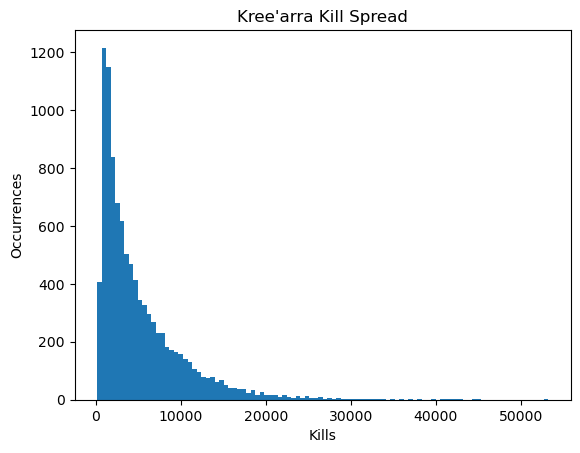

In [68]:
plt.figure()
plt.hist(arma_kill_df, bins=bin_num)
plt.xlabel("Kills")
plt.ylabel("Occurrences")
plt.title("Kree'arra Kill Spread")
plt.savefig("images\\Kree'arra Kill Spread.png")
plt.show()

In [69]:
# let's create a dictionary to hold all the stats we created from above
arma_stats = {"Boss Name" : ["Kree'arra"], 
             "Average Kills" : [arma_avg], 
             "Lowest Kills": [arma_min], 
             "Highest Kills": [arma_max]}

# now let's turn it into a dataframe
arma_df = pd.DataFrame(arma_stats)

# did it work?
arma_df

Boss Name  Average Kills  Lowest Kills  Highest Kills
0  Kree'arra      5166.8158           168          53226

In [70]:
greenlog_df = pd.concat([greenlog_df, arma_df], ignore_index = True)
greenlog_df

Boss Name  Average Kills Lowest Kills Highest Kills
0                  King Black Dragon      6216.7389          149         53910
1  Chambers of Xeric: Challenge Mode      2120.8676         2000          9229
2         Hard Mode Theatre of Blood      2023.7817         2000          4355
3  Tombs of Amascut - 150 Invocation      2271.3666         2000         13290
4  Tombs of Amascut - 300 Invocation      2017.7115         2000          6003
5  Tombs of Amascut - 500 Invocation      2000.0000         2000          2000
6                   General Graardor      5161.8727          169         50361
7                   K'ril Tsutsaroth      5057.9821          184         55483
8                          Kree'arra      5166.8158          168         53226

In [71]:
# let's identify the unique items that are needed for log completion
sara_uniques = ["Pet zilyana", 'Armadyl crossbow', 'Saradomin sword', "Saradomin's light",
                 "Saradomin hilt", "Godsword shard 1", "Godsword shard 2", "Godsword shard 3"]

# now we'll push the items into a dataframe
sara_log_df = pd.DataFrame(sara_uniques, columns=['Items'])

# now we need a counter of sorts. Let's add a column and start it at 0
sara_log_df['Amount Dropped'] = 0

# did it work?
sara_log_df

Items  Amount Dropped
0        Pet zilyana               0
1   Armadyl crossbow               0
2    Saradomin sword               0
3  Saradomin's light               0
4     Saradomin hilt               0
5   Godsword shard 1               0
6   Godsword shard 2               0
7   Godsword shard 3               0

In [72]:
# let's set an object that will grab 1 drop per kill
sara_loot_table = RDSTable(count=1)

# let's add loot and assign probability to each one
# probabilities are relative to each other.

# uniques
sara_loot_table.add_entry(RDSItem("Armadyl crossbow", probability=.197))
sara_loot_table.add_entry(RDSItem("Saradomin sword", probability=.787))
sara_loot_table.add_entry(RDSItem("Saradomin's light", probability=.394))
sara_loot_table.add_entry(RDSItem("Saradomin hilt", probability=.197))
sara_loot_table.add_entry(RDSItem("Godsword shard 1", probability=.131))
sara_loot_table.add_entry(RDSItem("Godsword shard 2", probability=.131))
sara_loot_table.add_entry(RDSItem("Godsword shard 3", probability=.131))

# weapons and armour
sara_loot_table.add_entry(RDSItem("Adamant platebody", probability=6.3))
sara_loot_table.add_entry(RDSItem("Rune dart", probability=6.3))
sara_loot_table.add_entry(RDSItem("Rune kiteshield", probability=6.3))
sara_loot_table.add_entry(RDSItem("Rune plateskirt", probability=6.3))

# potions
sara_loot_table.add_entry(RDSItem("Prayer potion(4)", probability=6.3))
sara_loot_table.add_entry(RDSItem("Super defence(3)", probability=6.3))
sara_loot_table.add_entry(RDSItem("Saradomin brew(3)", probability=4.72))

# other
sara_loot_table.add_entry(RDSItem("Coins", probability=24.6))
sara_loot_table.add_entry(RDSItem("Diamond", probability=6.3))
sara_loot_table.add_entry(RDSItem("Law rune", probability=6.3))
sara_loot_table.add_entry(RDSItem("Grimy ranarr weed", probability=6.3))
sara_loot_table.add_entry(RDSItem("Ranarr seed", probability=6.3))
sara_loot_table.add_entry(RDSItem("Magic seed", probability=.787))

# these tables are separate, and have a chance to replace the dropped item
# despite the name, they are typically low value drops and have a chance to drop nothing
sara_loot_table.add_entry(RDSItem("Rare Drop Table", probability=6.29))
sara_loot_table.add_entry(RDSItem("Gem Drop Table", probability=1.57))

In [73]:
sara_minion_loot_table = RDSTable(count=3)

sara_minion_loot_table.add_entry(RDSItem("Saradomin sword", probability=.0186))
sara_minion_loot_table.add_entry(RDSItem("Godsword shard 1", probability=.0656))
sara_minion_loot_table.add_entry(RDSItem("Godsword shard 2", probability=.0656))
sara_minion_loot_table.add_entry(RDSItem("Godsword shard 3", probability=.0656))

sara_minion_loot_table.add_entry(RDSItem("Nothing", probability=99.7846))

In [74]:
# declare a list to store the number of kills per iteration
sara_kills = []

# let's run the sim 10,000 times
for i in range(iters):
    # restart the kill number to 0 for each iteration over log completion
    kill = 0
    # we want the loop to run until the log is completed
    while True:
        # increase kill by 1
        kill += 1
        
        results = sara_loot_table.rds_result


        # here are some tertiary drops that roll separately from everything else and can drop alongside
        # the rest of the loot
        
        # zily pet drops at a 1/5000 rate. Let's assign that number on every kill
        pet_roll = random.randint(1, 5000)
        
        # run a check to see if this kill gave us the pet
        if pet_roll == 5000:
            # if it passed, append the drop to the results list
            results.append("Pet zilyana")
            
        # K'ril has 3 lieutenants in the room with him, killing them has a (drastically reduced) 
        # odds of recieving that drop
        
        minion_results = sara_minion_loot_table.rds_result
        for result in minion_results:
            if str(result) == "Saradomin sword":
                results.append("Saradomin sword")
                
            if str(result) == "Godsword shard 1":
                results.append("Godsword shard 1")
                
            if str(result) == "Godsword shard 2":
                results.append("Godsword shard 2")
                
            if str(result) == "Godsword shard 3":
                results.append("Godsword shard 3")
                
#         This section was for troubleshooting. Can uncomment if you want a printout of every drop until completion
#         print(f"Test {i+1} Kill {kill} loot:")
        
#         for drop in drops:
#             print(f"\t{drop}")
            
        for result in results:
#             print(f"\t{result}")

            # super defense and ranging potions are dropped together, so here we add that 2nd drop in
            if str(result) == "Super defense(3)":
                results.append("Magic potion(3)")
            if str(result) == "Saradomin brew(3)":
                results.append("Super restore(4)")

            # convert each item in the drop list to a string. rds library stores them as a list of objects, not strings
            result_conv = str(result)
            
            
            # check to see if the drop is in the collection log
            if result_conv in sara_log_df['Items'].values:
                # if it is, grab the row index of that item
                location = sara_log_df[sara_log_df['Items']==result_conv].index.values
                # convert that index to an integer
                location = int(location)
                # pass the integer in so that we can increase the respective counter by 1 for each time the item drops
                sara_log_df.at[location, 'Amount Dropped'] += 1
        # here we run a check to see if the log is completed (everything has been dropped atleast once)
        if sara_log_df['Amount Dropped'].min() > 0:
            # append the kill number that the last unique was dropped. IE - Kill 900.
            sara_kills.append(kill)
            # break out of the while loop when log is complete.
            break
            
    # when the log is complete, this will print a statement to let us know when the log was completed for that simulation
    print(f"Log {i+1} was completed in {kill} kills!")
    
    # reset the values to 0, and rerun the sim
    sara_log_df['Amount Dropped'] = 0

Log 1 was completed in 14100 kills!
Log 2 was completed in 4274 kills!
Log 3 was completed in 1292 kills!
Log 4 was completed in 972 kills!
Log 5 was completed in 6154 kills!
Log 6 was completed in 5271 kills!
Log 7 was completed in 1043 kills!
Log 8 was completed in 8450 kills!
Log 9 was completed in 2069 kills!
Log 10 was completed in 501 kills!
Log 11 was completed in 4853 kills!
Log 12 was completed in 790 kills!
Log 13 was completed in 2484 kills!
Log 14 was completed in 8952 kills!
Log 15 was completed in 6596 kills!
Log 16 was completed in 7273 kills!
Log 17 was completed in 4701 kills!
Log 18 was completed in 4825 kills!
Log 19 was completed in 1715 kills!
Log 20 was completed in 2150 kills!
Log 21 was completed in 4740 kills!
Log 22 was completed in 1065 kills!
Log 23 was completed in 3940 kills!
Log 24 was completed in 5182 kills!
Log 25 was completed in 2489 kills!
Log 26 was completed in 3017 kills!
Log 27 was completed in 1311 kills!
Log 28 was completed in 3050 kills!
Log

Log 227 was completed in 8995 kills!
Log 228 was completed in 1686 kills!
Log 229 was completed in 8021 kills!
Log 230 was completed in 10655 kills!
Log 231 was completed in 1304 kills!
Log 232 was completed in 16582 kills!
Log 233 was completed in 7487 kills!
Log 234 was completed in 8944 kills!
Log 235 was completed in 10485 kills!
Log 236 was completed in 2409 kills!
Log 237 was completed in 1099 kills!
Log 238 was completed in 1659 kills!
Log 239 was completed in 952 kills!
Log 240 was completed in 7162 kills!
Log 241 was completed in 801 kills!
Log 242 was completed in 643 kills!
Log 243 was completed in 4145 kills!
Log 244 was completed in 3128 kills!
Log 245 was completed in 1107 kills!
Log 246 was completed in 7764 kills!
Log 247 was completed in 13594 kills!
Log 248 was completed in 1022 kills!
Log 249 was completed in 10645 kills!
Log 250 was completed in 4980 kills!
Log 251 was completed in 4983 kills!
Log 252 was completed in 3037 kills!
Log 253 was completed in 3622 kills!

Log 451 was completed in 13318 kills!
Log 452 was completed in 497 kills!
Log 453 was completed in 12407 kills!
Log 454 was completed in 2903 kills!
Log 455 was completed in 2729 kills!
Log 456 was completed in 15192 kills!
Log 457 was completed in 8601 kills!
Log 458 was completed in 1022 kills!
Log 459 was completed in 912 kills!
Log 460 was completed in 1398 kills!
Log 461 was completed in 1312 kills!
Log 462 was completed in 932 kills!
Log 463 was completed in 3846 kills!
Log 464 was completed in 4923 kills!
Log 465 was completed in 3048 kills!
Log 466 was completed in 3076 kills!
Log 467 was completed in 2241 kills!
Log 468 was completed in 2168 kills!
Log 469 was completed in 3251 kills!
Log 470 was completed in 2549 kills!
Log 471 was completed in 1831 kills!
Log 472 was completed in 1634 kills!
Log 473 was completed in 436 kills!
Log 474 was completed in 11471 kills!
Log 475 was completed in 4990 kills!
Log 476 was completed in 6044 kills!
Log 477 was completed in 12339 kills!


Log 674 was completed in 16371 kills!
Log 675 was completed in 434 kills!
Log 676 was completed in 11439 kills!
Log 677 was completed in 1525 kills!
Log 678 was completed in 3392 kills!
Log 679 was completed in 1018 kills!
Log 680 was completed in 1343 kills!
Log 681 was completed in 3840 kills!
Log 682 was completed in 2548 kills!
Log 683 was completed in 2246 kills!
Log 684 was completed in 5086 kills!
Log 685 was completed in 3667 kills!
Log 686 was completed in 10231 kills!
Log 687 was completed in 1206 kills!
Log 688 was completed in 1874 kills!
Log 689 was completed in 1043 kills!
Log 690 was completed in 4486 kills!
Log 691 was completed in 1034 kills!
Log 692 was completed in 8595 kills!
Log 693 was completed in 898 kills!
Log 694 was completed in 3744 kills!
Log 695 was completed in 2256 kills!
Log 696 was completed in 7097 kills!
Log 697 was completed in 5075 kills!
Log 698 was completed in 1767 kills!
Log 699 was completed in 2984 kills!
Log 700 was completed in 7726 kills!


Log 904 was completed in 14071 kills!
Log 905 was completed in 5435 kills!
Log 906 was completed in 8627 kills!
Log 907 was completed in 1899 kills!
Log 908 was completed in 16001 kills!
Log 909 was completed in 2103 kills!
Log 910 was completed in 1500 kills!
Log 911 was completed in 1568 kills!
Log 912 was completed in 796 kills!
Log 913 was completed in 5213 kills!
Log 914 was completed in 1802 kills!
Log 915 was completed in 6735 kills!
Log 916 was completed in 8279 kills!
Log 917 was completed in 3723 kills!
Log 918 was completed in 4652 kills!
Log 919 was completed in 1895 kills!
Log 920 was completed in 840 kills!
Log 921 was completed in 2219 kills!
Log 922 was completed in 4221 kills!
Log 923 was completed in 17065 kills!
Log 924 was completed in 3662 kills!
Log 925 was completed in 7824 kills!
Log 926 was completed in 967 kills!
Log 927 was completed in 1545 kills!
Log 928 was completed in 4291 kills!
Log 929 was completed in 9234 kills!
Log 930 was completed in 12537 kills!


Log 1126 was completed in 10406 kills!
Log 1127 was completed in 2814 kills!
Log 1128 was completed in 5054 kills!
Log 1129 was completed in 3987 kills!
Log 1130 was completed in 5403 kills!
Log 1131 was completed in 642 kills!
Log 1132 was completed in 1044 kills!
Log 1133 was completed in 2216 kills!
Log 1134 was completed in 2517 kills!
Log 1135 was completed in 3402 kills!
Log 1136 was completed in 4992 kills!
Log 1137 was completed in 7702 kills!
Log 1138 was completed in 690 kills!
Log 1139 was completed in 2040 kills!
Log 1140 was completed in 2003 kills!
Log 1141 was completed in 833 kills!
Log 1142 was completed in 4600 kills!
Log 1143 was completed in 611 kills!
Log 1144 was completed in 8579 kills!
Log 1145 was completed in 2785 kills!
Log 1146 was completed in 1296 kills!
Log 1147 was completed in 2187 kills!
Log 1148 was completed in 712 kills!
Log 1149 was completed in 13519 kills!
Log 1150 was completed in 7404 kills!
Log 1151 was completed in 18368 kills!
Log 1152 was c

Log 1350 was completed in 9863 kills!
Log 1351 was completed in 9903 kills!
Log 1352 was completed in 22865 kills!
Log 1353 was completed in 1214 kills!
Log 1354 was completed in 1410 kills!
Log 1355 was completed in 774 kills!
Log 1356 was completed in 4382 kills!
Log 1357 was completed in 14332 kills!
Log 1358 was completed in 8135 kills!
Log 1359 was completed in 10754 kills!
Log 1360 was completed in 946 kills!
Log 1361 was completed in 3311 kills!
Log 1362 was completed in 9650 kills!
Log 1363 was completed in 11279 kills!
Log 1364 was completed in 3466 kills!
Log 1365 was completed in 3978 kills!
Log 1366 was completed in 2514 kills!
Log 1367 was completed in 5190 kills!
Log 1368 was completed in 902 kills!
Log 1369 was completed in 6054 kills!
Log 1370 was completed in 2229 kills!
Log 1371 was completed in 4698 kills!
Log 1372 was completed in 2060 kills!
Log 1373 was completed in 3602 kills!
Log 1374 was completed in 1701 kills!
Log 1375 was completed in 2797 kills!
Log 1376 wa

Log 1567 was completed in 17434 kills!
Log 1568 was completed in 6394 kills!
Log 1569 was completed in 3424 kills!
Log 1570 was completed in 1676 kills!
Log 1571 was completed in 1938 kills!
Log 1572 was completed in 6633 kills!
Log 1573 was completed in 20762 kills!
Log 1574 was completed in 2183 kills!
Log 1575 was completed in 17594 kills!
Log 1576 was completed in 3036 kills!
Log 1577 was completed in 9421 kills!
Log 1578 was completed in 2949 kills!
Log 1579 was completed in 3519 kills!
Log 1580 was completed in 2139 kills!
Log 1581 was completed in 6930 kills!
Log 1582 was completed in 4094 kills!
Log 1583 was completed in 32371 kills!
Log 1584 was completed in 4010 kills!
Log 1585 was completed in 8165 kills!
Log 1586 was completed in 616 kills!
Log 1587 was completed in 4271 kills!
Log 1588 was completed in 1511 kills!
Log 1589 was completed in 1860 kills!
Log 1590 was completed in 2375 kills!
Log 1591 was completed in 8440 kills!
Log 1592 was completed in 3782 kills!
Log 1593 

Log 1783 was completed in 8819 kills!
Log 1784 was completed in 3851 kills!
Log 1785 was completed in 6860 kills!
Log 1786 was completed in 1348 kills!
Log 1787 was completed in 6505 kills!
Log 1788 was completed in 2154 kills!
Log 1789 was completed in 9556 kills!
Log 1790 was completed in 18883 kills!
Log 1791 was completed in 4038 kills!
Log 1792 was completed in 1521 kills!
Log 1793 was completed in 1707 kills!
Log 1794 was completed in 5063 kills!
Log 1795 was completed in 9490 kills!
Log 1796 was completed in 2264 kills!
Log 1797 was completed in 11256 kills!
Log 1798 was completed in 7249 kills!
Log 1799 was completed in 481 kills!
Log 1800 was completed in 791 kills!
Log 1801 was completed in 3883 kills!
Log 1802 was completed in 5406 kills!
Log 1803 was completed in 1025 kills!
Log 1804 was completed in 6014 kills!
Log 1805 was completed in 5033 kills!
Log 1806 was completed in 644 kills!
Log 1807 was completed in 14592 kills!
Log 1808 was completed in 9622 kills!
Log 1809 was

Log 2025 was completed in 26982 kills!
Log 2026 was completed in 10142 kills!
Log 2027 was completed in 24374 kills!
Log 2028 was completed in 8345 kills!
Log 2029 was completed in 894 kills!
Log 2030 was completed in 1187 kills!
Log 2031 was completed in 717 kills!
Log 2032 was completed in 470 kills!
Log 2033 was completed in 21224 kills!
Log 2034 was completed in 8452 kills!
Log 2035 was completed in 2926 kills!
Log 2036 was completed in 1161 kills!
Log 2037 was completed in 4009 kills!
Log 2038 was completed in 3446 kills!
Log 2039 was completed in 682 kills!
Log 2040 was completed in 4171 kills!
Log 2041 was completed in 1535 kills!
Log 2042 was completed in 5516 kills!
Log 2043 was completed in 837 kills!
Log 2044 was completed in 2783 kills!
Log 2045 was completed in 2880 kills!
Log 2046 was completed in 1154 kills!
Log 2047 was completed in 3725 kills!
Log 2048 was completed in 6865 kills!
Log 2049 was completed in 3080 kills!
Log 2050 was completed in 1073 kills!
Log 2051 was 

Log 2264 was completed in 6683 kills!
Log 2265 was completed in 12667 kills!
Log 2266 was completed in 1131 kills!
Log 2267 was completed in 4547 kills!
Log 2268 was completed in 544 kills!
Log 2269 was completed in 2610 kills!
Log 2270 was completed in 2188 kills!
Log 2271 was completed in 7990 kills!
Log 2272 was completed in 7540 kills!
Log 2273 was completed in 14989 kills!
Log 2274 was completed in 889 kills!
Log 2275 was completed in 543 kills!
Log 2276 was completed in 11843 kills!
Log 2277 was completed in 1844 kills!
Log 2278 was completed in 1854 kills!
Log 2279 was completed in 1271 kills!
Log 2280 was completed in 5156 kills!
Log 2281 was completed in 2028 kills!
Log 2282 was completed in 6878 kills!
Log 2283 was completed in 1013 kills!
Log 2284 was completed in 3103 kills!
Log 2285 was completed in 3645 kills!
Log 2286 was completed in 4019 kills!
Log 2287 was completed in 1304 kills!
Log 2288 was completed in 15701 kills!
Log 2289 was completed in 1136 kills!
Log 2290 wa

Log 2523 was completed in 5078 kills!
Log 2524 was completed in 13025 kills!
Log 2525 was completed in 25448 kills!
Log 2526 was completed in 11851 kills!
Log 2527 was completed in 6589 kills!
Log 2528 was completed in 3457 kills!
Log 2529 was completed in 5455 kills!
Log 2530 was completed in 739 kills!
Log 2531 was completed in 2889 kills!
Log 2532 was completed in 1656 kills!
Log 2533 was completed in 788 kills!
Log 2534 was completed in 9301 kills!
Log 2535 was completed in 3087 kills!
Log 2536 was completed in 8977 kills!
Log 2537 was completed in 6056 kills!
Log 2538 was completed in 1127 kills!
Log 2539 was completed in 6933 kills!
Log 2540 was completed in 5571 kills!
Log 2541 was completed in 2070 kills!
Log 2542 was completed in 3243 kills!
Log 2543 was completed in 9330 kills!
Log 2544 was completed in 10314 kills!
Log 2545 was completed in 5404 kills!
Log 2546 was completed in 3968 kills!
Log 2547 was completed in 2803 kills!
Log 2548 was completed in 1166 kills!
Log 2549 w

Log 2745 was completed in 6772 kills!
Log 2746 was completed in 9538 kills!
Log 2747 was completed in 2410 kills!
Log 2748 was completed in 7635 kills!
Log 2749 was completed in 2061 kills!
Log 2750 was completed in 840 kills!
Log 2751 was completed in 1374 kills!
Log 2752 was completed in 5280 kills!
Log 2753 was completed in 954 kills!
Log 2754 was completed in 7968 kills!
Log 2755 was completed in 5560 kills!
Log 2756 was completed in 2052 kills!
Log 2757 was completed in 1856 kills!
Log 2758 was completed in 846 kills!
Log 2759 was completed in 781 kills!
Log 2760 was completed in 19226 kills!
Log 2761 was completed in 2043 kills!
Log 2762 was completed in 4795 kills!
Log 2763 was completed in 2463 kills!
Log 2764 was completed in 6378 kills!
Log 2765 was completed in 3054 kills!
Log 2766 was completed in 745 kills!
Log 2767 was completed in 5314 kills!
Log 2768 was completed in 2712 kills!
Log 2769 was completed in 4991 kills!
Log 2770 was completed in 5005 kills!
Log 2771 was com

Log 2977 was completed in 4283 kills!
Log 2978 was completed in 4106 kills!
Log 2979 was completed in 2470 kills!
Log 2980 was completed in 2807 kills!
Log 2981 was completed in 17724 kills!
Log 2982 was completed in 711 kills!
Log 2983 was completed in 341 kills!
Log 2984 was completed in 1299 kills!
Log 2985 was completed in 3716 kills!
Log 2986 was completed in 15455 kills!
Log 2987 was completed in 16007 kills!
Log 2988 was completed in 600 kills!
Log 2989 was completed in 11063 kills!
Log 2990 was completed in 1156 kills!
Log 2991 was completed in 9293 kills!
Log 2992 was completed in 1024 kills!
Log 2993 was completed in 2922 kills!
Log 2994 was completed in 1250 kills!
Log 2995 was completed in 1093 kills!
Log 2996 was completed in 3908 kills!
Log 2997 was completed in 1794 kills!
Log 2998 was completed in 546 kills!
Log 2999 was completed in 3296 kills!
Log 3000 was completed in 4951 kills!
Log 3001 was completed in 1202 kills!
Log 3002 was completed in 2125 kills!
Log 3003 was

Log 3203 was completed in 3738 kills!
Log 3204 was completed in 2491 kills!
Log 3205 was completed in 6432 kills!
Log 3206 was completed in 2737 kills!
Log 3207 was completed in 4066 kills!
Log 3208 was completed in 2425 kills!
Log 3209 was completed in 1649 kills!
Log 3210 was completed in 2496 kills!
Log 3211 was completed in 4499 kills!
Log 3212 was completed in 2638 kills!
Log 3213 was completed in 11915 kills!
Log 3214 was completed in 1787 kills!
Log 3215 was completed in 3872 kills!
Log 3216 was completed in 3964 kills!
Log 3217 was completed in 2502 kills!
Log 3218 was completed in 4201 kills!
Log 3219 was completed in 3188 kills!
Log 3220 was completed in 4028 kills!
Log 3221 was completed in 1454 kills!
Log 3222 was completed in 5704 kills!
Log 3223 was completed in 6413 kills!
Log 3224 was completed in 1693 kills!
Log 3225 was completed in 3736 kills!
Log 3226 was completed in 1655 kills!
Log 3227 was completed in 7940 kills!
Log 3228 was completed in 1526 kills!
Log 3229 wa

Log 3434 was completed in 4670 kills!
Log 3435 was completed in 3814 kills!
Log 3436 was completed in 10946 kills!
Log 3437 was completed in 2124 kills!
Log 3438 was completed in 5187 kills!
Log 3439 was completed in 8922 kills!
Log 3440 was completed in 2032 kills!
Log 3441 was completed in 2857 kills!
Log 3442 was completed in 8722 kills!
Log 3443 was completed in 1194 kills!
Log 3444 was completed in 4678 kills!
Log 3445 was completed in 5119 kills!
Log 3446 was completed in 5253 kills!
Log 3447 was completed in 1360 kills!
Log 3448 was completed in 4713 kills!
Log 3449 was completed in 5287 kills!
Log 3450 was completed in 13505 kills!
Log 3451 was completed in 13538 kills!
Log 3452 was completed in 2690 kills!
Log 3453 was completed in 3855 kills!
Log 3454 was completed in 9911 kills!
Log 3455 was completed in 1605 kills!
Log 3456 was completed in 3019 kills!
Log 3457 was completed in 1301 kills!
Log 3458 was completed in 2162 kills!
Log 3459 was completed in 5085 kills!
Log 3460 

Log 3651 was completed in 6194 kills!
Log 3652 was completed in 2633 kills!
Log 3653 was completed in 988 kills!
Log 3654 was completed in 7747 kills!
Log 3655 was completed in 3309 kills!
Log 3656 was completed in 5511 kills!
Log 3657 was completed in 1385 kills!
Log 3658 was completed in 243 kills!
Log 3659 was completed in 15157 kills!
Log 3660 was completed in 2671 kills!
Log 3661 was completed in 9657 kills!
Log 3662 was completed in 3967 kills!
Log 3663 was completed in 26374 kills!
Log 3664 was completed in 927 kills!
Log 3665 was completed in 2315 kills!
Log 3666 was completed in 958 kills!
Log 3667 was completed in 1791 kills!
Log 3668 was completed in 8424 kills!
Log 3669 was completed in 3286 kills!
Log 3670 was completed in 1342 kills!
Log 3671 was completed in 1409 kills!
Log 3672 was completed in 3470 kills!
Log 3673 was completed in 4561 kills!
Log 3674 was completed in 7586 kills!
Log 3675 was completed in 7261 kills!
Log 3676 was completed in 540 kills!
Log 3677 was co

Log 3868 was completed in 8664 kills!
Log 3869 was completed in 1729 kills!
Log 3870 was completed in 2894 kills!
Log 3871 was completed in 3942 kills!
Log 3872 was completed in 3466 kills!
Log 3873 was completed in 1882 kills!
Log 3874 was completed in 5434 kills!
Log 3875 was completed in 4420 kills!
Log 3876 was completed in 4401 kills!
Log 3877 was completed in 2988 kills!
Log 3878 was completed in 1511 kills!
Log 3879 was completed in 6490 kills!
Log 3880 was completed in 4239 kills!
Log 3881 was completed in 2179 kills!
Log 3882 was completed in 1674 kills!
Log 3883 was completed in 405 kills!
Log 3884 was completed in 5774 kills!
Log 3885 was completed in 2110 kills!
Log 3886 was completed in 7813 kills!
Log 3887 was completed in 4494 kills!
Log 3888 was completed in 834 kills!
Log 3889 was completed in 3185 kills!
Log 3890 was completed in 960 kills!
Log 3891 was completed in 4246 kills!
Log 3892 was completed in 6093 kills!
Log 3893 was completed in 1255 kills!
Log 3894 was co

Log 4084 was completed in 7956 kills!
Log 4085 was completed in 1144 kills!
Log 4086 was completed in 1214 kills!
Log 4087 was completed in 6180 kills!
Log 4088 was completed in 3783 kills!
Log 4089 was completed in 815 kills!
Log 4090 was completed in 9392 kills!
Log 4091 was completed in 1574 kills!
Log 4092 was completed in 4179 kills!
Log 4093 was completed in 6043 kills!
Log 4094 was completed in 7446 kills!
Log 4095 was completed in 15876 kills!
Log 4096 was completed in 11867 kills!
Log 4097 was completed in 1066 kills!
Log 4098 was completed in 10404 kills!
Log 4099 was completed in 2883 kills!
Log 4100 was completed in 3651 kills!
Log 4101 was completed in 576 kills!
Log 4102 was completed in 2894 kills!
Log 4103 was completed in 2170 kills!
Log 4104 was completed in 5754 kills!
Log 4105 was completed in 4552 kills!
Log 4106 was completed in 1143 kills!
Log 4107 was completed in 3548 kills!
Log 4108 was completed in 3149 kills!
Log 4109 was completed in 1499 kills!
Log 4110 wa

Log 4309 was completed in 9659 kills!
Log 4310 was completed in 2972 kills!
Log 4311 was completed in 3193 kills!
Log 4312 was completed in 1192 kills!
Log 4313 was completed in 7979 kills!
Log 4314 was completed in 4586 kills!
Log 4315 was completed in 5171 kills!
Log 4316 was completed in 629 kills!
Log 4317 was completed in 6295 kills!
Log 4318 was completed in 2217 kills!
Log 4319 was completed in 6735 kills!
Log 4320 was completed in 5777 kills!
Log 4321 was completed in 8720 kills!
Log 4322 was completed in 710 kills!
Log 4323 was completed in 3270 kills!
Log 4324 was completed in 1652 kills!
Log 4325 was completed in 1156 kills!
Log 4326 was completed in 599 kills!
Log 4327 was completed in 2721 kills!
Log 4328 was completed in 1142 kills!
Log 4329 was completed in 6074 kills!
Log 4330 was completed in 7771 kills!
Log 4331 was completed in 2877 kills!
Log 4332 was completed in 1407 kills!
Log 4333 was completed in 692 kills!
Log 4334 was completed in 18338 kills!
Log 4335 was co

Log 4549 was completed in 6483 kills!
Log 4550 was completed in 1450 kills!
Log 4551 was completed in 664 kills!
Log 4552 was completed in 1018 kills!
Log 4553 was completed in 2008 kills!
Log 4554 was completed in 15229 kills!
Log 4555 was completed in 3661 kills!
Log 4556 was completed in 3266 kills!
Log 4557 was completed in 2824 kills!
Log 4558 was completed in 3667 kills!
Log 4559 was completed in 1006 kills!
Log 4560 was completed in 2512 kills!
Log 4561 was completed in 21936 kills!
Log 4562 was completed in 15774 kills!
Log 4563 was completed in 4327 kills!
Log 4564 was completed in 4327 kills!
Log 4565 was completed in 3988 kills!
Log 4566 was completed in 1008 kills!
Log 4567 was completed in 6591 kills!
Log 4568 was completed in 2302 kills!
Log 4569 was completed in 952 kills!
Log 4570 was completed in 14761 kills!
Log 4571 was completed in 2538 kills!
Log 4572 was completed in 6651 kills!
Log 4573 was completed in 17322 kills!
Log 4574 was completed in 1739 kills!
Log 4575 

Log 4765 was completed in 7534 kills!
Log 4766 was completed in 2656 kills!
Log 4767 was completed in 12447 kills!
Log 4768 was completed in 2646 kills!
Log 4769 was completed in 13513 kills!
Log 4770 was completed in 3556 kills!
Log 4771 was completed in 722 kills!
Log 4772 was completed in 1513 kills!
Log 4773 was completed in 2728 kills!
Log 4774 was completed in 4921 kills!
Log 4775 was completed in 10281 kills!
Log 4776 was completed in 3939 kills!
Log 4777 was completed in 17268 kills!
Log 4778 was completed in 6477 kills!
Log 4779 was completed in 2231 kills!
Log 4780 was completed in 1138 kills!
Log 4781 was completed in 742 kills!
Log 4782 was completed in 17232 kills!
Log 4783 was completed in 3591 kills!
Log 4784 was completed in 12267 kills!
Log 4785 was completed in 7662 kills!
Log 4786 was completed in 2699 kills!
Log 4787 was completed in 848 kills!
Log 4788 was completed in 4091 kills!
Log 4789 was completed in 768 kills!
Log 4790 was completed in 1370 kills!
Log 4791 w

Log 5002 was completed in 26473 kills!
Log 5003 was completed in 3764 kills!
Log 5004 was completed in 3999 kills!
Log 5005 was completed in 2021 kills!
Log 5006 was completed in 5365 kills!
Log 5007 was completed in 5175 kills!
Log 5008 was completed in 10149 kills!
Log 5009 was completed in 7221 kills!
Log 5010 was completed in 4024 kills!
Log 5011 was completed in 3154 kills!
Log 5012 was completed in 8441 kills!
Log 5013 was completed in 1914 kills!
Log 5014 was completed in 4930 kills!
Log 5015 was completed in 1506 kills!
Log 5016 was completed in 5165 kills!
Log 5017 was completed in 5007 kills!
Log 5018 was completed in 5531 kills!
Log 5019 was completed in 2440 kills!
Log 5020 was completed in 1720 kills!
Log 5021 was completed in 1291 kills!
Log 5022 was completed in 594 kills!
Log 5023 was completed in 147 kills!
Log 5024 was completed in 6052 kills!
Log 5025 was completed in 4497 kills!
Log 5026 was completed in 5157 kills!
Log 5027 was completed in 5157 kills!
Log 5028 was

Log 5230 was completed in 7225 kills!
Log 5231 was completed in 4539 kills!
Log 5232 was completed in 1144 kills!
Log 5233 was completed in 729 kills!
Log 5234 was completed in 4445 kills!
Log 5235 was completed in 18529 kills!
Log 5236 was completed in 958 kills!
Log 5237 was completed in 4030 kills!
Log 5238 was completed in 3005 kills!
Log 5239 was completed in 803 kills!
Log 5240 was completed in 10576 kills!
Log 5241 was completed in 7339 kills!
Log 5242 was completed in 11789 kills!
Log 5243 was completed in 2929 kills!
Log 5244 was completed in 2373 kills!
Log 5245 was completed in 3032 kills!
Log 5246 was completed in 6364 kills!
Log 5247 was completed in 14693 kills!
Log 5248 was completed in 5868 kills!
Log 5249 was completed in 1708 kills!
Log 5250 was completed in 10733 kills!
Log 5251 was completed in 5899 kills!
Log 5252 was completed in 831 kills!
Log 5253 was completed in 746 kills!
Log 5254 was completed in 5623 kills!
Log 5255 was completed in 4358 kills!
Log 5256 was

Log 5450 was completed in 3403 kills!
Log 5451 was completed in 15197 kills!
Log 5452 was completed in 2365 kills!
Log 5453 was completed in 3616 kills!
Log 5454 was completed in 5183 kills!
Log 5455 was completed in 1279 kills!
Log 5456 was completed in 3570 kills!
Log 5457 was completed in 3514 kills!
Log 5458 was completed in 4563 kills!
Log 5459 was completed in 4741 kills!
Log 5460 was completed in 1044 kills!
Log 5461 was completed in 18772 kills!
Log 5462 was completed in 5009 kills!
Log 5463 was completed in 1728 kills!
Log 5464 was completed in 484 kills!
Log 5465 was completed in 1686 kills!
Log 5466 was completed in 821 kills!
Log 5467 was completed in 1649 kills!
Log 5468 was completed in 1452 kills!
Log 5469 was completed in 5614 kills!
Log 5470 was completed in 1375 kills!
Log 5471 was completed in 5027 kills!
Log 5472 was completed in 8238 kills!
Log 5473 was completed in 1630 kills!
Log 5474 was completed in 7963 kills!
Log 5475 was completed in 7039 kills!
Log 5476 was

Log 5667 was completed in 21380 kills!
Log 5668 was completed in 4376 kills!
Log 5669 was completed in 1234 kills!
Log 5670 was completed in 455 kills!
Log 5671 was completed in 4221 kills!
Log 5672 was completed in 559 kills!
Log 5673 was completed in 8580 kills!
Log 5674 was completed in 4488 kills!
Log 5675 was completed in 860 kills!
Log 5676 was completed in 6339 kills!
Log 5677 was completed in 5871 kills!
Log 5678 was completed in 11719 kills!
Log 5679 was completed in 1792 kills!
Log 5680 was completed in 1421 kills!
Log 5681 was completed in 2582 kills!
Log 5682 was completed in 5423 kills!
Log 5683 was completed in 799 kills!
Log 5684 was completed in 1368 kills!
Log 5685 was completed in 979 kills!
Log 5686 was completed in 1483 kills!
Log 5687 was completed in 13316 kills!
Log 5688 was completed in 23883 kills!
Log 5689 was completed in 1771 kills!
Log 5690 was completed in 536 kills!
Log 5691 was completed in 6456 kills!
Log 5692 was completed in 13923 kills!
Log 5693 was 

Log 5886 was completed in 3685 kills!
Log 5887 was completed in 1117 kills!
Log 5888 was completed in 952 kills!
Log 5889 was completed in 3385 kills!
Log 5890 was completed in 6561 kills!
Log 5891 was completed in 952 kills!
Log 5892 was completed in 1384 kills!
Log 5893 was completed in 5733 kills!
Log 5894 was completed in 14638 kills!
Log 5895 was completed in 2621 kills!
Log 5896 was completed in 4451 kills!
Log 5897 was completed in 1095 kills!
Log 5898 was completed in 5097 kills!
Log 5899 was completed in 600 kills!
Log 5900 was completed in 2209 kills!
Log 5901 was completed in 9142 kills!
Log 5902 was completed in 5524 kills!
Log 5903 was completed in 2746 kills!
Log 5904 was completed in 1368 kills!
Log 5905 was completed in 1003 kills!
Log 5906 was completed in 307 kills!
Log 5907 was completed in 3633 kills!
Log 5908 was completed in 4544 kills!
Log 5909 was completed in 807 kills!
Log 5910 was completed in 9741 kills!
Log 5911 was completed in 1498 kills!
Log 5912 was com

Log 6102 was completed in 10618 kills!
Log 6103 was completed in 2463 kills!
Log 6104 was completed in 3841 kills!
Log 6105 was completed in 3887 kills!
Log 6106 was completed in 15947 kills!
Log 6107 was completed in 2292 kills!
Log 6108 was completed in 7074 kills!
Log 6109 was completed in 2931 kills!
Log 6110 was completed in 2427 kills!
Log 6111 was completed in 5076 kills!
Log 6112 was completed in 11727 kills!
Log 6113 was completed in 13720 kills!
Log 6114 was completed in 4288 kills!
Log 6115 was completed in 1430 kills!
Log 6116 was completed in 5116 kills!
Log 6117 was completed in 2697 kills!
Log 6118 was completed in 1794 kills!
Log 6119 was completed in 826 kills!
Log 6120 was completed in 1196 kills!
Log 6121 was completed in 14668 kills!
Log 6122 was completed in 1913 kills!
Log 6123 was completed in 9936 kills!
Log 6124 was completed in 3589 kills!
Log 6125 was completed in 3840 kills!
Log 6126 was completed in 6367 kills!
Log 6127 was completed in 1361 kills!
Log 6128

Log 6323 was completed in 6059 kills!
Log 6324 was completed in 3132 kills!
Log 6325 was completed in 2094 kills!
Log 6326 was completed in 3297 kills!
Log 6327 was completed in 8315 kills!
Log 6328 was completed in 5528 kills!
Log 6329 was completed in 7513 kills!
Log 6330 was completed in 2089 kills!
Log 6331 was completed in 3380 kills!
Log 6332 was completed in 2339 kills!
Log 6333 was completed in 6589 kills!
Log 6334 was completed in 6415 kills!
Log 6335 was completed in 3661 kills!
Log 6336 was completed in 4472 kills!
Log 6337 was completed in 6368 kills!
Log 6338 was completed in 1463 kills!
Log 6339 was completed in 1941 kills!
Log 6340 was completed in 3957 kills!
Log 6341 was completed in 647 kills!
Log 6342 was completed in 4070 kills!
Log 6343 was completed in 3292 kills!
Log 6344 was completed in 1071 kills!
Log 6345 was completed in 7676 kills!
Log 6346 was completed in 7972 kills!
Log 6347 was completed in 962 kills!
Log 6348 was completed in 2505 kills!
Log 6349 was c

Log 6557 was completed in 4701 kills!
Log 6558 was completed in 1870 kills!
Log 6559 was completed in 5947 kills!
Log 6560 was completed in 1156 kills!
Log 6561 was completed in 8650 kills!
Log 6562 was completed in 1625 kills!
Log 6563 was completed in 684 kills!
Log 6564 was completed in 4253 kills!
Log 6565 was completed in 14999 kills!
Log 6566 was completed in 2183 kills!
Log 6567 was completed in 4558 kills!
Log 6568 was completed in 10480 kills!
Log 6569 was completed in 2340 kills!
Log 6570 was completed in 16046 kills!
Log 6571 was completed in 17930 kills!
Log 6572 was completed in 1547 kills!
Log 6573 was completed in 2074 kills!
Log 6574 was completed in 431 kills!
Log 6575 was completed in 2956 kills!
Log 6576 was completed in 1493 kills!
Log 6577 was completed in 4346 kills!
Log 6578 was completed in 11175 kills!
Log 6579 was completed in 1077 kills!
Log 6580 was completed in 4604 kills!
Log 6581 was completed in 2810 kills!
Log 6582 was completed in 4896 kills!
Log 6583 

Log 6777 was completed in 16781 kills!
Log 6778 was completed in 467 kills!
Log 6779 was completed in 1325 kills!
Log 6780 was completed in 4665 kills!
Log 6781 was completed in 6526 kills!
Log 6782 was completed in 11325 kills!
Log 6783 was completed in 10977 kills!
Log 6784 was completed in 3509 kills!
Log 6785 was completed in 1693 kills!
Log 6786 was completed in 1433 kills!
Log 6787 was completed in 2323 kills!
Log 6788 was completed in 2915 kills!
Log 6789 was completed in 16280 kills!
Log 6790 was completed in 3430 kills!
Log 6791 was completed in 2632 kills!
Log 6792 was completed in 3617 kills!
Log 6793 was completed in 3721 kills!
Log 6794 was completed in 1172 kills!
Log 6795 was completed in 3011 kills!
Log 6796 was completed in 899 kills!
Log 6797 was completed in 452 kills!
Log 6798 was completed in 890 kills!
Log 6799 was completed in 673 kills!
Log 6800 was completed in 14620 kills!
Log 6801 was completed in 3425 kills!
Log 6802 was completed in 11637 kills!
Log 6803 wa

Log 6995 was completed in 9348 kills!
Log 6996 was completed in 10931 kills!
Log 6997 was completed in 1350 kills!
Log 6998 was completed in 922 kills!
Log 6999 was completed in 2140 kills!
Log 7000 was completed in 1840 kills!
Log 7001 was completed in 1335 kills!
Log 7002 was completed in 1591 kills!
Log 7003 was completed in 1825 kills!
Log 7004 was completed in 4878 kills!
Log 7005 was completed in 15663 kills!
Log 7006 was completed in 1766 kills!
Log 7007 was completed in 4448 kills!
Log 7008 was completed in 5262 kills!
Log 7009 was completed in 3368 kills!
Log 7010 was completed in 7471 kills!
Log 7011 was completed in 3057 kills!
Log 7012 was completed in 1175 kills!
Log 7013 was completed in 1788 kills!
Log 7014 was completed in 5709 kills!
Log 7015 was completed in 6499 kills!
Log 7016 was completed in 1330 kills!
Log 7017 was completed in 12391 kills!
Log 7018 was completed in 10480 kills!
Log 7019 was completed in 1539 kills!
Log 7020 was completed in 6552 kills!
Log 7021 

Log 7220 was completed in 10403 kills!
Log 7221 was completed in 14052 kills!
Log 7222 was completed in 1121 kills!
Log 7223 was completed in 9641 kills!
Log 7224 was completed in 3879 kills!
Log 7225 was completed in 1189 kills!
Log 7226 was completed in 7456 kills!
Log 7227 was completed in 4176 kills!
Log 7228 was completed in 3890 kills!
Log 7229 was completed in 13740 kills!
Log 7230 was completed in 8529 kills!
Log 7231 was completed in 4962 kills!
Log 7232 was completed in 1734 kills!
Log 7233 was completed in 4031 kills!
Log 7234 was completed in 7587 kills!
Log 7235 was completed in 5293 kills!
Log 7236 was completed in 3168 kills!
Log 7237 was completed in 5156 kills!
Log 7238 was completed in 1950 kills!
Log 7239 was completed in 881 kills!
Log 7240 was completed in 4235 kills!
Log 7241 was completed in 1948 kills!
Log 7242 was completed in 5017 kills!
Log 7243 was completed in 17104 kills!
Log 7244 was completed in 11390 kills!
Log 7245 was completed in 12045 kills!
Log 724

Log 7448 was completed in 5822 kills!
Log 7449 was completed in 4070 kills!
Log 7450 was completed in 3225 kills!
Log 7451 was completed in 1825 kills!
Log 7452 was completed in 2801 kills!
Log 7453 was completed in 19792 kills!
Log 7454 was completed in 7654 kills!
Log 7455 was completed in 2611 kills!
Log 7456 was completed in 7473 kills!
Log 7457 was completed in 6892 kills!
Log 7458 was completed in 1823 kills!
Log 7459 was completed in 4050 kills!
Log 7460 was completed in 695 kills!
Log 7461 was completed in 1219 kills!
Log 7462 was completed in 4336 kills!
Log 7463 was completed in 4461 kills!
Log 7464 was completed in 1918 kills!
Log 7465 was completed in 4392 kills!
Log 7466 was completed in 1890 kills!
Log 7467 was completed in 5035 kills!
Log 7468 was completed in 2822 kills!
Log 7469 was completed in 7395 kills!
Log 7470 was completed in 3210 kills!
Log 7471 was completed in 7137 kills!
Log 7472 was completed in 5689 kills!
Log 7473 was completed in 2353 kills!
Log 7474 was

Log 7676 was completed in 4902 kills!
Log 7677 was completed in 4748 kills!
Log 7678 was completed in 455 kills!
Log 7679 was completed in 9022 kills!
Log 7680 was completed in 2991 kills!
Log 7681 was completed in 7232 kills!
Log 7682 was completed in 10866 kills!
Log 7683 was completed in 3157 kills!
Log 7684 was completed in 543 kills!
Log 7685 was completed in 533 kills!
Log 7686 was completed in 4561 kills!
Log 7687 was completed in 2666 kills!
Log 7688 was completed in 6609 kills!
Log 7689 was completed in 5591 kills!
Log 7690 was completed in 1085 kills!
Log 7691 was completed in 3099 kills!
Log 7692 was completed in 5867 kills!
Log 7693 was completed in 1288 kills!
Log 7694 was completed in 1525 kills!
Log 7695 was completed in 6474 kills!
Log 7696 was completed in 1189 kills!
Log 7697 was completed in 10758 kills!
Log 7698 was completed in 10546 kills!
Log 7699 was completed in 960 kills!
Log 7700 was completed in 2460 kills!
Log 7701 was completed in 611 kills!
Log 7702 was c

Log 7892 was completed in 8226 kills!
Log 7893 was completed in 8805 kills!
Log 7894 was completed in 9197 kills!
Log 7895 was completed in 1319 kills!
Log 7896 was completed in 1287 kills!
Log 7897 was completed in 2055 kills!
Log 7898 was completed in 11944 kills!
Log 7899 was completed in 12884 kills!
Log 7900 was completed in 1078 kills!
Log 7901 was completed in 10140 kills!
Log 7902 was completed in 2592 kills!
Log 7903 was completed in 9003 kills!
Log 7904 was completed in 7492 kills!
Log 7905 was completed in 9999 kills!
Log 7906 was completed in 6968 kills!
Log 7907 was completed in 2673 kills!
Log 7908 was completed in 2777 kills!
Log 7909 was completed in 1973 kills!
Log 7910 was completed in 1655 kills!
Log 7911 was completed in 1802 kills!
Log 7912 was completed in 2163 kills!
Log 7913 was completed in 1948 kills!
Log 7914 was completed in 3350 kills!
Log 7915 was completed in 1498 kills!
Log 7916 was completed in 456 kills!
Log 7917 was completed in 5177 kills!
Log 7918 w

Log 8115 was completed in 6898 kills!
Log 8116 was completed in 4896 kills!
Log 8117 was completed in 1080 kills!
Log 8118 was completed in 1356 kills!
Log 8119 was completed in 2574 kills!
Log 8120 was completed in 862 kills!
Log 8121 was completed in 6229 kills!
Log 8122 was completed in 4449 kills!
Log 8123 was completed in 4503 kills!
Log 8124 was completed in 1500 kills!
Log 8125 was completed in 1624 kills!
Log 8126 was completed in 10470 kills!
Log 8127 was completed in 2181 kills!
Log 8128 was completed in 6012 kills!
Log 8129 was completed in 7055 kills!
Log 8130 was completed in 3244 kills!
Log 8131 was completed in 2459 kills!
Log 8132 was completed in 631 kills!
Log 8133 was completed in 1263 kills!
Log 8134 was completed in 5276 kills!
Log 8135 was completed in 30424 kills!
Log 8136 was completed in 5557 kills!
Log 8137 was completed in 2894 kills!
Log 8138 was completed in 1502 kills!
Log 8139 was completed in 5265 kills!
Log 8140 was completed in 1511 kills!
Log 8141 was

Log 8348 was completed in 398 kills!
Log 8349 was completed in 1904 kills!
Log 8350 was completed in 6946 kills!
Log 8351 was completed in 1727 kills!
Log 8352 was completed in 4923 kills!
Log 8353 was completed in 7272 kills!
Log 8354 was completed in 5069 kills!
Log 8355 was completed in 13695 kills!
Log 8356 was completed in 2380 kills!
Log 8357 was completed in 10537 kills!
Log 8358 was completed in 2107 kills!
Log 8359 was completed in 2200 kills!
Log 8360 was completed in 3633 kills!
Log 8361 was completed in 2342 kills!
Log 8362 was completed in 4653 kills!
Log 8363 was completed in 1893 kills!
Log 8364 was completed in 9858 kills!
Log 8365 was completed in 4813 kills!
Log 8366 was completed in 2600 kills!
Log 8367 was completed in 1010 kills!
Log 8368 was completed in 2096 kills!
Log 8369 was completed in 2294 kills!
Log 8370 was completed in 7334 kills!
Log 8371 was completed in 2135 kills!
Log 8372 was completed in 2435 kills!
Log 8373 was completed in 2721 kills!
Log 8374 wa

Log 8576 was completed in 3991 kills!
Log 8577 was completed in 6298 kills!
Log 8578 was completed in 907 kills!
Log 8579 was completed in 424 kills!
Log 8580 was completed in 1247 kills!
Log 8581 was completed in 834 kills!
Log 8582 was completed in 3596 kills!
Log 8583 was completed in 1341 kills!
Log 8584 was completed in 11457 kills!
Log 8585 was completed in 5735 kills!
Log 8586 was completed in 4564 kills!
Log 8587 was completed in 3176 kills!
Log 8588 was completed in 14543 kills!
Log 8589 was completed in 1024 kills!
Log 8590 was completed in 3580 kills!
Log 8591 was completed in 1073 kills!
Log 8592 was completed in 21567 kills!
Log 8593 was completed in 1395 kills!
Log 8594 was completed in 4638 kills!
Log 8595 was completed in 2559 kills!
Log 8596 was completed in 1091 kills!
Log 8597 was completed in 6828 kills!
Log 8598 was completed in 6282 kills!
Log 8599 was completed in 1634 kills!
Log 8600 was completed in 5627 kills!
Log 8601 was completed in 9232 kills!
Log 8602 was

Log 8792 was completed in 6477 kills!
Log 8793 was completed in 3786 kills!
Log 8794 was completed in 2311 kills!
Log 8795 was completed in 3516 kills!
Log 8796 was completed in 12400 kills!
Log 8797 was completed in 638 kills!
Log 8798 was completed in 3600 kills!
Log 8799 was completed in 9063 kills!
Log 8800 was completed in 4561 kills!
Log 8801 was completed in 5826 kills!
Log 8802 was completed in 9247 kills!
Log 8803 was completed in 4383 kills!
Log 8804 was completed in 9764 kills!
Log 8805 was completed in 3950 kills!
Log 8806 was completed in 2126 kills!
Log 8807 was completed in 3791 kills!
Log 8808 was completed in 8375 kills!
Log 8809 was completed in 6563 kills!
Log 8810 was completed in 3425 kills!
Log 8811 was completed in 1691 kills!
Log 8812 was completed in 2239 kills!
Log 8813 was completed in 5490 kills!
Log 8814 was completed in 1023 kills!
Log 8815 was completed in 10838 kills!
Log 8816 was completed in 748 kills!
Log 8817 was completed in 1367 kills!
Log 8818 was

Log 9016 was completed in 10059 kills!
Log 9017 was completed in 3937 kills!
Log 9018 was completed in 29438 kills!
Log 9019 was completed in 1655 kills!
Log 9020 was completed in 1179 kills!
Log 9021 was completed in 4242 kills!
Log 9022 was completed in 3808 kills!
Log 9023 was completed in 5449 kills!
Log 9024 was completed in 2452 kills!
Log 9025 was completed in 465 kills!
Log 9026 was completed in 2847 kills!
Log 9027 was completed in 1563 kills!
Log 9028 was completed in 7033 kills!
Log 9029 was completed in 807 kills!
Log 9030 was completed in 13382 kills!
Log 9031 was completed in 795 kills!
Log 9032 was completed in 2660 kills!
Log 9033 was completed in 7923 kills!
Log 9034 was completed in 4902 kills!
Log 9035 was completed in 1574 kills!
Log 9036 was completed in 6804 kills!
Log 9037 was completed in 8368 kills!
Log 9038 was completed in 1449 kills!
Log 9039 was completed in 2409 kills!
Log 9040 was completed in 601 kills!
Log 9041 was completed in 5256 kills!
Log 9042 was 

Log 9239 was completed in 6751 kills!
Log 9240 was completed in 3598 kills!
Log 9241 was completed in 3141 kills!
Log 9242 was completed in 3946 kills!
Log 9243 was completed in 9462 kills!
Log 9244 was completed in 3848 kills!
Log 9245 was completed in 2237 kills!
Log 9246 was completed in 4613 kills!
Log 9247 was completed in 10552 kills!
Log 9248 was completed in 889 kills!
Log 9249 was completed in 1258 kills!
Log 9250 was completed in 5208 kills!
Log 9251 was completed in 10041 kills!
Log 9252 was completed in 2865 kills!
Log 9253 was completed in 11661 kills!
Log 9254 was completed in 9412 kills!
Log 9255 was completed in 8126 kills!
Log 9256 was completed in 901 kills!
Log 9257 was completed in 1801 kills!
Log 9258 was completed in 10357 kills!
Log 9259 was completed in 4294 kills!
Log 9260 was completed in 1130 kills!
Log 9261 was completed in 5420 kills!
Log 9262 was completed in 1526 kills!
Log 9263 was completed in 3763 kills!
Log 9264 was completed in 14978 kills!
Log 9265 

Log 9467 was completed in 5464 kills!
Log 9468 was completed in 8810 kills!
Log 9469 was completed in 2154 kills!
Log 9470 was completed in 15682 kills!
Log 9471 was completed in 10589 kills!
Log 9472 was completed in 1775 kills!
Log 9473 was completed in 1748 kills!
Log 9474 was completed in 2032 kills!
Log 9475 was completed in 1502 kills!
Log 9476 was completed in 10457 kills!
Log 9477 was completed in 13571 kills!
Log 9478 was completed in 4342 kills!
Log 9479 was completed in 2880 kills!
Log 9480 was completed in 1720 kills!
Log 9481 was completed in 4092 kills!
Log 9482 was completed in 9717 kills!
Log 9483 was completed in 2366 kills!
Log 9484 was completed in 3976 kills!
Log 9485 was completed in 4480 kills!
Log 9486 was completed in 2261 kills!
Log 9487 was completed in 7750 kills!
Log 9488 was completed in 3878 kills!
Log 9489 was completed in 1799 kills!
Log 9490 was completed in 14863 kills!
Log 9491 was completed in 3132 kills!
Log 9492 was completed in 7123 kills!
Log 949

Log 9686 was completed in 8650 kills!
Log 9687 was completed in 2333 kills!
Log 9688 was completed in 1023 kills!
Log 9689 was completed in 722 kills!
Log 9690 was completed in 11630 kills!
Log 9691 was completed in 9065 kills!
Log 9692 was completed in 22089 kills!
Log 9693 was completed in 4803 kills!
Log 9694 was completed in 11175 kills!
Log 9695 was completed in 5773 kills!
Log 9696 was completed in 1949 kills!
Log 9697 was completed in 16939 kills!
Log 9698 was completed in 1129 kills!
Log 9699 was completed in 7644 kills!
Log 9700 was completed in 2485 kills!
Log 9701 was completed in 2722 kills!
Log 9702 was completed in 4765 kills!
Log 9703 was completed in 3471 kills!
Log 9704 was completed in 14261 kills!
Log 9705 was completed in 5972 kills!
Log 9706 was completed in 5035 kills!
Log 9707 was completed in 1851 kills!
Log 9708 was completed in 2150 kills!
Log 9709 was completed in 8649 kills!
Log 9710 was completed in 2881 kills!
Log 9711 was completed in 4872 kills!
Log 9712

Log 9905 was completed in 10498 kills!
Log 9906 was completed in 3845 kills!
Log 9907 was completed in 4048 kills!
Log 9908 was completed in 8171 kills!
Log 9909 was completed in 4769 kills!
Log 9910 was completed in 5264 kills!
Log 9911 was completed in 3790 kills!
Log 9912 was completed in 1054 kills!
Log 9913 was completed in 2400 kills!
Log 9914 was completed in 2018 kills!
Log 9915 was completed in 441 kills!
Log 9916 was completed in 3457 kills!
Log 9917 was completed in 5573 kills!
Log 9918 was completed in 12553 kills!
Log 9919 was completed in 3404 kills!
Log 9920 was completed in 6805 kills!
Log 9921 was completed in 2404 kills!
Log 9922 was completed in 1509 kills!
Log 9923 was completed in 1414 kills!
Log 9924 was completed in 1916 kills!
Log 9925 was completed in 15820 kills!
Log 9926 was completed in 1452 kills!
Log 9927 was completed in 3831 kills!
Log 9928 was completed in 6080 kills!
Log 9929 was completed in 702 kills!
Log 9930 was completed in 2656 kills!
Log 9931 wa

In [75]:
# sort the kills list
sara_kills.sort()

# let's find the average kills it takes to green log the boss from our simulations
sara_avg = (sum(sara_kills) / len(sara_kills))

# here's the lowest killcount for log completion from our simulations
sara_min = sara_kills[0]

# here's the highest killcount for log completion from our simulations
sara_max = sara_kills[-1]

# some stat printouts
print("General Graardor Loot Stats")
print(f"\tFastest Completion - {sara_min}")
print(f"\tSlowest Completion - {sara_max}")
print(f"\tAverage Completion - {sara_avg}")

General Graardor Loot Stats
	Fastest Completion - 147
	Slowest Completion - 52750
	Average Completion - 5151.0306


In [76]:
sara_kill_df = pd.DataFrame(sara_kills)
sara_kill_df.describe()

0
count  10000.00000
mean    5151.03060
std     4962.20546
min      147.00000
25%     1644.75000
50%     3522.00000
75%     6984.75000
max    52750.00000

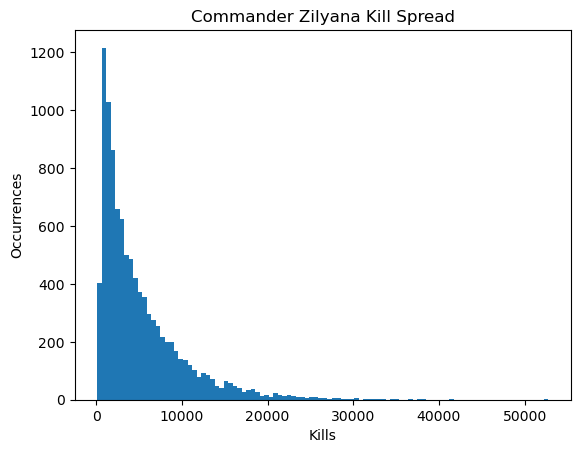

In [77]:
plt.figure()
plt.hist(sara_kill_df, bins=bin_num)
plt.xlabel("Kills")
plt.ylabel("Occurrences")
plt.title("Commander Zilyana Kill Spread")
plt.savefig("images\\Commander Zilyana Kill Spread.png")
plt.show()

In [78]:
# let's create a dictionary to hold all the stats we created from above
sara_stats = {"Boss Name" : ["Commander Zilyana"], 
             "Average Kills" : [sara_avg], 
             "Lowest Kills": [sara_min], 
             "Highest Kills": [sara_max]}

# now let's turn it into a dataframe
sara_df = pd.DataFrame(sara_stats)

# did it work?
sara_df

Boss Name  Average Kills  Lowest Kills  Highest Kills
0  Commander Zilyana      5151.0306           147          52750

In [79]:
greenlog_df = pd.concat([greenlog_df, sara_df], ignore_index = True)
greenlog_df

Boss Name  Average Kills Lowest Kills Highest Kills
0                  King Black Dragon      6216.7389          149         53910
1  Chambers of Xeric: Challenge Mode      2120.8676         2000          9229
2         Hard Mode Theatre of Blood      2023.7817         2000          4355
3  Tombs of Amascut - 150 Invocation      2271.3666         2000         13290
4  Tombs of Amascut - 300 Invocation      2017.7115         2000          6003
5  Tombs of Amascut - 500 Invocation      2000.0000         2000          2000
6                   General Graardor      5161.8727          169         50361
7                   K'ril Tsutsaroth      5057.9821          184         55483
8                          Kree'arra      5166.8158          168         53226
9                  Commander Zilyana      5151.0306          147         52750

In [80]:
greenlog_df.to_csv("greenlog_df.csv")

In [181]:
kbd_log_df

Items  Amount Dropped
0  Prince Black Dragon               2
1            Kbd Heads              53
2       Dragon Pickaxe               5
3      Draconic Visage               1

In [184]:
kbd_group_df = kbd_log_df.drop(kbd_log_df[kbd_log_df.Items == "Prince Black Dragon"])
kbd_group_df

KeyError: "['Items', 'Amount Dropped'] not found in axis"

Let's do some kill generator and print the final drop to see what item a group of 5 players are specifically hunting

In [202]:
kbd_group_chase = []

for i in kbd_uniques:
    kbd_group_chase.append(i)

# this group isn't hunting the pet. They just want 5 of each unique so they don't have to share     
kbd_group_chase.remove("Prince Black Dragon")
kbd_group_chase

# let's grab all the other items into a list
kbd_full = ["Dragon bones", "Black Dragonhide", "Rune longsword", "Adamant Platebody", "Adamant Kiteshield",
            "Dragon med helm", "Air rune", "Iron arrow", "Runite bolts", "Law rune", "Blood rune", "Yew logs",
             "Adamantite bar", "Runite bar", "Gold ore", "Amulet of power", "Dragon arrowtips", "Dragon dart tip",
            "Runite limbs", "Shark", "Fire rune", "Dragon javelin heads"]

# let's append the uniques to this list
for i in kbd_uniques:
    kbd_full.append(i)

# convert to a df
kbd_full_df = pd.DataFrame(kbd_full, columns=['Items'])
# assign amoutn dropped to 0
kbd_full_df['Amount Dropped'] = 0
    
kbd_chase_df = pd.DataFrame(kbd_group_chase, columns=['Items'])
# assign amoutn dropped to 0
kbd_chase_df['Amount Dropped'] = 0

kbd_chase_df

Items  Amount Dropped
0        Kbd Heads               0
1   Dragon Pickaxe               0
2  Draconic Visage               0

In [213]:
kbd_chase_df['Amount Dropped'] = 0
kbd_full_df['Amount Dropped'] = 0

# restart the kill number to 0 for each iteration over log completion
kill = 0
# we want the loop to run until the log is completed
while True:
    # increase kill by 1
    kill += 1
    # dragon pickaxe is a 1/1000 preroll check before the loot is assigned
    # let's run that random roll here
    dpick_preroll = random.randint(1, 1000)

    # let's grab the drops that always drop
    drops = kbd_always_drop.rds_result

    # run a check to see if the dragon pickaxe dropped
    if dpick_preroll == 1000:
        # assign it as a list so we can append tertiary drops later
        results = ["Dragon Pickaxe"]

    # in the likely chance that the d pick doesn't drop, let's grab an item off the drop table
    else:            
        results = kbd_loot_table.rds_result

    for drop in drops:
        results.append(drop)

    # here are some tertiary drops that roll separately from everything else and can drop alongside
    # the rest of the loot

    # prince black dragon drops at a 1/3000 rate. Let's assign that number on every kill
    pet_roll = random.randint(1, 3000)

    # run a check to see if this kill gave us the pet
    if pet_roll == 3000:
        # if it passed, append the drop to the results list
        results.append('Prince Black Dragon')

    # draconic visage is the same way, but at a 1/5000. Let's assign that number
    vissy_roll = random.randint(1, 5000)

    # run the visage check
    if vissy_roll == 5000:
        # if successful, let's append it.
        results.append('Draconic Visage')


    # Back at it again with kbd heads. 1/128. Assign the value.
    heads_roll = random.randint(1, 128)

    # run the check
    if heads_roll == 128:
        # if true, append the drop
        results.append('Kbd Heads')

#         This section was for troubleshooting. Can uncomment if you want a printout of every drop until completion
#         print(f"Test {i+1} Kill {kill} loot:")

#         for drop in drops:
#             print(f"\t{drop}")

    for result in results:
#             print(f"\t{result}")

        # convert each item in the drop list to a string. rds library stores them as a list of objects, not strings
        result_conv = str(result)

        # check to see if the drop is in the collection log
        if result_conv in kbd_chase_df['Items'].values:
            # if it is, grab the row index of that item
            location = kbd_chase_df[kbd_chase_df['Items']==result_conv].index.values
            # convert that index to an integer
            location = int(location)
            # pass the integer in so that we can increase the respective counter by 1 for each time the item drops
            kbd_chase_df.at[location, 'Amount Dropped'] += 1

        if result_conv in kbd_full_df['Items'].values:
            # if it is, grab the row index of that item
            location = kbd_full_df[kbd_full_df['Items']==result_conv].index.values
            # convert that index to an integer
            location = int(location)
            # pass the integer in so that we can increase the respective counter by 1 for each time the item drops
            kbd_full_df.at[location, 'Amount Dropped'] += 1

    # here we run a check to see if the log is completed (everything has been dropped atleast once)
    if kbd_chase_df['Amount Dropped'].min() >= 5:
        # break out of the while loop when log is complete.
        kbd_kills.append(kill)
        print("The final kill for this group was:")
        for result in results:
            print(f"\t{result}")
        break

# when the log is complete, this will print a statement to let us know when the log was completed for that simulation
print(f"The group's goal was completed in {kill} kills!\n")


kbd_kill_df = pd.DataFrame(kbd_kills)
kbd_kill_df['percentile'] = kbd_kill_df[0].rank(pct=True)

df_row = kbd_kill_df[kbd_kill_df[0]==kill].index.values
# convert that index to an integer

# [0] is to prevent errors due to duplicate kills
df_row_conv = int(df_row[0])
# pass the integer in so that we can increase the respective counter by 1 for each time the item drops
ptile = kbd_kill_df.at[df_row_conv, 'percentile']
pertile = round(ptile*100, 2)
print(f"Your completed goal was in the {pertile}th percentile!")

The final kill for this group was:
	Runite bolts
	Dragon bones
	Black Dragonhide
	Draconic Visage
The group's goal was completed in 22056 kills!

Your completed goal was in the 98.61th percentile!


In [214]:
kbd_full_df

Items  Amount Dropped
0           Dragon bones           22056
1       Black Dragonhide           22056
2         Rune longsword            1689
3      Adamant Platebody            1521
4     Adamant Kiteshield             502
5        Dragon med helm             171
6               Air rune            1758
7             Iron arrow            1656
8           Runite bolts            1775
9               Law rune             847
10            Blood rune             892
11              Yew logs            1735
12        Adamantite bar             826
13            Runite bar             589
14              Gold ore             364
15       Amulet of power            1083
16      Dragon arrowtips             827
17       Dragon dart tip             898
18          Runite limbs             696
19                 Shark             706
20             Fire rune             849
21  Dragon javelin heads             862
22   Prince Black Dragon               9
23             Kbd Heads             167
24        Dragon Pickaxe              28
25       Draconic Visage               5

In [215]:
kbd_chase_df

Items  Amount Dropped
0        Kbd Heads             167
1   Dragon Pickaxe              28
2  Draconic Visage               5

https://gitlab.com/ramencatz/python-loot

https://towardsdatascience.com/heres-the-most-efficient-way-to-iterate-through-your-pandas-dataframe-4dad88ac92ee